## Precalculating data for the visualization of characteristic names

A more detailed description of the project motivation and intent is included in the "Names_visualize" document. The code below is intended to generate variables for use in that visualization. 

The short version:
The goal of this project is to help users find characteristic names, names that "fit". I want names that 1) feel familiar, and 2) tell you that the named person is probably from a specific time period and age range. Familiar, but unique enough to tell you something about the person's age or the year. 

This is useful, for example, for ads, or for writers of period pieces: in both cases, the character names should match up with the target age demographic. 

### Terminology point:

This project relies on the way that names are categorized by the Social Security Administration. Each birth is registered as either male or female, and throughout the text, these terms refer to that assigned sex.

In [1]:
%config Completer.use_jedi = False
#Autocomplete has been finicky, switching versions. 

In [2]:
import numpy as np
import pandas as pd
import csv
import os
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import colorsys
from wordcloud import WordCloud

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import datetime as dt
import pickle

import requests
from bs4 import BeautifulSoup
from requests_futures.sessions import FuturesSession

pd.set_option('display.max_rows',150)


In [3]:
#Set figure options:

#Yes, I want this as a universal default across all notebooks.
matplotlib.rcParams['font.sans-serif'] = ['Helvetica']

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.rc('figure', titlesize=10)  # fontsize of the figure title

In [4]:
#Load in preprocessed data. The "namelife_S_full" files are by
#far the largest, at 3-4 gigs.

alive_F = pd.read_pickle('./actuarial_data/life_F_df.pkl')
alive_M = pd.read_pickle('./actuarial_data/life_M_df.pkl')
alive_F_p = pd.read_pickle('./actuarial_data/life_F_p_df.pkl')
alive_M_p = pd.read_pickle('./actuarial_data/life_M_p_df.pkl')

#ALL OTHER PREPROCESSING OCCURS HERE OR CAN OPTIONALLY OCCUR HERE 

#Variables that could be stored below, for faster processing:
# names_df_trim = pd.read_pickle('names_df_trim.pkl')

# namelife_F_full = np.load('namelife_F_full.npy')
# namelife_F_base = np.load('namelife_F_base.npy')
# namelife_F_name = pd.read_pickle('namelife_F_name.pkl')
# namebirth_F = np.load('namebirth_F.npy')
# namelife_M_full = np.load('namelife_M_full.npy')
# namelife_M_base = np.load('namelife_M_base.npy')
# namelife_M_name = pd.read_pickle('namelife_M_name.pkl')
# namebirth_M = np.load('namebirth_M.npy')

In [5]:
#Include optional data visualizations?

showplot = True

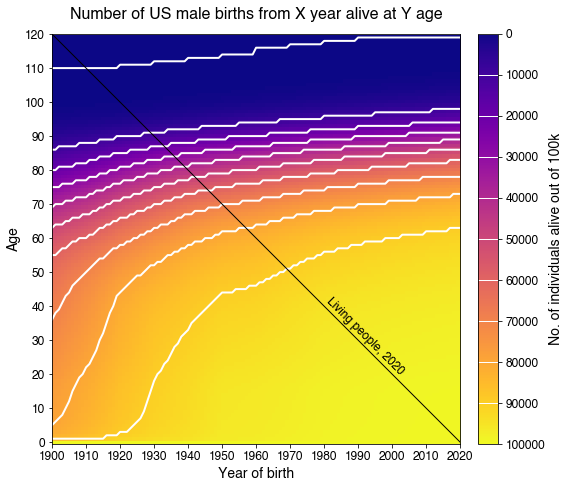

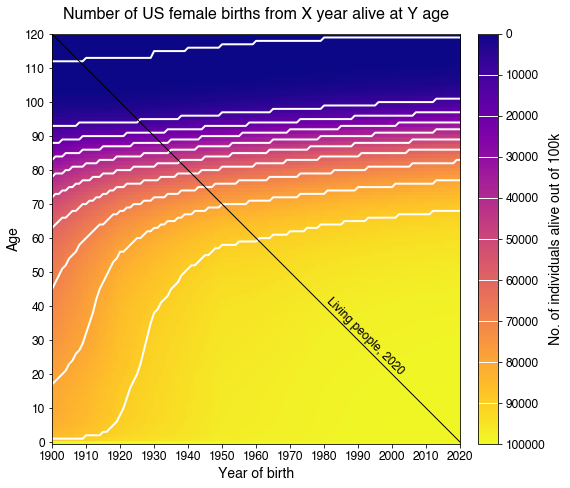

In [6]:
#This specific plot I am defaulting to true. The actuarial data
#is critical to understanding how this project works. 

#This plot does not expand to include new years of data as they
#are added. The final year it includes is 2019. Adding that 
#flexibility would be reasonably fast, but the data format and
#key historical trends are very clear without 1-2 additional 
#years of data.

if True:
    alive_M_t = alive_M.values.astype('float64').T
    alive_F_t = alive_F.values.astype('float64').T
    
    #Exploratory comparison:
    fig = plt.figure(figsize=[8,8])
    ax = plt.subplot(111, aspect='equal')
    cax = ax.imshow(alive_M_t, cmap='plasma')
    plt.title('Number of US male births from X year alive at Y age', pad=15)
    plt.ylabel('Age')
    plt.xlabel('Year of birth')

    #Get contours:
    contours_alive = np.zeros([alive_M_t.shape[1], 11])
    alive_num = []
    for n in range(10):

        #Note: Below method for finding first index at which the comparison
        #is true is not necessarily the best, it may cause spotty outputs for
        #unsorted data for example, but allows multidimensional comparison 
        #natively with use of the 'axis' variable. Where, nonzero, and
        #searchsorted use a 1D array and would have to be reindexed. Would be
        #good flatten/rebuild matrix practice at some point in the future.
        #
        #Good discussion here: 
        #https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value

        #Find first index at which fewer than X people are alive:
        contours_alive[:,n] = np.argmax(alive_M_t < (100000 - n*10000), axis=0)

        alive_num.append(100000 - n*10000)

    contours_alive[:,10] = np.argmax(alive_M_t < 1, axis=0)
    contours_alive[contours_alive[:,10]==0, 10] = np.max(contours_alive[:,10])
    alive_num.append(0)

    plt.plot(contours_alive[:,1:], color=[1,1,1], linewidth=2)

    ax.plot([120,0],[0,120],'k',linewidth=1)
    txtemp = ax.text(80,20, 'Living people, 2020', size=12, rotation=-45)

    plt.ylim([-0.5,119.5])
    plt.xlim([.5,120])

    ax.set_xticks(np.arange(0,121,10))
    ax.set_xticklabels((np.arange(0,121,10) + 1900).astype('str'))
    ax.set_yticks(np.arange(0,121,10))

    cbar = fig.colorbar(cax, 
                        ticks=alive_num, fraction=0.046, pad=0.04,
                        label='No. of individuals alive out of 100k',)
    cbar.ax.set_yticklabels(alive_num)  # vertically oriented colorbar
    cbar_lims = cbar.ax.get_xlim()
    cbar.ax.invert_yaxis()
    cbar.ax.hlines(alive_num, cbar_lims[0], cbar_lims[1], colors='w', linewidth=1)
    fig.set_facecolor('white')

    plt.show()


    
    
    #Redo for F:
    fig = plt.figure(figsize=[8,8])
    ax = plt.subplot(111, aspect='equal')
    cax = ax.imshow(alive_F_t, cmap='plasma')
    plt.title('Number of US female births from X year alive at Y age', pad=15)
    plt.ylabel('Age')
    plt.xlabel('Year of birth')

    #Get contours:
    contours_alive = np.zeros([alive_F_t.shape[1], 11])
    alive_num = []
    for n in range(10):

        #Note: Below method for finding first index at which the comparison
        #is true is not necessarily the best, it may cause spotty outputs for
        #unsorted data for example, but allows multidimensional comparison 
        #natively with use of the 'axis' variable. "Where", "nonzero", and
        #"searchsorted" use a 1D array and would have to be reindexed. Would
        #be good practice for flattening/rebuilding matrices if I rewrote it.
        #Good discussion here: 
        #https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value

        #Find first index at which fewer than X people are alive:
        contours_alive[:,n] = np.argmax(alive_F_t < (100000 - n*10000), axis=0)
        
        #(Store the target comparison variable for convenience)
        alive_num.append(100000 - n*10000)
        
    #Find first index at which less than one person is probably alive:
    contours_alive[:,10] = np.argmax(alive_F_t < 1, axis=0)
    contours_alive[contours_alive[:,10]==0,10] = np.max(contours_alive[:,10])
    alive_num.append(0)

    plt.plot(contours_alive[:,1:], color=[1,1,1], linewidth=2)

    ax.plot([120,0],[0,120],'k',linewidth=1)
    txtemp = ax.text(80,20, 'Living people, 2020', size=12, rotation=-45)

    plt.ylim([-0.5,119.5])
    plt.xlim([.5,120])

    ax.set_xticks(np.arange(0,121,10))
    ax.set_xticklabels((np.arange(0,121,10) + 1900).astype('str'))
    ax.set_yticks(np.arange(0,121,10))

    cbar = fig.colorbar(cax, 
                        ticks=alive_num, fraction=0.046, pad=0.04,
                        label='No. of individuals alive out of 100k',)
    cbar.ax.set_yticklabels(alive_num)  # vertically oriented colorbar
    cbar.ax.invert_yaxis()
    cbar_lims = cbar.ax.get_xlim()
    cbar.ax.hlines(alive_num, cbar_lims[0], cbar_lims[1], colors='w', linewidth=1)
    fig.set_facecolor('white')

    plt.show()

In [7]:
#Get the yearly total of all names (including sub-5) from Social Security 
#Admin, by year (useful for normalization)
#
#https://www.ssa.gov/oact/babynames/numberUSbirths.html

#Gets the data raw from the website and pickles it.

reload = False

if reload:
    response = requests.get('https://www.ssa.gov/oact/babynames/numberUSbirths.html')
    totalnames_table = pd.read_html(response.text, index_col='Year of birth')
    totalnames_table = totalnames_table[0]
    totalnames_table.to_pickle('./processed_variables/Total_soc_cards.pkl')
else:
    totalnames_table = pd.read_pickle('./processed_variables/Total_soc_cards.pkl')

In [8]:
#Load the year-of-birth data, in "yobYYYY.txt" format csv files.
#
#Data source: https://www.ssa.gov/OACT/babynames/limits.html,
#has national zip file that unpacks to the files below.

#Old version: Jump into the folder then listdir
# os.chdir('../Names/names_2020')
# current_dir = os.listdir()

tgtdir = './names_2020/'

names_dir = os.listdir(tgtdir)

names_temp = []
for ftemp in names_dir:
    if ftemp[-3:] == 'txt':
        dftemp = pd.read_csv(tgtdir + ftemp, names=['Name','Sex','Number'])
        dftemp['Year'] = int(ftemp[3:-4])
        names_temp.append(dftemp)
        
names_df = pd.concat(names_temp)
names_df.info()

#Old version:
# os.chdir('..')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020863 entries, 0 to 32029
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Name    object
 1   Sex     object
 2   Number  int64 
 3   Year    int64 
dtypes: int64(2), object(2)
memory usage: 77.1+ MB


In [9]:
#Reset the indexes to unduplicate them, since each stack was indexed 
#separately; keeping the old indices is handy though, so default
#'drop = false' option is kept.

#Yes, the sorting matters. It makes plotting much easier, and could
#be used to speed up the name structure indexing, which currently 
#takes 5-10 minutes. 

names_df = names_df.reset_index().sort_values(['Name','Year'])

names_df.head()

index   Name Sex  Number  Year
448147   32930  Aaban   M       5  2007
1658105  31173  Aaban   M       6  2009
622098   27952  Aaban   M       9  2010
542612   26573  Aaban   M      11  2011
342321   26563  Aaban   M      11  2012

In [10]:
#Above data is raw births, not controlled for population or number
#of births in that year. Here, I use database operations to get
#births as a fraction of the year's total births (those registered 
#through social security). 

#Join totalnames_table w/ names_df to get what fraction of total
#births that year consisted of each name. This separates names by 
#assigned sex without additional work, as the names_df entries are
#already separate. 

names_df = pd.merge(left=names_df, right=totalnames_table, 
                    left_on='Year', right_on='Year of birth', 
                    how='left')
names_df['Fraction'] = names_df['Number']/names_df['Total']

#This analysis does not normalize the number of births by name to
#the total births by sex, only total births total. If I adapt this
#code in the future to scale to projected total population size, 
#rather than only population of registered births, I'll need to
#adapt this section, since there appears to have been some sex bias
#in whether a birth was registered by the SSA in the years before
#1915 when national registration became more typical. An analysis
#showing the number of SSA-registered births as a percent of census-
#estimated births is present in "Names_v5"

# names_df.drop(columns=['Male','Female','Total'], inplace=True)

In [11]:
names_df.head()

index   Name Sex  Number  Year     Male   Female    Total  Fraction
0  32930  Aaban   M       5  2007  2214309  2115697  4330006  0.000001
1  31173  Aaban   M       6  2009  2120035  2024110  4144145  0.000001
2  27952  Aaban   M       9  2010  2053404  1959586  4012990  0.000002
3  26573  Aaban   M      11  2011  2030102  1936458  3966560  0.000003
4  26563  Aaban   M      11  2012  2027770  1938028  3965798  0.000003

In [12]:
print(len(names_df[['Name','Sex']].groupby(['Name','Sex']).count()))
print(len(names_df['Name'].unique()))

111472
100364


As you can see, there are over 100,000 unique names in the dataset, whether or not you count male and female names separately. Many of these names are held by very, *very* few individuals, and do not help much with our goal of determining characteristic names. If we were only looking for names *unique* to a given period, we'd be more interested in these rare names, but we aren't. Below, I trim down the complexity of the dataset slightly by removing the rarest names, which greatly improves variable sizes and run times for this analysis. My current analysis generates a complete birth/life matrix for each unique name, which allows much more rapid calculations but requires a lot of memory. 

After some testing, a threshold of 20 births removes nearly 40% of names, while excluding less than 5% of all births. This greatly improves variable size and run time. 

In [13]:
#Calculate total number of births for each name:
totalbirths_byname = names_df[['Name','Sex','Number']].groupby(['Name','Sex']).sum()

trimvalue = 20
#Limit dataset to names that had more than 20 total births
#with that name:
keepnames = totalbirths_byname[totalbirths_byname['Number'] > trimvalue]

#Join on name/sex pairs to keep only ones included above
names_df_trim = pd.merge(left=names_df, right=keepnames, on=['Name','Sex'], how='inner')
#Handling number column ambiguity, not pretty but works fine
names_df_trim['Number'] = names_df_trim['Number_x']
names_df_trim.drop(columns=['Number_x', 'Number_y'], inplace=True)
val1 = len(names_df.groupby(['Name','Sex']).size())
val2 = len(names_df_trim.groupby(['Name','Sex']).size())
val1a = len(names_df)
val2a = len(names_df_trim)

#Display results
print('Pretrim -> posttrim, minimum {} births:\n'.format(trimvalue))
print('Names (total M/F separately):')
print(val1, '->', val2)
print('Name/year records:')
print(val1a, '->', val2a)
print('\nRemoves {:.2f} of names while only removing {:.3f} of total birth records.'.format((val1-val2)/val1, (val1a-val2a)/val1a))

Pretrim -> posttrim, minimum 20 births:

Names (total M/F separately):
111472 -> 70589
Name/year records:
2020863 -> 1956469

Removes 0.37 of names while only removing 0.032 of total birth records.


In [14]:
#Grab the individual names
names_list = names_df_trim['Name'].unique()

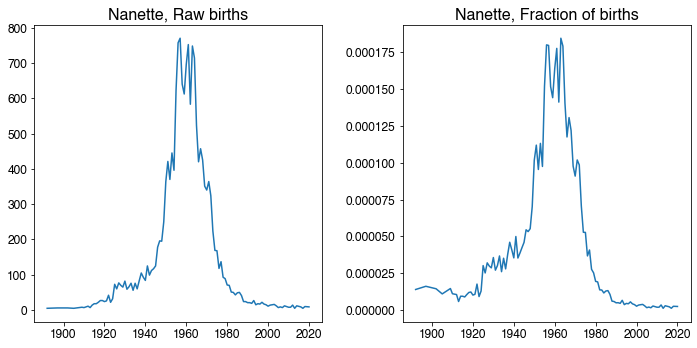

In [15]:
#OPTIONAL VISUALIZATION
#Difference in trajectory between raw names and name fraction
#SUMMARY: Using fraction effectively weights earlier births more

if showplot:
    #Show births trajectory for a random name:
    target_name = 'Nanette'
    
    tgtind = (names_df['Name']==target_name) & (names_df['Sex']=='F')
    subset = names_df[tgtind].sort_values('Year')
    fig, axs = plt.subplots(1,2,figsize=[10,5])
    axs[0].plot(subset['Year'], subset['Number'])
    axs[0].set_title(target_name + ', Raw births')
    axs[1].plot(subset['Year'], subset['Fraction'])
    axs[1].set_title(target_name + ', Fraction of births')
    plt.tight_layout()
    plt.show()

One key limitation of this data is that the actuarial tables I reference begin in 1900, while our name data begins in 1880. This affects our name prevalence estimates for older individuals from 1930-1990, which is a BIG chunk of our target range. The years 1880-1900 were a time of rapid life expectancy change, as you can see in the earlier actuarial data visualization, which means a simple approximation by duplicating 1900 values is not very accurate. Finding good life expectancy data for that period is difficult, but we can use the difference between period life expectancy and cohort life expectancy to get a reasonable estimate of these values. Below, I assume that the *trajectory* of lifespans in 1880-1900 was the same as 1900; we can then normalize the number of births using the 1900 period data (number currently alive at each age) so that the number of people alive from that age group should line up for future years. This will underestimate the number born in those periods, but should do a better job representing the number of people from that cohort alive in post-1900 projections. 

In [16]:
#Reprocessing actuarial data to estimate pre-1900 lives:

#Assume 1880-1900 lifespans have the same trajectory as 1900, then 
#normalize the starting births to match the number from that cohort
#who were alive in 1900. We can get that data from the period life
#tables; they predict how long someone will live based on how many
#people who are X age in the previous year are still alive.

alive_F_prescale = alive_F.copy() #Keep originals for reference
alive_M_prescale = alive_M.copy() #Keep originals for reference

#Add rows for 1880-1899:

#Could avoid loop, but it's fast anyway.
for year in np.arange(1880, 1900):
    alive_F.loc[year,:] = alive_F.loc[1900,:]
    alive_F_prescale.loc[year,:] = alive_F_prescale.loc[1900,:]
    #Multiply that year's aliveness vector by a scale number that
    #makes the aliveness in 1900 line up with the "p" (period)
    #data for 1900, which is based on past survival.
    alive_F.loc[year,:] = alive_F.loc[year,:] * (alive_F_p.loc[1900,1900-year-1])/(alive_F.loc[1900,1900-year-1])
alive_F = alive_F.sort_index()
alive_F_prescale = alive_F_prescale.sort_index()

for year in np.arange(1880, 1900):
    alive_M.loc[year,:] = alive_M.loc[1900,:]
    alive_M_prescale.loc[year,:] = alive_M_prescale.loc[1900,:]
    alive_M.loc[year,:] = alive_M.loc[year,:] * (alive_M_p.loc[1900,1900-year-1])/(alive_M.loc[1900,1900-year-1])
alive_M = alive_M.sort_index()
alive_M_prescale = alive_M_prescale.sort_index()

#In short, the alive_X structures are the number of people born in [row]
#year that have/will survive for [col] years. I'm using this "cohort data" 
#rather than period data, since I'm most interested in tracking individual
#lives across the timespan. THIS WILL MEAN THAT THE LIFE TABLE DOES NOT
#START AT 100,000 FOR THESE VALUES. That won't cause any analysis problems, 
#but should be kept in mind because it's nonstandard for actuarial data.

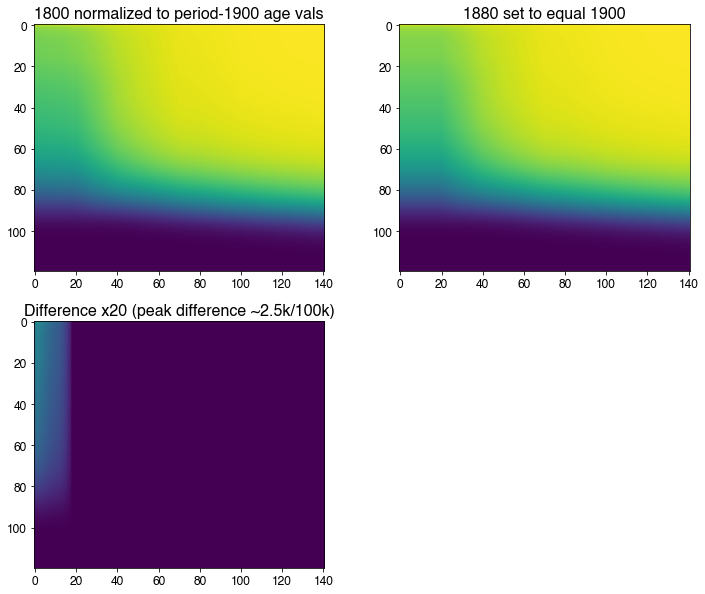

In [17]:
#Display the effect of this control for period life expectancy

#SUMMARY: Small but noticeable difference, up to 2.5 percent. This change
#improves on simply reusing 1900, but still likely overestimates how many
#people were alive in the 1900s from 1880-1900 birth years. 

if showplot:
    plt.figure(figsize=[12,10])
    plt.subplot(2,2,1)
    plt.imshow(alive_F.astype('float64').T)
    plt.title('1800 normalized to period-1900 age vals')
    plt.subplot(2,2,2)
    plt.imshow(alive_F_prescale.astype('float64').T)
    plt.title('1880 set to equal 1900')
    plt.subplot(2,2,3)
    plt.imshow(alive_F_prescale.astype('float64').T - alive_F.astype('float64').T, vmax=5000)
    plt.title('Difference x20 (peak difference ~2.5k/100k)')
    plt.show()

In [42]:
#Store reprocessed actuarial variables:
with open('./processed_variables/life_F_df2.pkl', 'wb') as fname:
    pickle.dump(alive_F, fname)
with open('./processed_variables/life_M_df2.pkl', 'wb') as fname:
    pickle.dump(alive_M, fname)

In [18]:
#Data check: Calculate how many unique names occur per year 
#(with trimming sanity check)

#This could be done with groupby, but this method is plenty fast enough.
numnames = []
for year in names_df['Year'].sort_values().unique():
    nn_y = year
    nn_b = len(names_df[names_df['Year']==year]['Name'].unique())
    nn_c = len(names_df_trim[names_df_trim['Year']==year]['Name'].unique())
    numnames.append([nn_y, nn_b, nn_c])
    
numnames = pd.DataFrame(numnames, columns=['Year','N_names_tot','N_names_trim']).set_index('Year')

print('Total unique names in each year:')
numnames

Total unique names in each year:


N_names_tot  N_names_trim
Year                           
1880         1889          1888
1881         1829          1826
1882         2012          2008
1883         1962          1957
1884         2158          2151
1885         2139          2136
1886         2225          2219
1887         2215          2213
1888         2454          2447
1889         2390          2383
1890         2475          2466
1891         2454          2449
1892         2686          2683
1893         2622          2615
1894         2705          2699
1895         2799          2788
1896         2839          2829
1897         2763          2756
1898         2987          2973
1899         2777          2773
1900         3394          3376
1901         2901          2897
1902         3065          3061
1903         3096          3088
1904         3251          3247
1905         3331          3325
1906         3307          3297
1907         3592          3578
1908         3640          3629
1909         3837          3828
1910         4174          4161
1911         4394          4374
1912         5726          5675
1913         6264          6202
1914         7161          7033
1915         8412          8143
1916         8693          8388
1917         8878          8566
1918         9303          8937
1919         9305          8943
1920         9634          9261
1921         9727          9340
1922         9657          9324
1923         9540          9225
1924         9734          9398
1925         9511          9180
1926         9335          9056
1927         9270          8985
1928         9052          8852
1929         8714          8563
1930         8715          8552
1931         8308          8167
1932         8341          8215
1933         8017          7900
1934         8191          8067
1935         8085          7953
1936         7904          7814
1937         7966          7871
1938         8056          7958
1939         7942          7868
1940         7984          7895
1941         8084          8009
1942         8385          8290
1943         8383          8306
1944         8162          8095
1945         8080          8005
1946         8683          8587
1947         9305          9171
1948         9190          9081
1949         9240          9128
1950         9281          9157
1951         9431          9306
1952         9578          9463
1953         9752          9618
1954         9881          9727
1955        10007          9864
1956        10213         10046
1957        10383         10189
1958        10389         10207
1959        10597         10428
1960        10752         10533
1961        11007         10808
1962        10988         10807
1963        11102         10901
1964        11214         11005
1965        10835         10677
1966        11029         10899
1967        11245         11073
1968        11744         11530
1969        12473         12212
1970        13405         13080
1971        13840         13499
1972        14014         13650
1973        14276         13894
1974        14743         14327
1975        15382         14941
1976        15847         15364
1977        16554         15985
1978        16625         16099
1979        17348         16778
1980        17729         17200
1981        17751         17304
1982        17924         17445
1983        17671         17253
1984        17749         17327
1985        18251         17779
1986        18796         18244
1987        19482         18901
1988        20431         19767
1989        21623         20867
1990        22676         21804
1991        23084         22195
1992        23361         22474
1993        23759         22878
1994        23844         22915
1995        23963         23132
1996        24304         23519
1997        24884         24043
1998        25724         24845
1999        26345         25419
2000        27520         26486
2001        27988         26926
2002        28284         27226
2003  

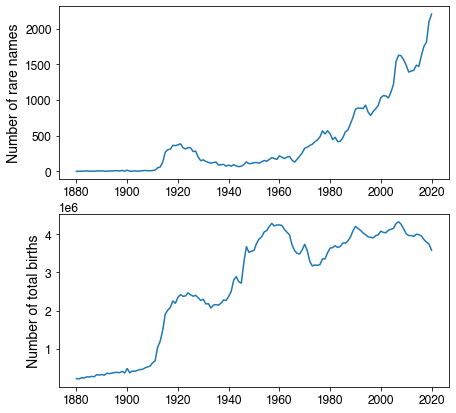

In [19]:
#OPTIONAL VISUALIZATION
#Trends in novel names

#Interesting aside: There is clearly an overall trend toward
#more low-frequency names, but there are also clearly periods
#where novel names were more common post-1945, and it looks
#like it may be generational. The initial bump after 1915 
#might have other explanations, as this was the first time 
#when most birth names were recorded. 

if showplot:
    fig, axs = plt.subplots(2,1, figsize=[7,7])
    axs[0].plot(numnames['N_names_tot'] - numnames['N_names_trim'])
    axs[0].set_ylabel('Number of rare names')
    axs[1].plot(totalnames_table['Total'])
    axs[1].set_ylabel('Number of total births')
    plt.show()

In [20]:
#Define functions and vars for making the big matrix of aliveness:

#It may be possible to pull off my intended comparisons by using
#joins or array operations, but the goal inherently needs a LOT 
#of comparisons across multiple rows to solve for a single set 
#of values. It is likely that these operations would not be much
#more efficient.

#Most likely, the way to get this ACTUALLY fast is to pre-sort
#by name and year, then use find operations to grab ranges of 
#data, rather than single year/name combinations. You'd then be
#matching 2-4 datapoints, instead of about 140. The total run
#time is well under than 10 minutes, however, so this is a good
#spot to optimize my time by not spending it optimizing. 

#Variables (automatically updated based on data range): 
#    nyears, total range of years of birth data (~140)
#    ndeath, total range of alive_X data for each year (120)
#    nyearsmax, last projected year (2050 - 1880)
nyears = len(numnames)
ndeath = alive_M.shape[1]
nyearsmax = 2050-1880

#Rebuild the alive matrix to sit across the target years:
#For each year's row, start the alive data from that year
#at that year's index, instead of at zero.
alive_M_re = np.zeros([nyears, nyears+ndeath])
for n in np.arange(0,nyears):
    tgt_year = n+1880
    alive_M_re[n, n:ndeath+n] = alive_M.loc[tgt_year,:]
alive_F_re = np.zeros([nyears, nyears+ndeath])
for n in np.arange(0,nyears):
    tgt_year = n+1880
    alive_F_re[n, n:ndeath+n] = alive_F.loc[tgt_year,:]
    

baseyear_df = pd.DataFrame(index=np.arange(1880,1880+nyears))

def gen_name_alive(name, sex, namedf, base_alive):
    #Non-passed vars used:
    #    baseyear_df
    #    nyears
    #    ndeath
    #    nyearsmax
    
    tgt_ind = (namedf['Name']==name) & (namedf['Sex']==sex)

    name_chunk = namedf[tgt_ind]
    name_chunk = name_chunk.set_index('Year')
    currentbirths = baseyear_df.join(name_chunk['Number']).fillna(0).values.T
    
    alive_vec = np.matmul(currentbirths, base_alive[:,:nyearsmax])
    alive_arr = base_alive[:,:nyearsmax] * np.tile(currentbirths.T,[1,nyearsmax])
    return alive_vec, alive_arr, currentbirths


#ABOVE IS NOTABLY FASTER than using below 3-way join method:

# def gen_name_alive(name, sex, namedf, base_alive):
#     #Make base year array
#     baseyear_df = pd.DataFrame(np.arange(1880,2020), columns=['Year'])
#     baseyear_df['Name'] = name
#     baseyear_df['Sex'] = sex
#     baseyear_df.set_index(['Year','Name','Sex'], inplace=True)
#     #The time-consuming line (everything else totals <.5msec):
#     currentbirths = baseyear_df.join(namedf['Number']).fillna(0).values.T
#
#     alive_vec = np.matmul(currentbirths, base_alive)
#     alive_vec = alive_vec[:,:nyearsmax]
#     alive_arr = base_alive[:,:nyearsmax] * np.tile(currentbirths.T,[1,nyearsmax])
#     return alive_vec, alive_arr, currentbirths

In [21]:
#Takes 3 minutes.

#Why am I splitting up the name chunks? Partly processing,
#partly making it easier to tell apart "Emily", the female
#name, from "Emily", the male name. Yes, there are a lot of
#names where there is gender overlap. I want to count them
#separately, since they can represent separate trends. For
#unisex names like "Jordan" or "Alex" it matters a lot!

#Could make this a function, but it uses and generates a 
#pile of variables that I want to keep for both cases, and 
#this outer processing loop only runs twice. 

#'names_F', full dataset with only female names
#'nameset_F', full list of female names
#'tempyears', how many years in the dataset
names_F = names_df_trim[names_df_trim['Sex']=='F'].sort_values('Name')
nameset_F = names_F['Name'].unique()
tempyears = names_F['Year'].unique()

#Array dimensions: Number of names, number of initial years, max year
namelife_F_full = np.zeros([len(nameset_F), nyears, nyearsmax])
namelife_F_base = np.zeros([len(nameset_F), nyearsmax])
namebirth_F = np.zeros([len(nameset_F), nyears])
namelife_F_name = []

print('Number of names: ' + str(len(nameset_F)))

namecount = 0

starttime1 = time.time()
starttime2 = time.time()
print('\nBEGIN:')

#Binsize of 100 appears to be a good balance between processing
#time for the nameset_sub assignment and for within-set indexing
binsize = 100
#Make the bin indexes:
bin_indexes = np.arange(0,len(nameset_F),binsize)
#If the bins don't evenly separate the dataset, add last ind
if (len(nameset_F)%binsize):
    bin_indexes = np.append(bin_indexes,len(nameset_F)+1)

for n in range(len(bin_indexes)-1):
    #Grab this bin's set of data:
    bininds = [bin_indexes[n], bin_indexes[n+1]]
    nameset_sub = nameset_F[bininds[0]:bininds[1]]
    #Pre-trim the dataset down to only the names present in
    #the current bin/batch
    names_F_sub = names_F[names_F['Name'].isin(nameset_sub)]
    
    for nameind in np.arange(0,len(nameset_sub)):
        
        nametemp = nameset_sub[nameind]
        
        #The big expensive bit (function and variable names above).
        #Note: Also calls some global variables that are not
        #explicitly fed into the function. 
        a_v, a_a, c_b = gen_name_alive(nametemp, 'F', names_F_sub, alive_F_re)
        
        namelife_F_base[namecount,:] = a_v
        namelife_F_full[namecount,:,:] = a_a
        namebirth_F[namecount,:] = c_b
        namelife_F_name.append(nametemp)
        
        namecount += 1
        
    print('bininds ' + str(bininds) + ', ' + 
          str(round(time.time() - starttime1, 3)) + 's tot, ' + 
          str(round(time.time() - starttime2, 3)) + 's per ' + str(binsize) + '-loop')
    starttime2 = time.time()

#Scale for base population of 100000 in actuarial data:
namelife_F_full = (namelife_F_full/100000).astype('int32')
namelife_F_base = namelife_F_base/100000
namelife_F_name = pd.Series(namelife_F_name)

Number of names: 43608

BEGIN:
bininds [0, 100], 0.185s tot, 0.185s per 100-loop
bininds [100, 200], 0.37s tot, 0.185s per 100-loop
bininds [200, 300], 0.545s tot, 0.175s per 100-loop
bininds [300, 400], 0.731s tot, 0.185s per 100-loop
bininds [400, 500], 0.911s tot, 0.181s per 100-loop
bininds [500, 600], 1.102s tot, 0.191s per 100-loop
bininds [600, 700], 1.295s tot, 0.192s per 100-loop
bininds [700, 800], 1.477s tot, 0.182s per 100-loop
bininds [800, 900], 1.655s tot, 0.179s per 100-loop
bininds [900, 1000], 1.847s tot, 0.192s per 100-loop
bininds [1000, 1100], 2.033s tot, 0.186s per 100-loop
bininds [1100, 1200], 2.224s tot, 0.191s per 100-loop
bininds [1200, 1300], 2.415s tot, 0.19s per 100-loop
bininds [1300, 1400], 2.612s tot, 0.197s per 100-loop
bininds [1400, 1500], 2.816s tot, 0.204s per 100-loop
bininds [1500, 1600], 3.001s tot, 0.185s per 100-loop
bininds [1600, 1700], 3.196s tot, 0.195s per 100-loop
bininds [1700, 1800], 3.396s tot, 0.199s per 100-loop
bininds [1800, 1900]

bininds [15000, 15100], 28.871s tot, 0.187s per 100-loop
bininds [15100, 15200], 29.046s tot, 0.175s per 100-loop
bininds [15200, 15300], 29.233s tot, 0.187s per 100-loop
bininds [15300, 15400], 29.414s tot, 0.181s per 100-loop
bininds [15400, 15500], 29.59s tot, 0.176s per 100-loop
bininds [15500, 15600], 29.774s tot, 0.183s per 100-loop
bininds [15600, 15700], 29.962s tot, 0.188s per 100-loop
bininds [15700, 15800], 30.145s tot, 0.183s per 100-loop
bininds [15800, 15900], 30.329s tot, 0.184s per 100-loop
bininds [15900, 16000], 30.507s tot, 0.178s per 100-loop
bininds [16000, 16100], 30.697s tot, 0.19s per 100-loop
bininds [16100, 16200], 30.883s tot, 0.186s per 100-loop
bininds [16200, 16300], 31.071s tot, 0.188s per 100-loop
bininds [16300, 16400], 31.255s tot, 0.184s per 100-loop
bininds [16400, 16500], 31.441s tot, 0.187s per 100-loop
bininds [16500, 16600], 31.629s tot, 0.188s per 100-loop
bininds [16600, 16700], 31.847s tot, 0.218s per 100-loop
bininds [16700, 16800], 32.043s t

bininds [29600, 29700], 56.006s tot, 0.19s per 100-loop
bininds [29700, 29800], 56.179s tot, 0.173s per 100-loop
bininds [29800, 29900], 56.352s tot, 0.173s per 100-loop
bininds [29900, 30000], 56.539s tot, 0.187s per 100-loop
bininds [30000, 30100], 56.72s tot, 0.182s per 100-loop
bininds [30100, 30200], 56.896s tot, 0.176s per 100-loop
bininds [30200, 30300], 57.066s tot, 0.169s per 100-loop
bininds [30300, 30400], 57.246s tot, 0.18s per 100-loop
bininds [30400, 30500], 57.443s tot, 0.198s per 100-loop
bininds [30500, 30600], 57.623s tot, 0.179s per 100-loop
bininds [30600, 30700], 57.807s tot, 0.185s per 100-loop
bininds [30700, 30800], 57.994s tot, 0.186s per 100-loop
bininds [30800, 30900], 58.202s tot, 0.208s per 100-loop
bininds [30900, 31000], 58.408s tot, 0.207s per 100-loop
bininds [31000, 31100], 58.589s tot, 0.181s per 100-loop
bininds [31100, 31200], 58.762s tot, 0.172s per 100-loop
bininds [31200, 31300], 58.945s tot, 0.184s per 100-loop
bininds [31300, 31400], 59.129s to

In [22]:
#Takes under 2 minutes.

#'names_M', full dataset with only male names
#'nameset_M', full list of male names
#'tempyears', how many years in the dataset
names_M = names_df_trim[names_df_trim['Sex']=='M'].sort_values('Name')
nameset_M = names_M['Name'].unique()
tempyears = names_M['Year'].unique()

#Array dimensions: Number of names, number of initial years, max year
namelife_M_full = np.zeros([len(nameset_M), nyears, nyearsmax])
namelife_M_base = np.zeros([len(nameset_M), nyearsmax])
namebirth_M = np.zeros([len(nameset_M), nyears])
namelife_M_name = []

print('Number of names: ' + str(len(nameset_M)))

namecount = 0

starttime1 = time.time()
starttime2 = time.time()
print('\nBEGIN:')

binsize = 100
#Make the bin indexes:
bin_indexes = np.arange(0,len(nameset_M),binsize)
if (len(nameset_M)%binsize):
    bin_indexes = np.append(bin_indexes,len(nameset_M)+1)

for n in range(len(bin_indexes)-1):
    #Grab this bin's set of data:
    bininds = [bin_indexes[n], bin_indexes[n+1]]
    nameset_sub = nameset_M[bininds[0]:bininds[1]]
    names_M_sub = names_M[names_M['Name'].isin(nameset_sub)]
    
    for nameind in np.arange(0,len(nameset_sub)):
        
        nametemp = nameset_sub[nameind]
        a_v, a_a, c_b = gen_name_alive(nametemp, 'M', names_M_sub, alive_M_re)
        
        namelife_M_base[namecount,:] = a_v
        namelife_M_full[namecount,:,:] = a_a
        namebirth_M[namecount,:] = c_b
        namelife_M_name.append(nametemp)
        
        namecount += 1
        
    print('bininds ' + str(bininds) + ', ' + 
          str(round(time.time() - starttime1, 3)) + 's tot, ' + 
          str(round(time.time() - starttime2, 3)) + 's per ' + str(binsize) + '-loop')
    starttime2 = time.time()

#Scale for base population of 100000 in actuarial data:
namelife_M_full = (namelife_M_full/100000).astype('int32')
namelife_M_base = namelife_M_base/100000
namelife_M_name = pd.Series(namelife_M_name)

Number of names: 26981

BEGIN:
bininds [0, 100], 0.172s tot, 0.172s per 100-loop
bininds [100, 200], 0.355s tot, 0.183s per 100-loop
bininds [200, 300], 0.534s tot, 0.179s per 100-loop
bininds [300, 400], 0.717s tot, 0.184s per 100-loop
bininds [400, 500], 0.895s tot, 0.177s per 100-loop
bininds [500, 600], 1.07s tot, 0.175s per 100-loop
bininds [600, 700], 1.237s tot, 0.167s per 100-loop
bininds [700, 800], 1.424s tot, 0.187s per 100-loop
bininds [800, 900], 1.604s tot, 0.18s per 100-loop
bininds [900, 1000], 1.797s tot, 0.193s per 100-loop
bininds [1000, 1100], 1.991s tot, 0.194s per 100-loop
bininds [1100, 1200], 2.168s tot, 0.177s per 100-loop
bininds [1200, 1300], 2.338s tot, 0.17s per 100-loop
bininds [1300, 1400], 2.523s tot, 0.184s per 100-loop
bininds [1400, 1500], 2.699s tot, 0.176s per 100-loop
bininds [1500, 1600], 2.886s tot, 0.187s per 100-loop
bininds [1600, 1700], 3.063s tot, 0.177s per 100-loop
bininds [1700, 1800], 3.256s tot, 0.193s per 100-loop
bininds [1800, 1900],

bininds [14900, 15000], 27.196s tot, 0.173s per 100-loop
bininds [15000, 15100], 27.372s tot, 0.176s per 100-loop
bininds [15100, 15200], 27.558s tot, 0.186s per 100-loop
bininds [15200, 15300], 27.733s tot, 0.174s per 100-loop
bininds [15300, 15400], 27.903s tot, 0.171s per 100-loop
bininds [15400, 15500], 28.071s tot, 0.167s per 100-loop
bininds [15500, 15600], 28.246s tot, 0.175s per 100-loop
bininds [15600, 15700], 28.426s tot, 0.179s per 100-loop
bininds [15700, 15800], 28.614s tot, 0.188s per 100-loop
bininds [15800, 15900], 28.801s tot, 0.187s per 100-loop
bininds [15900, 16000], 28.991s tot, 0.19s per 100-loop
bininds [16000, 16100], 29.171s tot, 0.18s per 100-loop
bininds [16100, 16200], 29.368s tot, 0.197s per 100-loop
bininds [16200, 16300], 29.552s tot, 0.184s per 100-loop
bininds [16300, 16400], 29.742s tot, 0.19s per 100-loop
bininds [16400, 16500], 29.928s tot, 0.186s per 100-loop
bininds [16500, 16600], 30.123s tot, 0.194s per 100-loop
bininds [16600, 16700], 30.305s to

In [23]:
np.save('./processed_variables/namelife_F_base.npy',namelife_F_base)
np.save('./processed_variables/namelife_M_base.npy',namelife_M_base)
np.save('./processed_variables/namelife_F_name.npy',namelife_F_name)
np.save('./processed_variables/namelife_M_name.npy',namelife_M_name)
np.save('./processed_variables/namebirth_F.npy',namebirth_F)
np.save('./processed_variables/namebirth_M.npy',namebirth_M)

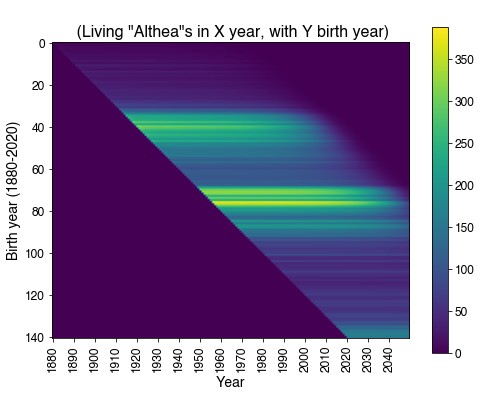

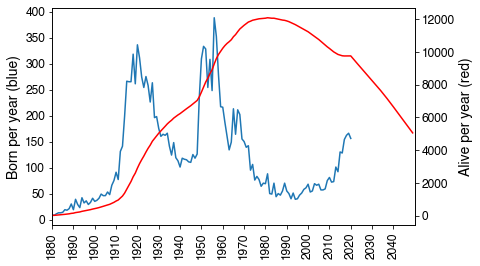

In [24]:
#OPTIONAL VISUALIZATION
#Example of name-life matrix for one name

#Very useful for understanding the structure of the namelife
#structure, defaulting to show:

if True:
    nametemp = 'Althea'
    
    nameind = namelife_F_name[namelife_F_name==nametemp].index.values[0]

    #Example subplot-based figure creation option 1
    fig, ax = plt.subplots(1,1, figsize=[8,6])
    im = plt.imshow(namelife_F_full[nameind,:,:])
    ax.set_title('\n (Living "' + str(namelife_F_name[nameind]) + '"s in X year, with Y birth year)')
    ax.set_xlabel('Year')
    ax.set_xticks(np.arange(0,2050-1880,10))
    ax.set_xticklabels(np.arange(1880,2050,10), rotation=90)

    plt.ylabel('Birth year (1880-{})'.format(1880+len(numnames)-1))
    plt.colorbar(im)
    plt.show()
    
    #Example subplot-based figure creation option 2
    fig = plt.figure(figsize=[6.5,4])
    ax = plt.subplot(1,1,1)
    ax.plot(namebirth_F[nameind,:])
    ax2 = ax.twinx()
    ax2.plot(namelife_F_base[nameind,:], color='red')
    ax.set_xticks(np.arange(0,2050-1880,10))
    ax.set_xticklabels(np.arange(1880,2050,10), rotation=90)
    ax.set_ylabel('Born per year (blue)')
    ax2.set_ylabel('Alive per year (red)')
    ax2.set_xlim(0,2050-1880)
    plt.show()

In [25]:
#Takes about 10 seconds.

#Average life-weighted year-of birth for each name for each year

#DOES NOT CHECK WHETHER ANYONE IS STILL ALIVE IN A YEAR BEFORE 
#DOING MATH, SO EXPECT DIVIDE BY ZERO ERRORS. NaNs are fine for
#showing lack of people alive, but it could be prettier.

#It is possible to do this with matrix multiplication. 

agevec = np.arange(1880,1880+nyears).T

aliveshape = namelife_M_full.shape
namelife_M_yob = np.zeros(namelife_M_base.shape)
namelife_sum = np.sum(namelife_M_full, axis=1)
for rowind in np.arange(0,aliveshape[0]):
    tempsum = namelife_sum[rowind,:]
    namelife_M_yob[rowind,:] = np.matmul(agevec, namelife_M_full[rowind,:,:]) / \
                               namelife_sum[rowind,:]

aliveshape = namelife_F_full.shape
namelife_F_yob = np.zeros(namelife_F_base.shape)
namelife_sum = np.sum(namelife_F_full, axis=1)
for rowind in np.arange(0,aliveshape[0]):
    namelife_F_yob[rowind,:] = np.matmul(agevec, namelife_F_full[rowind,:,:]) / \
                                namelife_sum[rowind,:]

/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [26]:
np.save('./processed_variables/namelife_F_yob.npy',namelife_F_yob)
np.save('./processed_variables/namelife_M_yob.npy',namelife_M_yob)

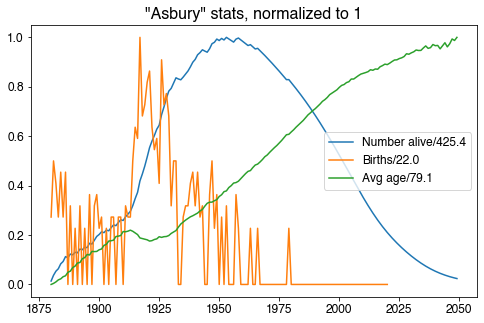

In [27]:
#OPTIONAL VISUALIZATION
#Show average age with number alive

if showplot:
    tgtind = 2005
    plt.figure(figsize=[8,5])
    plt.plot(np.arange(1880, 2050), namelife_M_base[tgtind,:] / np.max(namelife_M_base[tgtind,:]))
    plt.plot(np.arange(1880, 1880+len(numnames)), namebirth_M[tgtind,:] / np.max(namebirth_M[tgtind,:]))
    av_age = -1*(namelife_M_yob[tgtind,:] - np.arange(1880,2050))
    plt.plot(np.arange(1880, 2050), av_age / np.max(av_age))
    plt.title('"' + namelife_M_name[tgtind] + '" stats, normalized to 1')
    plt.legend(['Number alive/{:.1f}'.format(np.max(namelife_M_base[tgtind,:])),
                'Births/{:.1f}'.format(np.max(namebirth_M[tgtind,:])),
                'Avg age/{:.1f}'.format(np.max(av_age))],
               loc='center right'
              )
    plt.show()

In [28]:
#General analysis notes:

#This could be a good place in the future to normalize by ESTIMATED
#births in a given birth year. It's reasonable to only use SSA-known
#births, but it's more likely to represent the population well if I
#scale number of births up, so that the number with each name reflects
#the ratio of estimated total births to recorded births.

#How to do that: Derive estimated total number of births from Census
#data, then multiply births of each name from that year by the ratio
#of estimated births to SSA births. 

#There is still the problem that the early data is very regional. The
#US admitted a bunch of states between 1880 and 1915, when the data 
#starts getting better. Basically, data reliability before then is bad,
#and while there are things we can do about it to improve our estimates,
#it boils down to not having good numbers. Anything I try to do with 
#the data before then is going to need a lot of work, if I want to use
#any measure more complicated than name prevalence by year. 


#Future potential visualizations:

#Stacked line plot of all high-count names (i.e. with >10,000 holders),
#with color of the swath for that name varying w/ avg age at the x-axis
#time. Very large plot by number of graphed items! Framework is in an
#early draft of the code. Conceptual basis: draw an individual line for
#each name for each year, in the correct color, with height showing the
#number alive in that year. Stack those lines vertically. Repeat for 
#each year, with names plotted the same vertical order for each year. 

#Random comparisons: 

#Geographic names (cities, states, etc. Rivers? Mountains?)
#Names with abbreviations (Lawrence and Larry, Christopher and Chris, 
#Robert and Bob/Rob, Richard and Rick/Dick, Harold and Harry, Thomas
#and Tom/Thom, etc.)



These are mostly birth names that appeared in few years, and were held by few people.


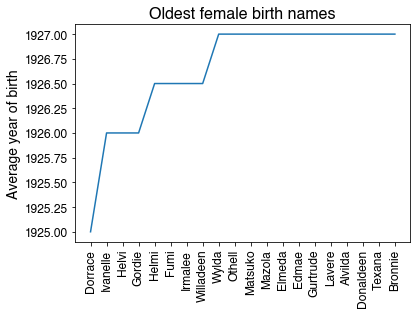

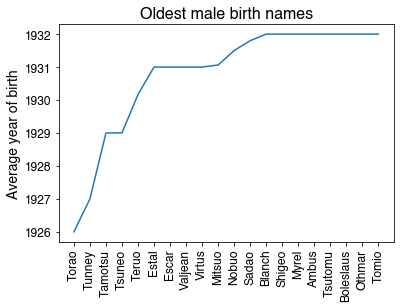

In [29]:
#OPTIONAL VISUALIZATION
#The oldest male and female names in the US:


if showplot:
    namrange = 20 #how many to look at
    print('\n\nThese are mostly birth names that appeared in few years, and were held by few people.')

    #Target year: 2020, aka location 1880+140
    nameF_ageind = np.argsort(namelife_F_yob[:,140])
    ax = plt.subplot(1,1,1)
    ax.plot(namelife_F_yob[nameF_ageind,140][0:namrange])
    ax.set_xticks(range(namrange))
    ax.set_xticklabels(namelife_F_name[nameF_ageind][0:namrange], rotation=90)
    ax.set_title('Oldest female birth names')
    ax.set_ylabel('Average year of birth')
    plt.show()

    nameM_ageind = np.argsort(namelife_M_yob[:,140])
    ax = plt.subplot(1,1,1)
    ax.plot(namelife_M_yob[nameM_ageind,140][0:namrange])
    ax.set_xticks(range(namrange))
    ax.set_xticklabels(namelife_M_name[nameM_ageind][0:namrange], rotation=90)
    ax.set_title('Oldest male birth names')
    ax.set_ylabel('Average year of birth')
    plt.show()

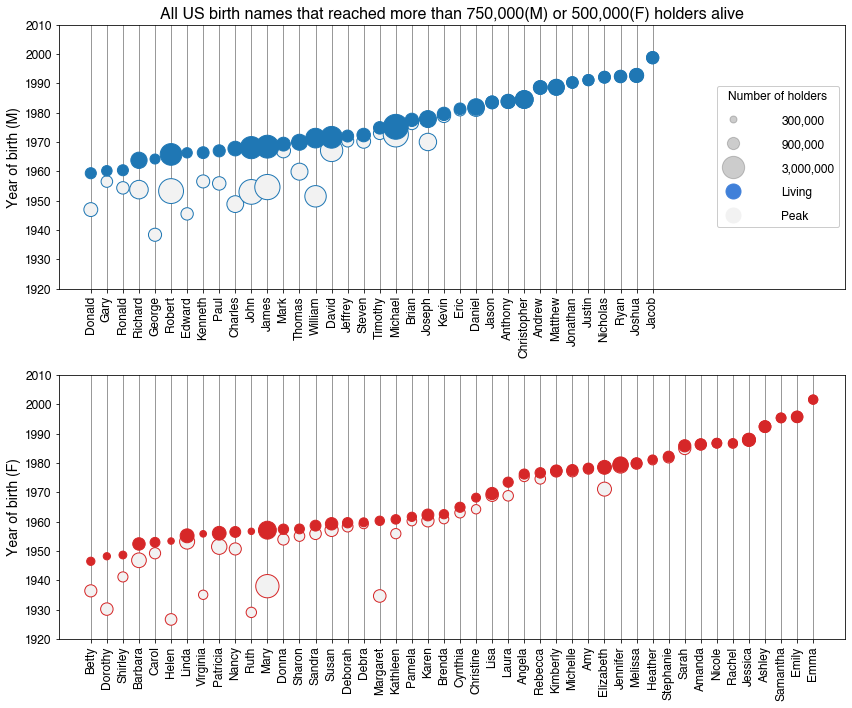

In [30]:
#OPTIONAL VISUALIZATION
#Common names by age:

if showplot:
    fig = plt.figure(figsize=[12,10], facecolor='white')
    ax = plt.subplot(2,1,1)
    plt.grid(b=True, axis='x', color='gray')
    ax2 = plt.subplot(2,1,2)
    plt.grid(b=True, axis='x', color='gray')


    n_hold_M = 750000
    n_hold_F = 500000
    numscale = 6000

    #Collect maximum number of holders alive for each name
    namelife_F_max = namelife_F_base.max(1)
    #Collect year index at which that occurred
    namelife_F_max_yr = np.argmax(namelife_F_base, axis=1)
    #Collect the avg. yob at the year index at which that occurred
    namelife_F_max_yob = namelife_F_yob[np.arange(0,len(namelife_F_max)),namelife_F_max_yr]
    #Collect the names for which that max was above the target threshold
    chunk_F = namelife_F_max >= n_hold_F
    #Select the YOB for data that met criteria, then collect year index that sorts it by YOB
    sort_yr_F = np.argsort(namelife_F_yob[chunk_F,2020-1880])
    #Select the number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_alive = namelife_F_base[chunk_F,2020-1880][sort_yr_F]
    #Select the maximum number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_maxalive = namelife_F_max[chunk_F][sort_yr_F]
    #Select the YOB at maximum number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_maxalive_yob = namelife_F_max_yob[chunk_F][sort_yr_F]

    #Repeat above for M
    namelife_M_max = namelife_M_base.max(1)
    namelife_M_max_yr = np.argmax(namelife_M_base, axis=1)
    namelife_M_max_yob = namelife_M_yob[np.arange(0,len(namelife_M_max)),namelife_M_max_yr]
    chunk_M = namelife_M_max >= n_hold_M
    sort_yr_M = np.argsort(namelife_M_yob[chunk_M,2020-1880])
    sort_yr_M_alive = namelife_M_base[chunk_M,2020-1880][sort_yr_M]
    sort_yr_M_maxalive = namelife_M_max[chunk_M][sort_yr_M]
    sort_yr_M_maxalive_yob = namelife_M_max_yob[chunk_M][sort_yr_M]


    xlims = [-2,max([sum(chunk_F), sum(chunk_M)])+1]
    ylims = [1920, 2010]

    n_hold = 300000

    # lin_1 = ax.plot(alivelist_M_yob[chunk_M,2020-1880][sort_yr_M]+1880, color='blue', linewidth=1)
    dot_1a = ax.scatter(x=np.arange(0,sum(chunk_M)),
                        y=sort_yr_M_maxalive_yob,
                        s=sort_yr_M_maxalive/numscale, 
                        color=[[.95,.95,.95]], edgecolor='tab:blue',zorder=5,label='Peak holders')
    dot_1b = ax.scatter(x=np.arange(0,sum(chunk_M)),
                        y=namelife_M_yob[chunk_M,2020-1880][sort_yr_M],
                        s=sort_yr_M_alive/numscale,
                        color='tab:blue', edgecolor='tab:blue',zorder=6,label='Current holders')
    ax.set_xticks(range(sum(chunk_M)))
    ax.set_xticklabels(namelife_M_name[chunk_M].iloc[sort_yr_M], rotation=90)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    # ax.legend()


    # lin_2 = ax2.plot(alivelist_F_yob[chunk_F,2020-1880][sort_yr_F]+1880, color='red', linewidth=1)
    dot_1a = ax2.scatter(x=np.arange(0,sum(chunk_F)),
                        y=sort_yr_F_maxalive_yob,
                        s=sort_yr_F_maxalive/numscale, 
                        color=[[.95,.95,.95]], edgecolor='tab:red',zorder=5,label='Peak holders')
    dot_1b = ax2.scatter(x=np.arange(0,sum(chunk_F)),
                        y=namelife_F_yob[chunk_F,2020-1880][sort_yr_F],
                        s=sort_yr_F_alive/numscale,
                        color='tab:red', edgecolor='tab:red',zorder=6,label='Current holders')
    ax2.set_xticks(range(sum(chunk_F)))
    ax2.set_xticklabels(namelife_F_name[chunk_F].iloc[sort_yr_F], rotation=90)
    ax2.set_ylim(ylims)
    ax2.set_xlim(xlims)

    # plt.grid(axis='y', color=0.9)

    #proxy size labels:
    legendpts = np.array([n_hold, n_hold*3, n_hold*10]).astype('int64')
    scatter_for_legend = ax.scatter(x=[0,0,0], y=[0,0,0], 
                                    s=legendpts/numscale,
                                    c=[[1,1,1,0],[1,1,1,0],[1,1,1,0]]
                                   )
    scatter_for_legend_2 = ax.scatter(x=[0], y=[0],
                                      s=[1.5*legendpts[1]/numscale],
                                      c=['tab:blue'])
    scatter_for_legend_3 = ax.scatter(x=[0], y=[0],
                                      s=[1.5*legendpts[1]/numscale],
                                      c=[[.95,.95,.95]],
                                      edgecolor=['tab:blue'])
    handles, labels = scatter_for_legend.legend_elements(prop="sizes", alpha=0.2)
    handles_2, labels_2 = scatter_for_legend_2.legend_elements(prop="sizes", alpha=1, color=[.25,.5,.85])
    handles_3, labels_3 = scatter_for_legend_3.legend_elements(prop="sizes", alpha=1, color=[.95,.95,.95])
    # legend = ax.legend(handles=handles+[]+handles_2+handles_3,
    #                    labels=['{0:,}'.format(m) for m in legendpts]+[]+['Living', 'Peak'],
    #                    loc="center right",
    #                    handletextpad=3,
    #                    labelspacing=1,
    #                    framealpha=1,
    #                    title="Number of holders"
    #                   )
    legend = ax.legend(handles=handles+[]+handles_2+handles_3,
                       labels=['{0:,}'.format(m) for m in legendpts]+[]+['Living', 'Peak'],
                       loc="center right",
                       handletextpad=3,
                       labelspacing=1,
                       framealpha=1,
                       title="Number of holders"
                      )

    ax.set_title('All US birth names that reached more than {0:,}(M) or {1:,}(F) holders alive'.format(n_hold_M,n_hold_F))
    ax.set_ylabel('Year of birth (M)')
    ax2.set_ylabel('Year of birth (F)')
    # fig.set_ylabel('Average year of birth for holders')
    # ax2.set_ylabel('Average year of birth for holders living in 2020')
    fig.tight_layout()

    plt.show()

In [31]:
#No longer in use, but still works

# #Assign names aliveness ranks by year
# aliverank_M_yr = np.full(namelife_M_base.shape, np.nan)
# for n in range(aliveshape[2]):
#     tempset = namelife_M_base[:,n] != 0
#     aliverank_M_yr[tempset,n] = np.argsort(-namelife_M_base[tempset,n])
# aliverank_F_yr = np.full(namelife_F_base.shape, np.nan)
# for n in range(aliveshape[2]):
#     tempset = namelife_F_base[:,n] != 0
#     aliverank_F_yr[tempset,n] = np.argsort(-namelife_F_base[tempset,n])

In [32]:
#Generate namedata for a given range/age/sex, returning only the 
#top-N subset rather than the full sorted data.

def get_namedata(year_range,
                 age_range,
                 sex,
                 totalnon,
                 n_names_store=100, 
                 show_scores=False, 
                 justpopular=False,
                ):
    """
    This function calculates the data used for the visualization functions,
    ranking the individual names based on how well they fit the era and how
    many individuals there were (score calculation line bracketed by "#KEY")
    
    MAKE SURE THE 'totalnon' INPUT IS RIGHT! Must be the total person-years
    per name/index for the correct sex! It should throw a mismatched-size 
    error if you give it the wrong one, but better safe than sorry. 
    
    Relies on the "namelife_{F/M}_full" datastructures being in memory.     
    """
    
    
    #We want to look at the 20-30 range for each of 4 years, for example
    #Year targets: n1-1880, n2-1880
    year1 = year_range[0] - 1880
    year2 = year_range[1] - 1880
    yeardiff = year2 - year1

    age1 = age_range[0]
    age2 = age_range[1]
    agediff = age2 - age1

    startinds = year1 - age2 + np.arange(yeardiff)
    
    s = sex
    
    #print('Startinds, agediff, yeardiff, year1')
    #print(startinds, agediff, yeardiff, year1)
    
    if s=='F':
        # #How many person-years were lived in the target:
        # totaltgt = np.sum(namelife_F_full[:, coh1:coh2, year1:year2], axis=(1,2))

        #Mask to only keep people from each year who were in the target
        #EX: for ages 20-30 in years 1990-1995: for each (ind0) name, look
        #at (ind1) birth years 1960-1970, for (ind2) current year 1990.
        #Do that for 1990-1995. 1961-1971 for 1991, etc.

        #For each cohort, we only want to count years that they lived
        #that fell in that age range during that time span. 

        #tgt_mask = np.zeros_like(namelife_F_full, dtype='bool')
        ##For each year in the range,
        #for n in range(yeardiff):
        #    #Set the birth years corresponding to the age range to 1
        #    tgt_mask[:, startinds[n]:startinds[n]+agediff, year1+n] = True
        #totaltgt = np.sum(namelife_F_full * tgt_mask, axis=(1,2))
        
        #MASK WORKS, BUT VERY SLOW. Already have to get indices, just sum!
        totaltgt = 0
        #For each year in the range,
        for n in range(yeardiff):
            #Add the years lived by birth years corresponding to the age range
            totaltgt += np.sum(namelife_F_full[:, startinds[n]:startinds[n]+agediff, year1+n], axis=1)
        #Scale to total target years, for consistent scoring across ranges:
        totaltgt = totaltgt / (agediff * yeardiff)
        
    elif s=='M':
        totaltgt = 0
        #For each year in the range,
        for n in range(yeardiff):
            #Add the years lived by birth years corresponding to the age range
            totaltgt += np.sum(namelife_M_full[:, startinds[n]:startinds[n]+agediff, year1+n], axis=1)

        
    else:
        print('Gender options in social security name data are M or F')
        return None
        
    #Calculate what percent of name's total person-years happened in that window:
    name_specificity = totaltgt/totalnon
    #Weight by total number with that name in the window, scaled to total years:
    name_weight = totaltgt / (agediff * yeardiff)
    
    #KEY
    #KEY
    #KEY
    #Calculate score:
    name_score = 10 * (np.log10(name_weight+1))**2 * name_specificity
    #KEY
    #KEY
    #KEY
    
    #SCORING EXPLANATION:
    #Using log10 scaling decreases influence of each birth as births rise.
    #Squaring this value decreases weight of numbers under 10, and increases
    #weight of numbers over 10, but much less than the raw linear scaling. 
    #
    #Scale reference, number of births -> effective weight:
    #  1 -> 0, 10 -> 1, 100 -> 4, 10,000 -> 16
    #
    #I also considered 2**np.log10(name_weight+1), which effectively just
    #raises the base weight to log10(2), or about 0.30, but it doesn't damp
    #the lowest person-year values as effectively. Names with less than ten
    #years lived in the target range should be near-zero. 

    
    
    #Grab the average age for all nameholders during the window
    if s=='F':
        #Calculate mean year of the range, then subtract the mean
        #year of birth (per name, :) across the range
        name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_F_yob[:,year1:year2+1], axis=1)
    else:
        name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_M_yob[:,year1:year2+1], axis=1)
    
    #Grab the names themselves
    if s=='F':
        name_outs = namelife_F_name
    else:
        name_outs = namelife_M_name
    
    if justpopular:
        #If you're just looking for most popular:
        nameinds = np.argsort(name_weight)
    else:
        #If you're looking for most representative (DEFAULT):
        nameinds = np.argsort(name_score) #defaults to asc
        
    # #SKIP BELOW CHUNK, CAN REBUILD USING OUTPUT DATA:
    # namedict = {}
    # agedict = {}
    # for n in range(n_names):
    #     dictkey = name_outs[nameinds].iloc[-(n+1)]
    #     if justpopular:
    #         namedict[dictkey] = int(name_weight[nameinds][-(n+1)])
    #     else:
    #         namedict[dictkey] = int(name_score[nameinds][-(n+1)])
    #     agedict[dictkey] = name_ages[nameinds][-(n+1)] 
    
    nameinds_used = nameinds[-n_names_store:]
    namerange_data2 = (name_specificity[nameinds_used],
                       name_weight[nameinds_used],
                       name_score[nameinds_used],
                       name_ages[nameinds_used],
                       name_outs[nameinds_used].values,
                       nameinds_used
                      )
    
    return namerange_data2

In [33]:
# #SANITY-CHECKING MASK-MULTIPLIED-SUM VS INDEX-SUM: 
# #SUMMARY: Yes, index-sum matches.

# target_range = [[1895,1896],[0,5],'M']
# totalnon = totalnon
# year_range = target_range[0]
# age_range = target_range[1]
# sex = target_range[2]
# #We want to look at the 20-30 range for each of 4 years, for example
# #Year targets: n1-1880, n2-1880
# year1 = year_range[0] - 1880
# year2 = year_range[1] - 1880
# yeardiff = year2 - year1
# age1 = age_range[0]
# age2 = age_range[1]
# agediff = age2 - age1
# startinds = year1 - age2 + np.arange(yeardiff)
# s = sex

# tgt_mask = np.zeros_like(namelife_M_full, dtype='bool')
# #For each year in the range,
# for n in range(yeardiff):
#    #Set the birth years corresponding to the age range to 1
#    tgt_mask[:, startinds[n]:startinds[n]+agediff, year1+n] = True
# totaltgt1 = np.sum(namelife_M_full * tgt_mask, axis=(1,2))

# #MASK WORKS, BUT VERY SLOW. Already have to get indices, just sum!
# totaltgt2 = 0
# #For each year in the range,
# for n in range(yeardiff):
#     #Add the years lived by birth years corresponding to the age range
#     totaltgt2 += np.sum(namelife_M_full[:, startinds[n]:startinds[n]+agediff, year1+n], axis=1)

# print('Identical checksums, identical at all points:')

# fig, axs = plt.subplots(3,1, figsize=[6,6])
# axs[0].plot(totaltgt1)
# axs[1].plot(totaltgt2)
# axs[2].plot(totaltgt2 - totaltgt1)

In [34]:
#FEATURE ENGINEERING TEST VISUALIZATION:

# x = np.logspace(0,5,500)
# plt.plot(x, np.log(x))
# plt.show()
# plt.semilogx(x, np.log10(x))
# plt.semilogx(x, np.log10(x)**2)
# plt.show()
# plt.semilogx(x, np.log10(x))
# plt.semilogx(x, np.log10(x)**2)
# plt.xlim([10**-1, 10**2.5])
# plt.ylim([-1,10])
# plt.show()

In [35]:
#USER INPUTS: 

#"Target year"
# -Target year (i.e. 1960)

#"Year range"
# -Year range, +-0, +-2, +-5 (i.e. 1960, 1958-1962, 1955-1965)

#"Target age", LIMITED BASED ON YEAR CHOICE! CAN ONLY DO UP TO ("Target year" - 1880 - agerange/2)
# -Target age (i.e. 20)

#"Age range", DITTO LIMITED
# -Age range, +-2 or +-5 (i.e. 18-22, 15-25)

#"Sex"
# -Sex (M or F)

#Generate all possible ranges of years/ages to check:
print('Year ranges (index/range):')
#Yearsteps: total years around central to compare, i.e. 5 is year-2 through year+2, 1882: 1880-1884
yearsteps = [0,4,10]
yearrange = np.zeros([nyears+1, len(yearsteps), 2], dtype='int32')
for n in range(len(yearsteps)):
    print(n, yearsteps[n])
    yearrange[:-1-yearsteps[n],n,0] = np.arange(1880, 1880+nyears-yearsteps[n])
    yearrange[:-1-yearsteps[n],n,1] = np.arange(1880+yearsteps[n], 1880+nyears)+1
    
#Generate age ranges to check:
print('Age ranges (index/range):')
agesteps = [4,10]
agerange = np.zeros([101-0, len(agesteps), 2], dtype='int32')
for n in range(len(agesteps)):
    print(n, agesteps[n])
    agerange[:-1-agesteps[n],n,0] = np.arange(0, 100-agesteps[n])
    agerange[:-1-agesteps[n],n,1] = np.arange(0+agesteps[n], 100)+1
    
#Given the above values:
#Total comparisons per target year/age pair: 6
#Total target year/age pairs: 100*140
#Total names per set: 100
#Total data points per name: 5
#Total items: ~30mil, compared to ~1bil in namelife_F_full, a
#50-fold decrease in stored values. 
#print(np.prod(namelife_F_full.shape))
#print(np.prod([6,100,140,100,3]))

Year ranges (index/range):
0 0
1 4
2 10
Age ranges (index/range):
0 4
1 10


In [36]:
# #GRAB SUBSET FOR TESTING:
# yearrange = yearrange[-15:-13]
# agerange = agerange[-25:-23]

In [37]:
%%time

n_names_store = 140
#140 is the maximum that results in file sizes under 100MB.

#NOTE: Alternate score systems can be partially reconstructed from
#these data, though the top-names limit means you're reshuffling a
#fairly limited set. The storage size starts to be a little iffy
#above storing 500 per set, that size gives 5x ~300mb structures

arraysize = [len(yearrange), len(agerange), len(yearsteps), len(agesteps), n_names_store]
sel_specif = np.zeros(arraysize)
sel_weight = np.zeros(arraysize)
sel_scores = np.zeros(arraysize)
sel_ages = np.zeros(arraysize)
sel_names = np.ndarray(arraysize, dtype='object')
sel_inds = np.zeros(arraysize, dtype='int')

#Only need to run this once, instead of once per function call
totalnon_M = np.sum(namelife_M_full, axis=(1,2))

skipct = 0
for t_yr in range(len(yearrange)):
    for t_ag in range(len(agerange)):
        for s_yr in range(len(yearsteps)):
            for s_ag in range(len(agesteps)):
                
                #TEST WHETHER THIS RANGE IS OUTSIDE DATA:
                go_cond = True
                if (yearrange[t_yr, s_yr][0] == 0) or sum(agerange[t_ag, s_ag] == [0,0])==2:
                    go_cond = False
                #year1 - age2 < 0:
                if yearrange[t_yr, s_yr][0] - agerange[t_ag, s_ag][1] - 1880 < 0:
                    go_cond = False
                #Do I even need to watch for high clipping? Probably not!
                #if yearrange[t_yr, s_yr][1] + agerange[t_ag, s_ag][1] > 
                
                if go_cond:
                    print(yearrange[t_yr,s_yr], agerange[t_ag, s_ag])
                    target_range_M = [yearrange[t_yr,s_yr], agerange[t_ag, s_ag], 'M']
                    
                    namerange_data_M = get_namedata(target_range_M[0], target_range_M[1],target_range_M[2],
                                                    totalnon_M, n_names_store=n_names_store)
                    
                    sel_specif[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[0]
                    sel_weight[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[1]
                    sel_scores[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[2]
                    sel_ages[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[3]
                    sel_names[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[4]
                    sel_inds[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_M[5]
                else:
                    skipct += 1
                    print(yearrange[t_yr,s_yr], agerange[t_ag, s_ag], end=' ')
                    print('outside range')
                    
#NOTE: Alternate score systems can be partially reconstructed from
#these data, though the top-X limit means you're reshuffling a
#fairly limited set. The storage size starts to be a little iffy

[1880 1881] [0 5] outside range
[1880 1881] [ 0 11] outside range
[1880 1885] [0 5] outside range
[1880 1885] [ 0 11] outside range
[1880 1891] [0 5] outside range
[1880 1891] [ 0 11] outside range
[1880 1881] [1 6] outside range
[1880 1881] [ 1 12] outside range
[1880 1885] [1 6] outside range
[1880 1885] [ 1 12] outside range
[1880 1891] [1 6] outside range
[1880 1891] [ 1 12] outside range
[1880 1881] [2 7] outside range
[1880 1881] [ 2 13] outside range
[1880 1885] [2 7] outside range
[1880 1885] [ 2 13] outside range
[1880 1891] [2 7] outside range
[1880 1891] [ 2 13] outside range
[1880 1881] [3 8] outside range
[1880 1881] [ 3 14] outside range
[1880 1885] [3 8] outside range
[1880 1885] [ 3 14] outside range
[1880 1891] [3 8] outside range
[1880 1891] [ 3 14] outside range
[1880 1881] [4 9] outside range
[1880 1881] [ 4 15] outside range
[1880 1885] [4 9] outside range
[1880 1885] [ 4 15] outside range
[1880 1891] [4 9] outside range
[1880 1891] [ 4 15] outside range
[1880 1881

[1881 1892] [17 22] outside range
[1881 1892] [17 28] outside range
[1881 1882] [18 23] outside range
[1881 1882] [18 29] outside range
[1881 1886] [18 23] outside range
[1881 1886] [18 29] outside range
[1881 1892] [18 23] outside range
[1881 1892] [18 29] outside range
[1881 1882] [19 24] outside range
[1881 1882] [19 30] outside range
[1881 1886] [19 24] outside range
[1881 1886] [19 30] outside range
[1881 1892] [19 24] outside range
[1881 1892] [19 30] outside range
[1881 1882] [20 25] outside range
[1881 1882] [20 31] outside range
[1881 1886] [20 25] outside range
[1881 1886] [20 31] outside range
[1881 1892] [20 25] outside range
[1881 1892] [20 31] outside range
[1881 1882] [21 26] outside range
[1881 1882] [21 32] outside range
[1881 1886] [21 26] outside range
[1881 1886] [21 32] outside range
[1881 1892] [21 26] outside range
[1881 1892] [21 32] outside range
[1881 1882] [22 27] outside range
[1881 1882] [22 33] outside range
[1881 1886] [22 27] outside range
[1881 1886] [2

[1882 1893] [10 15] outside range
[1882 1893] [10 21] outside range
[1882 1883] [11 16] outside range
[1882 1883] [11 22] outside range
[1882 1887] [11 16] outside range
[1882 1887] [11 22] outside range
[1882 1893] [11 16] outside range
[1882 1893] [11 22] outside range
[1882 1883] [12 17] outside range
[1882 1883] [12 23] outside range
[1882 1887] [12 17] outside range
[1882 1887] [12 23] outside range
[1882 1893] [12 17] outside range
[1882 1893] [12 23] outside range
[1882 1883] [13 18] outside range
[1882 1883] [13 24] outside range
[1882 1887] [13 18] outside range
[1882 1887] [13 24] outside range
[1882 1893] [13 18] outside range
[1882 1893] [13 24] outside range
[1882 1883] [14 19] outside range
[1882 1883] [14 25] outside range
[1882 1887] [14 19] outside range
[1882 1887] [14 25] outside range
[1882 1893] [14 19] outside range
[1882 1893] [14 25] outside range
[1882 1883] [15 20] outside range
[1882 1883] [15 26] outside range
[1882 1887] [15 20] outside range
[1882 1887] [1

[1883 1894] [20 25] outside range
[1883 1894] [20 31] outside range
[1883 1884] [21 26] outside range
[1883 1884] [21 32] outside range
[1883 1888] [21 26] outside range
[1883 1888] [21 32] outside range
[1883 1894] [21 26] outside range
[1883 1894] [21 32] outside range
[1883 1884] [22 27] outside range
[1883 1884] [22 33] outside range
[1883 1888] [22 27] outside range
[1883 1888] [22 33] outside range
[1883 1894] [22 27] outside range
[1883 1894] [22 33] outside range
[1883 1884] [23 28] outside range
[1883 1884] [23 34] outside range
[1883 1888] [23 28] outside range
[1883 1888] [23 34] outside range
[1883 1894] [23 28] outside range
[1883 1894] [23 34] outside range
[1883 1884] [24 29] outside range
[1883 1884] [24 35] outside range
[1883 1888] [24 29] outside range
[1883 1888] [24 35] outside range
[1883 1894] [24 29] outside range
[1883 1894] [24 35] outside range
[1883 1884] [25 30] outside range
[1883 1884] [25 36] outside range
[1883 1888] [25 30] outside range
[1883 1888] [2

[1884 1895] [30 41] outside range
[1884 1885] [31 36] outside range
[1884 1885] [31 42] outside range
[1884 1889] [31 36] outside range
[1884 1889] [31 42] outside range
[1884 1895] [31 36] outside range
[1884 1895] [31 42] outside range
[1884 1885] [32 37] outside range
[1884 1885] [32 43] outside range
[1884 1889] [32 37] outside range
[1884 1889] [32 43] outside range
[1884 1895] [32 37] outside range
[1884 1895] [32 43] outside range
[1884 1885] [33 38] outside range
[1884 1885] [33 44] outside range
[1884 1889] [33 38] outside range
[1884 1889] [33 44] outside range
[1884 1895] [33 38] outside range
[1884 1895] [33 44] outside range
[1884 1885] [34 39] outside range
[1884 1885] [34 45] outside range
[1884 1889] [34 39] outside range
[1884 1889] [34 45] outside range
[1884 1895] [34 39] outside range
[1884 1895] [34 45] outside range
[1884 1885] [35 40] outside range
[1884 1885] [35 46] outside range
[1884 1889] [35 40] outside range
[1884 1889] [35 46] outside range
[1884 1895] [3

[1885 1896] [ 0 11] outside range
[1885 1886] [1 6] outside range
[1885 1886] [ 1 12] outside range
[1885 1890] [1 6] outside range
[1885 1890] [ 1 12] outside range
[1885 1896] [1 6] outside range
[1885 1896] [ 1 12] outside range
[1885 1886] [2 7] outside range
[1885 1886] [ 2 13] outside range
[1885 1890] [2 7] outside range
[1885 1890] [ 2 13] outside range
[1885 1896] [2 7] outside range
[1885 1896] [ 2 13] outside range
[1885 1886] [3 8] outside range
[1885 1886] [ 3 14] outside range
[1885 1890] [3 8] outside range
[1885 1890] [ 3 14] outside range
[1885 1896] [3 8] outside range
[1885 1896] [ 3 14] outside range
[1885 1886] [4 9] outside range
[1885 1886] [ 4 15] outside range
[1885 1890] [4 9] outside range
[1885 1890] [ 4 15] outside range
[1885 1896] [4 9] outside range
[1885 1896] [ 4 15] outside range
[1885 1886] [ 5 10] outside range
[1885 1886] [ 5 16] outside range
[1885 1890] [ 5 10] outside range
[1885 1890] [ 5 16] outside range
[1885 1896] [ 5 10] outside range
[188

[1885 1896] [0 0] outside range
[1885 1896] [0 0] outside range
[1885 1886] [0 0] outside range
[1885 1886] [0 0] outside range
[1885 1890] [0 0] outside range
[1885 1890] [0 0] outside range
[1885 1896] [0 0] outside range
[1885 1896] [0 0] outside range
[1885 1886] [0 0] outside range
[1885 1886] [0 0] outside range
[1885 1890] [0 0] outside range
[1885 1890] [0 0] outside range
[1885 1896] [0 0] outside range
[1885 1896] [0 0] outside range
[1885 1886] [0 0] outside range
[1885 1886] [0 0] outside range
[1885 1890] [0 0] outside range
[1885 1890] [0 0] outside range
[1885 1896] [0 0] outside range
[1885 1896] [0 0] outside range
[1885 1886] [0 0] outside range
[1885 1886] [0 0] outside range
[1885 1890] [0 0] outside range
[1885 1890] [0 0] outside range
[1885 1896] [0 0] outside range
[1885 1896] [0 0] outside range
[1886 1887] [0 5]
[1886 1887] [ 0 11] outside range
[1886 1891] [0 5]
[1886 1891] [ 0 11] outside range
[1886 1897] [0 5]
[1886 1897] [ 0 11] outside range
[1886 1887] 

[1886 1887] [79 90] outside range
[1886 1891] [79 84] outside range
[1886 1891] [79 90] outside range
[1886 1897] [79 84] outside range
[1886 1897] [79 90] outside range
[1886 1887] [80 85] outside range
[1886 1887] [80 91] outside range
[1886 1891] [80 85] outside range
[1886 1891] [80 91] outside range
[1886 1897] [80 85] outside range
[1886 1897] [80 91] outside range
[1886 1887] [81 86] outside range
[1886 1887] [81 92] outside range
[1886 1891] [81 86] outside range
[1886 1891] [81 92] outside range
[1886 1897] [81 86] outside range
[1886 1897] [81 92] outside range
[1886 1887] [82 87] outside range
[1886 1887] [82 93] outside range
[1886 1891] [82 87] outside range
[1886 1891] [82 93] outside range
[1886 1897] [82 87] outside range
[1886 1897] [82 93] outside range
[1886 1887] [83 88] outside range
[1886 1887] [83 94] outside range
[1886 1891] [83 88] outside range
[1886 1891] [83 94] outside range
[1886 1897] [83 88] outside range
[1886 1897] [83 94] outside range
[1886 1887] [8

[1887 1888] [62 67] outside range
[1887 1888] [62 73] outside range
[1887 1892] [62 67] outside range
[1887 1892] [62 73] outside range
[1887 1898] [62 67] outside range
[1887 1898] [62 73] outside range
[1887 1888] [63 68] outside range
[1887 1888] [63 74] outside range
[1887 1892] [63 68] outside range
[1887 1892] [63 74] outside range
[1887 1898] [63 68] outside range
[1887 1898] [63 74] outside range
[1887 1888] [64 69] outside range
[1887 1888] [64 75] outside range
[1887 1892] [64 69] outside range
[1887 1892] [64 75] outside range
[1887 1898] [64 69] outside range
[1887 1898] [64 75] outside range
[1887 1888] [65 70] outside range
[1887 1888] [65 76] outside range
[1887 1892] [65 70] outside range
[1887 1892] [65 76] outside range
[1887 1898] [65 70] outside range
[1887 1898] [65 76] outside range
[1887 1888] [66 71] outside range
[1887 1888] [66 77] outside range
[1887 1892] [66 71] outside range
[1887 1892] [66 77] outside range
[1887 1898] [66 71] outside range
[1887 1898] [6

[1888 1899] [ 3 14] outside range
[1888 1889] [4 9] outside range
[1888 1889] [ 4 15] outside range
[1888 1893] [4 9] outside range
[1888 1893] [ 4 15] outside range
[1888 1899] [4 9] outside range
[1888 1899] [ 4 15] outside range
[1888 1889] [ 5 10] outside range
[1888 1889] [ 5 16] outside range
[1888 1893] [ 5 10] outside range
[1888 1893] [ 5 16] outside range
[1888 1899] [ 5 10] outside range
[1888 1899] [ 5 16] outside range
[1888 1889] [ 6 11] outside range
[1888 1889] [ 6 17] outside range
[1888 1893] [ 6 11] outside range
[1888 1893] [ 6 17] outside range
[1888 1899] [ 6 11] outside range
[1888 1899] [ 6 17] outside range
[1888 1889] [ 7 12] outside range
[1888 1889] [ 7 18] outside range
[1888 1893] [ 7 12] outside range
[1888 1893] [ 7 18] outside range
[1888 1899] [ 7 12] outside range
[1888 1899] [ 7 18] outside range
[1888 1889] [ 8 13] outside range
[1888 1889] [ 8 19] outside range
[1888 1893] [ 8 13] outside range
[1888 1893] [ 8 19] outside range
[1888 1899] [ 8 13] 

[1889 1900] [ 0 11] outside range
[1889 1890] [1 6]
[1889 1890] [ 1 12] outside range
[1889 1894] [1 6]
[1889 1894] [ 1 12] outside range
[1889 1900] [1 6]
[1889 1900] [ 1 12] outside range
[1889 1890] [2 7]
[1889 1890] [ 2 13] outside range
[1889 1894] [2 7]
[1889 1894] [ 2 13] outside range
[1889 1900] [2 7]
[1889 1900] [ 2 13] outside range
[1889 1890] [3 8]
[1889 1890] [ 3 14] outside range
[1889 1894] [3 8]
[1889 1894] [ 3 14] outside range
[1889 1900] [3 8]
[1889 1900] [ 3 14] outside range
[1889 1890] [4 9]
[1889 1890] [ 4 15] outside range
[1889 1894] [4 9]
[1889 1894] [ 4 15] outside range
[1889 1900] [4 9]
[1889 1900] [ 4 15] outside range
[1889 1890] [ 5 10] outside range
[1889 1890] [ 5 16] outside range
[1889 1894] [ 5 10] outside range
[1889 1894] [ 5 16] outside range
[1889 1900] [ 5 10] outside range
[1889 1900] [ 5 16] outside range
[1889 1890] [ 6 11] outside range
[1889 1890] [ 6 17] outside range
[1889 1894] [ 6 11] outside range
[1889 1894] [ 6 17] outside range
[1

[1889 1900] [55 66] outside range
[1889 1890] [56 61] outside range
[1889 1890] [56 67] outside range
[1889 1894] [56 61] outside range
[1889 1894] [56 67] outside range
[1889 1900] [56 61] outside range
[1889 1900] [56 67] outside range
[1889 1890] [57 62] outside range
[1889 1890] [57 68] outside range
[1889 1894] [57 62] outside range
[1889 1894] [57 68] outside range
[1889 1900] [57 62] outside range
[1889 1900] [57 68] outside range
[1889 1890] [58 63] outside range
[1889 1890] [58 69] outside range
[1889 1894] [58 63] outside range
[1889 1894] [58 69] outside range
[1889 1900] [58 63] outside range
[1889 1900] [58 69] outside range
[1889 1890] [59 64] outside range
[1889 1890] [59 70] outside range
[1889 1894] [59 64] outside range
[1889 1894] [59 70] outside range
[1889 1900] [59 64] outside range
[1889 1900] [59 70] outside range
[1889 1890] [60 65] outside range
[1889 1890] [60 71] outside range
[1889 1894] [60 65] outside range
[1889 1894] [60 71] outside range
[1889 1900] [6

[1890 1895] [ 3 14] outside range
[1890 1901] [3 8]
[1890 1901] [ 3 14] outside range
[1890 1891] [4 9]
[1890 1891] [ 4 15] outside range
[1890 1895] [4 9]
[1890 1895] [ 4 15] outside range
[1890 1901] [4 9]
[1890 1901] [ 4 15] outside range
[1890 1891] [ 5 10]
[1890 1891] [ 5 16] outside range
[1890 1895] [ 5 10]
[1890 1895] [ 5 16] outside range
[1890 1901] [ 5 10]
[1890 1901] [ 5 16] outside range
[1890 1891] [ 6 11] outside range
[1890 1891] [ 6 17] outside range
[1890 1895] [ 6 11] outside range
[1890 1895] [ 6 17] outside range
[1890 1901] [ 6 11] outside range
[1890 1901] [ 6 17] outside range
[1890 1891] [ 7 12] outside range
[1890 1891] [ 7 18] outside range
[1890 1895] [ 7 12] outside range
[1890 1895] [ 7 18] outside range
[1890 1901] [ 7 12] outside range
[1890 1901] [ 7 18] outside range
[1890 1891] [ 8 13] outside range
[1890 1891] [ 8 19] outside range
[1890 1895] [ 8 13] outside range
[1890 1895] [ 8 19] outside range
[1890 1901] [ 8 13] outside range
[1890 1901] [ 8 19

[1890 1901] [ 89 100] outside range
[1890 1891] [90 95] outside range
[1890 1891] [0 0] outside range
[1890 1895] [90 95] outside range
[1890 1895] [0 0] outside range
[1890 1901] [90 95] outside range
[1890 1901] [0 0] outside range
[1890 1891] [91 96] outside range
[1890 1891] [0 0] outside range
[1890 1895] [91 96] outside range
[1890 1895] [0 0] outside range
[1890 1901] [91 96] outside range
[1890 1901] [0 0] outside range
[1890 1891] [92 97] outside range
[1890 1891] [0 0] outside range
[1890 1895] [92 97] outside range
[1890 1895] [0 0] outside range
[1890 1901] [92 97] outside range
[1890 1901] [0 0] outside range
[1890 1891] [93 98] outside range
[1890 1891] [0 0] outside range
[1890 1895] [93 98] outside range
[1890 1895] [0 0] outside range
[1890 1901] [93 98] outside range
[1890 1901] [0 0] outside range
[1890 1891] [94 99] outside range
[1890 1891] [0 0] outside range
[1890 1895] [94 99] outside range
[1890 1895] [0 0] outside range
[1890 1901] [94 99] outside range
[1890 

[1891 1902] [61 72] outside range
[1891 1892] [62 67] outside range
[1891 1892] [62 73] outside range
[1891 1896] [62 67] outside range
[1891 1896] [62 73] outside range
[1891 1902] [62 67] outside range
[1891 1902] [62 73] outside range
[1891 1892] [63 68] outside range
[1891 1892] [63 74] outside range
[1891 1896] [63 68] outside range
[1891 1896] [63 74] outside range
[1891 1902] [63 68] outside range
[1891 1902] [63 74] outside range
[1891 1892] [64 69] outside range
[1891 1892] [64 75] outside range
[1891 1896] [64 69] outside range
[1891 1896] [64 75] outside range
[1891 1902] [64 69] outside range
[1891 1902] [64 75] outside range
[1891 1892] [65 70] outside range
[1891 1892] [65 76] outside range
[1891 1896] [65 70] outside range
[1891 1896] [65 76] outside range
[1891 1902] [65 70] outside range
[1891 1902] [65 76] outside range
[1891 1892] [66 71] outside range
[1891 1892] [66 77] outside range
[1891 1896] [66 71] outside range
[1891 1896] [66 77] outside range
[1891 1902] [6

[1892 1903] [ 6 17] outside range
[1892 1893] [ 7 12]
[1892 1893] [ 7 18] outside range
[1892 1897] [ 7 12]
[1892 1897] [ 7 18] outside range
[1892 1903] [ 7 12]
[1892 1903] [ 7 18] outside range
[1892 1893] [ 8 13] outside range
[1892 1893] [ 8 19] outside range
[1892 1897] [ 8 13] outside range
[1892 1897] [ 8 19] outside range
[1892 1903] [ 8 13] outside range
[1892 1903] [ 8 19] outside range
[1892 1893] [ 9 14] outside range
[1892 1893] [ 9 20] outside range
[1892 1897] [ 9 14] outside range
[1892 1897] [ 9 20] outside range
[1892 1903] [ 9 14] outside range
[1892 1903] [ 9 20] outside range
[1892 1893] [10 15] outside range
[1892 1893] [10 21] outside range
[1892 1897] [10 15] outside range
[1892 1897] [10 21] outside range
[1892 1903] [10 15] outside range
[1892 1903] [10 21] outside range
[1892 1893] [11 16] outside range
[1892 1893] [11 22] outside range
[1892 1897] [11 16] outside range
[1892 1897] [11 22] outside range
[1892 1903] [11 16] outside range
[1892 1903] [11 22] ou

[1893 1898] [0 5]
[1893 1898] [ 0 11]
[1893 1904] [0 5]
[1893 1904] [ 0 11]
[1893 1894] [1 6]
[1893 1894] [ 1 12]
[1893 1898] [1 6]
[1893 1898] [ 1 12]
[1893 1904] [1 6]
[1893 1904] [ 1 12]
[1893 1894] [2 7]
[1893 1894] [ 2 13]
[1893 1898] [2 7]
[1893 1898] [ 2 13]
[1893 1904] [2 7]
[1893 1904] [ 2 13]
[1893 1894] [3 8]
[1893 1894] [ 3 14] outside range
[1893 1898] [3 8]
[1893 1898] [ 3 14] outside range
[1893 1904] [3 8]
[1893 1904] [ 3 14] outside range
[1893 1894] [4 9]
[1893 1894] [ 4 15] outside range
[1893 1898] [4 9]
[1893 1898] [ 4 15] outside range
[1893 1904] [4 9]
[1893 1904] [ 4 15] outside range
[1893 1894] [ 5 10]
[1893 1894] [ 5 16] outside range
[1893 1898] [ 5 10]
[1893 1898] [ 5 16] outside range
[1893 1904] [ 5 10]
[1893 1904] [ 5 16] outside range
[1893 1894] [ 6 11]
[1893 1894] [ 6 17] outside range
[1893 1898] [ 6 11]
[1893 1898] [ 6 17] outside range
[1893 1904] [ 6 11]
[1893 1904] [ 6 17] outside range
[1893 1894] [ 7 12]
[1893 1894] [ 7 18] outside range
[1893 

[1894 1905] [0 5]
[1894 1905] [ 0 11]
[1894 1895] [1 6]
[1894 1895] [ 1 12]
[1894 1899] [1 6]
[1894 1899] [ 1 12]
[1894 1905] [1 6]
[1894 1905] [ 1 12]
[1894 1895] [2 7]
[1894 1895] [ 2 13]
[1894 1899] [2 7]
[1894 1899] [ 2 13]
[1894 1905] [2 7]
[1894 1905] [ 2 13]
[1894 1895] [3 8]
[1894 1895] [ 3 14]
[1894 1899] [3 8]
[1894 1899] [ 3 14]
[1894 1905] [3 8]
[1894 1905] [ 3 14]
[1894 1895] [4 9]
[1894 1895] [ 4 15] outside range
[1894 1899] [4 9]
[1894 1899] [ 4 15] outside range
[1894 1905] [4 9]
[1894 1905] [ 4 15] outside range
[1894 1895] [ 5 10]
[1894 1895] [ 5 16] outside range
[1894 1899] [ 5 10]
[1894 1899] [ 5 16] outside range
[1894 1905] [ 5 10]
[1894 1905] [ 5 16] outside range
[1894 1895] [ 6 11]
[1894 1895] [ 6 17] outside range
[1894 1899] [ 6 11]
[1894 1899] [ 6 17] outside range
[1894 1905] [ 6 11]
[1894 1905] [ 6 17] outside range
[1894 1895] [ 7 12]
[1894 1895] [ 7 18] outside range
[1894 1899] [ 7 12]
[1894 1899] [ 7 18] outside range
[1894 1905] [ 7 12]
[1894 1905] 

[1894 1905] [86 91] outside range
[1894 1905] [86 97] outside range
[1894 1895] [87 92] outside range
[1894 1895] [87 98] outside range
[1894 1899] [87 92] outside range
[1894 1899] [87 98] outside range
[1894 1905] [87 92] outside range
[1894 1905] [87 98] outside range
[1894 1895] [88 93] outside range
[1894 1895] [88 99] outside range
[1894 1899] [88 93] outside range
[1894 1899] [88 99] outside range
[1894 1905] [88 93] outside range
[1894 1905] [88 99] outside range
[1894 1895] [89 94] outside range
[1894 1895] [ 89 100] outside range
[1894 1899] [89 94] outside range
[1894 1899] [ 89 100] outside range
[1894 1905] [89 94] outside range
[1894 1905] [ 89 100] outside range
[1894 1895] [90 95] outside range
[1894 1895] [0 0] outside range
[1894 1899] [90 95] outside range
[1894 1899] [0 0] outside range
[1894 1905] [90 95] outside range
[1894 1905] [0 0] outside range
[1894 1895] [91 96] outside range
[1894 1895] [0 0] outside range
[1894 1899] [91 96] outside range
[1894 1899] [0 0

[1896 1907] [ 0 11]
[1896 1897] [1 6]
[1896 1897] [ 1 12]
[1896 1901] [1 6]
[1896 1901] [ 1 12]
[1896 1907] [1 6]
[1896 1907] [ 1 12]
[1896 1897] [2 7]
[1896 1897] [ 2 13]
[1896 1901] [2 7]
[1896 1901] [ 2 13]
[1896 1907] [2 7]
[1896 1907] [ 2 13]
[1896 1897] [3 8]
[1896 1897] [ 3 14]
[1896 1901] [3 8]
[1896 1901] [ 3 14]
[1896 1907] [3 8]
[1896 1907] [ 3 14]
[1896 1897] [4 9]
[1896 1897] [ 4 15]
[1896 1901] [4 9]
[1896 1901] [ 4 15]
[1896 1907] [4 9]
[1896 1907] [ 4 15]
[1896 1897] [ 5 10]
[1896 1897] [ 5 16]
[1896 1901] [ 5 10]
[1896 1901] [ 5 16]
[1896 1907] [ 5 10]
[1896 1907] [ 5 16]
[1896 1897] [ 6 11]
[1896 1897] [ 6 17] outside range
[1896 1901] [ 6 11]
[1896 1901] [ 6 17] outside range
[1896 1907] [ 6 11]
[1896 1907] [ 6 17] outside range
[1896 1897] [ 7 12]
[1896 1897] [ 7 18] outside range
[1896 1901] [ 7 12]
[1896 1901] [ 7 18] outside range
[1896 1907] [ 7 12]
[1896 1907] [ 7 18] outside range
[1896 1897] [ 8 13]
[1896 1897] [ 8 19] outside range
[1896 1901] [ 8 13]
[1896 

[1897 1908] [0 5]
[1897 1908] [ 0 11]
[1897 1898] [1 6]
[1897 1898] [ 1 12]
[1897 1902] [1 6]
[1897 1902] [ 1 12]
[1897 1908] [1 6]
[1897 1908] [ 1 12]
[1897 1898] [2 7]
[1897 1898] [ 2 13]
[1897 1902] [2 7]
[1897 1902] [ 2 13]
[1897 1908] [2 7]
[1897 1908] [ 2 13]
[1897 1898] [3 8]
[1897 1898] [ 3 14]
[1897 1902] [3 8]
[1897 1902] [ 3 14]
[1897 1908] [3 8]
[1897 1908] [ 3 14]
[1897 1898] [4 9]
[1897 1898] [ 4 15]
[1897 1902] [4 9]
[1897 1902] [ 4 15]
[1897 1908] [4 9]
[1897 1908] [ 4 15]
[1897 1898] [ 5 10]
[1897 1898] [ 5 16]
[1897 1902] [ 5 10]
[1897 1902] [ 5 16]
[1897 1908] [ 5 10]
[1897 1908] [ 5 16]
[1897 1898] [ 6 11]
[1897 1898] [ 6 17]
[1897 1902] [ 6 11]
[1897 1902] [ 6 17]
[1897 1908] [ 6 11]
[1897 1908] [ 6 17]
[1897 1898] [ 7 12]
[1897 1898] [ 7 18] outside range
[1897 1902] [ 7 12]
[1897 1902] [ 7 18] outside range
[1897 1908] [ 7 12]
[1897 1908] [ 7 18] outside range
[1897 1898] [ 8 13]
[1897 1898] [ 8 19] outside range
[1897 1902] [ 8 13]
[1897 1902] [ 8 19] outside ra

[1897 1902] [54 59] outside range
[1897 1902] [54 65] outside range
[1897 1908] [54 59] outside range
[1897 1908] [54 65] outside range
[1897 1898] [55 60] outside range
[1897 1898] [55 66] outside range
[1897 1902] [55 60] outside range
[1897 1902] [55 66] outside range
[1897 1908] [55 60] outside range
[1897 1908] [55 66] outside range
[1897 1898] [56 61] outside range
[1897 1898] [56 67] outside range
[1897 1902] [56 61] outside range
[1897 1902] [56 67] outside range
[1897 1908] [56 61] outside range
[1897 1908] [56 67] outside range
[1897 1898] [57 62] outside range
[1897 1898] [57 68] outside range
[1897 1902] [57 62] outside range
[1897 1902] [57 68] outside range
[1897 1908] [57 62] outside range
[1897 1908] [57 68] outside range
[1897 1898] [58 63] outside range
[1897 1898] [58 69] outside range
[1897 1902] [58 63] outside range
[1897 1902] [58 69] outside range
[1897 1908] [58 63] outside range
[1897 1908] [58 69] outside range
[1897 1898] [59 64] outside range
[1897 1898] [5

[1898 1899] [ 1 12]
[1898 1903] [1 6]
[1898 1903] [ 1 12]
[1898 1909] [1 6]
[1898 1909] [ 1 12]
[1898 1899] [2 7]
[1898 1899] [ 2 13]
[1898 1903] [2 7]
[1898 1903] [ 2 13]
[1898 1909] [2 7]
[1898 1909] [ 2 13]
[1898 1899] [3 8]
[1898 1899] [ 3 14]
[1898 1903] [3 8]
[1898 1903] [ 3 14]
[1898 1909] [3 8]
[1898 1909] [ 3 14]
[1898 1899] [4 9]
[1898 1899] [ 4 15]
[1898 1903] [4 9]
[1898 1903] [ 4 15]
[1898 1909] [4 9]
[1898 1909] [ 4 15]
[1898 1899] [ 5 10]
[1898 1899] [ 5 16]
[1898 1903] [ 5 10]
[1898 1903] [ 5 16]
[1898 1909] [ 5 10]
[1898 1909] [ 5 16]
[1898 1899] [ 6 11]
[1898 1899] [ 6 17]
[1898 1903] [ 6 11]
[1898 1903] [ 6 17]
[1898 1909] [ 6 11]
[1898 1909] [ 6 17]
[1898 1899] [ 7 12]
[1898 1899] [ 7 18]
[1898 1903] [ 7 12]
[1898 1903] [ 7 18]
[1898 1909] [ 7 12]
[1898 1909] [ 7 18]
[1898 1899] [ 8 13]
[1898 1899] [ 8 19] outside range
[1898 1903] [ 8 13]
[1898 1903] [ 8 19] outside range
[1898 1909] [ 8 13]
[1898 1909] [ 8 19] outside range
[1898 1899] [ 9 14]
[1898 1899] [ 9 20] 

[1898 1899] [56 61] outside range
[1898 1899] [56 67] outside range
[1898 1903] [56 61] outside range
[1898 1903] [56 67] outside range
[1898 1909] [56 61] outside range
[1898 1909] [56 67] outside range
[1898 1899] [57 62] outside range
[1898 1899] [57 68] outside range
[1898 1903] [57 62] outside range
[1898 1903] [57 68] outside range
[1898 1909] [57 62] outside range
[1898 1909] [57 68] outside range
[1898 1899] [58 63] outside range
[1898 1899] [58 69] outside range
[1898 1903] [58 63] outside range
[1898 1903] [58 69] outside range
[1898 1909] [58 63] outside range
[1898 1909] [58 69] outside range
[1898 1899] [59 64] outside range
[1898 1899] [59 70] outside range
[1898 1903] [59 64] outside range
[1898 1903] [59 70] outside range
[1898 1909] [59 64] outside range
[1898 1909] [59 70] outside range
[1898 1899] [60 65] outside range
[1898 1899] [60 71] outside range
[1898 1903] [60 65] outside range
[1898 1903] [60 71] outside range
[1898 1909] [60 65] outside range
[1898 1909] [6

[1899 1910] [ 1 12]
[1899 1900] [2 7]
[1899 1900] [ 2 13]
[1899 1904] [2 7]
[1899 1904] [ 2 13]
[1899 1910] [2 7]
[1899 1910] [ 2 13]
[1899 1900] [3 8]
[1899 1900] [ 3 14]
[1899 1904] [3 8]
[1899 1904] [ 3 14]
[1899 1910] [3 8]
[1899 1910] [ 3 14]
[1899 1900] [4 9]
[1899 1900] [ 4 15]
[1899 1904] [4 9]
[1899 1904] [ 4 15]
[1899 1910] [4 9]
[1899 1910] [ 4 15]
[1899 1900] [ 5 10]
[1899 1900] [ 5 16]
[1899 1904] [ 5 10]
[1899 1904] [ 5 16]
[1899 1910] [ 5 10]
[1899 1910] [ 5 16]
[1899 1900] [ 6 11]
[1899 1900] [ 6 17]
[1899 1904] [ 6 11]
[1899 1904] [ 6 17]
[1899 1910] [ 6 11]
[1899 1910] [ 6 17]
[1899 1900] [ 7 12]
[1899 1900] [ 7 18]
[1899 1904] [ 7 12]
[1899 1904] [ 7 18]
[1899 1910] [ 7 12]
[1899 1910] [ 7 18]
[1899 1900] [ 8 13]
[1899 1900] [ 8 19]
[1899 1904] [ 8 13]
[1899 1904] [ 8 19]
[1899 1910] [ 8 13]
[1899 1910] [ 8 19]
[1899 1900] [ 9 14]
[1899 1900] [ 9 20] outside range
[1899 1904] [ 9 14]
[1899 1904] [ 9 20] outside range
[1899 1910] [ 9 14]
[1899 1910] [ 9 20] outside ra

[1900 1911] [ 0 11]
[1900 1901] [1 6]
[1900 1901] [ 1 12]
[1900 1905] [1 6]
[1900 1905] [ 1 12]
[1900 1911] [1 6]
[1900 1911] [ 1 12]
[1900 1901] [2 7]
[1900 1901] [ 2 13]
[1900 1905] [2 7]
[1900 1905] [ 2 13]
[1900 1911] [2 7]
[1900 1911] [ 2 13]
[1900 1901] [3 8]
[1900 1901] [ 3 14]
[1900 1905] [3 8]
[1900 1905] [ 3 14]
[1900 1911] [3 8]
[1900 1911] [ 3 14]
[1900 1901] [4 9]
[1900 1901] [ 4 15]
[1900 1905] [4 9]
[1900 1905] [ 4 15]
[1900 1911] [4 9]
[1900 1911] [ 4 15]
[1900 1901] [ 5 10]
[1900 1901] [ 5 16]
[1900 1905] [ 5 10]
[1900 1905] [ 5 16]
[1900 1911] [ 5 10]
[1900 1911] [ 5 16]
[1900 1901] [ 6 11]
[1900 1901] [ 6 17]
[1900 1905] [ 6 11]
[1900 1905] [ 6 17]
[1900 1911] [ 6 11]
[1900 1911] [ 6 17]
[1900 1901] [ 7 12]
[1900 1901] [ 7 18]
[1900 1905] [ 7 12]
[1900 1905] [ 7 18]
[1900 1911] [ 7 12]
[1900 1911] [ 7 18]
[1900 1901] [ 8 13]
[1900 1901] [ 8 19]
[1900 1905] [ 8 13]
[1900 1905] [ 8 19]
[1900 1911] [ 8 13]
[1900 1911] [ 8 19]
[1900 1901] [ 9 14]
[1900 1901] [ 9 20]
[190

[1900 1905] [56 67] outside range
[1900 1911] [56 61] outside range
[1900 1911] [56 67] outside range
[1900 1901] [57 62] outside range
[1900 1901] [57 68] outside range
[1900 1905] [57 62] outside range
[1900 1905] [57 68] outside range
[1900 1911] [57 62] outside range
[1900 1911] [57 68] outside range
[1900 1901] [58 63] outside range
[1900 1901] [58 69] outside range
[1900 1905] [58 63] outside range
[1900 1905] [58 69] outside range
[1900 1911] [58 63] outside range
[1900 1911] [58 69] outside range
[1900 1901] [59 64] outside range
[1900 1901] [59 70] outside range
[1900 1905] [59 64] outside range
[1900 1905] [59 70] outside range
[1900 1911] [59 64] outside range
[1900 1911] [59 70] outside range
[1900 1901] [60 65] outside range
[1900 1901] [60 71] outside range
[1900 1905] [60 65] outside range
[1900 1905] [60 71] outside range
[1900 1911] [60 65] outside range
[1900 1911] [60 71] outside range
[1900 1901] [61 66] outside range
[1900 1901] [61 72] outside range
[1900 1905] [6

[1901 1912] [ 1 12]
[1901 1902] [2 7]
[1901 1902] [ 2 13]
[1901 1906] [2 7]
[1901 1906] [ 2 13]
[1901 1912] [2 7]
[1901 1912] [ 2 13]
[1901 1902] [3 8]
[1901 1902] [ 3 14]
[1901 1906] [3 8]
[1901 1906] [ 3 14]
[1901 1912] [3 8]
[1901 1912] [ 3 14]
[1901 1902] [4 9]
[1901 1902] [ 4 15]
[1901 1906] [4 9]
[1901 1906] [ 4 15]
[1901 1912] [4 9]
[1901 1912] [ 4 15]
[1901 1902] [ 5 10]
[1901 1902] [ 5 16]
[1901 1906] [ 5 10]
[1901 1906] [ 5 16]
[1901 1912] [ 5 10]
[1901 1912] [ 5 16]
[1901 1902] [ 6 11]
[1901 1902] [ 6 17]
[1901 1906] [ 6 11]
[1901 1906] [ 6 17]
[1901 1912] [ 6 11]
[1901 1912] [ 6 17]
[1901 1902] [ 7 12]
[1901 1902] [ 7 18]
[1901 1906] [ 7 12]
[1901 1906] [ 7 18]
[1901 1912] [ 7 12]
[1901 1912] [ 7 18]
[1901 1902] [ 8 13]
[1901 1902] [ 8 19]
[1901 1906] [ 8 13]
[1901 1906] [ 8 19]
[1901 1912] [ 8 13]
[1901 1912] [ 8 19]
[1901 1902] [ 9 14]
[1901 1902] [ 9 20]
[1901 1906] [ 9 14]
[1901 1906] [ 9 20]
[1901 1912] [ 9 14]
[1901 1912] [ 9 20]
[1901 1902] [10 15]
[1901 1902] [10 21

[1901 1902] [71 76] outside range
[1901 1902] [71 82] outside range
[1901 1906] [71 76] outside range
[1901 1906] [71 82] outside range
[1901 1912] [71 76] outside range
[1901 1912] [71 82] outside range
[1901 1902] [72 77] outside range
[1901 1902] [72 83] outside range
[1901 1906] [72 77] outside range
[1901 1906] [72 83] outside range
[1901 1912] [72 77] outside range
[1901 1912] [72 83] outside range
[1901 1902] [73 78] outside range
[1901 1902] [73 84] outside range
[1901 1906] [73 78] outside range
[1901 1906] [73 84] outside range
[1901 1912] [73 78] outside range
[1901 1912] [73 84] outside range
[1901 1902] [74 79] outside range
[1901 1902] [74 85] outside range
[1901 1906] [74 79] outside range
[1901 1906] [74 85] outside range
[1901 1912] [74 79] outside range
[1901 1912] [74 85] outside range
[1901 1902] [75 80] outside range
[1901 1902] [75 86] outside range
[1901 1906] [75 80] outside range
[1901 1906] [75 86] outside range
[1901 1912] [75 80] outside range
[1901 1912] [7

[1903 1908] [ 0 11]
[1903 1914] [0 5]
[1903 1914] [ 0 11]
[1903 1904] [1 6]
[1903 1904] [ 1 12]
[1903 1908] [1 6]
[1903 1908] [ 1 12]
[1903 1914] [1 6]
[1903 1914] [ 1 12]
[1903 1904] [2 7]
[1903 1904] [ 2 13]
[1903 1908] [2 7]
[1903 1908] [ 2 13]
[1903 1914] [2 7]
[1903 1914] [ 2 13]
[1903 1904] [3 8]
[1903 1904] [ 3 14]
[1903 1908] [3 8]
[1903 1908] [ 3 14]
[1903 1914] [3 8]
[1903 1914] [ 3 14]
[1903 1904] [4 9]
[1903 1904] [ 4 15]
[1903 1908] [4 9]
[1903 1908] [ 4 15]
[1903 1914] [4 9]
[1903 1914] [ 4 15]
[1903 1904] [ 5 10]
[1903 1904] [ 5 16]
[1903 1908] [ 5 10]
[1903 1908] [ 5 16]
[1903 1914] [ 5 10]
[1903 1914] [ 5 16]
[1903 1904] [ 6 11]
[1903 1904] [ 6 17]
[1903 1908] [ 6 11]
[1903 1908] [ 6 17]
[1903 1914] [ 6 11]
[1903 1914] [ 6 17]
[1903 1904] [ 7 12]
[1903 1904] [ 7 18]
[1903 1908] [ 7 12]
[1903 1908] [ 7 18]
[1903 1914] [ 7 12]
[1903 1914] [ 7 18]
[1903 1904] [ 8 13]
[1903 1904] [ 8 19]
[1903 1908] [ 8 13]
[1903 1908] [ 8 19]
[1903 1914] [ 8 13]
[1903 1914] [ 8 19]
[1903 

[1904 1909] [0 5]
[1904 1909] [ 0 11]
[1904 1915] [0 5]
[1904 1915] [ 0 11]
[1904 1905] [1 6]
[1904 1905] [ 1 12]
[1904 1909] [1 6]
[1904 1909] [ 1 12]
[1904 1915] [1 6]
[1904 1915] [ 1 12]
[1904 1905] [2 7]
[1904 1905] [ 2 13]
[1904 1909] [2 7]
[1904 1909] [ 2 13]
[1904 1915] [2 7]
[1904 1915] [ 2 13]
[1904 1905] [3 8]
[1904 1905] [ 3 14]
[1904 1909] [3 8]
[1904 1909] [ 3 14]
[1904 1915] [3 8]
[1904 1915] [ 3 14]
[1904 1905] [4 9]
[1904 1905] [ 4 15]
[1904 1909] [4 9]
[1904 1909] [ 4 15]
[1904 1915] [4 9]
[1904 1915] [ 4 15]
[1904 1905] [ 5 10]
[1904 1905] [ 5 16]
[1904 1909] [ 5 10]
[1904 1909] [ 5 16]
[1904 1915] [ 5 10]
[1904 1915] [ 5 16]
[1904 1905] [ 6 11]
[1904 1905] [ 6 17]
[1904 1909] [ 6 11]
[1904 1909] [ 6 17]
[1904 1915] [ 6 11]
[1904 1915] [ 6 17]
[1904 1905] [ 7 12]
[1904 1905] [ 7 18]
[1904 1909] [ 7 12]
[1904 1909] [ 7 18]
[1904 1915] [ 7 12]
[1904 1915] [ 7 18]
[1904 1905] [ 8 13]
[1904 1905] [ 8 19]
[1904 1909] [ 8 13]
[1904 1909] [ 8 19]
[1904 1915] [ 8 13]
[1904 19

[1905 1906] [1 6]
[1905 1906] [ 1 12]
[1905 1910] [1 6]
[1905 1910] [ 1 12]
[1905 1916] [1 6]
[1905 1916] [ 1 12]
[1905 1906] [2 7]
[1905 1906] [ 2 13]
[1905 1910] [2 7]
[1905 1910] [ 2 13]
[1905 1916] [2 7]
[1905 1916] [ 2 13]
[1905 1906] [3 8]
[1905 1906] [ 3 14]
[1905 1910] [3 8]
[1905 1910] [ 3 14]
[1905 1916] [3 8]
[1905 1916] [ 3 14]
[1905 1906] [4 9]
[1905 1906] [ 4 15]
[1905 1910] [4 9]
[1905 1910] [ 4 15]
[1905 1916] [4 9]
[1905 1916] [ 4 15]
[1905 1906] [ 5 10]
[1905 1906] [ 5 16]
[1905 1910] [ 5 10]
[1905 1910] [ 5 16]
[1905 1916] [ 5 10]
[1905 1916] [ 5 16]
[1905 1906] [ 6 11]
[1905 1906] [ 6 17]
[1905 1910] [ 6 11]
[1905 1910] [ 6 17]
[1905 1916] [ 6 11]
[1905 1916] [ 6 17]
[1905 1906] [ 7 12]
[1905 1906] [ 7 18]
[1905 1910] [ 7 12]
[1905 1910] [ 7 18]
[1905 1916] [ 7 12]
[1905 1916] [ 7 18]
[1905 1906] [ 8 13]
[1905 1906] [ 8 19]
[1905 1910] [ 8 13]
[1905 1910] [ 8 19]
[1905 1916] [ 8 13]
[1905 1916] [ 8 19]
[1905 1906] [ 9 14]
[1905 1906] [ 9 20]
[1905 1910] [ 9 14]
[190

[1905 1906] [0 0] outside range
[1905 1910] [0 0] outside range
[1905 1910] [0 0] outside range
[1905 1916] [0 0] outside range
[1905 1916] [0 0] outside range
[1906 1907] [0 5]
[1906 1907] [ 0 11]
[1906 1911] [0 5]
[1906 1911] [ 0 11]
[1906 1917] [0 5]
[1906 1917] [ 0 11]
[1906 1907] [1 6]
[1906 1907] [ 1 12]
[1906 1911] [1 6]
[1906 1911] [ 1 12]
[1906 1917] [1 6]
[1906 1917] [ 1 12]
[1906 1907] [2 7]
[1906 1907] [ 2 13]
[1906 1911] [2 7]
[1906 1911] [ 2 13]
[1906 1917] [2 7]
[1906 1917] [ 2 13]
[1906 1907] [3 8]
[1906 1907] [ 3 14]
[1906 1911] [3 8]
[1906 1911] [ 3 14]
[1906 1917] [3 8]
[1906 1917] [ 3 14]
[1906 1907] [4 9]
[1906 1907] [ 4 15]
[1906 1911] [4 9]
[1906 1911] [ 4 15]
[1906 1917] [4 9]
[1906 1917] [ 4 15]
[1906 1907] [ 5 10]
[1906 1907] [ 5 16]
[1906 1911] [ 5 10]
[1906 1911] [ 5 16]
[1906 1917] [ 5 10]
[1906 1917] [ 5 16]
[1906 1907] [ 6 11]
[1906 1907] [ 6 17]
[1906 1911] [ 6 11]
[1906 1911] [ 6 17]
[1906 1917] [ 6 11]
[1906 1917] [ 6 17]
[1906 1907] [ 7 12]
[1906 1907

[1907 1908] [ 0 11]
[1907 1912] [0 5]
[1907 1912] [ 0 11]
[1907 1918] [0 5]
[1907 1918] [ 0 11]
[1907 1908] [1 6]
[1907 1908] [ 1 12]
[1907 1912] [1 6]
[1907 1912] [ 1 12]
[1907 1918] [1 6]
[1907 1918] [ 1 12]
[1907 1908] [2 7]
[1907 1908] [ 2 13]
[1907 1912] [2 7]
[1907 1912] [ 2 13]
[1907 1918] [2 7]
[1907 1918] [ 2 13]
[1907 1908] [3 8]
[1907 1908] [ 3 14]
[1907 1912] [3 8]
[1907 1912] [ 3 14]
[1907 1918] [3 8]
[1907 1918] [ 3 14]
[1907 1908] [4 9]
[1907 1908] [ 4 15]
[1907 1912] [4 9]
[1907 1912] [ 4 15]
[1907 1918] [4 9]
[1907 1918] [ 4 15]
[1907 1908] [ 5 10]
[1907 1908] [ 5 16]
[1907 1912] [ 5 10]
[1907 1912] [ 5 16]
[1907 1918] [ 5 10]
[1907 1918] [ 5 16]
[1907 1908] [ 6 11]
[1907 1908] [ 6 17]
[1907 1912] [ 6 11]
[1907 1912] [ 6 17]
[1907 1918] [ 6 11]
[1907 1918] [ 6 17]
[1907 1908] [ 7 12]
[1907 1908] [ 7 18]
[1907 1912] [ 7 12]
[1907 1912] [ 7 18]
[1907 1918] [ 7 12]
[1907 1918] [ 7 18]
[1907 1908] [ 8 13]
[1907 1908] [ 8 19]
[1907 1912] [ 8 13]
[1907 1912] [ 8 19]
[1907 19

[1908 1919] [1 6]
[1908 1919] [ 1 12]
[1908 1909] [2 7]
[1908 1909] [ 2 13]
[1908 1913] [2 7]
[1908 1913] [ 2 13]
[1908 1919] [2 7]
[1908 1919] [ 2 13]
[1908 1909] [3 8]
[1908 1909] [ 3 14]
[1908 1913] [3 8]
[1908 1913] [ 3 14]
[1908 1919] [3 8]
[1908 1919] [ 3 14]
[1908 1909] [4 9]
[1908 1909] [ 4 15]
[1908 1913] [4 9]
[1908 1913] [ 4 15]
[1908 1919] [4 9]
[1908 1919] [ 4 15]
[1908 1909] [ 5 10]
[1908 1909] [ 5 16]
[1908 1913] [ 5 10]
[1908 1913] [ 5 16]
[1908 1919] [ 5 10]
[1908 1919] [ 5 16]
[1908 1909] [ 6 11]
[1908 1909] [ 6 17]
[1908 1913] [ 6 11]
[1908 1913] [ 6 17]
[1908 1919] [ 6 11]
[1908 1919] [ 6 17]
[1908 1909] [ 7 12]
[1908 1909] [ 7 18]
[1908 1913] [ 7 12]
[1908 1913] [ 7 18]
[1908 1919] [ 7 12]
[1908 1919] [ 7 18]
[1908 1909] [ 8 13]
[1908 1909] [ 8 19]
[1908 1913] [ 8 13]
[1908 1913] [ 8 19]
[1908 1919] [ 8 13]
[1908 1919] [ 8 19]
[1908 1909] [ 9 14]
[1908 1909] [ 9 20]
[1908 1913] [ 9 14]
[1908 1913] [ 9 20]
[1908 1919] [ 9 14]
[1908 1919] [ 9 20]
[1908 1909] [10 15]


[1908 1909] [0 0] outside range
[1908 1909] [0 0] outside range
[1908 1913] [0 0] outside range
[1908 1913] [0 0] outside range
[1908 1919] [0 0] outside range
[1908 1919] [0 0] outside range
[1908 1909] [0 0] outside range
[1908 1909] [0 0] outside range
[1908 1913] [0 0] outside range
[1908 1913] [0 0] outside range
[1908 1919] [0 0] outside range
[1908 1919] [0 0] outside range
[1909 1910] [0 5]
[1909 1910] [ 0 11]
[1909 1914] [0 5]
[1909 1914] [ 0 11]
[1909 1920] [0 5]
[1909 1920] [ 0 11]
[1909 1910] [1 6]
[1909 1910] [ 1 12]
[1909 1914] [1 6]
[1909 1914] [ 1 12]
[1909 1920] [1 6]
[1909 1920] [ 1 12]
[1909 1910] [2 7]
[1909 1910] [ 2 13]
[1909 1914] [2 7]
[1909 1914] [ 2 13]
[1909 1920] [2 7]
[1909 1920] [ 2 13]
[1909 1910] [3 8]
[1909 1910] [ 3 14]
[1909 1914] [3 8]
[1909 1914] [ 3 14]
[1909 1920] [3 8]
[1909 1920] [ 3 14]
[1909 1910] [4 9]
[1909 1910] [ 4 15]
[1909 1914] [4 9]
[1909 1914] [ 4 15]
[1909 1920] [4 9]
[1909 1920] [ 4 15]
[1909 1910] [ 5 10]
[1909 1910] [ 5 16]
[1909 

[1909 1914] [88 93] outside range
[1909 1914] [88 99] outside range
[1909 1920] [88 93] outside range
[1909 1920] [88 99] outside range
[1909 1910] [89 94] outside range
[1909 1910] [ 89 100] outside range
[1909 1914] [89 94] outside range
[1909 1914] [ 89 100] outside range
[1909 1920] [89 94] outside range
[1909 1920] [ 89 100] outside range
[1909 1910] [90 95] outside range
[1909 1910] [0 0] outside range
[1909 1914] [90 95] outside range
[1909 1914] [0 0] outside range
[1909 1920] [90 95] outside range
[1909 1920] [0 0] outside range
[1909 1910] [91 96] outside range
[1909 1910] [0 0] outside range
[1909 1914] [91 96] outside range
[1909 1914] [0 0] outside range
[1909 1920] [91 96] outside range
[1909 1920] [0 0] outside range
[1909 1910] [92 97] outside range
[1909 1910] [0 0] outside range
[1909 1914] [92 97] outside range
[1909 1914] [0 0] outside range
[1909 1920] [92 97] outside range
[1909 1920] [0 0] outside range
[1909 1910] [93 98] outside range
[1909 1910] [0 0] outside 

[1911 1916] [0 5]
[1911 1916] [ 0 11]
[1911 1922] [0 5]
[1911 1922] [ 0 11]
[1911 1912] [1 6]
[1911 1912] [ 1 12]
[1911 1916] [1 6]
[1911 1916] [ 1 12]
[1911 1922] [1 6]
[1911 1922] [ 1 12]
[1911 1912] [2 7]
[1911 1912] [ 2 13]
[1911 1916] [2 7]
[1911 1916] [ 2 13]
[1911 1922] [2 7]
[1911 1922] [ 2 13]
[1911 1912] [3 8]
[1911 1912] [ 3 14]
[1911 1916] [3 8]
[1911 1916] [ 3 14]
[1911 1922] [3 8]
[1911 1922] [ 3 14]
[1911 1912] [4 9]
[1911 1912] [ 4 15]
[1911 1916] [4 9]
[1911 1916] [ 4 15]
[1911 1922] [4 9]
[1911 1922] [ 4 15]
[1911 1912] [ 5 10]
[1911 1912] [ 5 16]
[1911 1916] [ 5 10]
[1911 1916] [ 5 16]
[1911 1922] [ 5 10]
[1911 1922] [ 5 16]
[1911 1912] [ 6 11]
[1911 1912] [ 6 17]
[1911 1916] [ 6 11]
[1911 1916] [ 6 17]
[1911 1922] [ 6 11]
[1911 1922] [ 6 17]
[1911 1912] [ 7 12]
[1911 1912] [ 7 18]
[1911 1916] [ 7 12]
[1911 1916] [ 7 18]
[1911 1922] [ 7 12]
[1911 1922] [ 7 18]
[1911 1912] [ 8 13]
[1911 1912] [ 8 19]
[1911 1916] [ 8 13]
[1911 1916] [ 8 19]
[1911 1922] [ 8 13]
[1911 19

[1912 1917] [ 0 11]
[1912 1923] [0 5]
[1912 1923] [ 0 11]
[1912 1913] [1 6]
[1912 1913] [ 1 12]
[1912 1917] [1 6]
[1912 1917] [ 1 12]
[1912 1923] [1 6]
[1912 1923] [ 1 12]
[1912 1913] [2 7]
[1912 1913] [ 2 13]
[1912 1917] [2 7]
[1912 1917] [ 2 13]
[1912 1923] [2 7]
[1912 1923] [ 2 13]
[1912 1913] [3 8]
[1912 1913] [ 3 14]
[1912 1917] [3 8]
[1912 1917] [ 3 14]
[1912 1923] [3 8]
[1912 1923] [ 3 14]
[1912 1913] [4 9]
[1912 1913] [ 4 15]
[1912 1917] [4 9]
[1912 1917] [ 4 15]
[1912 1923] [4 9]
[1912 1923] [ 4 15]
[1912 1913] [ 5 10]
[1912 1913] [ 5 16]
[1912 1917] [ 5 10]
[1912 1917] [ 5 16]
[1912 1923] [ 5 10]
[1912 1923] [ 5 16]
[1912 1913] [ 6 11]
[1912 1913] [ 6 17]
[1912 1917] [ 6 11]
[1912 1917] [ 6 17]
[1912 1923] [ 6 11]
[1912 1923] [ 6 17]
[1912 1913] [ 7 12]
[1912 1913] [ 7 18]
[1912 1917] [ 7 12]
[1912 1917] [ 7 18]
[1912 1923] [ 7 12]
[1912 1923] [ 7 18]
[1912 1913] [ 8 13]
[1912 1913] [ 8 19]
[1912 1917] [ 8 13]
[1912 1917] [ 8 19]
[1912 1923] [ 8 13]
[1912 1923] [ 8 19]
[1912 

[1912 1917] [86 91] outside range
[1912 1917] [86 97] outside range
[1912 1923] [86 91] outside range
[1912 1923] [86 97] outside range
[1912 1913] [87 92] outside range
[1912 1913] [87 98] outside range
[1912 1917] [87 92] outside range
[1912 1917] [87 98] outside range
[1912 1923] [87 92] outside range
[1912 1923] [87 98] outside range
[1912 1913] [88 93] outside range
[1912 1913] [88 99] outside range
[1912 1917] [88 93] outside range
[1912 1917] [88 99] outside range
[1912 1923] [88 93] outside range
[1912 1923] [88 99] outside range
[1912 1913] [89 94] outside range
[1912 1913] [ 89 100] outside range
[1912 1917] [89 94] outside range
[1912 1917] [ 89 100] outside range
[1912 1923] [89 94] outside range
[1912 1923] [ 89 100] outside range
[1912 1913] [90 95] outside range
[1912 1913] [0 0] outside range
[1912 1917] [90 95] outside range
[1912 1917] [0 0] outside range
[1912 1923] [90 95] outside range
[1912 1923] [0 0] outside range
[1912 1913] [91 96] outside range
[1912 1913] [0

[1914 1925] [ 0 11]
[1914 1915] [1 6]
[1914 1915] [ 1 12]
[1914 1919] [1 6]
[1914 1919] [ 1 12]
[1914 1925] [1 6]
[1914 1925] [ 1 12]
[1914 1915] [2 7]
[1914 1915] [ 2 13]
[1914 1919] [2 7]
[1914 1919] [ 2 13]
[1914 1925] [2 7]
[1914 1925] [ 2 13]
[1914 1915] [3 8]
[1914 1915] [ 3 14]
[1914 1919] [3 8]
[1914 1919] [ 3 14]
[1914 1925] [3 8]
[1914 1925] [ 3 14]
[1914 1915] [4 9]
[1914 1915] [ 4 15]
[1914 1919] [4 9]
[1914 1919] [ 4 15]
[1914 1925] [4 9]
[1914 1925] [ 4 15]
[1914 1915] [ 5 10]
[1914 1915] [ 5 16]
[1914 1919] [ 5 10]
[1914 1919] [ 5 16]
[1914 1925] [ 5 10]
[1914 1925] [ 5 16]
[1914 1915] [ 6 11]
[1914 1915] [ 6 17]
[1914 1919] [ 6 11]
[1914 1919] [ 6 17]
[1914 1925] [ 6 11]
[1914 1925] [ 6 17]
[1914 1915] [ 7 12]
[1914 1915] [ 7 18]
[1914 1919] [ 7 12]
[1914 1919] [ 7 18]
[1914 1925] [ 7 12]
[1914 1925] [ 7 18]
[1914 1915] [ 8 13]
[1914 1915] [ 8 19]
[1914 1919] [ 8 13]
[1914 1919] [ 8 19]
[1914 1925] [ 8 13]
[1914 1925] [ 8 19]
[1914 1915] [ 9 14]
[1914 1915] [ 9 20]
[191

[1914 1915] [68 73] outside range
[1914 1915] [68 79] outside range
[1914 1919] [68 73] outside range
[1914 1919] [68 79] outside range
[1914 1925] [68 73] outside range
[1914 1925] [68 79] outside range
[1914 1915] [69 74] outside range
[1914 1915] [69 80] outside range
[1914 1919] [69 74] outside range
[1914 1919] [69 80] outside range
[1914 1925] [69 74] outside range
[1914 1925] [69 80] outside range
[1914 1915] [70 75] outside range
[1914 1915] [70 81] outside range
[1914 1919] [70 75] outside range
[1914 1919] [70 81] outside range
[1914 1925] [70 75] outside range
[1914 1925] [70 81] outside range
[1914 1915] [71 76] outside range
[1914 1915] [71 82] outside range
[1914 1919] [71 76] outside range
[1914 1919] [71 82] outside range
[1914 1925] [71 76] outside range
[1914 1925] [71 82] outside range
[1914 1915] [72 77] outside range
[1914 1915] [72 83] outside range
[1914 1919] [72 77] outside range
[1914 1919] [72 83] outside range
[1914 1925] [72 77] outside range
[1914 1925] [7

[1915 1916] [14 25]
[1915 1920] [14 19]
[1915 1920] [14 25]
[1915 1926] [14 19]
[1915 1926] [14 25]
[1915 1916] [15 20]
[1915 1916] [15 26]
[1915 1920] [15 20]
[1915 1920] [15 26]
[1915 1926] [15 20]
[1915 1926] [15 26]
[1915 1916] [16 21]
[1915 1916] [16 27]
[1915 1920] [16 21]
[1915 1920] [16 27]
[1915 1926] [16 21]
[1915 1926] [16 27]
[1915 1916] [17 22]
[1915 1916] [17 28]
[1915 1920] [17 22]
[1915 1920] [17 28]
[1915 1926] [17 22]
[1915 1926] [17 28]
[1915 1916] [18 23]
[1915 1916] [18 29]
[1915 1920] [18 23]
[1915 1920] [18 29]
[1915 1926] [18 23]
[1915 1926] [18 29]
[1915 1916] [19 24]
[1915 1916] [19 30]
[1915 1920] [19 24]
[1915 1920] [19 30]
[1915 1926] [19 24]
[1915 1926] [19 30]
[1915 1916] [20 25]
[1915 1916] [20 31]
[1915 1920] [20 25]
[1915 1920] [20 31]
[1915 1926] [20 25]
[1915 1926] [20 31]
[1915 1916] [21 26]
[1915 1916] [21 32]
[1915 1920] [21 26]
[1915 1920] [21 32]
[1915 1926] [21 26]
[1915 1926] [21 32]
[1915 1916] [22 27]
[1915 1916] [22 33]
[1915 1920] [22 27]


[1916 1927] [ 0 11]
[1916 1917] [1 6]
[1916 1917] [ 1 12]
[1916 1921] [1 6]
[1916 1921] [ 1 12]
[1916 1927] [1 6]
[1916 1927] [ 1 12]
[1916 1917] [2 7]
[1916 1917] [ 2 13]
[1916 1921] [2 7]
[1916 1921] [ 2 13]
[1916 1927] [2 7]
[1916 1927] [ 2 13]
[1916 1917] [3 8]
[1916 1917] [ 3 14]
[1916 1921] [3 8]
[1916 1921] [ 3 14]
[1916 1927] [3 8]
[1916 1927] [ 3 14]
[1916 1917] [4 9]
[1916 1917] [ 4 15]
[1916 1921] [4 9]
[1916 1921] [ 4 15]
[1916 1927] [4 9]
[1916 1927] [ 4 15]
[1916 1917] [ 5 10]
[1916 1917] [ 5 16]
[1916 1921] [ 5 10]
[1916 1921] [ 5 16]
[1916 1927] [ 5 10]
[1916 1927] [ 5 16]
[1916 1917] [ 6 11]
[1916 1917] [ 6 17]
[1916 1921] [ 6 11]
[1916 1921] [ 6 17]
[1916 1927] [ 6 11]
[1916 1927] [ 6 17]
[1916 1917] [ 7 12]
[1916 1917] [ 7 18]
[1916 1921] [ 7 12]
[1916 1921] [ 7 18]
[1916 1927] [ 7 12]
[1916 1927] [ 7 18]
[1916 1917] [ 8 13]
[1916 1917] [ 8 19]
[1916 1921] [ 8 13]
[1916 1921] [ 8 19]
[1916 1927] [ 8 13]
[1916 1927] [ 8 19]
[1916 1917] [ 9 14]
[1916 1917] [ 9 20]
[191

[1917 1928] [ 0 11]
[1917 1918] [1 6]
[1917 1918] [ 1 12]
[1917 1922] [1 6]
[1917 1922] [ 1 12]
[1917 1928] [1 6]
[1917 1928] [ 1 12]
[1917 1918] [2 7]
[1917 1918] [ 2 13]
[1917 1922] [2 7]
[1917 1922] [ 2 13]
[1917 1928] [2 7]
[1917 1928] [ 2 13]
[1917 1918] [3 8]
[1917 1918] [ 3 14]
[1917 1922] [3 8]
[1917 1922] [ 3 14]
[1917 1928] [3 8]
[1917 1928] [ 3 14]
[1917 1918] [4 9]
[1917 1918] [ 4 15]
[1917 1922] [4 9]
[1917 1922] [ 4 15]
[1917 1928] [4 9]
[1917 1928] [ 4 15]
[1917 1918] [ 5 10]
[1917 1918] [ 5 16]
[1917 1922] [ 5 10]
[1917 1922] [ 5 16]
[1917 1928] [ 5 10]
[1917 1928] [ 5 16]
[1917 1918] [ 6 11]
[1917 1918] [ 6 17]
[1917 1922] [ 6 11]
[1917 1922] [ 6 17]
[1917 1928] [ 6 11]
[1917 1928] [ 6 17]
[1917 1918] [ 7 12]
[1917 1918] [ 7 18]
[1917 1922] [ 7 12]
[1917 1922] [ 7 18]
[1917 1928] [ 7 12]
[1917 1928] [ 7 18]
[1917 1918] [ 8 13]
[1917 1918] [ 8 19]
[1917 1922] [ 8 13]
[1917 1922] [ 8 19]
[1917 1928] [ 8 13]
[1917 1928] [ 8 19]
[1917 1918] [ 9 14]
[1917 1918] [ 9 20]
[191

[1917 1928] [0 0] outside range
[1917 1928] [0 0] outside range
[1917 1918] [0 0] outside range
[1917 1918] [0 0] outside range
[1917 1922] [0 0] outside range
[1917 1922] [0 0] outside range
[1917 1928] [0 0] outside range
[1917 1928] [0 0] outside range
[1917 1918] [0 0] outside range
[1917 1918] [0 0] outside range
[1917 1922] [0 0] outside range
[1917 1922] [0 0] outside range
[1917 1928] [0 0] outside range
[1917 1928] [0 0] outside range
[1918 1919] [0 5]
[1918 1919] [ 0 11]
[1918 1923] [0 5]
[1918 1923] [ 0 11]
[1918 1929] [0 5]
[1918 1929] [ 0 11]
[1918 1919] [1 6]
[1918 1919] [ 1 12]
[1918 1923] [1 6]
[1918 1923] [ 1 12]
[1918 1929] [1 6]
[1918 1929] [ 1 12]
[1918 1919] [2 7]
[1918 1919] [ 2 13]
[1918 1923] [2 7]
[1918 1923] [ 2 13]
[1918 1929] [2 7]
[1918 1929] [ 2 13]
[1918 1919] [3 8]
[1918 1919] [ 3 14]
[1918 1923] [3 8]
[1918 1923] [ 3 14]
[1918 1929] [3 8]
[1918 1929] [ 3 14]
[1918 1919] [4 9]
[1918 1919] [ 4 15]
[1918 1923] [4 9]
[1918 1923] [ 4 15]
[1918 1929] [4 9]
[1

[1918 1929] [0 0] outside range
[1918 1919] [91 96] outside range
[1918 1919] [0 0] outside range
[1918 1923] [91 96] outside range
[1918 1923] [0 0] outside range
[1918 1929] [91 96] outside range
[1918 1929] [0 0] outside range
[1918 1919] [92 97] outside range
[1918 1919] [0 0] outside range
[1918 1923] [92 97] outside range
[1918 1923] [0 0] outside range
[1918 1929] [92 97] outside range
[1918 1929] [0 0] outside range
[1918 1919] [93 98] outside range
[1918 1919] [0 0] outside range
[1918 1923] [93 98] outside range
[1918 1923] [0 0] outside range
[1918 1929] [93 98] outside range
[1918 1929] [0 0] outside range
[1918 1919] [94 99] outside range
[1918 1919] [0 0] outside range
[1918 1923] [94 99] outside range
[1918 1923] [0 0] outside range
[1918 1929] [94 99] outside range
[1918 1929] [0 0] outside range
[1918 1919] [ 95 100] outside range
[1918 1919] [0 0] outside range
[1918 1923] [ 95 100] outside range
[1918 1923] [0 0] outside range
[1918 1929] [ 95 100] outside range
[191

[1919 1924] [83 94] outside range
[1919 1930] [83 88] outside range
[1919 1930] [83 94] outside range
[1919 1920] [84 89] outside range
[1919 1920] [84 95] outside range
[1919 1924] [84 89] outside range
[1919 1924] [84 95] outside range
[1919 1930] [84 89] outside range
[1919 1930] [84 95] outside range
[1919 1920] [85 90] outside range
[1919 1920] [85 96] outside range
[1919 1924] [85 90] outside range
[1919 1924] [85 96] outside range
[1919 1930] [85 90] outside range
[1919 1930] [85 96] outside range
[1919 1920] [86 91] outside range
[1919 1920] [86 97] outside range
[1919 1924] [86 91] outside range
[1919 1924] [86 97] outside range
[1919 1930] [86 91] outside range
[1919 1930] [86 97] outside range
[1919 1920] [87 92] outside range
[1919 1920] [87 98] outside range
[1919 1924] [87 92] outside range
[1919 1924] [87 98] outside range
[1919 1930] [87 92] outside range
[1919 1930] [87 98] outside range
[1919 1920] [88 93] outside range
[1919 1920] [88 99] outside range
[1919 1924] [8

[1921 1926] [ 1 12]
[1921 1932] [1 6]
[1921 1932] [ 1 12]
[1921 1922] [2 7]
[1921 1922] [ 2 13]
[1921 1926] [2 7]
[1921 1926] [ 2 13]
[1921 1932] [2 7]
[1921 1932] [ 2 13]
[1921 1922] [3 8]
[1921 1922] [ 3 14]
[1921 1926] [3 8]
[1921 1926] [ 3 14]
[1921 1932] [3 8]
[1921 1932] [ 3 14]
[1921 1922] [4 9]
[1921 1922] [ 4 15]
[1921 1926] [4 9]
[1921 1926] [ 4 15]
[1921 1932] [4 9]
[1921 1932] [ 4 15]
[1921 1922] [ 5 10]
[1921 1922] [ 5 16]
[1921 1926] [ 5 10]
[1921 1926] [ 5 16]
[1921 1932] [ 5 10]
[1921 1932] [ 5 16]
[1921 1922] [ 6 11]
[1921 1922] [ 6 17]
[1921 1926] [ 6 11]
[1921 1926] [ 6 17]
[1921 1932] [ 6 11]
[1921 1932] [ 6 17]
[1921 1922] [ 7 12]
[1921 1922] [ 7 18]
[1921 1926] [ 7 12]
[1921 1926] [ 7 18]
[1921 1932] [ 7 12]
[1921 1932] [ 7 18]
[1921 1922] [ 8 13]
[1921 1922] [ 8 19]
[1921 1926] [ 8 13]
[1921 1926] [ 8 19]
[1921 1932] [ 8 13]
[1921 1932] [ 8 19]
[1921 1922] [ 9 14]
[1921 1922] [ 9 20]
[1921 1926] [ 9 14]
[1921 1926] [ 9 20]
[1921 1932] [ 9 14]
[1921 1932] [ 9 20]


[1922 1923] [1 6]
[1922 1923] [ 1 12]
[1922 1927] [1 6]
[1922 1927] [ 1 12]
[1922 1933] [1 6]
[1922 1933] [ 1 12]
[1922 1923] [2 7]
[1922 1923] [ 2 13]
[1922 1927] [2 7]
[1922 1927] [ 2 13]
[1922 1933] [2 7]
[1922 1933] [ 2 13]
[1922 1923] [3 8]
[1922 1923] [ 3 14]
[1922 1927] [3 8]
[1922 1927] [ 3 14]
[1922 1933] [3 8]
[1922 1933] [ 3 14]
[1922 1923] [4 9]
[1922 1923] [ 4 15]
[1922 1927] [4 9]
[1922 1927] [ 4 15]
[1922 1933] [4 9]
[1922 1933] [ 4 15]
[1922 1923] [ 5 10]
[1922 1923] [ 5 16]
[1922 1927] [ 5 10]
[1922 1927] [ 5 16]
[1922 1933] [ 5 10]
[1922 1933] [ 5 16]
[1922 1923] [ 6 11]
[1922 1923] [ 6 17]
[1922 1927] [ 6 11]
[1922 1927] [ 6 17]
[1922 1933] [ 6 11]
[1922 1933] [ 6 17]
[1922 1923] [ 7 12]
[1922 1923] [ 7 18]
[1922 1927] [ 7 12]
[1922 1927] [ 7 18]
[1922 1933] [ 7 12]
[1922 1933] [ 7 18]
[1922 1923] [ 8 13]
[1922 1923] [ 8 19]
[1922 1927] [ 8 13]
[1922 1927] [ 8 19]
[1922 1933] [ 8 13]
[1922 1933] [ 8 19]
[1922 1923] [ 9 14]
[1922 1923] [ 9 20]
[1922 1927] [ 9 14]
[192

[1923 1928] [ 0 11]
[1923 1934] [0 5]
[1923 1934] [ 0 11]
[1923 1924] [1 6]
[1923 1924] [ 1 12]
[1923 1928] [1 6]
[1923 1928] [ 1 12]
[1923 1934] [1 6]
[1923 1934] [ 1 12]
[1923 1924] [2 7]
[1923 1924] [ 2 13]
[1923 1928] [2 7]
[1923 1928] [ 2 13]
[1923 1934] [2 7]
[1923 1934] [ 2 13]
[1923 1924] [3 8]
[1923 1924] [ 3 14]
[1923 1928] [3 8]
[1923 1928] [ 3 14]
[1923 1934] [3 8]
[1923 1934] [ 3 14]
[1923 1924] [4 9]
[1923 1924] [ 4 15]
[1923 1928] [4 9]
[1923 1928] [ 4 15]
[1923 1934] [4 9]
[1923 1934] [ 4 15]
[1923 1924] [ 5 10]
[1923 1924] [ 5 16]
[1923 1928] [ 5 10]
[1923 1928] [ 5 16]
[1923 1934] [ 5 10]
[1923 1934] [ 5 16]
[1923 1924] [ 6 11]
[1923 1924] [ 6 17]
[1923 1928] [ 6 11]
[1923 1928] [ 6 17]
[1923 1934] [ 6 11]
[1923 1934] [ 6 17]
[1923 1924] [ 7 12]
[1923 1924] [ 7 18]
[1923 1928] [ 7 12]
[1923 1928] [ 7 18]
[1923 1934] [ 7 12]
[1923 1934] [ 7 18]
[1923 1924] [ 8 13]
[1923 1924] [ 8 19]
[1923 1928] [ 8 13]
[1923 1928] [ 8 19]
[1923 1934] [ 8 13]
[1923 1934] [ 8 19]
[1923 

[1924 1925] [1 6]
[1924 1925] [ 1 12]
[1924 1929] [1 6]
[1924 1929] [ 1 12]
[1924 1935] [1 6]
[1924 1935] [ 1 12]
[1924 1925] [2 7]
[1924 1925] [ 2 13]
[1924 1929] [2 7]
[1924 1929] [ 2 13]
[1924 1935] [2 7]
[1924 1935] [ 2 13]
[1924 1925] [3 8]
[1924 1925] [ 3 14]
[1924 1929] [3 8]
[1924 1929] [ 3 14]
[1924 1935] [3 8]
[1924 1935] [ 3 14]
[1924 1925] [4 9]
[1924 1925] [ 4 15]
[1924 1929] [4 9]
[1924 1929] [ 4 15]
[1924 1935] [4 9]
[1924 1935] [ 4 15]
[1924 1925] [ 5 10]
[1924 1925] [ 5 16]
[1924 1929] [ 5 10]
[1924 1929] [ 5 16]
[1924 1935] [ 5 10]
[1924 1935] [ 5 16]
[1924 1925] [ 6 11]
[1924 1925] [ 6 17]
[1924 1929] [ 6 11]
[1924 1929] [ 6 17]
[1924 1935] [ 6 11]
[1924 1935] [ 6 17]
[1924 1925] [ 7 12]
[1924 1925] [ 7 18]
[1924 1929] [ 7 12]
[1924 1929] [ 7 18]
[1924 1935] [ 7 12]
[1924 1935] [ 7 18]
[1924 1925] [ 8 13]
[1924 1925] [ 8 19]
[1924 1929] [ 8 13]
[1924 1929] [ 8 19]
[1924 1935] [ 8 13]
[1924 1935] [ 8 19]
[1924 1925] [ 9 14]
[1924 1925] [ 9 20]
[1924 1929] [ 9 14]
[192

[1925 1936] [1 6]
[1925 1936] [ 1 12]
[1925 1926] [2 7]
[1925 1926] [ 2 13]
[1925 1930] [2 7]
[1925 1930] [ 2 13]
[1925 1936] [2 7]
[1925 1936] [ 2 13]
[1925 1926] [3 8]
[1925 1926] [ 3 14]
[1925 1930] [3 8]
[1925 1930] [ 3 14]
[1925 1936] [3 8]
[1925 1936] [ 3 14]
[1925 1926] [4 9]
[1925 1926] [ 4 15]
[1925 1930] [4 9]
[1925 1930] [ 4 15]
[1925 1936] [4 9]
[1925 1936] [ 4 15]
[1925 1926] [ 5 10]
[1925 1926] [ 5 16]
[1925 1930] [ 5 10]
[1925 1930] [ 5 16]
[1925 1936] [ 5 10]
[1925 1936] [ 5 16]
[1925 1926] [ 6 11]
[1925 1926] [ 6 17]
[1925 1930] [ 6 11]
[1925 1930] [ 6 17]
[1925 1936] [ 6 11]
[1925 1936] [ 6 17]
[1925 1926] [ 7 12]
[1925 1926] [ 7 18]
[1925 1930] [ 7 12]
[1925 1930] [ 7 18]
[1925 1936] [ 7 12]
[1925 1936] [ 7 18]
[1925 1926] [ 8 13]
[1925 1926] [ 8 19]
[1925 1930] [ 8 13]
[1925 1930] [ 8 19]
[1925 1936] [ 8 13]
[1925 1936] [ 8 19]
[1925 1926] [ 9 14]
[1925 1926] [ 9 20]
[1925 1930] [ 9 14]
[1925 1930] [ 9 20]
[1925 1936] [ 9 14]
[1925 1936] [ 9 20]
[1925 1926] [10 15]


[1925 1936] [79 84] outside range
[1925 1936] [79 90] outside range
[1925 1926] [80 85] outside range
[1925 1926] [80 91] outside range
[1925 1930] [80 85] outside range
[1925 1930] [80 91] outside range
[1925 1936] [80 85] outside range
[1925 1936] [80 91] outside range
[1925 1926] [81 86] outside range
[1925 1926] [81 92] outside range
[1925 1930] [81 86] outside range
[1925 1930] [81 92] outside range
[1925 1936] [81 86] outside range
[1925 1936] [81 92] outside range
[1925 1926] [82 87] outside range
[1925 1926] [82 93] outside range
[1925 1930] [82 87] outside range
[1925 1930] [82 93] outside range
[1925 1936] [82 87] outside range
[1925 1936] [82 93] outside range
[1925 1926] [83 88] outside range
[1925 1926] [83 94] outside range
[1925 1930] [83 88] outside range
[1925 1930] [83 94] outside range
[1925 1936] [83 88] outside range
[1925 1936] [83 94] outside range
[1925 1926] [84 89] outside range
[1925 1926] [84 95] outside range
[1925 1930] [84 89] outside range
[1925 1930] [8

[1926 1937] [34 45]
[1926 1927] [35 40]
[1926 1927] [35 46]
[1926 1931] [35 40]
[1926 1931] [35 46]
[1926 1937] [35 40]
[1926 1937] [35 46]
[1926 1927] [36 41]
[1926 1927] [36 47] outside range
[1926 1931] [36 41]
[1926 1931] [36 47] outside range
[1926 1937] [36 41]
[1926 1937] [36 47] outside range
[1926 1927] [37 42]
[1926 1927] [37 48] outside range
[1926 1931] [37 42]
[1926 1931] [37 48] outside range
[1926 1937] [37 42]
[1926 1937] [37 48] outside range
[1926 1927] [38 43]
[1926 1927] [38 49] outside range
[1926 1931] [38 43]
[1926 1931] [38 49] outside range
[1926 1937] [38 43]
[1926 1937] [38 49] outside range
[1926 1927] [39 44]
[1926 1927] [39 50] outside range
[1926 1931] [39 44]
[1926 1931] [39 50] outside range
[1926 1937] [39 44]
[1926 1937] [39 50] outside range
[1926 1927] [40 45]
[1926 1927] [40 51] outside range
[1926 1931] [40 45]
[1926 1931] [40 51] outside range
[1926 1937] [40 45]
[1926 1937] [40 51] outside range
[1926 1927] [41 46]
[1926 1927] [41 52] outside ra

[1927 1932] [ 0 11]
[1927 1938] [0 5]
[1927 1938] [ 0 11]
[1927 1928] [1 6]
[1927 1928] [ 1 12]
[1927 1932] [1 6]
[1927 1932] [ 1 12]
[1927 1938] [1 6]
[1927 1938] [ 1 12]
[1927 1928] [2 7]
[1927 1928] [ 2 13]
[1927 1932] [2 7]
[1927 1932] [ 2 13]
[1927 1938] [2 7]
[1927 1938] [ 2 13]
[1927 1928] [3 8]
[1927 1928] [ 3 14]
[1927 1932] [3 8]
[1927 1932] [ 3 14]
[1927 1938] [3 8]
[1927 1938] [ 3 14]
[1927 1928] [4 9]
[1927 1928] [ 4 15]
[1927 1932] [4 9]
[1927 1932] [ 4 15]
[1927 1938] [4 9]
[1927 1938] [ 4 15]
[1927 1928] [ 5 10]
[1927 1928] [ 5 16]
[1927 1932] [ 5 10]
[1927 1932] [ 5 16]
[1927 1938] [ 5 10]
[1927 1938] [ 5 16]
[1927 1928] [ 6 11]
[1927 1928] [ 6 17]
[1927 1932] [ 6 11]
[1927 1932] [ 6 17]
[1927 1938] [ 6 11]
[1927 1938] [ 6 17]
[1927 1928] [ 7 12]
[1927 1928] [ 7 18]
[1927 1932] [ 7 12]
[1927 1932] [ 7 18]
[1927 1938] [ 7 12]
[1927 1938] [ 7 18]
[1927 1928] [ 8 13]
[1927 1928] [ 8 19]
[1927 1932] [ 8 13]
[1927 1932] [ 8 19]
[1927 1938] [ 8 13]
[1927 1938] [ 8 19]
[1927 

[1927 1938] [59 64] outside range
[1927 1938] [59 70] outside range
[1927 1928] [60 65] outside range
[1927 1928] [60 71] outside range
[1927 1932] [60 65] outside range
[1927 1932] [60 71] outside range
[1927 1938] [60 65] outside range
[1927 1938] [60 71] outside range
[1927 1928] [61 66] outside range
[1927 1928] [61 72] outside range
[1927 1932] [61 66] outside range
[1927 1932] [61 72] outside range
[1927 1938] [61 66] outside range
[1927 1938] [61 72] outside range
[1927 1928] [62 67] outside range
[1927 1928] [62 73] outside range
[1927 1932] [62 67] outside range
[1927 1932] [62 73] outside range
[1927 1938] [62 67] outside range
[1927 1938] [62 73] outside range
[1927 1928] [63 68] outside range
[1927 1928] [63 74] outside range
[1927 1932] [63 68] outside range
[1927 1932] [63 74] outside range
[1927 1938] [63 68] outside range
[1927 1938] [63 74] outside range
[1927 1928] [64 69] outside range
[1927 1928] [64 75] outside range
[1927 1932] [64 69] outside range
[1927 1932] [6

[1928 1929] [2 7]
[1928 1929] [ 2 13]
[1928 1933] [2 7]
[1928 1933] [ 2 13]
[1928 1939] [2 7]
[1928 1939] [ 2 13]
[1928 1929] [3 8]
[1928 1929] [ 3 14]
[1928 1933] [3 8]
[1928 1933] [ 3 14]
[1928 1939] [3 8]
[1928 1939] [ 3 14]
[1928 1929] [4 9]
[1928 1929] [ 4 15]
[1928 1933] [4 9]
[1928 1933] [ 4 15]
[1928 1939] [4 9]
[1928 1939] [ 4 15]
[1928 1929] [ 5 10]
[1928 1929] [ 5 16]
[1928 1933] [ 5 10]
[1928 1933] [ 5 16]
[1928 1939] [ 5 10]
[1928 1939] [ 5 16]
[1928 1929] [ 6 11]
[1928 1929] [ 6 17]
[1928 1933] [ 6 11]
[1928 1933] [ 6 17]
[1928 1939] [ 6 11]
[1928 1939] [ 6 17]
[1928 1929] [ 7 12]
[1928 1929] [ 7 18]
[1928 1933] [ 7 12]
[1928 1933] [ 7 18]
[1928 1939] [ 7 12]
[1928 1939] [ 7 18]
[1928 1929] [ 8 13]
[1928 1929] [ 8 19]
[1928 1933] [ 8 13]
[1928 1933] [ 8 19]
[1928 1939] [ 8 13]
[1928 1939] [ 8 19]
[1928 1929] [ 9 14]
[1928 1929] [ 9 20]
[1928 1933] [ 9 14]
[1928 1933] [ 9 20]
[1928 1939] [ 9 14]
[1928 1939] [ 9 20]
[1928 1929] [10 15]
[1928 1929] [10 21]
[1928 1933] [10 15

[1928 1929] [0 0] outside range
[1928 1929] [0 0] outside range
[1928 1933] [0 0] outside range
[1928 1933] [0 0] outside range
[1928 1939] [0 0] outside range
[1928 1939] [0 0] outside range
[1928 1929] [0 0] outside range
[1928 1929] [0 0] outside range
[1928 1933] [0 0] outside range
[1928 1933] [0 0] outside range
[1928 1939] [0 0] outside range
[1928 1939] [0 0] outside range
[1928 1929] [0 0] outside range
[1928 1929] [0 0] outside range
[1928 1933] [0 0] outside range
[1928 1933] [0 0] outside range
[1928 1939] [0 0] outside range
[1928 1939] [0 0] outside range
[1929 1930] [0 5]
[1929 1930] [ 0 11]
[1929 1934] [0 5]
[1929 1934] [ 0 11]
[1929 1940] [0 5]
[1929 1940] [ 0 11]
[1929 1930] [1 6]
[1929 1930] [ 1 12]
[1929 1934] [1 6]
[1929 1934] [ 1 12]
[1929 1940] [1 6]
[1929 1940] [ 1 12]
[1929 1930] [2 7]
[1929 1930] [ 2 13]
[1929 1934] [2 7]
[1929 1934] [ 2 13]
[1929 1940] [2 7]
[1929 1940] [ 2 13]
[1929 1930] [3 8]
[1929 1930] [ 3 14]
[1929 1934] [3 8]
[1929 1934] [ 3 14]
[1929 

[1929 1930] [56 67] outside range
[1929 1934] [56 61] outside range
[1929 1934] [56 67] outside range
[1929 1940] [56 61] outside range
[1929 1940] [56 67] outside range
[1929 1930] [57 62] outside range
[1929 1930] [57 68] outside range
[1929 1934] [57 62] outside range
[1929 1934] [57 68] outside range
[1929 1940] [57 62] outside range
[1929 1940] [57 68] outside range
[1929 1930] [58 63] outside range
[1929 1930] [58 69] outside range
[1929 1934] [58 63] outside range
[1929 1934] [58 69] outside range
[1929 1940] [58 63] outside range
[1929 1940] [58 69] outside range
[1929 1930] [59 64] outside range
[1929 1930] [59 70] outside range
[1929 1934] [59 64] outside range
[1929 1934] [59 70] outside range
[1929 1940] [59 64] outside range
[1929 1940] [59 70] outside range
[1929 1930] [60 65] outside range
[1929 1930] [60 71] outside range
[1929 1934] [60 65] outside range
[1929 1934] [60 71] outside range
[1929 1940] [60 65] outside range
[1929 1940] [60 71] outside range
[1929 1930] [6

[1930 1931] [2 7]
[1930 1931] [ 2 13]
[1930 1935] [2 7]
[1930 1935] [ 2 13]
[1930 1941] [2 7]
[1930 1941] [ 2 13]
[1930 1931] [3 8]
[1930 1931] [ 3 14]
[1930 1935] [3 8]
[1930 1935] [ 3 14]
[1930 1941] [3 8]
[1930 1941] [ 3 14]
[1930 1931] [4 9]
[1930 1931] [ 4 15]
[1930 1935] [4 9]
[1930 1935] [ 4 15]
[1930 1941] [4 9]
[1930 1941] [ 4 15]
[1930 1931] [ 5 10]
[1930 1931] [ 5 16]
[1930 1935] [ 5 10]
[1930 1935] [ 5 16]
[1930 1941] [ 5 10]
[1930 1941] [ 5 16]
[1930 1931] [ 6 11]
[1930 1931] [ 6 17]
[1930 1935] [ 6 11]
[1930 1935] [ 6 17]
[1930 1941] [ 6 11]
[1930 1941] [ 6 17]
[1930 1931] [ 7 12]
[1930 1931] [ 7 18]
[1930 1935] [ 7 12]
[1930 1935] [ 7 18]
[1930 1941] [ 7 12]
[1930 1941] [ 7 18]
[1930 1931] [ 8 13]
[1930 1931] [ 8 19]
[1930 1935] [ 8 13]
[1930 1935] [ 8 19]
[1930 1941] [ 8 13]
[1930 1941] [ 8 19]
[1930 1931] [ 9 14]
[1930 1931] [ 9 20]
[1930 1935] [ 9 14]
[1930 1935] [ 9 20]
[1930 1941] [ 9 14]
[1930 1941] [ 9 20]
[1930 1931] [10 15]
[1930 1931] [10 21]
[1930 1935] [10 15

[1931 1942] [ 1 12]
[1931 1932] [2 7]
[1931 1932] [ 2 13]
[1931 1936] [2 7]
[1931 1936] [ 2 13]
[1931 1942] [2 7]
[1931 1942] [ 2 13]
[1931 1932] [3 8]
[1931 1932] [ 3 14]
[1931 1936] [3 8]
[1931 1936] [ 3 14]
[1931 1942] [3 8]
[1931 1942] [ 3 14]
[1931 1932] [4 9]
[1931 1932] [ 4 15]
[1931 1936] [4 9]
[1931 1936] [ 4 15]
[1931 1942] [4 9]
[1931 1942] [ 4 15]
[1931 1932] [ 5 10]
[1931 1932] [ 5 16]
[1931 1936] [ 5 10]
[1931 1936] [ 5 16]
[1931 1942] [ 5 10]
[1931 1942] [ 5 16]
[1931 1932] [ 6 11]
[1931 1932] [ 6 17]
[1931 1936] [ 6 11]
[1931 1936] [ 6 17]
[1931 1942] [ 6 11]
[1931 1942] [ 6 17]
[1931 1932] [ 7 12]
[1931 1932] [ 7 18]
[1931 1936] [ 7 12]
[1931 1936] [ 7 18]
[1931 1942] [ 7 12]
[1931 1942] [ 7 18]
[1931 1932] [ 8 13]
[1931 1932] [ 8 19]
[1931 1936] [ 8 13]
[1931 1936] [ 8 19]
[1931 1942] [ 8 13]
[1931 1942] [ 8 19]
[1931 1932] [ 9 14]
[1931 1932] [ 9 20]
[1931 1936] [ 9 14]
[1931 1936] [ 9 20]
[1931 1942] [ 9 14]
[1931 1942] [ 9 20]
[1931 1932] [10 15]
[1931 1932] [10 21

[1932 1943] [ 1 12]
[1932 1933] [2 7]
[1932 1933] [ 2 13]
[1932 1937] [2 7]
[1932 1937] [ 2 13]
[1932 1943] [2 7]
[1932 1943] [ 2 13]
[1932 1933] [3 8]
[1932 1933] [ 3 14]
[1932 1937] [3 8]
[1932 1937] [ 3 14]
[1932 1943] [3 8]
[1932 1943] [ 3 14]
[1932 1933] [4 9]
[1932 1933] [ 4 15]
[1932 1937] [4 9]
[1932 1937] [ 4 15]
[1932 1943] [4 9]
[1932 1943] [ 4 15]
[1932 1933] [ 5 10]
[1932 1933] [ 5 16]
[1932 1937] [ 5 10]
[1932 1937] [ 5 16]
[1932 1943] [ 5 10]
[1932 1943] [ 5 16]
[1932 1933] [ 6 11]
[1932 1933] [ 6 17]
[1932 1937] [ 6 11]
[1932 1937] [ 6 17]
[1932 1943] [ 6 11]
[1932 1943] [ 6 17]
[1932 1933] [ 7 12]
[1932 1933] [ 7 18]
[1932 1937] [ 7 12]
[1932 1937] [ 7 18]
[1932 1943] [ 7 12]
[1932 1943] [ 7 18]
[1932 1933] [ 8 13]
[1932 1933] [ 8 19]
[1932 1937] [ 8 13]
[1932 1937] [ 8 19]
[1932 1943] [ 8 13]
[1932 1943] [ 8 19]
[1932 1933] [ 9 14]
[1932 1933] [ 9 20]
[1932 1937] [ 9 14]
[1932 1937] [ 9 20]
[1932 1943] [ 9 14]
[1932 1943] [ 9 20]
[1932 1933] [10 15]
[1932 1933] [10 21

[1933 1934] [1 6]
[1933 1934] [ 1 12]
[1933 1938] [1 6]
[1933 1938] [ 1 12]
[1933 1944] [1 6]
[1933 1944] [ 1 12]
[1933 1934] [2 7]
[1933 1934] [ 2 13]
[1933 1938] [2 7]
[1933 1938] [ 2 13]
[1933 1944] [2 7]
[1933 1944] [ 2 13]
[1933 1934] [3 8]
[1933 1934] [ 3 14]
[1933 1938] [3 8]
[1933 1938] [ 3 14]
[1933 1944] [3 8]
[1933 1944] [ 3 14]
[1933 1934] [4 9]
[1933 1934] [ 4 15]
[1933 1938] [4 9]
[1933 1938] [ 4 15]
[1933 1944] [4 9]
[1933 1944] [ 4 15]
[1933 1934] [ 5 10]
[1933 1934] [ 5 16]
[1933 1938] [ 5 10]
[1933 1938] [ 5 16]
[1933 1944] [ 5 10]
[1933 1944] [ 5 16]
[1933 1934] [ 6 11]
[1933 1934] [ 6 17]
[1933 1938] [ 6 11]
[1933 1938] [ 6 17]
[1933 1944] [ 6 11]
[1933 1944] [ 6 17]
[1933 1934] [ 7 12]
[1933 1934] [ 7 18]
[1933 1938] [ 7 12]
[1933 1938] [ 7 18]
[1933 1944] [ 7 12]
[1933 1944] [ 7 18]
[1933 1934] [ 8 13]
[1933 1934] [ 8 19]
[1933 1938] [ 8 13]
[1933 1938] [ 8 19]
[1933 1944] [ 8 13]
[1933 1944] [ 8 19]
[1933 1934] [ 9 14]
[1933 1934] [ 9 20]
[1933 1938] [ 9 14]
[193

[1934 1945] [ 1 12]
[1934 1935] [2 7]
[1934 1935] [ 2 13]
[1934 1939] [2 7]
[1934 1939] [ 2 13]
[1934 1945] [2 7]
[1934 1945] [ 2 13]
[1934 1935] [3 8]
[1934 1935] [ 3 14]
[1934 1939] [3 8]
[1934 1939] [ 3 14]
[1934 1945] [3 8]
[1934 1945] [ 3 14]
[1934 1935] [4 9]
[1934 1935] [ 4 15]
[1934 1939] [4 9]
[1934 1939] [ 4 15]
[1934 1945] [4 9]
[1934 1945] [ 4 15]
[1934 1935] [ 5 10]
[1934 1935] [ 5 16]
[1934 1939] [ 5 10]
[1934 1939] [ 5 16]
[1934 1945] [ 5 10]
[1934 1945] [ 5 16]
[1934 1935] [ 6 11]
[1934 1935] [ 6 17]
[1934 1939] [ 6 11]
[1934 1939] [ 6 17]
[1934 1945] [ 6 11]
[1934 1945] [ 6 17]
[1934 1935] [ 7 12]
[1934 1935] [ 7 18]
[1934 1939] [ 7 12]
[1934 1939] [ 7 18]
[1934 1945] [ 7 12]
[1934 1945] [ 7 18]
[1934 1935] [ 8 13]
[1934 1935] [ 8 19]
[1934 1939] [ 8 13]
[1934 1939] [ 8 19]
[1934 1945] [ 8 13]
[1934 1945] [ 8 19]
[1934 1935] [ 9 14]
[1934 1935] [ 9 20]
[1934 1939] [ 9 14]
[1934 1939] [ 9 20]
[1934 1945] [ 9 14]
[1934 1945] [ 9 20]
[1934 1935] [10 15]
[1934 1935] [10 21

[1935 1940] [ 1 12]
[1935 1946] [1 6]
[1935 1946] [ 1 12]
[1935 1936] [2 7]
[1935 1936] [ 2 13]
[1935 1940] [2 7]
[1935 1940] [ 2 13]
[1935 1946] [2 7]
[1935 1946] [ 2 13]
[1935 1936] [3 8]
[1935 1936] [ 3 14]
[1935 1940] [3 8]
[1935 1940] [ 3 14]
[1935 1946] [3 8]
[1935 1946] [ 3 14]
[1935 1936] [4 9]
[1935 1936] [ 4 15]
[1935 1940] [4 9]
[1935 1940] [ 4 15]
[1935 1946] [4 9]
[1935 1946] [ 4 15]
[1935 1936] [ 5 10]
[1935 1936] [ 5 16]
[1935 1940] [ 5 10]
[1935 1940] [ 5 16]
[1935 1946] [ 5 10]
[1935 1946] [ 5 16]
[1935 1936] [ 6 11]
[1935 1936] [ 6 17]
[1935 1940] [ 6 11]
[1935 1940] [ 6 17]
[1935 1946] [ 6 11]
[1935 1946] [ 6 17]
[1935 1936] [ 7 12]
[1935 1936] [ 7 18]
[1935 1940] [ 7 12]
[1935 1940] [ 7 18]
[1935 1946] [ 7 12]
[1935 1946] [ 7 18]
[1935 1936] [ 8 13]
[1935 1936] [ 8 19]
[1935 1940] [ 8 13]
[1935 1940] [ 8 19]
[1935 1946] [ 8 13]
[1935 1946] [ 8 19]
[1935 1936] [ 9 14]
[1935 1936] [ 9 20]
[1935 1940] [ 9 14]
[1935 1940] [ 9 20]
[1935 1946] [ 9 14]
[1935 1946] [ 9 20]


[1936 1947] [ 0 11]
[1936 1937] [1 6]
[1936 1937] [ 1 12]
[1936 1941] [1 6]
[1936 1941] [ 1 12]
[1936 1947] [1 6]
[1936 1947] [ 1 12]
[1936 1937] [2 7]
[1936 1937] [ 2 13]
[1936 1941] [2 7]
[1936 1941] [ 2 13]
[1936 1947] [2 7]
[1936 1947] [ 2 13]
[1936 1937] [3 8]
[1936 1937] [ 3 14]
[1936 1941] [3 8]
[1936 1941] [ 3 14]
[1936 1947] [3 8]
[1936 1947] [ 3 14]
[1936 1937] [4 9]
[1936 1937] [ 4 15]
[1936 1941] [4 9]
[1936 1941] [ 4 15]
[1936 1947] [4 9]
[1936 1947] [ 4 15]
[1936 1937] [ 5 10]
[1936 1937] [ 5 16]
[1936 1941] [ 5 10]
[1936 1941] [ 5 16]
[1936 1947] [ 5 10]
[1936 1947] [ 5 16]
[1936 1937] [ 6 11]
[1936 1937] [ 6 17]
[1936 1941] [ 6 11]
[1936 1941] [ 6 17]
[1936 1947] [ 6 11]
[1936 1947] [ 6 17]
[1936 1937] [ 7 12]
[1936 1937] [ 7 18]
[1936 1941] [ 7 12]
[1936 1941] [ 7 18]
[1936 1947] [ 7 12]
[1936 1947] [ 7 18]
[1936 1937] [ 8 13]
[1936 1937] [ 8 19]
[1936 1941] [ 8 13]
[1936 1941] [ 8 19]
[1936 1947] [ 8 13]
[1936 1947] [ 8 19]
[1936 1937] [ 9 14]
[1936 1937] [ 9 20]
[193

[1936 1937] [91 96] outside range
[1936 1937] [0 0] outside range
[1936 1941] [91 96] outside range
[1936 1941] [0 0] outside range
[1936 1947] [91 96] outside range
[1936 1947] [0 0] outside range
[1936 1937] [92 97] outside range
[1936 1937] [0 0] outside range
[1936 1941] [92 97] outside range
[1936 1941] [0 0] outside range
[1936 1947] [92 97] outside range
[1936 1947] [0 0] outside range
[1936 1937] [93 98] outside range
[1936 1937] [0 0] outside range
[1936 1941] [93 98] outside range
[1936 1941] [0 0] outside range
[1936 1947] [93 98] outside range
[1936 1947] [0 0] outside range
[1936 1937] [94 99] outside range
[1936 1937] [0 0] outside range
[1936 1941] [94 99] outside range
[1936 1941] [0 0] outside range
[1936 1947] [94 99] outside range
[1936 1947] [0 0] outside range
[1936 1937] [ 95 100] outside range
[1936 1937] [0 0] outside range
[1936 1941] [ 95 100] outside range
[1936 1941] [0 0] outside range
[1936 1947] [ 95 100] outside range
[1936 1947] [0 0] outside range
[193

[1937 1942] [51 62] outside range
[1937 1948] [51 56]
[1937 1948] [51 62] outside range
[1937 1938] [52 57]
[1937 1938] [52 63] outside range
[1937 1942] [52 57]
[1937 1942] [52 63] outside range
[1937 1948] [52 57]
[1937 1948] [52 63] outside range
[1937 1938] [53 58] outside range
[1937 1938] [53 64] outside range
[1937 1942] [53 58] outside range
[1937 1942] [53 64] outside range
[1937 1948] [53 58] outside range
[1937 1948] [53 64] outside range
[1937 1938] [54 59] outside range
[1937 1938] [54 65] outside range
[1937 1942] [54 59] outside range
[1937 1942] [54 65] outside range
[1937 1948] [54 59] outside range
[1937 1948] [54 65] outside range
[1937 1938] [55 60] outside range
[1937 1938] [55 66] outside range
[1937 1942] [55 60] outside range
[1937 1942] [55 66] outside range
[1937 1948] [55 60] outside range
[1937 1948] [55 66] outside range
[1937 1938] [56 61] outside range
[1937 1938] [56 67] outside range
[1937 1942] [56 61] outside range
[1937 1942] [56 67] outside range
[1

[1938 1943] [ 1 12]
[1938 1949] [1 6]
[1938 1949] [ 1 12]
[1938 1939] [2 7]
[1938 1939] [ 2 13]
[1938 1943] [2 7]
[1938 1943] [ 2 13]
[1938 1949] [2 7]
[1938 1949] [ 2 13]
[1938 1939] [3 8]
[1938 1939] [ 3 14]
[1938 1943] [3 8]
[1938 1943] [ 3 14]
[1938 1949] [3 8]
[1938 1949] [ 3 14]
[1938 1939] [4 9]
[1938 1939] [ 4 15]
[1938 1943] [4 9]
[1938 1943] [ 4 15]
[1938 1949] [4 9]
[1938 1949] [ 4 15]
[1938 1939] [ 5 10]
[1938 1939] [ 5 16]
[1938 1943] [ 5 10]
[1938 1943] [ 5 16]
[1938 1949] [ 5 10]
[1938 1949] [ 5 16]
[1938 1939] [ 6 11]
[1938 1939] [ 6 17]
[1938 1943] [ 6 11]
[1938 1943] [ 6 17]
[1938 1949] [ 6 11]
[1938 1949] [ 6 17]
[1938 1939] [ 7 12]
[1938 1939] [ 7 18]
[1938 1943] [ 7 12]
[1938 1943] [ 7 18]
[1938 1949] [ 7 12]
[1938 1949] [ 7 18]
[1938 1939] [ 8 13]
[1938 1939] [ 8 19]
[1938 1943] [ 8 13]
[1938 1943] [ 8 19]
[1938 1949] [ 8 13]
[1938 1949] [ 8 19]
[1938 1939] [ 9 14]
[1938 1939] [ 9 20]
[1938 1943] [ 9 14]
[1938 1943] [ 9 20]
[1938 1949] [ 9 14]
[1938 1949] [ 9 20]


[1938 1949] [87 92] outside range
[1938 1949] [87 98] outside range
[1938 1939] [88 93] outside range
[1938 1939] [88 99] outside range
[1938 1943] [88 93] outside range
[1938 1943] [88 99] outside range
[1938 1949] [88 93] outside range
[1938 1949] [88 99] outside range
[1938 1939] [89 94] outside range
[1938 1939] [ 89 100] outside range
[1938 1943] [89 94] outside range
[1938 1943] [ 89 100] outside range
[1938 1949] [89 94] outside range
[1938 1949] [ 89 100] outside range
[1938 1939] [90 95] outside range
[1938 1939] [0 0] outside range
[1938 1943] [90 95] outside range
[1938 1943] [0 0] outside range
[1938 1949] [90 95] outside range
[1938 1949] [0 0] outside range
[1938 1939] [91 96] outside range
[1938 1939] [0 0] outside range
[1938 1943] [91 96] outside range
[1938 1943] [0 0] outside range
[1938 1949] [91 96] outside range
[1938 1949] [0 0] outside range
[1938 1939] [92 97] outside range
[1938 1939] [0 0] outside range
[1938 1943] [92 97] outside range
[1938 1943] [0 0] outs

[1939 1950] [46 57]
[1939 1940] [47 52]
[1939 1940] [47 58]
[1939 1944] [47 52]
[1939 1944] [47 58]
[1939 1950] [47 52]
[1939 1950] [47 58]
[1939 1940] [48 53]
[1939 1940] [48 59]
[1939 1944] [48 53]
[1939 1944] [48 59]
[1939 1950] [48 53]
[1939 1950] [48 59]
[1939 1940] [49 54]
[1939 1940] [49 60] outside range
[1939 1944] [49 54]
[1939 1944] [49 60] outside range
[1939 1950] [49 54]
[1939 1950] [49 60] outside range
[1939 1940] [50 55]
[1939 1940] [50 61] outside range
[1939 1944] [50 55]
[1939 1944] [50 61] outside range
[1939 1950] [50 55]
[1939 1950] [50 61] outside range
[1939 1940] [51 56]
[1939 1940] [51 62] outside range
[1939 1944] [51 56]
[1939 1944] [51 62] outside range
[1939 1950] [51 56]
[1939 1950] [51 62] outside range
[1939 1940] [52 57]
[1939 1940] [52 63] outside range
[1939 1944] [52 57]
[1939 1944] [52 63] outside range
[1939 1950] [52 57]
[1939 1950] [52 63] outside range
[1939 1940] [53 58]
[1939 1940] [53 64] outside range
[1939 1944] [53 58]
[1939 1944] [53 64

[1940 1941] [ 2 13]
[1940 1945] [2 7]
[1940 1945] [ 2 13]
[1940 1951] [2 7]
[1940 1951] [ 2 13]
[1940 1941] [3 8]
[1940 1941] [ 3 14]
[1940 1945] [3 8]
[1940 1945] [ 3 14]
[1940 1951] [3 8]
[1940 1951] [ 3 14]
[1940 1941] [4 9]
[1940 1941] [ 4 15]
[1940 1945] [4 9]
[1940 1945] [ 4 15]
[1940 1951] [4 9]
[1940 1951] [ 4 15]
[1940 1941] [ 5 10]
[1940 1941] [ 5 16]
[1940 1945] [ 5 10]
[1940 1945] [ 5 16]
[1940 1951] [ 5 10]
[1940 1951] [ 5 16]
[1940 1941] [ 6 11]
[1940 1941] [ 6 17]
[1940 1945] [ 6 11]
[1940 1945] [ 6 17]
[1940 1951] [ 6 11]
[1940 1951] [ 6 17]
[1940 1941] [ 7 12]
[1940 1941] [ 7 18]
[1940 1945] [ 7 12]
[1940 1945] [ 7 18]
[1940 1951] [ 7 12]
[1940 1951] [ 7 18]
[1940 1941] [ 8 13]
[1940 1941] [ 8 19]
[1940 1945] [ 8 13]
[1940 1945] [ 8 19]
[1940 1951] [ 8 13]
[1940 1951] [ 8 19]
[1940 1941] [ 9 14]
[1940 1941] [ 9 20]
[1940 1945] [ 9 14]
[1940 1945] [ 9 20]
[1940 1951] [ 9 14]
[1940 1951] [ 9 20]
[1940 1941] [10 15]
[1940 1941] [10 21]
[1940 1945] [10 15]
[1940 1945] [10 

[1940 1951] [86 91] outside range
[1940 1951] [86 97] outside range
[1940 1941] [87 92] outside range
[1940 1941] [87 98] outside range
[1940 1945] [87 92] outside range
[1940 1945] [87 98] outside range
[1940 1951] [87 92] outside range
[1940 1951] [87 98] outside range
[1940 1941] [88 93] outside range
[1940 1941] [88 99] outside range
[1940 1945] [88 93] outside range
[1940 1945] [88 99] outside range
[1940 1951] [88 93] outside range
[1940 1951] [88 99] outside range
[1940 1941] [89 94] outside range
[1940 1941] [ 89 100] outside range
[1940 1945] [89 94] outside range
[1940 1945] [ 89 100] outside range
[1940 1951] [89 94] outside range
[1940 1951] [ 89 100] outside range
[1940 1941] [90 95] outside range
[1940 1941] [0 0] outside range
[1940 1945] [90 95] outside range
[1940 1945] [0 0] outside range
[1940 1951] [90 95] outside range
[1940 1951] [0 0] outside range
[1940 1941] [91 96] outside range
[1940 1941] [0 0] outside range
[1940 1945] [91 96] outside range
[1940 1945] [0 0

[1941 1946] [47 52]
[1941 1946] [47 58]
[1941 1952] [47 52]
[1941 1952] [47 58]
[1941 1942] [48 53]
[1941 1942] [48 59]
[1941 1946] [48 53]
[1941 1946] [48 59]
[1941 1952] [48 53]
[1941 1952] [48 59]
[1941 1942] [49 54]
[1941 1942] [49 60]
[1941 1946] [49 54]
[1941 1946] [49 60]
[1941 1952] [49 54]
[1941 1952] [49 60]
[1941 1942] [50 55]
[1941 1942] [50 61]
[1941 1946] [50 55]
[1941 1946] [50 61]
[1941 1952] [50 55]
[1941 1952] [50 61]
[1941 1942] [51 56]
[1941 1942] [51 62] outside range
[1941 1946] [51 56]
[1941 1946] [51 62] outside range
[1941 1952] [51 56]
[1941 1952] [51 62] outside range
[1941 1942] [52 57]
[1941 1942] [52 63] outside range
[1941 1946] [52 57]
[1941 1946] [52 63] outside range
[1941 1952] [52 57]
[1941 1952] [52 63] outside range
[1941 1942] [53 58]
[1941 1942] [53 64] outside range
[1941 1946] [53 58]
[1941 1946] [53 64] outside range
[1941 1952] [53 58]
[1941 1952] [53 64] outside range
[1941 1942] [54 59]
[1941 1942] [54 65] outside range
[1941 1946] [54 59]


[1942 1943] [1 6]
[1942 1943] [ 1 12]
[1942 1947] [1 6]
[1942 1947] [ 1 12]
[1942 1953] [1 6]
[1942 1953] [ 1 12]
[1942 1943] [2 7]
[1942 1943] [ 2 13]
[1942 1947] [2 7]
[1942 1947] [ 2 13]
[1942 1953] [2 7]
[1942 1953] [ 2 13]
[1942 1943] [3 8]
[1942 1943] [ 3 14]
[1942 1947] [3 8]
[1942 1947] [ 3 14]
[1942 1953] [3 8]
[1942 1953] [ 3 14]
[1942 1943] [4 9]
[1942 1943] [ 4 15]
[1942 1947] [4 9]
[1942 1947] [ 4 15]
[1942 1953] [4 9]
[1942 1953] [ 4 15]
[1942 1943] [ 5 10]
[1942 1943] [ 5 16]
[1942 1947] [ 5 10]
[1942 1947] [ 5 16]
[1942 1953] [ 5 10]
[1942 1953] [ 5 16]
[1942 1943] [ 6 11]
[1942 1943] [ 6 17]
[1942 1947] [ 6 11]
[1942 1947] [ 6 17]
[1942 1953] [ 6 11]
[1942 1953] [ 6 17]
[1942 1943] [ 7 12]
[1942 1943] [ 7 18]
[1942 1947] [ 7 12]
[1942 1947] [ 7 18]
[1942 1953] [ 7 12]
[1942 1953] [ 7 18]
[1942 1943] [ 8 13]
[1942 1943] [ 8 19]
[1942 1947] [ 8 13]
[1942 1947] [ 8 19]
[1942 1953] [ 8 13]
[1942 1953] [ 8 19]
[1942 1943] [ 9 14]
[1942 1943] [ 9 20]
[1942 1947] [ 9 14]
[194

[1943 1944] [ 0 11]
[1943 1948] [0 5]
[1943 1948] [ 0 11]
[1943 1954] [0 5]
[1943 1954] [ 0 11]
[1943 1944] [1 6]
[1943 1944] [ 1 12]
[1943 1948] [1 6]
[1943 1948] [ 1 12]
[1943 1954] [1 6]
[1943 1954] [ 1 12]
[1943 1944] [2 7]
[1943 1944] [ 2 13]
[1943 1948] [2 7]
[1943 1948] [ 2 13]
[1943 1954] [2 7]
[1943 1954] [ 2 13]
[1943 1944] [3 8]
[1943 1944] [ 3 14]
[1943 1948] [3 8]
[1943 1948] [ 3 14]
[1943 1954] [3 8]
[1943 1954] [ 3 14]
[1943 1944] [4 9]
[1943 1944] [ 4 15]
[1943 1948] [4 9]
[1943 1948] [ 4 15]
[1943 1954] [4 9]
[1943 1954] [ 4 15]
[1943 1944] [ 5 10]
[1943 1944] [ 5 16]
[1943 1948] [ 5 10]
[1943 1948] [ 5 16]
[1943 1954] [ 5 10]
[1943 1954] [ 5 16]
[1943 1944] [ 6 11]
[1943 1944] [ 6 17]
[1943 1948] [ 6 11]
[1943 1948] [ 6 17]
[1943 1954] [ 6 11]
[1943 1954] [ 6 17]
[1943 1944] [ 7 12]
[1943 1944] [ 7 18]
[1943 1948] [ 7 12]
[1943 1948] [ 7 18]
[1943 1954] [ 7 12]
[1943 1954] [ 7 18]
[1943 1944] [ 8 13]
[1943 1944] [ 8 19]
[1943 1948] [ 8 13]
[1943 1948] [ 8 19]
[1943 19

[1944 1949] [ 1 12]
[1944 1955] [1 6]
[1944 1955] [ 1 12]
[1944 1945] [2 7]
[1944 1945] [ 2 13]
[1944 1949] [2 7]
[1944 1949] [ 2 13]
[1944 1955] [2 7]
[1944 1955] [ 2 13]
[1944 1945] [3 8]
[1944 1945] [ 3 14]
[1944 1949] [3 8]
[1944 1949] [ 3 14]
[1944 1955] [3 8]
[1944 1955] [ 3 14]
[1944 1945] [4 9]
[1944 1945] [ 4 15]
[1944 1949] [4 9]
[1944 1949] [ 4 15]
[1944 1955] [4 9]
[1944 1955] [ 4 15]
[1944 1945] [ 5 10]
[1944 1945] [ 5 16]
[1944 1949] [ 5 10]
[1944 1949] [ 5 16]
[1944 1955] [ 5 10]
[1944 1955] [ 5 16]
[1944 1945] [ 6 11]
[1944 1945] [ 6 17]
[1944 1949] [ 6 11]
[1944 1949] [ 6 17]
[1944 1955] [ 6 11]
[1944 1955] [ 6 17]
[1944 1945] [ 7 12]
[1944 1945] [ 7 18]
[1944 1949] [ 7 12]
[1944 1949] [ 7 18]
[1944 1955] [ 7 12]
[1944 1955] [ 7 18]
[1944 1945] [ 8 13]
[1944 1945] [ 8 19]
[1944 1949] [ 8 13]
[1944 1949] [ 8 19]
[1944 1955] [ 8 13]
[1944 1955] [ 8 19]
[1944 1945] [ 9 14]
[1944 1945] [ 9 20]
[1944 1949] [ 9 14]
[1944 1949] [ 9 20]
[1944 1955] [ 9 14]
[1944 1955] [ 9 20]


[1945 1956] [ 1 12]
[1945 1946] [2 7]
[1945 1946] [ 2 13]
[1945 1950] [2 7]
[1945 1950] [ 2 13]
[1945 1956] [2 7]
[1945 1956] [ 2 13]
[1945 1946] [3 8]
[1945 1946] [ 3 14]
[1945 1950] [3 8]
[1945 1950] [ 3 14]
[1945 1956] [3 8]
[1945 1956] [ 3 14]
[1945 1946] [4 9]
[1945 1946] [ 4 15]
[1945 1950] [4 9]
[1945 1950] [ 4 15]
[1945 1956] [4 9]
[1945 1956] [ 4 15]
[1945 1946] [ 5 10]
[1945 1946] [ 5 16]
[1945 1950] [ 5 10]
[1945 1950] [ 5 16]
[1945 1956] [ 5 10]
[1945 1956] [ 5 16]
[1945 1946] [ 6 11]
[1945 1946] [ 6 17]
[1945 1950] [ 6 11]
[1945 1950] [ 6 17]
[1945 1956] [ 6 11]
[1945 1956] [ 6 17]
[1945 1946] [ 7 12]
[1945 1946] [ 7 18]
[1945 1950] [ 7 12]
[1945 1950] [ 7 18]
[1945 1956] [ 7 12]
[1945 1956] [ 7 18]
[1945 1946] [ 8 13]
[1945 1946] [ 8 19]
[1945 1950] [ 8 13]
[1945 1950] [ 8 19]
[1945 1956] [ 8 13]
[1945 1956] [ 8 19]
[1945 1946] [ 9 14]
[1945 1946] [ 9 20]
[1945 1950] [ 9 14]
[1945 1950] [ 9 20]
[1945 1956] [ 9 14]
[1945 1956] [ 9 20]
[1945 1946] [10 15]
[1945 1946] [10 21

[1946 1951] [ 0 11]
[1946 1957] [0 5]
[1946 1957] [ 0 11]
[1946 1947] [1 6]
[1946 1947] [ 1 12]
[1946 1951] [1 6]
[1946 1951] [ 1 12]
[1946 1957] [1 6]
[1946 1957] [ 1 12]
[1946 1947] [2 7]
[1946 1947] [ 2 13]
[1946 1951] [2 7]
[1946 1951] [ 2 13]
[1946 1957] [2 7]
[1946 1957] [ 2 13]
[1946 1947] [3 8]
[1946 1947] [ 3 14]
[1946 1951] [3 8]
[1946 1951] [ 3 14]
[1946 1957] [3 8]
[1946 1957] [ 3 14]
[1946 1947] [4 9]
[1946 1947] [ 4 15]
[1946 1951] [4 9]
[1946 1951] [ 4 15]
[1946 1957] [4 9]
[1946 1957] [ 4 15]
[1946 1947] [ 5 10]
[1946 1947] [ 5 16]
[1946 1951] [ 5 10]
[1946 1951] [ 5 16]
[1946 1957] [ 5 10]
[1946 1957] [ 5 16]
[1946 1947] [ 6 11]
[1946 1947] [ 6 17]
[1946 1951] [ 6 11]
[1946 1951] [ 6 17]
[1946 1957] [ 6 11]
[1946 1957] [ 6 17]
[1946 1947] [ 7 12]
[1946 1947] [ 7 18]
[1946 1951] [ 7 12]
[1946 1951] [ 7 18]
[1946 1957] [ 7 12]
[1946 1957] [ 7 18]
[1946 1947] [ 8 13]
[1946 1947] [ 8 19]
[1946 1951] [ 8 13]
[1946 1951] [ 8 19]
[1946 1957] [ 8 13]
[1946 1957] [ 8 19]
[1946 

[1947 1948] [1 6]
[1947 1948] [ 1 12]
[1947 1952] [1 6]
[1947 1952] [ 1 12]
[1947 1958] [1 6]
[1947 1958] [ 1 12]
[1947 1948] [2 7]
[1947 1948] [ 2 13]
[1947 1952] [2 7]
[1947 1952] [ 2 13]
[1947 1958] [2 7]
[1947 1958] [ 2 13]
[1947 1948] [3 8]
[1947 1948] [ 3 14]
[1947 1952] [3 8]
[1947 1952] [ 3 14]
[1947 1958] [3 8]
[1947 1958] [ 3 14]
[1947 1948] [4 9]
[1947 1948] [ 4 15]
[1947 1952] [4 9]
[1947 1952] [ 4 15]
[1947 1958] [4 9]
[1947 1958] [ 4 15]
[1947 1948] [ 5 10]
[1947 1948] [ 5 16]
[1947 1952] [ 5 10]
[1947 1952] [ 5 16]
[1947 1958] [ 5 10]
[1947 1958] [ 5 16]
[1947 1948] [ 6 11]
[1947 1948] [ 6 17]
[1947 1952] [ 6 11]
[1947 1952] [ 6 17]
[1947 1958] [ 6 11]
[1947 1958] [ 6 17]
[1947 1948] [ 7 12]
[1947 1948] [ 7 18]
[1947 1952] [ 7 12]
[1947 1952] [ 7 18]
[1947 1958] [ 7 12]
[1947 1958] [ 7 18]
[1947 1948] [ 8 13]
[1947 1948] [ 8 19]
[1947 1952] [ 8 13]
[1947 1952] [ 8 19]
[1947 1958] [ 8 13]
[1947 1958] [ 8 19]
[1947 1948] [ 9 14]
[1947 1948] [ 9 20]
[1947 1952] [ 9 14]
[194

[1948 1959] [0 5]
[1948 1959] [ 0 11]
[1948 1949] [1 6]
[1948 1949] [ 1 12]
[1948 1953] [1 6]
[1948 1953] [ 1 12]
[1948 1959] [1 6]
[1948 1959] [ 1 12]
[1948 1949] [2 7]
[1948 1949] [ 2 13]
[1948 1953] [2 7]
[1948 1953] [ 2 13]
[1948 1959] [2 7]
[1948 1959] [ 2 13]
[1948 1949] [3 8]
[1948 1949] [ 3 14]
[1948 1953] [3 8]
[1948 1953] [ 3 14]
[1948 1959] [3 8]
[1948 1959] [ 3 14]
[1948 1949] [4 9]
[1948 1949] [ 4 15]
[1948 1953] [4 9]
[1948 1953] [ 4 15]
[1948 1959] [4 9]
[1948 1959] [ 4 15]
[1948 1949] [ 5 10]
[1948 1949] [ 5 16]
[1948 1953] [ 5 10]
[1948 1953] [ 5 16]
[1948 1959] [ 5 10]
[1948 1959] [ 5 16]
[1948 1949] [ 6 11]
[1948 1949] [ 6 17]
[1948 1953] [ 6 11]
[1948 1953] [ 6 17]
[1948 1959] [ 6 11]
[1948 1959] [ 6 17]
[1948 1949] [ 7 12]
[1948 1949] [ 7 18]
[1948 1953] [ 7 12]
[1948 1953] [ 7 18]
[1948 1959] [ 7 12]
[1948 1959] [ 7 18]
[1948 1949] [ 8 13]
[1948 1949] [ 8 19]
[1948 1953] [ 8 13]
[1948 1953] [ 8 19]
[1948 1959] [ 8 13]
[1948 1959] [ 8 19]
[1948 1949] [ 9 14]
[1948 

[1949 1960] [ 1 12]
[1949 1950] [2 7]
[1949 1950] [ 2 13]
[1949 1954] [2 7]
[1949 1954] [ 2 13]
[1949 1960] [2 7]
[1949 1960] [ 2 13]
[1949 1950] [3 8]
[1949 1950] [ 3 14]
[1949 1954] [3 8]
[1949 1954] [ 3 14]
[1949 1960] [3 8]
[1949 1960] [ 3 14]
[1949 1950] [4 9]
[1949 1950] [ 4 15]
[1949 1954] [4 9]
[1949 1954] [ 4 15]
[1949 1960] [4 9]
[1949 1960] [ 4 15]
[1949 1950] [ 5 10]
[1949 1950] [ 5 16]
[1949 1954] [ 5 10]
[1949 1954] [ 5 16]
[1949 1960] [ 5 10]
[1949 1960] [ 5 16]
[1949 1950] [ 6 11]
[1949 1950] [ 6 17]
[1949 1954] [ 6 11]
[1949 1954] [ 6 17]
[1949 1960] [ 6 11]
[1949 1960] [ 6 17]
[1949 1950] [ 7 12]
[1949 1950] [ 7 18]
[1949 1954] [ 7 12]
[1949 1954] [ 7 18]
[1949 1960] [ 7 12]
[1949 1960] [ 7 18]
[1949 1950] [ 8 13]
[1949 1950] [ 8 19]
[1949 1954] [ 8 13]
[1949 1954] [ 8 19]
[1949 1960] [ 8 13]
[1949 1960] [ 8 19]
[1949 1950] [ 9 14]
[1949 1950] [ 9 20]
[1949 1954] [ 9 14]
[1949 1954] [ 9 20]
[1949 1960] [ 9 14]
[1949 1960] [ 9 20]
[1949 1950] [10 15]
[1949 1950] [10 21

[1950 1961] [ 1 12]
[1950 1951] [2 7]
[1950 1951] [ 2 13]
[1950 1955] [2 7]
[1950 1955] [ 2 13]
[1950 1961] [2 7]
[1950 1961] [ 2 13]
[1950 1951] [3 8]
[1950 1951] [ 3 14]
[1950 1955] [3 8]
[1950 1955] [ 3 14]
[1950 1961] [3 8]
[1950 1961] [ 3 14]
[1950 1951] [4 9]
[1950 1951] [ 4 15]
[1950 1955] [4 9]
[1950 1955] [ 4 15]
[1950 1961] [4 9]
[1950 1961] [ 4 15]
[1950 1951] [ 5 10]
[1950 1951] [ 5 16]
[1950 1955] [ 5 10]
[1950 1955] [ 5 16]
[1950 1961] [ 5 10]
[1950 1961] [ 5 16]
[1950 1951] [ 6 11]
[1950 1951] [ 6 17]
[1950 1955] [ 6 11]
[1950 1955] [ 6 17]
[1950 1961] [ 6 11]
[1950 1961] [ 6 17]
[1950 1951] [ 7 12]
[1950 1951] [ 7 18]
[1950 1955] [ 7 12]
[1950 1955] [ 7 18]
[1950 1961] [ 7 12]
[1950 1961] [ 7 18]
[1950 1951] [ 8 13]
[1950 1951] [ 8 19]
[1950 1955] [ 8 13]
[1950 1955] [ 8 19]
[1950 1961] [ 8 13]
[1950 1961] [ 8 19]
[1950 1951] [ 9 14]
[1950 1951] [ 9 20]
[1950 1955] [ 9 14]
[1950 1955] [ 9 20]
[1950 1961] [ 9 14]
[1950 1961] [ 9 20]
[1950 1951] [10 15]
[1950 1951] [10 21

[1951 1952] [2 7]
[1951 1952] [ 2 13]
[1951 1956] [2 7]
[1951 1956] [ 2 13]
[1951 1962] [2 7]
[1951 1962] [ 2 13]
[1951 1952] [3 8]
[1951 1952] [ 3 14]
[1951 1956] [3 8]
[1951 1956] [ 3 14]
[1951 1962] [3 8]
[1951 1962] [ 3 14]
[1951 1952] [4 9]
[1951 1952] [ 4 15]
[1951 1956] [4 9]
[1951 1956] [ 4 15]
[1951 1962] [4 9]
[1951 1962] [ 4 15]
[1951 1952] [ 5 10]
[1951 1952] [ 5 16]
[1951 1956] [ 5 10]
[1951 1956] [ 5 16]
[1951 1962] [ 5 10]
[1951 1962] [ 5 16]
[1951 1952] [ 6 11]
[1951 1952] [ 6 17]
[1951 1956] [ 6 11]
[1951 1956] [ 6 17]
[1951 1962] [ 6 11]
[1951 1962] [ 6 17]
[1951 1952] [ 7 12]
[1951 1952] [ 7 18]
[1951 1956] [ 7 12]
[1951 1956] [ 7 18]
[1951 1962] [ 7 12]
[1951 1962] [ 7 18]
[1951 1952] [ 8 13]
[1951 1952] [ 8 19]
[1951 1956] [ 8 13]
[1951 1956] [ 8 19]
[1951 1962] [ 8 13]
[1951 1962] [ 8 19]
[1951 1952] [ 9 14]
[1951 1952] [ 9 20]
[1951 1956] [ 9 14]
[1951 1956] [ 9 20]
[1951 1962] [ 9 14]
[1951 1962] [ 9 20]
[1951 1952] [10 15]
[1951 1952] [10 21]
[1951 1956] [10 15

[1952 1963] [0 5]
[1952 1963] [ 0 11]
[1952 1953] [1 6]
[1952 1953] [ 1 12]
[1952 1957] [1 6]
[1952 1957] [ 1 12]
[1952 1963] [1 6]
[1952 1963] [ 1 12]
[1952 1953] [2 7]
[1952 1953] [ 2 13]
[1952 1957] [2 7]
[1952 1957] [ 2 13]
[1952 1963] [2 7]
[1952 1963] [ 2 13]
[1952 1953] [3 8]
[1952 1953] [ 3 14]
[1952 1957] [3 8]
[1952 1957] [ 3 14]
[1952 1963] [3 8]
[1952 1963] [ 3 14]
[1952 1953] [4 9]
[1952 1953] [ 4 15]
[1952 1957] [4 9]
[1952 1957] [ 4 15]
[1952 1963] [4 9]
[1952 1963] [ 4 15]
[1952 1953] [ 5 10]
[1952 1953] [ 5 16]
[1952 1957] [ 5 10]
[1952 1957] [ 5 16]
[1952 1963] [ 5 10]
[1952 1963] [ 5 16]
[1952 1953] [ 6 11]
[1952 1953] [ 6 17]
[1952 1957] [ 6 11]
[1952 1957] [ 6 17]
[1952 1963] [ 6 11]
[1952 1963] [ 6 17]
[1952 1953] [ 7 12]
[1952 1953] [ 7 18]
[1952 1957] [ 7 12]
[1952 1957] [ 7 18]
[1952 1963] [ 7 12]
[1952 1963] [ 7 18]
[1952 1953] [ 8 13]
[1952 1953] [ 8 19]
[1952 1957] [ 8 13]
[1952 1957] [ 8 19]
[1952 1963] [ 8 13]
[1952 1963] [ 8 19]
[1952 1953] [ 9 14]
[1952 

[1953 1954] [ 0 11]
[1953 1958] [0 5]
[1953 1958] [ 0 11]
[1953 1964] [0 5]
[1953 1964] [ 0 11]
[1953 1954] [1 6]
[1953 1954] [ 1 12]
[1953 1958] [1 6]
[1953 1958] [ 1 12]
[1953 1964] [1 6]
[1953 1964] [ 1 12]
[1953 1954] [2 7]
[1953 1954] [ 2 13]
[1953 1958] [2 7]
[1953 1958] [ 2 13]
[1953 1964] [2 7]
[1953 1964] [ 2 13]
[1953 1954] [3 8]
[1953 1954] [ 3 14]
[1953 1958] [3 8]
[1953 1958] [ 3 14]
[1953 1964] [3 8]
[1953 1964] [ 3 14]
[1953 1954] [4 9]
[1953 1954] [ 4 15]
[1953 1958] [4 9]
[1953 1958] [ 4 15]
[1953 1964] [4 9]
[1953 1964] [ 4 15]
[1953 1954] [ 5 10]
[1953 1954] [ 5 16]
[1953 1958] [ 5 10]
[1953 1958] [ 5 16]
[1953 1964] [ 5 10]
[1953 1964] [ 5 16]
[1953 1954] [ 6 11]
[1953 1954] [ 6 17]
[1953 1958] [ 6 11]
[1953 1958] [ 6 17]
[1953 1964] [ 6 11]
[1953 1964] [ 6 17]
[1953 1954] [ 7 12]
[1953 1954] [ 7 18]
[1953 1958] [ 7 12]
[1953 1958] [ 7 18]
[1953 1964] [ 7 12]
[1953 1964] [ 7 18]
[1953 1954] [ 8 13]
[1953 1954] [ 8 19]
[1953 1958] [ 8 13]
[1953 1958] [ 8 19]
[1953 19

[1954 1965] [0 5]
[1954 1965] [ 0 11]
[1954 1955] [1 6]
[1954 1955] [ 1 12]
[1954 1959] [1 6]
[1954 1959] [ 1 12]
[1954 1965] [1 6]
[1954 1965] [ 1 12]
[1954 1955] [2 7]
[1954 1955] [ 2 13]
[1954 1959] [2 7]
[1954 1959] [ 2 13]
[1954 1965] [2 7]
[1954 1965] [ 2 13]
[1954 1955] [3 8]
[1954 1955] [ 3 14]
[1954 1959] [3 8]
[1954 1959] [ 3 14]
[1954 1965] [3 8]
[1954 1965] [ 3 14]
[1954 1955] [4 9]
[1954 1955] [ 4 15]
[1954 1959] [4 9]
[1954 1959] [ 4 15]
[1954 1965] [4 9]
[1954 1965] [ 4 15]
[1954 1955] [ 5 10]
[1954 1955] [ 5 16]
[1954 1959] [ 5 10]
[1954 1959] [ 5 16]
[1954 1965] [ 5 10]
[1954 1965] [ 5 16]
[1954 1955] [ 6 11]
[1954 1955] [ 6 17]
[1954 1959] [ 6 11]
[1954 1959] [ 6 17]
[1954 1965] [ 6 11]
[1954 1965] [ 6 17]
[1954 1955] [ 7 12]
[1954 1955] [ 7 18]
[1954 1959] [ 7 12]
[1954 1959] [ 7 18]
[1954 1965] [ 7 12]
[1954 1965] [ 7 18]
[1954 1955] [ 8 13]
[1954 1955] [ 8 19]
[1954 1959] [ 8 13]
[1954 1959] [ 8 19]
[1954 1965] [ 8 13]
[1954 1965] [ 8 19]
[1954 1955] [ 9 14]
[1954 

[1954 1959] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1955] [0 0] outside range
[1954 1955] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1955] [0 0] outside range
[1954 1955] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1955] [0 0] outside range
[1954 1955] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1955] [0 0] outside range
[1954 1955] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1959] [0 0] outside range
[1954 1965] [0 0] outside range
[1954 1965] [0 0] outside range
[1955 1956] [0 5]
[1955 1956] [ 0 11]
[1955 1960] [0 5]
[1955 1960] [ 0 11]
[1955 1966] [0 5]
[1955 1966

[1955 1966] [61 66]
[1955 1966] [61 72]
[1955 1956] [62 67]
[1955 1956] [62 73]
[1955 1960] [62 67]
[1955 1960] [62 73]
[1955 1966] [62 67]
[1955 1966] [62 73]
[1955 1956] [63 68]
[1955 1956] [63 74]
[1955 1960] [63 68]
[1955 1960] [63 74]
[1955 1966] [63 68]
[1955 1966] [63 74]
[1955 1956] [64 69]
[1955 1956] [64 75]
[1955 1960] [64 69]
[1955 1960] [64 75]
[1955 1966] [64 69]
[1955 1966] [64 75]
[1955 1956] [65 70]
[1955 1956] [65 76] outside range
[1955 1960] [65 70]
[1955 1960] [65 76] outside range
[1955 1966] [65 70]
[1955 1966] [65 76] outside range
[1955 1956] [66 71]
[1955 1956] [66 77] outside range
[1955 1960] [66 71]
[1955 1960] [66 77] outside range
[1955 1966] [66 71]
[1955 1966] [66 77] outside range
[1955 1956] [67 72]
[1955 1956] [67 78] outside range
[1955 1960] [67 72]
[1955 1960] [67 78] outside range
[1955 1966] [67 72]
[1955 1966] [67 78] outside range
[1955 1956] [68 73]
[1955 1956] [68 79] outside range
[1955 1960] [68 73]
[1955 1960] [68 79] outside range
[1955 

[1956 1957] [ 8 13]
[1956 1957] [ 8 19]
[1956 1961] [ 8 13]
[1956 1961] [ 8 19]
[1956 1967] [ 8 13]
[1956 1967] [ 8 19]
[1956 1957] [ 9 14]
[1956 1957] [ 9 20]
[1956 1961] [ 9 14]
[1956 1961] [ 9 20]
[1956 1967] [ 9 14]
[1956 1967] [ 9 20]
[1956 1957] [10 15]
[1956 1957] [10 21]
[1956 1961] [10 15]
[1956 1961] [10 21]
[1956 1967] [10 15]
[1956 1967] [10 21]
[1956 1957] [11 16]
[1956 1957] [11 22]
[1956 1961] [11 16]
[1956 1961] [11 22]
[1956 1967] [11 16]
[1956 1967] [11 22]
[1956 1957] [12 17]
[1956 1957] [12 23]
[1956 1961] [12 17]
[1956 1961] [12 23]
[1956 1967] [12 17]
[1956 1967] [12 23]
[1956 1957] [13 18]
[1956 1957] [13 24]
[1956 1961] [13 18]
[1956 1961] [13 24]
[1956 1967] [13 18]
[1956 1967] [13 24]
[1956 1957] [14 19]
[1956 1957] [14 25]
[1956 1961] [14 19]
[1956 1961] [14 25]
[1956 1967] [14 19]
[1956 1967] [14 25]
[1956 1957] [15 20]
[1956 1957] [15 26]
[1956 1961] [15 20]
[1956 1961] [15 26]
[1956 1967] [15 20]
[1956 1967] [15 26]
[1956 1957] [16 21]
[1956 1957] [16 27]


[1957 1968] [ 0 11]
[1957 1958] [1 6]
[1957 1958] [ 1 12]
[1957 1962] [1 6]
[1957 1962] [ 1 12]
[1957 1968] [1 6]
[1957 1968] [ 1 12]
[1957 1958] [2 7]
[1957 1958] [ 2 13]
[1957 1962] [2 7]
[1957 1962] [ 2 13]
[1957 1968] [2 7]
[1957 1968] [ 2 13]
[1957 1958] [3 8]
[1957 1958] [ 3 14]
[1957 1962] [3 8]
[1957 1962] [ 3 14]
[1957 1968] [3 8]
[1957 1968] [ 3 14]
[1957 1958] [4 9]
[1957 1958] [ 4 15]
[1957 1962] [4 9]
[1957 1962] [ 4 15]
[1957 1968] [4 9]
[1957 1968] [ 4 15]
[1957 1958] [ 5 10]
[1957 1958] [ 5 16]
[1957 1962] [ 5 10]
[1957 1962] [ 5 16]
[1957 1968] [ 5 10]
[1957 1968] [ 5 16]
[1957 1958] [ 6 11]
[1957 1958] [ 6 17]
[1957 1962] [ 6 11]
[1957 1962] [ 6 17]
[1957 1968] [ 6 11]
[1957 1968] [ 6 17]
[1957 1958] [ 7 12]
[1957 1958] [ 7 18]
[1957 1962] [ 7 12]
[1957 1962] [ 7 18]
[1957 1968] [ 7 12]
[1957 1968] [ 7 18]
[1957 1958] [ 8 13]
[1957 1958] [ 8 19]
[1957 1962] [ 8 13]
[1957 1962] [ 8 19]
[1957 1968] [ 8 13]
[1957 1968] [ 8 19]
[1957 1958] [ 9 14]
[1957 1958] [ 9 20]
[195

[1957 1962] [69 80] outside range
[1957 1968] [69 74]
[1957 1968] [69 80] outside range
[1957 1958] [70 75]
[1957 1958] [70 81] outside range
[1957 1962] [70 75]
[1957 1962] [70 81] outside range
[1957 1968] [70 75]
[1957 1968] [70 81] outside range
[1957 1958] [71 76]
[1957 1958] [71 82] outside range
[1957 1962] [71 76]
[1957 1962] [71 82] outside range
[1957 1968] [71 76]
[1957 1968] [71 82] outside range
[1957 1958] [72 77]
[1957 1958] [72 83] outside range
[1957 1962] [72 77]
[1957 1962] [72 83] outside range
[1957 1968] [72 77]
[1957 1968] [72 83] outside range
[1957 1958] [73 78] outside range
[1957 1958] [73 84] outside range
[1957 1962] [73 78] outside range
[1957 1962] [73 84] outside range
[1957 1968] [73 78] outside range
[1957 1968] [73 84] outside range
[1957 1958] [74 79] outside range
[1957 1958] [74 85] outside range
[1957 1962] [74 79] outside range
[1957 1962] [74 85] outside range
[1957 1968] [74 79] outside range
[1957 1968] [74 85] outside range
[1957 1958] [75 80

[1958 1959] [17 28]
[1958 1963] [17 22]
[1958 1963] [17 28]
[1958 1969] [17 22]
[1958 1969] [17 28]
[1958 1959] [18 23]
[1958 1959] [18 29]
[1958 1963] [18 23]
[1958 1963] [18 29]
[1958 1969] [18 23]
[1958 1969] [18 29]
[1958 1959] [19 24]
[1958 1959] [19 30]
[1958 1963] [19 24]
[1958 1963] [19 30]
[1958 1969] [19 24]
[1958 1969] [19 30]
[1958 1959] [20 25]
[1958 1959] [20 31]
[1958 1963] [20 25]
[1958 1963] [20 31]
[1958 1969] [20 25]
[1958 1969] [20 31]
[1958 1959] [21 26]
[1958 1959] [21 32]
[1958 1963] [21 26]
[1958 1963] [21 32]
[1958 1969] [21 26]
[1958 1969] [21 32]
[1958 1959] [22 27]
[1958 1959] [22 33]
[1958 1963] [22 27]
[1958 1963] [22 33]
[1958 1969] [22 27]
[1958 1969] [22 33]
[1958 1959] [23 28]
[1958 1959] [23 34]
[1958 1963] [23 28]
[1958 1963] [23 34]
[1958 1969] [23 28]
[1958 1969] [23 34]
[1958 1959] [24 29]
[1958 1959] [24 35]
[1958 1963] [24 29]
[1958 1963] [24 35]
[1958 1969] [24 29]
[1958 1969] [24 35]
[1958 1959] [25 30]
[1958 1959] [25 36]
[1958 1963] [25 30]


[1959 1960] [1 6]
[1959 1960] [ 1 12]
[1959 1964] [1 6]
[1959 1964] [ 1 12]
[1959 1970] [1 6]
[1959 1970] [ 1 12]
[1959 1960] [2 7]
[1959 1960] [ 2 13]
[1959 1964] [2 7]
[1959 1964] [ 2 13]
[1959 1970] [2 7]
[1959 1970] [ 2 13]
[1959 1960] [3 8]
[1959 1960] [ 3 14]
[1959 1964] [3 8]
[1959 1964] [ 3 14]
[1959 1970] [3 8]
[1959 1970] [ 3 14]
[1959 1960] [4 9]
[1959 1960] [ 4 15]
[1959 1964] [4 9]
[1959 1964] [ 4 15]
[1959 1970] [4 9]
[1959 1970] [ 4 15]
[1959 1960] [ 5 10]
[1959 1960] [ 5 16]
[1959 1964] [ 5 10]
[1959 1964] [ 5 16]
[1959 1970] [ 5 10]
[1959 1970] [ 5 16]
[1959 1960] [ 6 11]
[1959 1960] [ 6 17]
[1959 1964] [ 6 11]
[1959 1964] [ 6 17]
[1959 1970] [ 6 11]
[1959 1970] [ 6 17]
[1959 1960] [ 7 12]
[1959 1960] [ 7 18]
[1959 1964] [ 7 12]
[1959 1964] [ 7 18]
[1959 1970] [ 7 12]
[1959 1970] [ 7 18]
[1959 1960] [ 8 13]
[1959 1960] [ 8 19]
[1959 1964] [ 8 13]
[1959 1964] [ 8 19]
[1959 1970] [ 8 13]
[1959 1970] [ 8 19]
[1959 1960] [ 9 14]
[1959 1960] [ 9 20]
[1959 1964] [ 9 14]
[195

[1959 1964] [72 83] outside range
[1959 1970] [72 77]
[1959 1970] [72 83] outside range
[1959 1960] [73 78]
[1959 1960] [73 84] outside range
[1959 1964] [73 78]
[1959 1964] [73 84] outside range
[1959 1970] [73 78]
[1959 1970] [73 84] outside range
[1959 1960] [74 79]
[1959 1960] [74 85] outside range
[1959 1964] [74 79]
[1959 1964] [74 85] outside range
[1959 1970] [74 79]
[1959 1970] [74 85] outside range
[1959 1960] [75 80] outside range
[1959 1960] [75 86] outside range
[1959 1964] [75 80] outside range
[1959 1964] [75 86] outside range
[1959 1970] [75 80] outside range
[1959 1970] [75 86] outside range
[1959 1960] [76 81] outside range
[1959 1960] [76 87] outside range
[1959 1964] [76 81] outside range
[1959 1964] [76 87] outside range
[1959 1970] [76 81] outside range
[1959 1970] [76 87] outside range
[1959 1960] [77 82] outside range
[1959 1960] [77 88] outside range
[1959 1964] [77 82] outside range
[1959 1964] [77 88] outside range
[1959 1970] [77 82] outside range
[1959 1970

[1960 1961] [23 28]
[1960 1961] [23 34]
[1960 1965] [23 28]
[1960 1965] [23 34]
[1960 1971] [23 28]
[1960 1971] [23 34]
[1960 1961] [24 29]
[1960 1961] [24 35]
[1960 1965] [24 29]
[1960 1965] [24 35]
[1960 1971] [24 29]
[1960 1971] [24 35]
[1960 1961] [25 30]
[1960 1961] [25 36]
[1960 1965] [25 30]
[1960 1965] [25 36]
[1960 1971] [25 30]
[1960 1971] [25 36]
[1960 1961] [26 31]
[1960 1961] [26 37]
[1960 1965] [26 31]
[1960 1965] [26 37]
[1960 1971] [26 31]
[1960 1971] [26 37]
[1960 1961] [27 32]
[1960 1961] [27 38]
[1960 1965] [27 32]
[1960 1965] [27 38]
[1960 1971] [27 32]
[1960 1971] [27 38]
[1960 1961] [28 33]
[1960 1961] [28 39]
[1960 1965] [28 33]
[1960 1965] [28 39]
[1960 1971] [28 33]
[1960 1971] [28 39]
[1960 1961] [29 34]
[1960 1961] [29 40]
[1960 1965] [29 34]
[1960 1965] [29 40]
[1960 1971] [29 34]
[1960 1971] [29 40]
[1960 1961] [30 35]
[1960 1961] [30 41]
[1960 1965] [30 35]
[1960 1965] [30 41]
[1960 1971] [30 35]
[1960 1971] [30 41]
[1960 1961] [31 36]
[1960 1961] [31 42]


[1961 1966] [ 0 11]
[1961 1972] [0 5]
[1961 1972] [ 0 11]
[1961 1962] [1 6]
[1961 1962] [ 1 12]
[1961 1966] [1 6]
[1961 1966] [ 1 12]
[1961 1972] [1 6]
[1961 1972] [ 1 12]
[1961 1962] [2 7]
[1961 1962] [ 2 13]
[1961 1966] [2 7]
[1961 1966] [ 2 13]
[1961 1972] [2 7]
[1961 1972] [ 2 13]
[1961 1962] [3 8]
[1961 1962] [ 3 14]
[1961 1966] [3 8]
[1961 1966] [ 3 14]
[1961 1972] [3 8]
[1961 1972] [ 3 14]
[1961 1962] [4 9]
[1961 1962] [ 4 15]
[1961 1966] [4 9]
[1961 1966] [ 4 15]
[1961 1972] [4 9]
[1961 1972] [ 4 15]
[1961 1962] [ 5 10]
[1961 1962] [ 5 16]
[1961 1966] [ 5 10]
[1961 1966] [ 5 16]
[1961 1972] [ 5 10]
[1961 1972] [ 5 16]
[1961 1962] [ 6 11]
[1961 1962] [ 6 17]
[1961 1966] [ 6 11]
[1961 1966] [ 6 17]
[1961 1972] [ 6 11]
[1961 1972] [ 6 17]
[1961 1962] [ 7 12]
[1961 1962] [ 7 18]
[1961 1966] [ 7 12]
[1961 1966] [ 7 18]
[1961 1972] [ 7 12]
[1961 1972] [ 7 18]
[1961 1962] [ 8 13]
[1961 1962] [ 8 19]
[1961 1966] [ 8 13]
[1961 1966] [ 8 19]
[1961 1972] [ 8 13]
[1961 1972] [ 8 19]
[1961 

[1961 1962] [71 76]
[1961 1962] [71 82] outside range
[1961 1966] [71 76]
[1961 1966] [71 82] outside range
[1961 1972] [71 76]
[1961 1972] [71 82] outside range
[1961 1962] [72 77]
[1961 1962] [72 83] outside range
[1961 1966] [72 77]
[1961 1966] [72 83] outside range
[1961 1972] [72 77]
[1961 1972] [72 83] outside range
[1961 1962] [73 78]
[1961 1962] [73 84] outside range
[1961 1966] [73 78]
[1961 1966] [73 84] outside range
[1961 1972] [73 78]
[1961 1972] [73 84] outside range
[1961 1962] [74 79]
[1961 1962] [74 85] outside range
[1961 1966] [74 79]
[1961 1966] [74 85] outside range
[1961 1972] [74 79]
[1961 1972] [74 85] outside range
[1961 1962] [75 80]
[1961 1962] [75 86] outside range
[1961 1966] [75 80]
[1961 1966] [75 86] outside range
[1961 1972] [75 80]
[1961 1972] [75 86] outside range
[1961 1962] [76 81]
[1961 1962] [76 87] outside range
[1961 1966] [76 81]
[1961 1966] [76 87] outside range
[1961 1972] [76 81]
[1961 1972] [76 87] outside range
[1961 1962] [77 82] outside 

[1962 1973] [21 26]
[1962 1973] [21 32]
[1962 1963] [22 27]
[1962 1963] [22 33]
[1962 1967] [22 27]
[1962 1967] [22 33]
[1962 1973] [22 27]
[1962 1973] [22 33]
[1962 1963] [23 28]
[1962 1963] [23 34]
[1962 1967] [23 28]
[1962 1967] [23 34]
[1962 1973] [23 28]
[1962 1973] [23 34]
[1962 1963] [24 29]
[1962 1963] [24 35]
[1962 1967] [24 29]
[1962 1967] [24 35]
[1962 1973] [24 29]
[1962 1973] [24 35]
[1962 1963] [25 30]
[1962 1963] [25 36]
[1962 1967] [25 30]
[1962 1967] [25 36]
[1962 1973] [25 30]
[1962 1973] [25 36]
[1962 1963] [26 31]
[1962 1963] [26 37]
[1962 1967] [26 31]
[1962 1967] [26 37]
[1962 1973] [26 31]
[1962 1973] [26 37]
[1962 1963] [27 32]
[1962 1963] [27 38]
[1962 1967] [27 32]
[1962 1967] [27 38]
[1962 1973] [27 32]
[1962 1973] [27 38]
[1962 1963] [28 33]
[1962 1963] [28 39]
[1962 1967] [28 33]
[1962 1967] [28 39]
[1962 1973] [28 33]
[1962 1973] [28 39]
[1962 1963] [29 34]
[1962 1963] [29 40]
[1962 1967] [29 34]
[1962 1967] [29 40]
[1962 1973] [29 34]
[1962 1973] [29 40]


[1963 1974] [ 0 11]
[1963 1964] [1 6]
[1963 1964] [ 1 12]
[1963 1968] [1 6]
[1963 1968] [ 1 12]
[1963 1974] [1 6]
[1963 1974] [ 1 12]
[1963 1964] [2 7]
[1963 1964] [ 2 13]
[1963 1968] [2 7]
[1963 1968] [ 2 13]
[1963 1974] [2 7]
[1963 1974] [ 2 13]
[1963 1964] [3 8]
[1963 1964] [ 3 14]
[1963 1968] [3 8]
[1963 1968] [ 3 14]
[1963 1974] [3 8]
[1963 1974] [ 3 14]
[1963 1964] [4 9]
[1963 1964] [ 4 15]
[1963 1968] [4 9]
[1963 1968] [ 4 15]
[1963 1974] [4 9]
[1963 1974] [ 4 15]
[1963 1964] [ 5 10]
[1963 1964] [ 5 16]
[1963 1968] [ 5 10]
[1963 1968] [ 5 16]
[1963 1974] [ 5 10]
[1963 1974] [ 5 16]
[1963 1964] [ 6 11]
[1963 1964] [ 6 17]
[1963 1968] [ 6 11]
[1963 1968] [ 6 17]
[1963 1974] [ 6 11]
[1963 1974] [ 6 17]
[1963 1964] [ 7 12]
[1963 1964] [ 7 18]
[1963 1968] [ 7 12]
[1963 1968] [ 7 18]
[1963 1974] [ 7 12]
[1963 1974] [ 7 18]
[1963 1964] [ 8 13]
[1963 1964] [ 8 19]
[1963 1968] [ 8 13]
[1963 1968] [ 8 19]
[1963 1974] [ 8 13]
[1963 1974] [ 8 19]
[1963 1964] [ 9 14]
[1963 1964] [ 9 20]
[196

[1963 1974] [71 82]
[1963 1964] [72 77]
[1963 1964] [72 83]
[1963 1968] [72 77]
[1963 1968] [72 83]
[1963 1974] [72 77]
[1963 1974] [72 83]
[1963 1964] [73 78]
[1963 1964] [73 84] outside range
[1963 1968] [73 78]
[1963 1968] [73 84] outside range
[1963 1974] [73 78]
[1963 1974] [73 84] outside range
[1963 1964] [74 79]
[1963 1964] [74 85] outside range
[1963 1968] [74 79]
[1963 1968] [74 85] outside range
[1963 1974] [74 79]
[1963 1974] [74 85] outside range
[1963 1964] [75 80]
[1963 1964] [75 86] outside range
[1963 1968] [75 80]
[1963 1968] [75 86] outside range
[1963 1974] [75 80]
[1963 1974] [75 86] outside range
[1963 1964] [76 81]
[1963 1964] [76 87] outside range
[1963 1968] [76 81]
[1963 1968] [76 87] outside range
[1963 1974] [76 81]
[1963 1974] [76 87] outside range
[1963 1964] [77 82]
[1963 1964] [77 88] outside range
[1963 1968] [77 82]
[1963 1968] [77 88] outside range
[1963 1974] [77 82]
[1963 1974] [77 88] outside range
[1963 1964] [78 83]
[1963 1964] [78 89] outside ra

[1964 1975] [22 27]
[1964 1975] [22 33]
[1964 1965] [23 28]
[1964 1965] [23 34]
[1964 1969] [23 28]
[1964 1969] [23 34]
[1964 1975] [23 28]
[1964 1975] [23 34]
[1964 1965] [24 29]
[1964 1965] [24 35]
[1964 1969] [24 29]
[1964 1969] [24 35]
[1964 1975] [24 29]
[1964 1975] [24 35]
[1964 1965] [25 30]
[1964 1965] [25 36]
[1964 1969] [25 30]
[1964 1969] [25 36]
[1964 1975] [25 30]
[1964 1975] [25 36]
[1964 1965] [26 31]
[1964 1965] [26 37]
[1964 1969] [26 31]
[1964 1969] [26 37]
[1964 1975] [26 31]
[1964 1975] [26 37]
[1964 1965] [27 32]
[1964 1965] [27 38]
[1964 1969] [27 32]
[1964 1969] [27 38]
[1964 1975] [27 32]
[1964 1975] [27 38]
[1964 1965] [28 33]
[1964 1965] [28 39]
[1964 1969] [28 33]
[1964 1969] [28 39]
[1964 1975] [28 33]
[1964 1975] [28 39]
[1964 1965] [29 34]
[1964 1965] [29 40]
[1964 1969] [29 34]
[1964 1969] [29 40]
[1964 1975] [29 34]
[1964 1975] [29 40]
[1964 1965] [30 35]
[1964 1965] [30 41]
[1964 1969] [30 35]
[1964 1969] [30 41]
[1964 1975] [30 35]
[1964 1975] [30 41]


[1965 1970] [ 2 13]
[1965 1976] [2 7]
[1965 1976] [ 2 13]
[1965 1966] [3 8]
[1965 1966] [ 3 14]
[1965 1970] [3 8]
[1965 1970] [ 3 14]
[1965 1976] [3 8]
[1965 1976] [ 3 14]
[1965 1966] [4 9]
[1965 1966] [ 4 15]
[1965 1970] [4 9]
[1965 1970] [ 4 15]
[1965 1976] [4 9]
[1965 1976] [ 4 15]
[1965 1966] [ 5 10]
[1965 1966] [ 5 16]
[1965 1970] [ 5 10]
[1965 1970] [ 5 16]
[1965 1976] [ 5 10]
[1965 1976] [ 5 16]
[1965 1966] [ 6 11]
[1965 1966] [ 6 17]
[1965 1970] [ 6 11]
[1965 1970] [ 6 17]
[1965 1976] [ 6 11]
[1965 1976] [ 6 17]
[1965 1966] [ 7 12]
[1965 1966] [ 7 18]
[1965 1970] [ 7 12]
[1965 1970] [ 7 18]
[1965 1976] [ 7 12]
[1965 1976] [ 7 18]
[1965 1966] [ 8 13]
[1965 1966] [ 8 19]
[1965 1970] [ 8 13]
[1965 1970] [ 8 19]
[1965 1976] [ 8 13]
[1965 1976] [ 8 19]
[1965 1966] [ 9 14]
[1965 1966] [ 9 20]
[1965 1970] [ 9 14]
[1965 1970] [ 9 20]
[1965 1976] [ 9 14]
[1965 1976] [ 9 20]
[1965 1966] [10 15]
[1965 1966] [10 21]
[1965 1970] [10 15]
[1965 1970] [10 21]
[1965 1976] [10 15]
[1965 1976] [1

[1965 1966] [71 76]
[1965 1966] [71 82]
[1965 1970] [71 76]
[1965 1970] [71 82]
[1965 1976] [71 76]
[1965 1976] [71 82]
[1965 1966] [72 77]
[1965 1966] [72 83]
[1965 1970] [72 77]
[1965 1970] [72 83]
[1965 1976] [72 77]
[1965 1976] [72 83]
[1965 1966] [73 78]
[1965 1966] [73 84]
[1965 1970] [73 78]
[1965 1970] [73 84]
[1965 1976] [73 78]
[1965 1976] [73 84]
[1965 1966] [74 79]
[1965 1966] [74 85]
[1965 1970] [74 79]
[1965 1970] [74 85]
[1965 1976] [74 79]
[1965 1976] [74 85]
[1965 1966] [75 80]
[1965 1966] [75 86] outside range
[1965 1970] [75 80]
[1965 1970] [75 86] outside range
[1965 1976] [75 80]
[1965 1976] [75 86] outside range
[1965 1966] [76 81]
[1965 1966] [76 87] outside range
[1965 1970] [76 81]
[1965 1970] [76 87] outside range
[1965 1976] [76 81]
[1965 1976] [76 87] outside range
[1965 1966] [77 82]
[1965 1966] [77 88] outside range
[1965 1970] [77 82]
[1965 1970] [77 88] outside range
[1965 1976] [77 82]
[1965 1976] [77 88] outside range
[1965 1966] [78 83]
[1965 1966] [7

[1966 1967] [24 29]
[1966 1967] [24 35]
[1966 1971] [24 29]
[1966 1971] [24 35]
[1966 1977] [24 29]
[1966 1977] [24 35]
[1966 1967] [25 30]
[1966 1967] [25 36]
[1966 1971] [25 30]
[1966 1971] [25 36]
[1966 1977] [25 30]
[1966 1977] [25 36]
[1966 1967] [26 31]
[1966 1967] [26 37]
[1966 1971] [26 31]
[1966 1971] [26 37]
[1966 1977] [26 31]
[1966 1977] [26 37]
[1966 1967] [27 32]
[1966 1967] [27 38]
[1966 1971] [27 32]
[1966 1971] [27 38]
[1966 1977] [27 32]
[1966 1977] [27 38]
[1966 1967] [28 33]
[1966 1967] [28 39]
[1966 1971] [28 33]
[1966 1971] [28 39]
[1966 1977] [28 33]
[1966 1977] [28 39]
[1966 1967] [29 34]
[1966 1967] [29 40]
[1966 1971] [29 34]
[1966 1971] [29 40]
[1966 1977] [29 34]
[1966 1977] [29 40]
[1966 1967] [30 35]
[1966 1967] [30 41]
[1966 1971] [30 35]
[1966 1971] [30 41]
[1966 1977] [30 35]
[1966 1977] [30 41]
[1966 1967] [31 36]
[1966 1967] [31 42]
[1966 1971] [31 36]
[1966 1971] [31 42]
[1966 1977] [31 36]
[1966 1977] [31 42]
[1966 1967] [32 37]
[1966 1967] [32 43]


[1967 1972] [0 5]
[1967 1972] [ 0 11]
[1967 1978] [0 5]
[1967 1978] [ 0 11]
[1967 1968] [1 6]
[1967 1968] [ 1 12]
[1967 1972] [1 6]
[1967 1972] [ 1 12]
[1967 1978] [1 6]
[1967 1978] [ 1 12]
[1967 1968] [2 7]
[1967 1968] [ 2 13]
[1967 1972] [2 7]
[1967 1972] [ 2 13]
[1967 1978] [2 7]
[1967 1978] [ 2 13]
[1967 1968] [3 8]
[1967 1968] [ 3 14]
[1967 1972] [3 8]
[1967 1972] [ 3 14]
[1967 1978] [3 8]
[1967 1978] [ 3 14]
[1967 1968] [4 9]
[1967 1968] [ 4 15]
[1967 1972] [4 9]
[1967 1972] [ 4 15]
[1967 1978] [4 9]
[1967 1978] [ 4 15]
[1967 1968] [ 5 10]
[1967 1968] [ 5 16]
[1967 1972] [ 5 10]
[1967 1972] [ 5 16]
[1967 1978] [ 5 10]
[1967 1978] [ 5 16]
[1967 1968] [ 6 11]
[1967 1968] [ 6 17]
[1967 1972] [ 6 11]
[1967 1972] [ 6 17]
[1967 1978] [ 6 11]
[1967 1978] [ 6 17]
[1967 1968] [ 7 12]
[1967 1968] [ 7 18]
[1967 1972] [ 7 12]
[1967 1972] [ 7 18]
[1967 1978] [ 7 12]
[1967 1978] [ 7 18]
[1967 1968] [ 8 13]
[1967 1968] [ 8 19]
[1967 1972] [ 8 13]
[1967 1972] [ 8 19]
[1967 1978] [ 8 13]
[1967 19

[1967 1968] [71 82]
[1967 1972] [71 76]
[1967 1972] [71 82]
[1967 1978] [71 76]
[1967 1978] [71 82]
[1967 1968] [72 77]
[1967 1968] [72 83]
[1967 1972] [72 77]
[1967 1972] [72 83]
[1967 1978] [72 77]
[1967 1978] [72 83]
[1967 1968] [73 78]
[1967 1968] [73 84]
[1967 1972] [73 78]
[1967 1972] [73 84]
[1967 1978] [73 78]
[1967 1978] [73 84]
[1967 1968] [74 79]
[1967 1968] [74 85]
[1967 1972] [74 79]
[1967 1972] [74 85]
[1967 1978] [74 79]
[1967 1978] [74 85]
[1967 1968] [75 80]
[1967 1968] [75 86]
[1967 1972] [75 80]
[1967 1972] [75 86]
[1967 1978] [75 80]
[1967 1978] [75 86]
[1967 1968] [76 81]
[1967 1968] [76 87]
[1967 1972] [76 81]
[1967 1972] [76 87]
[1967 1978] [76 81]
[1967 1978] [76 87]
[1967 1968] [77 82]
[1967 1968] [77 88] outside range
[1967 1972] [77 82]
[1967 1972] [77 88] outside range
[1967 1978] [77 82]
[1967 1978] [77 88] outside range
[1967 1968] [78 83]
[1967 1968] [78 89] outside range
[1967 1972] [78 83]
[1967 1972] [78 89] outside range
[1967 1978] [78 83]
[1967 1978

[1968 1969] [27 32]
[1968 1969] [27 38]
[1968 1973] [27 32]
[1968 1973] [27 38]
[1968 1979] [27 32]
[1968 1979] [27 38]
[1968 1969] [28 33]
[1968 1969] [28 39]
[1968 1973] [28 33]
[1968 1973] [28 39]
[1968 1979] [28 33]
[1968 1979] [28 39]
[1968 1969] [29 34]
[1968 1969] [29 40]
[1968 1973] [29 34]
[1968 1973] [29 40]
[1968 1979] [29 34]
[1968 1979] [29 40]
[1968 1969] [30 35]
[1968 1969] [30 41]
[1968 1973] [30 35]
[1968 1973] [30 41]
[1968 1979] [30 35]
[1968 1979] [30 41]
[1968 1969] [31 36]
[1968 1969] [31 42]
[1968 1973] [31 36]
[1968 1973] [31 42]
[1968 1979] [31 36]
[1968 1979] [31 42]
[1968 1969] [32 37]
[1968 1969] [32 43]
[1968 1973] [32 37]
[1968 1973] [32 43]
[1968 1979] [32 37]
[1968 1979] [32 43]
[1968 1969] [33 38]
[1968 1969] [33 44]
[1968 1973] [33 38]
[1968 1973] [33 44]
[1968 1979] [33 38]
[1968 1979] [33 44]
[1968 1969] [34 39]
[1968 1969] [34 45]
[1968 1973] [34 39]
[1968 1973] [34 45]
[1968 1979] [34 39]
[1968 1979] [34 45]
[1968 1969] [35 40]
[1968 1969] [35 46]


[1969 1974] [1 6]
[1969 1974] [ 1 12]
[1969 1980] [1 6]
[1969 1980] [ 1 12]
[1969 1970] [2 7]
[1969 1970] [ 2 13]
[1969 1974] [2 7]
[1969 1974] [ 2 13]
[1969 1980] [2 7]
[1969 1980] [ 2 13]
[1969 1970] [3 8]
[1969 1970] [ 3 14]
[1969 1974] [3 8]
[1969 1974] [ 3 14]
[1969 1980] [3 8]
[1969 1980] [ 3 14]
[1969 1970] [4 9]
[1969 1970] [ 4 15]
[1969 1974] [4 9]
[1969 1974] [ 4 15]
[1969 1980] [4 9]
[1969 1980] [ 4 15]
[1969 1970] [ 5 10]
[1969 1970] [ 5 16]
[1969 1974] [ 5 10]
[1969 1974] [ 5 16]
[1969 1980] [ 5 10]
[1969 1980] [ 5 16]
[1969 1970] [ 6 11]
[1969 1970] [ 6 17]
[1969 1974] [ 6 11]
[1969 1974] [ 6 17]
[1969 1980] [ 6 11]
[1969 1980] [ 6 17]
[1969 1970] [ 7 12]
[1969 1970] [ 7 18]
[1969 1974] [ 7 12]
[1969 1974] [ 7 18]
[1969 1980] [ 7 12]
[1969 1980] [ 7 18]
[1969 1970] [ 8 13]
[1969 1970] [ 8 19]
[1969 1974] [ 8 13]
[1969 1974] [ 8 19]
[1969 1980] [ 8 13]
[1969 1980] [ 8 19]
[1969 1970] [ 9 14]
[1969 1970] [ 9 20]
[1969 1974] [ 9 14]
[1969 1974] [ 9 20]
[1969 1980] [ 9 14]
[1

[1969 1970] [70 75]
[1969 1970] [70 81]
[1969 1974] [70 75]
[1969 1974] [70 81]
[1969 1980] [70 75]
[1969 1980] [70 81]
[1969 1970] [71 76]
[1969 1970] [71 82]
[1969 1974] [71 76]
[1969 1974] [71 82]
[1969 1980] [71 76]
[1969 1980] [71 82]
[1969 1970] [72 77]
[1969 1970] [72 83]
[1969 1974] [72 77]
[1969 1974] [72 83]
[1969 1980] [72 77]
[1969 1980] [72 83]
[1969 1970] [73 78]
[1969 1970] [73 84]
[1969 1974] [73 78]
[1969 1974] [73 84]
[1969 1980] [73 78]
[1969 1980] [73 84]
[1969 1970] [74 79]
[1969 1970] [74 85]
[1969 1974] [74 79]
[1969 1974] [74 85]
[1969 1980] [74 79]
[1969 1980] [74 85]
[1969 1970] [75 80]
[1969 1970] [75 86]
[1969 1974] [75 80]
[1969 1974] [75 86]
[1969 1980] [75 80]
[1969 1980] [75 86]
[1969 1970] [76 81]
[1969 1970] [76 87]
[1969 1974] [76 81]
[1969 1974] [76 87]
[1969 1980] [76 81]
[1969 1980] [76 87]
[1969 1970] [77 82]
[1969 1970] [77 88]
[1969 1974] [77 82]
[1969 1974] [77 88]
[1969 1980] [77 82]
[1969 1980] [77 88]
[1969 1970] [78 83]
[1969 1970] [78 89]


[1970 1981] [26 37]
[1970 1971] [27 32]
[1970 1971] [27 38]
[1970 1975] [27 32]
[1970 1975] [27 38]
[1970 1981] [27 32]
[1970 1981] [27 38]
[1970 1971] [28 33]
[1970 1971] [28 39]
[1970 1975] [28 33]
[1970 1975] [28 39]
[1970 1981] [28 33]
[1970 1981] [28 39]
[1970 1971] [29 34]
[1970 1971] [29 40]
[1970 1975] [29 34]
[1970 1975] [29 40]
[1970 1981] [29 34]
[1970 1981] [29 40]
[1970 1971] [30 35]
[1970 1971] [30 41]
[1970 1975] [30 35]
[1970 1975] [30 41]
[1970 1981] [30 35]
[1970 1981] [30 41]
[1970 1971] [31 36]
[1970 1971] [31 42]
[1970 1975] [31 36]
[1970 1975] [31 42]
[1970 1981] [31 36]
[1970 1981] [31 42]
[1970 1971] [32 37]
[1970 1971] [32 43]
[1970 1975] [32 37]
[1970 1975] [32 43]
[1970 1981] [32 37]
[1970 1981] [32 43]
[1970 1971] [33 38]
[1970 1971] [33 44]
[1970 1975] [33 38]
[1970 1975] [33 44]
[1970 1981] [33 38]
[1970 1981] [33 44]
[1970 1971] [34 39]
[1970 1971] [34 45]
[1970 1975] [34 39]
[1970 1975] [34 45]
[1970 1981] [34 39]
[1970 1981] [34 45]
[1970 1971] [35 40]


[1971 1976] [ 0 11]
[1971 1982] [0 5]
[1971 1982] [ 0 11]
[1971 1972] [1 6]
[1971 1972] [ 1 12]
[1971 1976] [1 6]
[1971 1976] [ 1 12]
[1971 1982] [1 6]
[1971 1982] [ 1 12]
[1971 1972] [2 7]
[1971 1972] [ 2 13]
[1971 1976] [2 7]
[1971 1976] [ 2 13]
[1971 1982] [2 7]
[1971 1982] [ 2 13]
[1971 1972] [3 8]
[1971 1972] [ 3 14]
[1971 1976] [3 8]
[1971 1976] [ 3 14]
[1971 1982] [3 8]
[1971 1982] [ 3 14]
[1971 1972] [4 9]
[1971 1972] [ 4 15]
[1971 1976] [4 9]
[1971 1976] [ 4 15]
[1971 1982] [4 9]
[1971 1982] [ 4 15]
[1971 1972] [ 5 10]
[1971 1972] [ 5 16]
[1971 1976] [ 5 10]
[1971 1976] [ 5 16]
[1971 1982] [ 5 10]
[1971 1982] [ 5 16]
[1971 1972] [ 6 11]
[1971 1972] [ 6 17]
[1971 1976] [ 6 11]
[1971 1976] [ 6 17]
[1971 1982] [ 6 11]
[1971 1982] [ 6 17]
[1971 1972] [ 7 12]
[1971 1972] [ 7 18]
[1971 1976] [ 7 12]
[1971 1976] [ 7 18]
[1971 1982] [ 7 12]
[1971 1982] [ 7 18]
[1971 1972] [ 8 13]
[1971 1972] [ 8 19]
[1971 1976] [ 8 13]
[1971 1976] [ 8 19]
[1971 1982] [ 8 13]
[1971 1982] [ 8 19]
[1971 

[1971 1976] [69 80]
[1971 1982] [69 74]
[1971 1982] [69 80]
[1971 1972] [70 75]
[1971 1972] [70 81]
[1971 1976] [70 75]
[1971 1976] [70 81]
[1971 1982] [70 75]
[1971 1982] [70 81]
[1971 1972] [71 76]
[1971 1972] [71 82]
[1971 1976] [71 76]
[1971 1976] [71 82]
[1971 1982] [71 76]
[1971 1982] [71 82]
[1971 1972] [72 77]
[1971 1972] [72 83]
[1971 1976] [72 77]
[1971 1976] [72 83]
[1971 1982] [72 77]
[1971 1982] [72 83]
[1971 1972] [73 78]
[1971 1972] [73 84]
[1971 1976] [73 78]
[1971 1976] [73 84]
[1971 1982] [73 78]
[1971 1982] [73 84]
[1971 1972] [74 79]
[1971 1972] [74 85]
[1971 1976] [74 79]
[1971 1976] [74 85]
[1971 1982] [74 79]
[1971 1982] [74 85]
[1971 1972] [75 80]
[1971 1972] [75 86]
[1971 1976] [75 80]
[1971 1976] [75 86]
[1971 1982] [75 80]
[1971 1982] [75 86]
[1971 1972] [76 81]
[1971 1972] [76 87]
[1971 1976] [76 81]
[1971 1976] [76 87]
[1971 1982] [76 81]
[1971 1982] [76 87]
[1971 1972] [77 82]
[1971 1972] [77 88]
[1971 1976] [77 82]
[1971 1976] [77 88]
[1971 1982] [77 82]


[1972 1973] [26 31]
[1972 1973] [26 37]
[1972 1977] [26 31]
[1972 1977] [26 37]
[1972 1983] [26 31]
[1972 1983] [26 37]
[1972 1973] [27 32]
[1972 1973] [27 38]
[1972 1977] [27 32]
[1972 1977] [27 38]
[1972 1983] [27 32]
[1972 1983] [27 38]
[1972 1973] [28 33]
[1972 1973] [28 39]
[1972 1977] [28 33]
[1972 1977] [28 39]
[1972 1983] [28 33]
[1972 1983] [28 39]
[1972 1973] [29 34]
[1972 1973] [29 40]
[1972 1977] [29 34]
[1972 1977] [29 40]
[1972 1983] [29 34]
[1972 1983] [29 40]
[1972 1973] [30 35]
[1972 1973] [30 41]
[1972 1977] [30 35]
[1972 1977] [30 41]
[1972 1983] [30 35]
[1972 1983] [30 41]
[1972 1973] [31 36]
[1972 1973] [31 42]
[1972 1977] [31 36]
[1972 1977] [31 42]
[1972 1983] [31 36]
[1972 1983] [31 42]
[1972 1973] [32 37]
[1972 1973] [32 43]
[1972 1977] [32 37]
[1972 1977] [32 43]
[1972 1983] [32 37]
[1972 1983] [32 43]
[1972 1973] [33 38]
[1972 1973] [33 44]
[1972 1977] [33 38]
[1972 1977] [33 44]
[1972 1983] [33 38]
[1972 1983] [33 44]
[1972 1973] [34 39]
[1972 1973] [34 45]


[1973 1984] [0 5]
[1973 1984] [ 0 11]
[1973 1974] [1 6]
[1973 1974] [ 1 12]
[1973 1978] [1 6]
[1973 1978] [ 1 12]
[1973 1984] [1 6]
[1973 1984] [ 1 12]
[1973 1974] [2 7]
[1973 1974] [ 2 13]
[1973 1978] [2 7]
[1973 1978] [ 2 13]
[1973 1984] [2 7]
[1973 1984] [ 2 13]
[1973 1974] [3 8]
[1973 1974] [ 3 14]
[1973 1978] [3 8]
[1973 1978] [ 3 14]
[1973 1984] [3 8]
[1973 1984] [ 3 14]
[1973 1974] [4 9]
[1973 1974] [ 4 15]
[1973 1978] [4 9]
[1973 1978] [ 4 15]
[1973 1984] [4 9]
[1973 1984] [ 4 15]
[1973 1974] [ 5 10]
[1973 1974] [ 5 16]
[1973 1978] [ 5 10]
[1973 1978] [ 5 16]
[1973 1984] [ 5 10]
[1973 1984] [ 5 16]
[1973 1974] [ 6 11]
[1973 1974] [ 6 17]
[1973 1978] [ 6 11]
[1973 1978] [ 6 17]
[1973 1984] [ 6 11]
[1973 1984] [ 6 17]
[1973 1974] [ 7 12]
[1973 1974] [ 7 18]
[1973 1978] [ 7 12]
[1973 1978] [ 7 18]
[1973 1984] [ 7 12]
[1973 1984] [ 7 18]
[1973 1974] [ 8 13]
[1973 1974] [ 8 19]
[1973 1978] [ 8 13]
[1973 1978] [ 8 19]
[1973 1984] [ 8 13]
[1973 1984] [ 8 19]
[1973 1974] [ 9 14]
[1973 

[1973 1974] [71 82]
[1973 1978] [71 76]
[1973 1978] [71 82]
[1973 1984] [71 76]
[1973 1984] [71 82]
[1973 1974] [72 77]
[1973 1974] [72 83]
[1973 1978] [72 77]
[1973 1978] [72 83]
[1973 1984] [72 77]
[1973 1984] [72 83]
[1973 1974] [73 78]
[1973 1974] [73 84]
[1973 1978] [73 78]
[1973 1978] [73 84]
[1973 1984] [73 78]
[1973 1984] [73 84]
[1973 1974] [74 79]
[1973 1974] [74 85]
[1973 1978] [74 79]
[1973 1978] [74 85]
[1973 1984] [74 79]
[1973 1984] [74 85]
[1973 1974] [75 80]
[1973 1974] [75 86]
[1973 1978] [75 80]
[1973 1978] [75 86]
[1973 1984] [75 80]
[1973 1984] [75 86]
[1973 1974] [76 81]
[1973 1974] [76 87]
[1973 1978] [76 81]
[1973 1978] [76 87]
[1973 1984] [76 81]
[1973 1984] [76 87]
[1973 1974] [77 82]
[1973 1974] [77 88]
[1973 1978] [77 82]
[1973 1978] [77 88]
[1973 1984] [77 82]
[1973 1984] [77 88]
[1973 1974] [78 83]
[1973 1974] [78 89]
[1973 1978] [78 83]
[1973 1978] [78 89]
[1973 1984] [78 83]
[1973 1984] [78 89]
[1973 1974] [79 84]
[1973 1974] [79 90]
[1973 1978] [79 84]


[1974 1985] [29 34]
[1974 1985] [29 40]
[1974 1975] [30 35]
[1974 1975] [30 41]
[1974 1979] [30 35]
[1974 1979] [30 41]
[1974 1985] [30 35]
[1974 1985] [30 41]
[1974 1975] [31 36]
[1974 1975] [31 42]
[1974 1979] [31 36]
[1974 1979] [31 42]
[1974 1985] [31 36]
[1974 1985] [31 42]
[1974 1975] [32 37]
[1974 1975] [32 43]
[1974 1979] [32 37]
[1974 1979] [32 43]
[1974 1985] [32 37]
[1974 1985] [32 43]
[1974 1975] [33 38]
[1974 1975] [33 44]
[1974 1979] [33 38]
[1974 1979] [33 44]
[1974 1985] [33 38]
[1974 1985] [33 44]
[1974 1975] [34 39]
[1974 1975] [34 45]
[1974 1979] [34 39]
[1974 1979] [34 45]
[1974 1985] [34 39]
[1974 1985] [34 45]
[1974 1975] [35 40]
[1974 1975] [35 46]
[1974 1979] [35 40]
[1974 1979] [35 46]
[1974 1985] [35 40]
[1974 1985] [35 46]
[1974 1975] [36 41]
[1974 1975] [36 47]
[1974 1979] [36 41]
[1974 1979] [36 47]
[1974 1985] [36 41]
[1974 1985] [36 47]
[1974 1975] [37 42]
[1974 1975] [37 48]
[1974 1979] [37 42]
[1974 1979] [37 48]
[1974 1985] [37 42]
[1974 1985] [37 48]


[1975 1976] [ 0 11]
[1975 1980] [0 5]
[1975 1980] [ 0 11]
[1975 1986] [0 5]
[1975 1986] [ 0 11]
[1975 1976] [1 6]
[1975 1976] [ 1 12]
[1975 1980] [1 6]
[1975 1980] [ 1 12]
[1975 1986] [1 6]
[1975 1986] [ 1 12]
[1975 1976] [2 7]
[1975 1976] [ 2 13]
[1975 1980] [2 7]
[1975 1980] [ 2 13]
[1975 1986] [2 7]
[1975 1986] [ 2 13]
[1975 1976] [3 8]
[1975 1976] [ 3 14]
[1975 1980] [3 8]
[1975 1980] [ 3 14]
[1975 1986] [3 8]
[1975 1986] [ 3 14]
[1975 1976] [4 9]
[1975 1976] [ 4 15]
[1975 1980] [4 9]
[1975 1980] [ 4 15]
[1975 1986] [4 9]
[1975 1986] [ 4 15]
[1975 1976] [ 5 10]
[1975 1976] [ 5 16]
[1975 1980] [ 5 10]
[1975 1980] [ 5 16]
[1975 1986] [ 5 10]
[1975 1986] [ 5 16]
[1975 1976] [ 6 11]
[1975 1976] [ 6 17]
[1975 1980] [ 6 11]
[1975 1980] [ 6 17]
[1975 1986] [ 6 11]
[1975 1986] [ 6 17]
[1975 1976] [ 7 12]
[1975 1976] [ 7 18]
[1975 1980] [ 7 12]
[1975 1980] [ 7 18]
[1975 1986] [ 7 12]
[1975 1986] [ 7 18]
[1975 1976] [ 8 13]
[1975 1976] [ 8 19]
[1975 1980] [ 8 13]
[1975 1980] [ 8 19]
[1975 19

[1975 1976] [71 76]
[1975 1976] [71 82]
[1975 1980] [71 76]
[1975 1980] [71 82]
[1975 1986] [71 76]
[1975 1986] [71 82]
[1975 1976] [72 77]
[1975 1976] [72 83]
[1975 1980] [72 77]
[1975 1980] [72 83]
[1975 1986] [72 77]
[1975 1986] [72 83]
[1975 1976] [73 78]
[1975 1976] [73 84]
[1975 1980] [73 78]
[1975 1980] [73 84]
[1975 1986] [73 78]
[1975 1986] [73 84]
[1975 1976] [74 79]
[1975 1976] [74 85]
[1975 1980] [74 79]
[1975 1980] [74 85]
[1975 1986] [74 79]
[1975 1986] [74 85]
[1975 1976] [75 80]
[1975 1976] [75 86]
[1975 1980] [75 80]
[1975 1980] [75 86]
[1975 1986] [75 80]
[1975 1986] [75 86]
[1975 1976] [76 81]
[1975 1976] [76 87]
[1975 1980] [76 81]
[1975 1980] [76 87]
[1975 1986] [76 81]
[1975 1986] [76 87]
[1975 1976] [77 82]
[1975 1976] [77 88]
[1975 1980] [77 82]
[1975 1980] [77 88]
[1975 1986] [77 82]
[1975 1986] [77 88]
[1975 1976] [78 83]
[1975 1976] [78 89]
[1975 1980] [78 83]
[1975 1980] [78 89]
[1975 1986] [78 83]
[1975 1986] [78 89]
[1975 1976] [79 84]
[1975 1976] [79 90]


[1976 1987] [32 37]
[1976 1987] [32 43]
[1976 1977] [33 38]
[1976 1977] [33 44]
[1976 1981] [33 38]
[1976 1981] [33 44]
[1976 1987] [33 38]
[1976 1987] [33 44]
[1976 1977] [34 39]
[1976 1977] [34 45]
[1976 1981] [34 39]
[1976 1981] [34 45]
[1976 1987] [34 39]
[1976 1987] [34 45]
[1976 1977] [35 40]
[1976 1977] [35 46]
[1976 1981] [35 40]
[1976 1981] [35 46]
[1976 1987] [35 40]
[1976 1987] [35 46]
[1976 1977] [36 41]
[1976 1977] [36 47]
[1976 1981] [36 41]
[1976 1981] [36 47]
[1976 1987] [36 41]
[1976 1987] [36 47]
[1976 1977] [37 42]
[1976 1977] [37 48]
[1976 1981] [37 42]
[1976 1981] [37 48]
[1976 1987] [37 42]
[1976 1987] [37 48]
[1976 1977] [38 43]
[1976 1977] [38 49]
[1976 1981] [38 43]
[1976 1981] [38 49]
[1976 1987] [38 43]
[1976 1987] [38 49]
[1976 1977] [39 44]
[1976 1977] [39 50]
[1976 1981] [39 44]
[1976 1981] [39 50]
[1976 1987] [39 44]
[1976 1987] [39 50]
[1976 1977] [40 45]
[1976 1977] [40 51]
[1976 1981] [40 45]
[1976 1981] [40 51]
[1976 1987] [40 45]
[1976 1987] [40 51]


[1977 1978] [2 7]
[1977 1978] [ 2 13]
[1977 1982] [2 7]
[1977 1982] [ 2 13]
[1977 1988] [2 7]
[1977 1988] [ 2 13]
[1977 1978] [3 8]
[1977 1978] [ 3 14]
[1977 1982] [3 8]
[1977 1982] [ 3 14]
[1977 1988] [3 8]
[1977 1988] [ 3 14]
[1977 1978] [4 9]
[1977 1978] [ 4 15]
[1977 1982] [4 9]
[1977 1982] [ 4 15]
[1977 1988] [4 9]
[1977 1988] [ 4 15]
[1977 1978] [ 5 10]
[1977 1978] [ 5 16]
[1977 1982] [ 5 10]
[1977 1982] [ 5 16]
[1977 1988] [ 5 10]
[1977 1988] [ 5 16]
[1977 1978] [ 6 11]
[1977 1978] [ 6 17]
[1977 1982] [ 6 11]
[1977 1982] [ 6 17]
[1977 1988] [ 6 11]
[1977 1988] [ 6 17]
[1977 1978] [ 7 12]
[1977 1978] [ 7 18]
[1977 1982] [ 7 12]
[1977 1982] [ 7 18]
[1977 1988] [ 7 12]
[1977 1988] [ 7 18]
[1977 1978] [ 8 13]
[1977 1978] [ 8 19]
[1977 1982] [ 8 13]
[1977 1982] [ 8 19]
[1977 1988] [ 8 13]
[1977 1988] [ 8 19]
[1977 1978] [ 9 14]
[1977 1978] [ 9 20]
[1977 1982] [ 9 14]
[1977 1982] [ 9 20]
[1977 1988] [ 9 14]
[1977 1988] [ 9 20]
[1977 1978] [10 15]
[1977 1978] [10 21]
[1977 1982] [10 15

[1977 1982] [71 82]
[1977 1988] [71 76]
[1977 1988] [71 82]
[1977 1978] [72 77]
[1977 1978] [72 83]
[1977 1982] [72 77]
[1977 1982] [72 83]
[1977 1988] [72 77]
[1977 1988] [72 83]
[1977 1978] [73 78]
[1977 1978] [73 84]
[1977 1982] [73 78]
[1977 1982] [73 84]
[1977 1988] [73 78]
[1977 1988] [73 84]
[1977 1978] [74 79]
[1977 1978] [74 85]
[1977 1982] [74 79]
[1977 1982] [74 85]
[1977 1988] [74 79]
[1977 1988] [74 85]
[1977 1978] [75 80]
[1977 1978] [75 86]
[1977 1982] [75 80]
[1977 1982] [75 86]
[1977 1988] [75 80]
[1977 1988] [75 86]
[1977 1978] [76 81]
[1977 1978] [76 87]
[1977 1982] [76 81]
[1977 1982] [76 87]
[1977 1988] [76 81]
[1977 1988] [76 87]
[1977 1978] [77 82]
[1977 1978] [77 88]
[1977 1982] [77 82]
[1977 1982] [77 88]
[1977 1988] [77 82]
[1977 1988] [77 88]
[1977 1978] [78 83]
[1977 1978] [78 89]
[1977 1982] [78 83]
[1977 1982] [78 89]
[1977 1988] [78 83]
[1977 1988] [78 89]
[1977 1978] [79 84]
[1977 1978] [79 90]
[1977 1982] [79 84]
[1977 1982] [79 90]
[1977 1988] [79 84]


[1978 1979] [34 39]
[1978 1979] [34 45]
[1978 1983] [34 39]
[1978 1983] [34 45]
[1978 1989] [34 39]
[1978 1989] [34 45]
[1978 1979] [35 40]
[1978 1979] [35 46]
[1978 1983] [35 40]
[1978 1983] [35 46]
[1978 1989] [35 40]
[1978 1989] [35 46]
[1978 1979] [36 41]
[1978 1979] [36 47]
[1978 1983] [36 41]
[1978 1983] [36 47]
[1978 1989] [36 41]
[1978 1989] [36 47]
[1978 1979] [37 42]
[1978 1979] [37 48]
[1978 1983] [37 42]
[1978 1983] [37 48]
[1978 1989] [37 42]
[1978 1989] [37 48]
[1978 1979] [38 43]
[1978 1979] [38 49]
[1978 1983] [38 43]
[1978 1983] [38 49]
[1978 1989] [38 43]
[1978 1989] [38 49]
[1978 1979] [39 44]
[1978 1979] [39 50]
[1978 1983] [39 44]
[1978 1983] [39 50]
[1978 1989] [39 44]
[1978 1989] [39 50]
[1978 1979] [40 45]
[1978 1979] [40 51]
[1978 1983] [40 45]
[1978 1983] [40 51]
[1978 1989] [40 45]
[1978 1989] [40 51]
[1978 1979] [41 46]
[1978 1979] [41 52]
[1978 1983] [41 46]
[1978 1983] [41 52]
[1978 1989] [41 46]
[1978 1989] [41 52]
[1978 1979] [42 47]
[1978 1979] [42 53]


[1979 1990] [1 6]
[1979 1990] [ 1 12]
[1979 1980] [2 7]
[1979 1980] [ 2 13]
[1979 1984] [2 7]
[1979 1984] [ 2 13]
[1979 1990] [2 7]
[1979 1990] [ 2 13]
[1979 1980] [3 8]
[1979 1980] [ 3 14]
[1979 1984] [3 8]
[1979 1984] [ 3 14]
[1979 1990] [3 8]
[1979 1990] [ 3 14]
[1979 1980] [4 9]
[1979 1980] [ 4 15]
[1979 1984] [4 9]
[1979 1984] [ 4 15]
[1979 1990] [4 9]
[1979 1990] [ 4 15]
[1979 1980] [ 5 10]
[1979 1980] [ 5 16]
[1979 1984] [ 5 10]
[1979 1984] [ 5 16]
[1979 1990] [ 5 10]
[1979 1990] [ 5 16]
[1979 1980] [ 6 11]
[1979 1980] [ 6 17]
[1979 1984] [ 6 11]
[1979 1984] [ 6 17]
[1979 1990] [ 6 11]
[1979 1990] [ 6 17]
[1979 1980] [ 7 12]
[1979 1980] [ 7 18]
[1979 1984] [ 7 12]
[1979 1984] [ 7 18]
[1979 1990] [ 7 12]
[1979 1990] [ 7 18]
[1979 1980] [ 8 13]
[1979 1980] [ 8 19]
[1979 1984] [ 8 13]
[1979 1984] [ 8 19]
[1979 1990] [ 8 13]
[1979 1990] [ 8 19]
[1979 1980] [ 9 14]
[1979 1980] [ 9 20]
[1979 1984] [ 9 14]
[1979 1984] [ 9 20]
[1979 1990] [ 9 14]
[1979 1990] [ 9 20]
[1979 1980] [10 15]


[1979 1980] [71 76]
[1979 1980] [71 82]
[1979 1984] [71 76]
[1979 1984] [71 82]
[1979 1990] [71 76]
[1979 1990] [71 82]
[1979 1980] [72 77]
[1979 1980] [72 83]
[1979 1984] [72 77]
[1979 1984] [72 83]
[1979 1990] [72 77]
[1979 1990] [72 83]
[1979 1980] [73 78]
[1979 1980] [73 84]
[1979 1984] [73 78]
[1979 1984] [73 84]
[1979 1990] [73 78]
[1979 1990] [73 84]
[1979 1980] [74 79]
[1979 1980] [74 85]
[1979 1984] [74 79]
[1979 1984] [74 85]
[1979 1990] [74 79]
[1979 1990] [74 85]
[1979 1980] [75 80]
[1979 1980] [75 86]
[1979 1984] [75 80]
[1979 1984] [75 86]
[1979 1990] [75 80]
[1979 1990] [75 86]
[1979 1980] [76 81]
[1979 1980] [76 87]
[1979 1984] [76 81]
[1979 1984] [76 87]
[1979 1990] [76 81]
[1979 1990] [76 87]
[1979 1980] [77 82]
[1979 1980] [77 88]
[1979 1984] [77 82]
[1979 1984] [77 88]
[1979 1990] [77 82]
[1979 1990] [77 88]
[1979 1980] [78 83]
[1979 1980] [78 89]
[1979 1984] [78 83]
[1979 1984] [78 89]
[1979 1990] [78 83]
[1979 1990] [78 89]
[1979 1980] [79 84]
[1979 1980] [79 90]


[1980 1981] [35 40]
[1980 1981] [35 46]
[1980 1985] [35 40]
[1980 1985] [35 46]
[1980 1991] [35 40]
[1980 1991] [35 46]
[1980 1981] [36 41]
[1980 1981] [36 47]
[1980 1985] [36 41]
[1980 1985] [36 47]
[1980 1991] [36 41]
[1980 1991] [36 47]
[1980 1981] [37 42]
[1980 1981] [37 48]
[1980 1985] [37 42]
[1980 1985] [37 48]
[1980 1991] [37 42]
[1980 1991] [37 48]
[1980 1981] [38 43]
[1980 1981] [38 49]
[1980 1985] [38 43]
[1980 1985] [38 49]
[1980 1991] [38 43]
[1980 1991] [38 49]
[1980 1981] [39 44]
[1980 1981] [39 50]
[1980 1985] [39 44]
[1980 1985] [39 50]
[1980 1991] [39 44]
[1980 1991] [39 50]
[1980 1981] [40 45]
[1980 1981] [40 51]
[1980 1985] [40 45]
[1980 1985] [40 51]
[1980 1991] [40 45]
[1980 1991] [40 51]
[1980 1981] [41 46]
[1980 1981] [41 52]
[1980 1985] [41 46]
[1980 1985] [41 52]
[1980 1991] [41 46]
[1980 1991] [41 52]
[1980 1981] [42 47]
[1980 1981] [42 53]
[1980 1985] [42 47]
[1980 1985] [42 53]
[1980 1991] [42 47]
[1980 1991] [42 53]
[1980 1981] [43 48]
[1980 1981] [43 54]


[1981 1982] [ 1 12]
[1981 1986] [1 6]
[1981 1986] [ 1 12]
[1981 1992] [1 6]
[1981 1992] [ 1 12]
[1981 1982] [2 7]
[1981 1982] [ 2 13]
[1981 1986] [2 7]
[1981 1986] [ 2 13]
[1981 1992] [2 7]
[1981 1992] [ 2 13]
[1981 1982] [3 8]
[1981 1982] [ 3 14]
[1981 1986] [3 8]
[1981 1986] [ 3 14]
[1981 1992] [3 8]
[1981 1992] [ 3 14]
[1981 1982] [4 9]
[1981 1982] [ 4 15]
[1981 1986] [4 9]
[1981 1986] [ 4 15]
[1981 1992] [4 9]
[1981 1992] [ 4 15]
[1981 1982] [ 5 10]
[1981 1982] [ 5 16]
[1981 1986] [ 5 10]
[1981 1986] [ 5 16]
[1981 1992] [ 5 10]
[1981 1992] [ 5 16]
[1981 1982] [ 6 11]
[1981 1982] [ 6 17]
[1981 1986] [ 6 11]
[1981 1986] [ 6 17]
[1981 1992] [ 6 11]
[1981 1992] [ 6 17]
[1981 1982] [ 7 12]
[1981 1982] [ 7 18]
[1981 1986] [ 7 12]
[1981 1986] [ 7 18]
[1981 1992] [ 7 12]
[1981 1992] [ 7 18]
[1981 1982] [ 8 13]
[1981 1982] [ 8 19]
[1981 1986] [ 8 13]
[1981 1986] [ 8 19]
[1981 1992] [ 8 13]
[1981 1992] [ 8 19]
[1981 1982] [ 9 14]
[1981 1982] [ 9 20]
[1981 1986] [ 9 14]
[1981 1986] [ 9 20]
[1

[1981 1986] [70 81]
[1981 1992] [70 75]
[1981 1992] [70 81]
[1981 1982] [71 76]
[1981 1982] [71 82]
[1981 1986] [71 76]
[1981 1986] [71 82]
[1981 1992] [71 76]
[1981 1992] [71 82]
[1981 1982] [72 77]
[1981 1982] [72 83]
[1981 1986] [72 77]
[1981 1986] [72 83]
[1981 1992] [72 77]
[1981 1992] [72 83]
[1981 1982] [73 78]
[1981 1982] [73 84]
[1981 1986] [73 78]
[1981 1986] [73 84]
[1981 1992] [73 78]
[1981 1992] [73 84]
[1981 1982] [74 79]
[1981 1982] [74 85]
[1981 1986] [74 79]
[1981 1986] [74 85]
[1981 1992] [74 79]
[1981 1992] [74 85]
[1981 1982] [75 80]
[1981 1982] [75 86]
[1981 1986] [75 80]
[1981 1986] [75 86]
[1981 1992] [75 80]
[1981 1992] [75 86]
[1981 1982] [76 81]
[1981 1982] [76 87]
[1981 1986] [76 81]
[1981 1986] [76 87]
[1981 1992] [76 81]
[1981 1992] [76 87]
[1981 1982] [77 82]
[1981 1982] [77 88]
[1981 1986] [77 82]
[1981 1986] [77 88]
[1981 1992] [77 82]
[1981 1992] [77 88]
[1981 1982] [78 83]
[1981 1982] [78 89]
[1981 1986] [78 83]
[1981 1986] [78 89]
[1981 1992] [78 83]


[1982 1993] [34 39]
[1982 1993] [34 45]
[1982 1983] [35 40]
[1982 1983] [35 46]
[1982 1987] [35 40]
[1982 1987] [35 46]
[1982 1993] [35 40]
[1982 1993] [35 46]
[1982 1983] [36 41]
[1982 1983] [36 47]
[1982 1987] [36 41]
[1982 1987] [36 47]
[1982 1993] [36 41]
[1982 1993] [36 47]
[1982 1983] [37 42]
[1982 1983] [37 48]
[1982 1987] [37 42]
[1982 1987] [37 48]
[1982 1993] [37 42]
[1982 1993] [37 48]
[1982 1983] [38 43]
[1982 1983] [38 49]
[1982 1987] [38 43]
[1982 1987] [38 49]
[1982 1993] [38 43]
[1982 1993] [38 49]
[1982 1983] [39 44]
[1982 1983] [39 50]
[1982 1987] [39 44]
[1982 1987] [39 50]
[1982 1993] [39 44]
[1982 1993] [39 50]
[1982 1983] [40 45]
[1982 1983] [40 51]
[1982 1987] [40 45]
[1982 1987] [40 51]
[1982 1993] [40 45]
[1982 1993] [40 51]
[1982 1983] [41 46]
[1982 1983] [41 52]
[1982 1987] [41 46]
[1982 1987] [41 52]
[1982 1993] [41 46]
[1982 1993] [41 52]
[1982 1983] [42 47]
[1982 1983] [42 53]
[1982 1987] [42 47]
[1982 1987] [42 53]
[1982 1993] [42 47]
[1982 1993] [42 53]


[1983 1988] [ 0 11]
[1983 1994] [0 5]
[1983 1994] [ 0 11]
[1983 1984] [1 6]
[1983 1984] [ 1 12]
[1983 1988] [1 6]
[1983 1988] [ 1 12]
[1983 1994] [1 6]
[1983 1994] [ 1 12]
[1983 1984] [2 7]
[1983 1984] [ 2 13]
[1983 1988] [2 7]
[1983 1988] [ 2 13]
[1983 1994] [2 7]
[1983 1994] [ 2 13]
[1983 1984] [3 8]
[1983 1984] [ 3 14]
[1983 1988] [3 8]
[1983 1988] [ 3 14]
[1983 1994] [3 8]
[1983 1994] [ 3 14]
[1983 1984] [4 9]
[1983 1984] [ 4 15]
[1983 1988] [4 9]
[1983 1988] [ 4 15]
[1983 1994] [4 9]
[1983 1994] [ 4 15]
[1983 1984] [ 5 10]
[1983 1984] [ 5 16]
[1983 1988] [ 5 10]
[1983 1988] [ 5 16]
[1983 1994] [ 5 10]
[1983 1994] [ 5 16]
[1983 1984] [ 6 11]
[1983 1984] [ 6 17]
[1983 1988] [ 6 11]
[1983 1988] [ 6 17]
[1983 1994] [ 6 11]
[1983 1994] [ 6 17]
[1983 1984] [ 7 12]
[1983 1984] [ 7 18]
[1983 1988] [ 7 12]
[1983 1988] [ 7 18]
[1983 1994] [ 7 12]
[1983 1994] [ 7 18]
[1983 1984] [ 8 13]
[1983 1984] [ 8 19]
[1983 1988] [ 8 13]
[1983 1988] [ 8 19]
[1983 1994] [ 8 13]
[1983 1994] [ 8 19]
[1983 

[1983 1988] [70 81]
[1983 1994] [70 75]
[1983 1994] [70 81]
[1983 1984] [71 76]
[1983 1984] [71 82]
[1983 1988] [71 76]
[1983 1988] [71 82]
[1983 1994] [71 76]
[1983 1994] [71 82]
[1983 1984] [72 77]
[1983 1984] [72 83]
[1983 1988] [72 77]
[1983 1988] [72 83]
[1983 1994] [72 77]
[1983 1994] [72 83]
[1983 1984] [73 78]
[1983 1984] [73 84]
[1983 1988] [73 78]
[1983 1988] [73 84]
[1983 1994] [73 78]
[1983 1994] [73 84]
[1983 1984] [74 79]
[1983 1984] [74 85]
[1983 1988] [74 79]
[1983 1988] [74 85]
[1983 1994] [74 79]
[1983 1994] [74 85]
[1983 1984] [75 80]
[1983 1984] [75 86]
[1983 1988] [75 80]
[1983 1988] [75 86]
[1983 1994] [75 80]
[1983 1994] [75 86]
[1983 1984] [76 81]
[1983 1984] [76 87]
[1983 1988] [76 81]
[1983 1988] [76 87]
[1983 1994] [76 81]
[1983 1994] [76 87]
[1983 1984] [77 82]
[1983 1984] [77 88]
[1983 1988] [77 82]
[1983 1988] [77 88]
[1983 1994] [77 82]
[1983 1994] [77 88]
[1983 1984] [78 83]
[1983 1984] [78 89]
[1983 1988] [78 83]
[1983 1988] [78 89]
[1983 1994] [78 83]


[1984 1995] [33 38]
[1984 1995] [33 44]
[1984 1985] [34 39]
[1984 1985] [34 45]
[1984 1989] [34 39]
[1984 1989] [34 45]
[1984 1995] [34 39]
[1984 1995] [34 45]
[1984 1985] [35 40]
[1984 1985] [35 46]
[1984 1989] [35 40]
[1984 1989] [35 46]
[1984 1995] [35 40]
[1984 1995] [35 46]
[1984 1985] [36 41]
[1984 1985] [36 47]
[1984 1989] [36 41]
[1984 1989] [36 47]
[1984 1995] [36 41]
[1984 1995] [36 47]
[1984 1985] [37 42]
[1984 1985] [37 48]
[1984 1989] [37 42]
[1984 1989] [37 48]
[1984 1995] [37 42]
[1984 1995] [37 48]
[1984 1985] [38 43]
[1984 1985] [38 49]
[1984 1989] [38 43]
[1984 1989] [38 49]
[1984 1995] [38 43]
[1984 1995] [38 49]
[1984 1985] [39 44]
[1984 1985] [39 50]
[1984 1989] [39 44]
[1984 1989] [39 50]
[1984 1995] [39 44]
[1984 1995] [39 50]
[1984 1985] [40 45]
[1984 1985] [40 51]
[1984 1989] [40 45]
[1984 1989] [40 51]
[1984 1995] [40 45]
[1984 1995] [40 51]
[1984 1985] [41 46]
[1984 1985] [41 52]
[1984 1989] [41 46]
[1984 1989] [41 52]
[1984 1995] [41 46]
[1984 1995] [41 52]


[1985 1996] [ 1 12]
[1985 1986] [2 7]
[1985 1986] [ 2 13]
[1985 1990] [2 7]
[1985 1990] [ 2 13]
[1985 1996] [2 7]
[1985 1996] [ 2 13]
[1985 1986] [3 8]
[1985 1986] [ 3 14]
[1985 1990] [3 8]
[1985 1990] [ 3 14]
[1985 1996] [3 8]
[1985 1996] [ 3 14]
[1985 1986] [4 9]
[1985 1986] [ 4 15]
[1985 1990] [4 9]
[1985 1990] [ 4 15]
[1985 1996] [4 9]
[1985 1996] [ 4 15]
[1985 1986] [ 5 10]
[1985 1986] [ 5 16]
[1985 1990] [ 5 10]
[1985 1990] [ 5 16]
[1985 1996] [ 5 10]
[1985 1996] [ 5 16]
[1985 1986] [ 6 11]
[1985 1986] [ 6 17]
[1985 1990] [ 6 11]
[1985 1990] [ 6 17]
[1985 1996] [ 6 11]
[1985 1996] [ 6 17]
[1985 1986] [ 7 12]
[1985 1986] [ 7 18]
[1985 1990] [ 7 12]
[1985 1990] [ 7 18]
[1985 1996] [ 7 12]
[1985 1996] [ 7 18]
[1985 1986] [ 8 13]
[1985 1986] [ 8 19]
[1985 1990] [ 8 13]
[1985 1990] [ 8 19]
[1985 1996] [ 8 13]
[1985 1996] [ 8 19]
[1985 1986] [ 9 14]
[1985 1986] [ 9 20]
[1985 1990] [ 9 14]
[1985 1990] [ 9 20]
[1985 1996] [ 9 14]
[1985 1996] [ 9 20]
[1985 1986] [10 15]
[1985 1986] [10 21

[1985 1996] [71 76]
[1985 1996] [71 82]
[1985 1986] [72 77]
[1985 1986] [72 83]
[1985 1990] [72 77]
[1985 1990] [72 83]
[1985 1996] [72 77]
[1985 1996] [72 83]
[1985 1986] [73 78]
[1985 1986] [73 84]
[1985 1990] [73 78]
[1985 1990] [73 84]
[1985 1996] [73 78]
[1985 1996] [73 84]
[1985 1986] [74 79]
[1985 1986] [74 85]
[1985 1990] [74 79]
[1985 1990] [74 85]
[1985 1996] [74 79]
[1985 1996] [74 85]
[1985 1986] [75 80]
[1985 1986] [75 86]
[1985 1990] [75 80]
[1985 1990] [75 86]
[1985 1996] [75 80]
[1985 1996] [75 86]
[1985 1986] [76 81]
[1985 1986] [76 87]
[1985 1990] [76 81]
[1985 1990] [76 87]
[1985 1996] [76 81]
[1985 1996] [76 87]
[1985 1986] [77 82]
[1985 1986] [77 88]
[1985 1990] [77 82]
[1985 1990] [77 88]
[1985 1996] [77 82]
[1985 1996] [77 88]
[1985 1986] [78 83]
[1985 1986] [78 89]
[1985 1990] [78 83]
[1985 1990] [78 89]
[1985 1996] [78 83]
[1985 1996] [78 89]
[1985 1986] [79 84]
[1985 1986] [79 90]
[1985 1990] [79 84]
[1985 1990] [79 90]
[1985 1996] [79 84]
[1985 1996] [79 90]


[1986 1987] [35 40]
[1986 1987] [35 46]
[1986 1991] [35 40]
[1986 1991] [35 46]
[1986 1997] [35 40]
[1986 1997] [35 46]
[1986 1987] [36 41]
[1986 1987] [36 47]
[1986 1991] [36 41]
[1986 1991] [36 47]
[1986 1997] [36 41]
[1986 1997] [36 47]
[1986 1987] [37 42]
[1986 1987] [37 48]
[1986 1991] [37 42]
[1986 1991] [37 48]
[1986 1997] [37 42]
[1986 1997] [37 48]
[1986 1987] [38 43]
[1986 1987] [38 49]
[1986 1991] [38 43]
[1986 1991] [38 49]
[1986 1997] [38 43]
[1986 1997] [38 49]
[1986 1987] [39 44]
[1986 1987] [39 50]
[1986 1991] [39 44]
[1986 1991] [39 50]
[1986 1997] [39 44]
[1986 1997] [39 50]
[1986 1987] [40 45]
[1986 1987] [40 51]
[1986 1991] [40 45]
[1986 1991] [40 51]
[1986 1997] [40 45]
[1986 1997] [40 51]
[1986 1987] [41 46]
[1986 1987] [41 52]
[1986 1991] [41 46]
[1986 1991] [41 52]
[1986 1997] [41 46]
[1986 1997] [41 52]
[1986 1987] [42 47]
[1986 1987] [42 53]
[1986 1991] [42 47]
[1986 1991] [42 53]
[1986 1997] [42 47]
[1986 1997] [42 53]
[1986 1987] [43 48]
[1986 1987] [43 54]


[1987 1988] [1 6]
[1987 1988] [ 1 12]
[1987 1992] [1 6]
[1987 1992] [ 1 12]
[1987 1998] [1 6]
[1987 1998] [ 1 12]
[1987 1988] [2 7]
[1987 1988] [ 2 13]
[1987 1992] [2 7]
[1987 1992] [ 2 13]
[1987 1998] [2 7]
[1987 1998] [ 2 13]
[1987 1988] [3 8]
[1987 1988] [ 3 14]
[1987 1992] [3 8]
[1987 1992] [ 3 14]
[1987 1998] [3 8]
[1987 1998] [ 3 14]
[1987 1988] [4 9]
[1987 1988] [ 4 15]
[1987 1992] [4 9]
[1987 1992] [ 4 15]
[1987 1998] [4 9]
[1987 1998] [ 4 15]
[1987 1988] [ 5 10]
[1987 1988] [ 5 16]
[1987 1992] [ 5 10]
[1987 1992] [ 5 16]
[1987 1998] [ 5 10]
[1987 1998] [ 5 16]
[1987 1988] [ 6 11]
[1987 1988] [ 6 17]
[1987 1992] [ 6 11]
[1987 1992] [ 6 17]
[1987 1998] [ 6 11]
[1987 1998] [ 6 17]
[1987 1988] [ 7 12]
[1987 1988] [ 7 18]
[1987 1992] [ 7 12]
[1987 1992] [ 7 18]
[1987 1998] [ 7 12]
[1987 1998] [ 7 18]
[1987 1988] [ 8 13]
[1987 1988] [ 8 19]
[1987 1992] [ 8 13]
[1987 1992] [ 8 19]
[1987 1998] [ 8 13]
[1987 1998] [ 8 19]
[1987 1988] [ 9 14]
[1987 1988] [ 9 20]
[1987 1992] [ 9 14]
[198

[1987 1998] [70 81]
[1987 1988] [71 76]
[1987 1988] [71 82]
[1987 1992] [71 76]
[1987 1992] [71 82]
[1987 1998] [71 76]
[1987 1998] [71 82]
[1987 1988] [72 77]
[1987 1988] [72 83]
[1987 1992] [72 77]
[1987 1992] [72 83]
[1987 1998] [72 77]
[1987 1998] [72 83]
[1987 1988] [73 78]
[1987 1988] [73 84]
[1987 1992] [73 78]
[1987 1992] [73 84]
[1987 1998] [73 78]
[1987 1998] [73 84]
[1987 1988] [74 79]
[1987 1988] [74 85]
[1987 1992] [74 79]
[1987 1992] [74 85]
[1987 1998] [74 79]
[1987 1998] [74 85]
[1987 1988] [75 80]
[1987 1988] [75 86]
[1987 1992] [75 80]
[1987 1992] [75 86]
[1987 1998] [75 80]
[1987 1998] [75 86]
[1987 1988] [76 81]
[1987 1988] [76 87]
[1987 1992] [76 81]
[1987 1992] [76 87]
[1987 1998] [76 81]
[1987 1998] [76 87]
[1987 1988] [77 82]
[1987 1988] [77 88]
[1987 1992] [77 82]
[1987 1992] [77 88]
[1987 1998] [77 82]
[1987 1998] [77 88]
[1987 1988] [78 83]
[1987 1988] [78 89]
[1987 1992] [78 83]
[1987 1992] [78 89]
[1987 1998] [78 83]
[1987 1998] [78 89]
[1987 1988] [79 84]


[1988 1989] [35 40]
[1988 1989] [35 46]
[1988 1993] [35 40]
[1988 1993] [35 46]
[1988 1999] [35 40]
[1988 1999] [35 46]
[1988 1989] [36 41]
[1988 1989] [36 47]
[1988 1993] [36 41]
[1988 1993] [36 47]
[1988 1999] [36 41]
[1988 1999] [36 47]
[1988 1989] [37 42]
[1988 1989] [37 48]
[1988 1993] [37 42]
[1988 1993] [37 48]
[1988 1999] [37 42]
[1988 1999] [37 48]
[1988 1989] [38 43]
[1988 1989] [38 49]
[1988 1993] [38 43]
[1988 1993] [38 49]
[1988 1999] [38 43]
[1988 1999] [38 49]
[1988 1989] [39 44]
[1988 1989] [39 50]
[1988 1993] [39 44]
[1988 1993] [39 50]
[1988 1999] [39 44]
[1988 1999] [39 50]
[1988 1989] [40 45]
[1988 1989] [40 51]
[1988 1993] [40 45]
[1988 1993] [40 51]
[1988 1999] [40 45]
[1988 1999] [40 51]
[1988 1989] [41 46]
[1988 1989] [41 52]
[1988 1993] [41 46]
[1988 1993] [41 52]
[1988 1999] [41 46]
[1988 1999] [41 52]
[1988 1989] [42 47]
[1988 1989] [42 53]
[1988 1993] [42 47]
[1988 1993] [42 53]
[1988 1999] [42 47]
[1988 1999] [42 53]
[1988 1989] [43 48]
[1988 1989] [43 54]


[1989 2000] [ 1 12]
[1989 1990] [2 7]
[1989 1990] [ 2 13]
[1989 1994] [2 7]
[1989 1994] [ 2 13]
[1989 2000] [2 7]
[1989 2000] [ 2 13]
[1989 1990] [3 8]
[1989 1990] [ 3 14]
[1989 1994] [3 8]
[1989 1994] [ 3 14]
[1989 2000] [3 8]
[1989 2000] [ 3 14]
[1989 1990] [4 9]
[1989 1990] [ 4 15]
[1989 1994] [4 9]
[1989 1994] [ 4 15]
[1989 2000] [4 9]
[1989 2000] [ 4 15]
[1989 1990] [ 5 10]
[1989 1990] [ 5 16]
[1989 1994] [ 5 10]
[1989 1994] [ 5 16]
[1989 2000] [ 5 10]
[1989 2000] [ 5 16]
[1989 1990] [ 6 11]
[1989 1990] [ 6 17]
[1989 1994] [ 6 11]
[1989 1994] [ 6 17]
[1989 2000] [ 6 11]
[1989 2000] [ 6 17]
[1989 1990] [ 7 12]
[1989 1990] [ 7 18]
[1989 1994] [ 7 12]
[1989 1994] [ 7 18]
[1989 2000] [ 7 12]
[1989 2000] [ 7 18]
[1989 1990] [ 8 13]
[1989 1990] [ 8 19]
[1989 1994] [ 8 13]
[1989 1994] [ 8 19]
[1989 2000] [ 8 13]
[1989 2000] [ 8 19]
[1989 1990] [ 9 14]
[1989 1990] [ 9 20]
[1989 1994] [ 9 14]
[1989 1994] [ 9 20]
[1989 2000] [ 9 14]
[1989 2000] [ 9 20]
[1989 1990] [10 15]
[1989 1990] [10 21

[1989 1990] [72 77]
[1989 1990] [72 83]
[1989 1994] [72 77]
[1989 1994] [72 83]
[1989 2000] [72 77]
[1989 2000] [72 83]
[1989 1990] [73 78]
[1989 1990] [73 84]
[1989 1994] [73 78]
[1989 1994] [73 84]
[1989 2000] [73 78]
[1989 2000] [73 84]
[1989 1990] [74 79]
[1989 1990] [74 85]
[1989 1994] [74 79]
[1989 1994] [74 85]
[1989 2000] [74 79]
[1989 2000] [74 85]
[1989 1990] [75 80]
[1989 1990] [75 86]
[1989 1994] [75 80]
[1989 1994] [75 86]
[1989 2000] [75 80]
[1989 2000] [75 86]
[1989 1990] [76 81]
[1989 1990] [76 87]
[1989 1994] [76 81]
[1989 1994] [76 87]
[1989 2000] [76 81]
[1989 2000] [76 87]
[1989 1990] [77 82]
[1989 1990] [77 88]
[1989 1994] [77 82]
[1989 1994] [77 88]
[1989 2000] [77 82]
[1989 2000] [77 88]
[1989 1990] [78 83]
[1989 1990] [78 89]
[1989 1994] [78 83]
[1989 1994] [78 89]
[1989 2000] [78 83]
[1989 2000] [78 89]
[1989 1990] [79 84]
[1989 1990] [79 90]
[1989 1994] [79 84]
[1989 1994] [79 90]
[1989 2000] [79 84]
[1989 2000] [79 90]
[1989 1990] [80 85]
[1989 1990] [80 91]


[1990 1991] [36 41]
[1990 1991] [36 47]
[1990 1995] [36 41]
[1990 1995] [36 47]
[1990 2001] [36 41]
[1990 2001] [36 47]
[1990 1991] [37 42]
[1990 1991] [37 48]
[1990 1995] [37 42]
[1990 1995] [37 48]
[1990 2001] [37 42]
[1990 2001] [37 48]
[1990 1991] [38 43]
[1990 1991] [38 49]
[1990 1995] [38 43]
[1990 1995] [38 49]
[1990 2001] [38 43]
[1990 2001] [38 49]
[1990 1991] [39 44]
[1990 1991] [39 50]
[1990 1995] [39 44]
[1990 1995] [39 50]
[1990 2001] [39 44]
[1990 2001] [39 50]
[1990 1991] [40 45]
[1990 1991] [40 51]
[1990 1995] [40 45]
[1990 1995] [40 51]
[1990 2001] [40 45]
[1990 2001] [40 51]
[1990 1991] [41 46]
[1990 1991] [41 52]
[1990 1995] [41 46]
[1990 1995] [41 52]
[1990 2001] [41 46]
[1990 2001] [41 52]
[1990 1991] [42 47]
[1990 1991] [42 53]
[1990 1995] [42 47]
[1990 1995] [42 53]
[1990 2001] [42 47]
[1990 2001] [42 53]
[1990 1991] [43 48]
[1990 1991] [43 54]
[1990 1995] [43 48]
[1990 1995] [43 54]
[1990 2001] [43 48]
[1990 2001] [43 54]
[1990 1991] [44 49]
[1990 1991] [44 55]


[1991 2002] [ 0 11]
[1991 1992] [1 6]
[1991 1992] [ 1 12]
[1991 1996] [1 6]
[1991 1996] [ 1 12]
[1991 2002] [1 6]
[1991 2002] [ 1 12]
[1991 1992] [2 7]
[1991 1992] [ 2 13]
[1991 1996] [2 7]
[1991 1996] [ 2 13]
[1991 2002] [2 7]
[1991 2002] [ 2 13]
[1991 1992] [3 8]
[1991 1992] [ 3 14]
[1991 1996] [3 8]
[1991 1996] [ 3 14]
[1991 2002] [3 8]
[1991 2002] [ 3 14]
[1991 1992] [4 9]
[1991 1992] [ 4 15]
[1991 1996] [4 9]
[1991 1996] [ 4 15]
[1991 2002] [4 9]
[1991 2002] [ 4 15]
[1991 1992] [ 5 10]
[1991 1992] [ 5 16]
[1991 1996] [ 5 10]
[1991 1996] [ 5 16]
[1991 2002] [ 5 10]
[1991 2002] [ 5 16]
[1991 1992] [ 6 11]
[1991 1992] [ 6 17]
[1991 1996] [ 6 11]
[1991 1996] [ 6 17]
[1991 2002] [ 6 11]
[1991 2002] [ 6 17]
[1991 1992] [ 7 12]
[1991 1992] [ 7 18]
[1991 1996] [ 7 12]
[1991 1996] [ 7 18]
[1991 2002] [ 7 12]
[1991 2002] [ 7 18]
[1991 1992] [ 8 13]
[1991 1992] [ 8 19]
[1991 1996] [ 8 13]
[1991 1996] [ 8 19]
[1991 2002] [ 8 13]
[1991 2002] [ 8 19]
[1991 1992] [ 9 14]
[1991 1992] [ 9 20]
[199

[1991 1996] [69 80]
[1991 2002] [69 74]
[1991 2002] [69 80]
[1991 1992] [70 75]
[1991 1992] [70 81]
[1991 1996] [70 75]
[1991 1996] [70 81]
[1991 2002] [70 75]
[1991 2002] [70 81]
[1991 1992] [71 76]
[1991 1992] [71 82]
[1991 1996] [71 76]
[1991 1996] [71 82]
[1991 2002] [71 76]
[1991 2002] [71 82]
[1991 1992] [72 77]
[1991 1992] [72 83]
[1991 1996] [72 77]
[1991 1996] [72 83]
[1991 2002] [72 77]
[1991 2002] [72 83]
[1991 1992] [73 78]
[1991 1992] [73 84]
[1991 1996] [73 78]
[1991 1996] [73 84]
[1991 2002] [73 78]
[1991 2002] [73 84]
[1991 1992] [74 79]
[1991 1992] [74 85]
[1991 1996] [74 79]
[1991 1996] [74 85]
[1991 2002] [74 79]
[1991 2002] [74 85]
[1991 1992] [75 80]
[1991 1992] [75 86]
[1991 1996] [75 80]
[1991 1996] [75 86]
[1991 2002] [75 80]
[1991 2002] [75 86]
[1991 1992] [76 81]
[1991 1992] [76 87]
[1991 1996] [76 81]
[1991 1996] [76 87]
[1991 2002] [76 81]
[1991 2002] [76 87]
[1991 1992] [77 82]
[1991 1992] [77 88]
[1991 1996] [77 82]
[1991 1996] [77 88]
[1991 2002] [77 82]


[1992 2003] [33 38]
[1992 2003] [33 44]
[1992 1993] [34 39]
[1992 1993] [34 45]
[1992 1997] [34 39]
[1992 1997] [34 45]
[1992 2003] [34 39]
[1992 2003] [34 45]
[1992 1993] [35 40]
[1992 1993] [35 46]
[1992 1997] [35 40]
[1992 1997] [35 46]
[1992 2003] [35 40]
[1992 2003] [35 46]
[1992 1993] [36 41]
[1992 1993] [36 47]
[1992 1997] [36 41]
[1992 1997] [36 47]
[1992 2003] [36 41]
[1992 2003] [36 47]
[1992 1993] [37 42]
[1992 1993] [37 48]
[1992 1997] [37 42]
[1992 1997] [37 48]
[1992 2003] [37 42]
[1992 2003] [37 48]
[1992 1993] [38 43]
[1992 1993] [38 49]
[1992 1997] [38 43]
[1992 1997] [38 49]
[1992 2003] [38 43]
[1992 2003] [38 49]
[1992 1993] [39 44]
[1992 1993] [39 50]
[1992 1997] [39 44]
[1992 1997] [39 50]
[1992 2003] [39 44]
[1992 2003] [39 50]
[1992 1993] [40 45]
[1992 1993] [40 51]
[1992 1997] [40 45]
[1992 1997] [40 51]
[1992 2003] [40 45]
[1992 2003] [40 51]
[1992 1993] [41 46]
[1992 1993] [41 52]
[1992 1997] [41 46]
[1992 1997] [41 52]
[1992 2003] [41 46]
[1992 2003] [41 52]


[1993 2004] [0 5]
[1993 2004] [ 0 11]
[1993 1994] [1 6]
[1993 1994] [ 1 12]
[1993 1998] [1 6]
[1993 1998] [ 1 12]
[1993 2004] [1 6]
[1993 2004] [ 1 12]
[1993 1994] [2 7]
[1993 1994] [ 2 13]
[1993 1998] [2 7]
[1993 1998] [ 2 13]
[1993 2004] [2 7]
[1993 2004] [ 2 13]
[1993 1994] [3 8]
[1993 1994] [ 3 14]
[1993 1998] [3 8]
[1993 1998] [ 3 14]
[1993 2004] [3 8]
[1993 2004] [ 3 14]
[1993 1994] [4 9]
[1993 1994] [ 4 15]
[1993 1998] [4 9]
[1993 1998] [ 4 15]
[1993 2004] [4 9]
[1993 2004] [ 4 15]
[1993 1994] [ 5 10]
[1993 1994] [ 5 16]
[1993 1998] [ 5 10]
[1993 1998] [ 5 16]
[1993 2004] [ 5 10]
[1993 2004] [ 5 16]
[1993 1994] [ 6 11]
[1993 1994] [ 6 17]
[1993 1998] [ 6 11]
[1993 1998] [ 6 17]
[1993 2004] [ 6 11]
[1993 2004] [ 6 17]
[1993 1994] [ 7 12]
[1993 1994] [ 7 18]
[1993 1998] [ 7 12]
[1993 1998] [ 7 18]
[1993 2004] [ 7 12]
[1993 2004] [ 7 18]
[1993 1994] [ 8 13]
[1993 1994] [ 8 19]
[1993 1998] [ 8 13]
[1993 1998] [ 8 19]
[1993 2004] [ 8 13]
[1993 2004] [ 8 19]
[1993 1994] [ 9 14]
[1993 

[1993 2004] [71 76]
[1993 2004] [71 82]
[1993 1994] [72 77]
[1993 1994] [72 83]
[1993 1998] [72 77]
[1993 1998] [72 83]
[1993 2004] [72 77]
[1993 2004] [72 83]
[1993 1994] [73 78]
[1993 1994] [73 84]
[1993 1998] [73 78]
[1993 1998] [73 84]
[1993 2004] [73 78]
[1993 2004] [73 84]
[1993 1994] [74 79]
[1993 1994] [74 85]
[1993 1998] [74 79]
[1993 1998] [74 85]
[1993 2004] [74 79]
[1993 2004] [74 85]
[1993 1994] [75 80]
[1993 1994] [75 86]
[1993 1998] [75 80]
[1993 1998] [75 86]
[1993 2004] [75 80]
[1993 2004] [75 86]
[1993 1994] [76 81]
[1993 1994] [76 87]
[1993 1998] [76 81]
[1993 1998] [76 87]
[1993 2004] [76 81]
[1993 2004] [76 87]
[1993 1994] [77 82]
[1993 1994] [77 88]
[1993 1998] [77 82]
[1993 1998] [77 88]
[1993 2004] [77 82]
[1993 2004] [77 88]
[1993 1994] [78 83]
[1993 1994] [78 89]
[1993 1998] [78 83]
[1993 1998] [78 89]
[1993 2004] [78 83]
[1993 2004] [78 89]
[1993 1994] [79 84]
[1993 1994] [79 90]
[1993 1998] [79 84]
[1993 1998] [79 90]
[1993 2004] [79 84]
[1993 2004] [79 90]


[1994 1995] [35 40]
[1994 1995] [35 46]
[1994 1999] [35 40]
[1994 1999] [35 46]
[1994 2005] [35 40]
[1994 2005] [35 46]
[1994 1995] [36 41]
[1994 1995] [36 47]
[1994 1999] [36 41]
[1994 1999] [36 47]
[1994 2005] [36 41]
[1994 2005] [36 47]
[1994 1995] [37 42]
[1994 1995] [37 48]
[1994 1999] [37 42]
[1994 1999] [37 48]
[1994 2005] [37 42]
[1994 2005] [37 48]
[1994 1995] [38 43]
[1994 1995] [38 49]
[1994 1999] [38 43]
[1994 1999] [38 49]
[1994 2005] [38 43]
[1994 2005] [38 49]
[1994 1995] [39 44]
[1994 1995] [39 50]
[1994 1999] [39 44]
[1994 1999] [39 50]
[1994 2005] [39 44]
[1994 2005] [39 50]
[1994 1995] [40 45]
[1994 1995] [40 51]
[1994 1999] [40 45]
[1994 1999] [40 51]
[1994 2005] [40 45]
[1994 2005] [40 51]
[1994 1995] [41 46]
[1994 1995] [41 52]
[1994 1999] [41 46]
[1994 1999] [41 52]
[1994 2005] [41 46]
[1994 2005] [41 52]
[1994 1995] [42 47]
[1994 1995] [42 53]
[1994 1999] [42 47]
[1994 1999] [42 53]
[1994 2005] [42 47]
[1994 2005] [42 53]
[1994 1995] [43 48]
[1994 1995] [43 54]


[1995 1996] [ 0 11]
[1995 2000] [0 5]
[1995 2000] [ 0 11]
[1995 2006] [0 5]
[1995 2006] [ 0 11]
[1995 1996] [1 6]
[1995 1996] [ 1 12]
[1995 2000] [1 6]
[1995 2000] [ 1 12]
[1995 2006] [1 6]
[1995 2006] [ 1 12]
[1995 1996] [2 7]
[1995 1996] [ 2 13]
[1995 2000] [2 7]
[1995 2000] [ 2 13]
[1995 2006] [2 7]
[1995 2006] [ 2 13]
[1995 1996] [3 8]
[1995 1996] [ 3 14]
[1995 2000] [3 8]
[1995 2000] [ 3 14]
[1995 2006] [3 8]
[1995 2006] [ 3 14]
[1995 1996] [4 9]
[1995 1996] [ 4 15]
[1995 2000] [4 9]
[1995 2000] [ 4 15]
[1995 2006] [4 9]
[1995 2006] [ 4 15]
[1995 1996] [ 5 10]
[1995 1996] [ 5 16]
[1995 2000] [ 5 10]
[1995 2000] [ 5 16]
[1995 2006] [ 5 10]
[1995 2006] [ 5 16]
[1995 1996] [ 6 11]
[1995 1996] [ 6 17]
[1995 2000] [ 6 11]
[1995 2000] [ 6 17]
[1995 2006] [ 6 11]
[1995 2006] [ 6 17]
[1995 1996] [ 7 12]
[1995 1996] [ 7 18]
[1995 2000] [ 7 12]
[1995 2000] [ 7 18]
[1995 2006] [ 7 12]
[1995 2006] [ 7 18]
[1995 1996] [ 8 13]
[1995 1996] [ 8 19]
[1995 2000] [ 8 13]
[1995 2000] [ 8 19]
[1995 20

[1995 2006] [70 75]
[1995 2006] [70 81]
[1995 1996] [71 76]
[1995 1996] [71 82]
[1995 2000] [71 76]
[1995 2000] [71 82]
[1995 2006] [71 76]
[1995 2006] [71 82]
[1995 1996] [72 77]
[1995 1996] [72 83]
[1995 2000] [72 77]
[1995 2000] [72 83]
[1995 2006] [72 77]
[1995 2006] [72 83]
[1995 1996] [73 78]
[1995 1996] [73 84]
[1995 2000] [73 78]
[1995 2000] [73 84]
[1995 2006] [73 78]
[1995 2006] [73 84]
[1995 1996] [74 79]
[1995 1996] [74 85]
[1995 2000] [74 79]
[1995 2000] [74 85]
[1995 2006] [74 79]
[1995 2006] [74 85]
[1995 1996] [75 80]
[1995 1996] [75 86]
[1995 2000] [75 80]
[1995 2000] [75 86]
[1995 2006] [75 80]
[1995 2006] [75 86]
[1995 1996] [76 81]
[1995 1996] [76 87]
[1995 2000] [76 81]
[1995 2000] [76 87]
[1995 2006] [76 81]
[1995 2006] [76 87]
[1995 1996] [77 82]
[1995 1996] [77 88]
[1995 2000] [77 82]
[1995 2000] [77 88]
[1995 2006] [77 82]
[1995 2006] [77 88]
[1995 1996] [78 83]
[1995 1996] [78 89]
[1995 2000] [78 83]
[1995 2000] [78 89]
[1995 2006] [78 83]
[1995 2006] [78 89]


[1996 1997] [35 40]
[1996 1997] [35 46]
[1996 2001] [35 40]
[1996 2001] [35 46]
[1996 2007] [35 40]
[1996 2007] [35 46]
[1996 1997] [36 41]
[1996 1997] [36 47]
[1996 2001] [36 41]
[1996 2001] [36 47]
[1996 2007] [36 41]
[1996 2007] [36 47]
[1996 1997] [37 42]
[1996 1997] [37 48]
[1996 2001] [37 42]
[1996 2001] [37 48]
[1996 2007] [37 42]
[1996 2007] [37 48]
[1996 1997] [38 43]
[1996 1997] [38 49]
[1996 2001] [38 43]
[1996 2001] [38 49]
[1996 2007] [38 43]
[1996 2007] [38 49]
[1996 1997] [39 44]
[1996 1997] [39 50]
[1996 2001] [39 44]
[1996 2001] [39 50]
[1996 2007] [39 44]
[1996 2007] [39 50]
[1996 1997] [40 45]
[1996 1997] [40 51]
[1996 2001] [40 45]
[1996 2001] [40 51]
[1996 2007] [40 45]
[1996 2007] [40 51]
[1996 1997] [41 46]
[1996 1997] [41 52]
[1996 2001] [41 46]
[1996 2001] [41 52]
[1996 2007] [41 46]
[1996 2007] [41 52]
[1996 1997] [42 47]
[1996 1997] [42 53]
[1996 2001] [42 47]
[1996 2001] [42 53]
[1996 2007] [42 47]
[1996 2007] [42 53]
[1996 1997] [43 48]
[1996 1997] [43 54]


[1997 2008] [ 1 12]
[1997 1998] [2 7]
[1997 1998] [ 2 13]
[1997 2002] [2 7]
[1997 2002] [ 2 13]
[1997 2008] [2 7]
[1997 2008] [ 2 13]
[1997 1998] [3 8]
[1997 1998] [ 3 14]
[1997 2002] [3 8]
[1997 2002] [ 3 14]
[1997 2008] [3 8]
[1997 2008] [ 3 14]
[1997 1998] [4 9]
[1997 1998] [ 4 15]
[1997 2002] [4 9]
[1997 2002] [ 4 15]
[1997 2008] [4 9]
[1997 2008] [ 4 15]
[1997 1998] [ 5 10]
[1997 1998] [ 5 16]
[1997 2002] [ 5 10]
[1997 2002] [ 5 16]
[1997 2008] [ 5 10]
[1997 2008] [ 5 16]
[1997 1998] [ 6 11]
[1997 1998] [ 6 17]
[1997 2002] [ 6 11]
[1997 2002] [ 6 17]
[1997 2008] [ 6 11]
[1997 2008] [ 6 17]
[1997 1998] [ 7 12]
[1997 1998] [ 7 18]
[1997 2002] [ 7 12]
[1997 2002] [ 7 18]
[1997 2008] [ 7 12]
[1997 2008] [ 7 18]
[1997 1998] [ 8 13]
[1997 1998] [ 8 19]
[1997 2002] [ 8 13]
[1997 2002] [ 8 19]
[1997 2008] [ 8 13]
[1997 2008] [ 8 19]
[1997 1998] [ 9 14]
[1997 1998] [ 9 20]
[1997 2002] [ 9 14]
[1997 2002] [ 9 20]
[1997 2008] [ 9 14]
[1997 2008] [ 9 20]
[1997 1998] [10 15]
[1997 1998] [10 21

[1997 1998] [72 77]
[1997 1998] [72 83]
[1997 2002] [72 77]
[1997 2002] [72 83]
[1997 2008] [72 77]
[1997 2008] [72 83]
[1997 1998] [73 78]
[1997 1998] [73 84]
[1997 2002] [73 78]
[1997 2002] [73 84]
[1997 2008] [73 78]
[1997 2008] [73 84]
[1997 1998] [74 79]
[1997 1998] [74 85]
[1997 2002] [74 79]
[1997 2002] [74 85]
[1997 2008] [74 79]
[1997 2008] [74 85]
[1997 1998] [75 80]
[1997 1998] [75 86]
[1997 2002] [75 80]
[1997 2002] [75 86]
[1997 2008] [75 80]
[1997 2008] [75 86]
[1997 1998] [76 81]
[1997 1998] [76 87]
[1997 2002] [76 81]
[1997 2002] [76 87]
[1997 2008] [76 81]
[1997 2008] [76 87]
[1997 1998] [77 82]
[1997 1998] [77 88]
[1997 2002] [77 82]
[1997 2002] [77 88]
[1997 2008] [77 82]
[1997 2008] [77 88]
[1997 1998] [78 83]
[1997 1998] [78 89]
[1997 2002] [78 83]
[1997 2002] [78 89]
[1997 2008] [78 83]
[1997 2008] [78 89]
[1997 1998] [79 84]
[1997 1998] [79 90]
[1997 2002] [79 84]
[1997 2002] [79 90]
[1997 2008] [79 84]
[1997 2008] [79 90]
[1997 1998] [80 85]
[1997 1998] [80 91]


[1998 2009] [34 45]
[1998 1999] [35 40]
[1998 1999] [35 46]
[1998 2003] [35 40]
[1998 2003] [35 46]
[1998 2009] [35 40]
[1998 2009] [35 46]
[1998 1999] [36 41]
[1998 1999] [36 47]
[1998 2003] [36 41]
[1998 2003] [36 47]
[1998 2009] [36 41]
[1998 2009] [36 47]
[1998 1999] [37 42]
[1998 1999] [37 48]
[1998 2003] [37 42]
[1998 2003] [37 48]
[1998 2009] [37 42]
[1998 2009] [37 48]
[1998 1999] [38 43]
[1998 1999] [38 49]
[1998 2003] [38 43]
[1998 2003] [38 49]
[1998 2009] [38 43]
[1998 2009] [38 49]
[1998 1999] [39 44]
[1998 1999] [39 50]
[1998 2003] [39 44]
[1998 2003] [39 50]
[1998 2009] [39 44]
[1998 2009] [39 50]
[1998 1999] [40 45]
[1998 1999] [40 51]
[1998 2003] [40 45]
[1998 2003] [40 51]
[1998 2009] [40 45]
[1998 2009] [40 51]
[1998 1999] [41 46]
[1998 1999] [41 52]
[1998 2003] [41 46]
[1998 2003] [41 52]
[1998 2009] [41 46]
[1998 2009] [41 52]
[1998 1999] [42 47]
[1998 1999] [42 53]
[1998 2003] [42 47]
[1998 2003] [42 53]
[1998 2009] [42 47]
[1998 2009] [42 53]
[1998 1999] [43 48]


[1999 2010] [0 5]
[1999 2010] [ 0 11]
[1999 2000] [1 6]
[1999 2000] [ 1 12]
[1999 2004] [1 6]
[1999 2004] [ 1 12]
[1999 2010] [1 6]
[1999 2010] [ 1 12]
[1999 2000] [2 7]
[1999 2000] [ 2 13]
[1999 2004] [2 7]
[1999 2004] [ 2 13]
[1999 2010] [2 7]
[1999 2010] [ 2 13]
[1999 2000] [3 8]
[1999 2000] [ 3 14]
[1999 2004] [3 8]
[1999 2004] [ 3 14]
[1999 2010] [3 8]
[1999 2010] [ 3 14]
[1999 2000] [4 9]
[1999 2000] [ 4 15]
[1999 2004] [4 9]
[1999 2004] [ 4 15]
[1999 2010] [4 9]
[1999 2010] [ 4 15]
[1999 2000] [ 5 10]
[1999 2000] [ 5 16]
[1999 2004] [ 5 10]
[1999 2004] [ 5 16]
[1999 2010] [ 5 10]
[1999 2010] [ 5 16]
[1999 2000] [ 6 11]
[1999 2000] [ 6 17]
[1999 2004] [ 6 11]
[1999 2004] [ 6 17]
[1999 2010] [ 6 11]
[1999 2010] [ 6 17]
[1999 2000] [ 7 12]
[1999 2000] [ 7 18]
[1999 2004] [ 7 12]
[1999 2004] [ 7 18]
[1999 2010] [ 7 12]
[1999 2010] [ 7 18]
[1999 2000] [ 8 13]
[1999 2000] [ 8 19]
[1999 2004] [ 8 13]
[1999 2004] [ 8 19]
[1999 2010] [ 8 13]
[1999 2010] [ 8 19]
[1999 2000] [ 9 14]
[1999 

[1999 2000] [70 75]
[1999 2000] [70 81]
[1999 2004] [70 75]
[1999 2004] [70 81]
[1999 2010] [70 75]
[1999 2010] [70 81]
[1999 2000] [71 76]
[1999 2000] [71 82]
[1999 2004] [71 76]
[1999 2004] [71 82]
[1999 2010] [71 76]
[1999 2010] [71 82]
[1999 2000] [72 77]
[1999 2000] [72 83]
[1999 2004] [72 77]
[1999 2004] [72 83]
[1999 2010] [72 77]
[1999 2010] [72 83]
[1999 2000] [73 78]
[1999 2000] [73 84]
[1999 2004] [73 78]
[1999 2004] [73 84]
[1999 2010] [73 78]
[1999 2010] [73 84]
[1999 2000] [74 79]
[1999 2000] [74 85]
[1999 2004] [74 79]
[1999 2004] [74 85]
[1999 2010] [74 79]
[1999 2010] [74 85]
[1999 2000] [75 80]
[1999 2000] [75 86]
[1999 2004] [75 80]
[1999 2004] [75 86]
[1999 2010] [75 80]
[1999 2010] [75 86]
[1999 2000] [76 81]
[1999 2000] [76 87]
[1999 2004] [76 81]
[1999 2004] [76 87]
[1999 2010] [76 81]
[1999 2010] [76 87]
[1999 2000] [77 82]
[1999 2000] [77 88]
[1999 2004] [77 82]
[1999 2004] [77 88]
[1999 2010] [77 82]
[1999 2010] [77 88]
[1999 2000] [78 83]
[1999 2000] [78 89]


[2000 2001] [33 38]
[2000 2001] [33 44]
[2000 2005] [33 38]
[2000 2005] [33 44]
[2000 2011] [33 38]
[2000 2011] [33 44]
[2000 2001] [34 39]
[2000 2001] [34 45]
[2000 2005] [34 39]
[2000 2005] [34 45]
[2000 2011] [34 39]
[2000 2011] [34 45]
[2000 2001] [35 40]
[2000 2001] [35 46]
[2000 2005] [35 40]
[2000 2005] [35 46]
[2000 2011] [35 40]
[2000 2011] [35 46]
[2000 2001] [36 41]
[2000 2001] [36 47]
[2000 2005] [36 41]
[2000 2005] [36 47]
[2000 2011] [36 41]
[2000 2011] [36 47]
[2000 2001] [37 42]
[2000 2001] [37 48]
[2000 2005] [37 42]
[2000 2005] [37 48]
[2000 2011] [37 42]
[2000 2011] [37 48]
[2000 2001] [38 43]
[2000 2001] [38 49]
[2000 2005] [38 43]
[2000 2005] [38 49]
[2000 2011] [38 43]
[2000 2011] [38 49]
[2000 2001] [39 44]
[2000 2001] [39 50]
[2000 2005] [39 44]
[2000 2005] [39 50]
[2000 2011] [39 44]
[2000 2011] [39 50]
[2000 2001] [40 45]
[2000 2001] [40 51]
[2000 2005] [40 45]
[2000 2005] [40 51]
[2000 2011] [40 45]
[2000 2011] [40 51]
[2000 2001] [41 46]
[2000 2001] [41 52]


[2000 2005] [0 0] outside range
[2000 2011] [0 0] outside range
[2000 2011] [0 0] outside range
[2001 2002] [0 5]
[2001 2002] [ 0 11]
[2001 2006] [0 5]
[2001 2006] [ 0 11]
[2001 2012] [0 5]
[2001 2012] [ 0 11]
[2001 2002] [1 6]
[2001 2002] [ 1 12]
[2001 2006] [1 6]
[2001 2006] [ 1 12]
[2001 2012] [1 6]
[2001 2012] [ 1 12]
[2001 2002] [2 7]
[2001 2002] [ 2 13]
[2001 2006] [2 7]
[2001 2006] [ 2 13]
[2001 2012] [2 7]
[2001 2012] [ 2 13]
[2001 2002] [3 8]
[2001 2002] [ 3 14]
[2001 2006] [3 8]
[2001 2006] [ 3 14]
[2001 2012] [3 8]
[2001 2012] [ 3 14]
[2001 2002] [4 9]
[2001 2002] [ 4 15]
[2001 2006] [4 9]
[2001 2006] [ 4 15]
[2001 2012] [4 9]
[2001 2012] [ 4 15]
[2001 2002] [ 5 10]
[2001 2002] [ 5 16]
[2001 2006] [ 5 10]
[2001 2006] [ 5 16]
[2001 2012] [ 5 10]
[2001 2012] [ 5 16]
[2001 2002] [ 6 11]
[2001 2002] [ 6 17]
[2001 2006] [ 6 11]
[2001 2006] [ 6 17]
[2001 2012] [ 6 11]
[2001 2012] [ 6 17]
[2001 2002] [ 7 12]
[2001 2002] [ 7 18]
[2001 2006] [ 7 12]
[2001 2006] [ 7 18]
[2001 2012] [ 

[2001 2006] [68 73]
[2001 2006] [68 79]
[2001 2012] [68 73]
[2001 2012] [68 79]
[2001 2002] [69 74]
[2001 2002] [69 80]
[2001 2006] [69 74]
[2001 2006] [69 80]
[2001 2012] [69 74]
[2001 2012] [69 80]
[2001 2002] [70 75]
[2001 2002] [70 81]
[2001 2006] [70 75]
[2001 2006] [70 81]
[2001 2012] [70 75]
[2001 2012] [70 81]
[2001 2002] [71 76]
[2001 2002] [71 82]
[2001 2006] [71 76]
[2001 2006] [71 82]
[2001 2012] [71 76]
[2001 2012] [71 82]
[2001 2002] [72 77]
[2001 2002] [72 83]
[2001 2006] [72 77]
[2001 2006] [72 83]
[2001 2012] [72 77]
[2001 2012] [72 83]
[2001 2002] [73 78]
[2001 2002] [73 84]
[2001 2006] [73 78]
[2001 2006] [73 84]
[2001 2012] [73 78]
[2001 2012] [73 84]
[2001 2002] [74 79]
[2001 2002] [74 85]
[2001 2006] [74 79]
[2001 2006] [74 85]
[2001 2012] [74 79]
[2001 2012] [74 85]
[2001 2002] [75 80]
[2001 2002] [75 86]
[2001 2006] [75 80]
[2001 2006] [75 86]
[2001 2012] [75 80]
[2001 2012] [75 86]
[2001 2002] [76 81]
[2001 2002] [76 87]
[2001 2006] [76 81]
[2001 2006] [76 87]


[2002 2007] [31 42]
[2002 2013] [31 36]
[2002 2013] [31 42]
[2002 2003] [32 37]
[2002 2003] [32 43]
[2002 2007] [32 37]
[2002 2007] [32 43]
[2002 2013] [32 37]
[2002 2013] [32 43]
[2002 2003] [33 38]
[2002 2003] [33 44]
[2002 2007] [33 38]
[2002 2007] [33 44]
[2002 2013] [33 38]
[2002 2013] [33 44]
[2002 2003] [34 39]
[2002 2003] [34 45]
[2002 2007] [34 39]
[2002 2007] [34 45]
[2002 2013] [34 39]
[2002 2013] [34 45]
[2002 2003] [35 40]
[2002 2003] [35 46]
[2002 2007] [35 40]
[2002 2007] [35 46]
[2002 2013] [35 40]
[2002 2013] [35 46]
[2002 2003] [36 41]
[2002 2003] [36 47]
[2002 2007] [36 41]
[2002 2007] [36 47]
[2002 2013] [36 41]
[2002 2013] [36 47]
[2002 2003] [37 42]
[2002 2003] [37 48]
[2002 2007] [37 42]
[2002 2007] [37 48]
[2002 2013] [37 42]
[2002 2013] [37 48]
[2002 2003] [38 43]
[2002 2003] [38 49]
[2002 2007] [38 43]
[2002 2007] [38 49]
[2002 2013] [38 43]
[2002 2013] [38 49]
[2002 2003] [39 44]
[2002 2003] [39 50]
[2002 2007] [39 44]
[2002 2007] [39 50]
[2002 2013] [39 44]


[2003 2004] [1 6]
[2003 2004] [ 1 12]
[2003 2008] [1 6]
[2003 2008] [ 1 12]
[2003 2014] [1 6]
[2003 2014] [ 1 12]
[2003 2004] [2 7]
[2003 2004] [ 2 13]
[2003 2008] [2 7]
[2003 2008] [ 2 13]
[2003 2014] [2 7]
[2003 2014] [ 2 13]
[2003 2004] [3 8]
[2003 2004] [ 3 14]
[2003 2008] [3 8]
[2003 2008] [ 3 14]
[2003 2014] [3 8]
[2003 2014] [ 3 14]
[2003 2004] [4 9]
[2003 2004] [ 4 15]
[2003 2008] [4 9]
[2003 2008] [ 4 15]
[2003 2014] [4 9]
[2003 2014] [ 4 15]
[2003 2004] [ 5 10]
[2003 2004] [ 5 16]
[2003 2008] [ 5 10]
[2003 2008] [ 5 16]
[2003 2014] [ 5 10]
[2003 2014] [ 5 16]
[2003 2004] [ 6 11]
[2003 2004] [ 6 17]
[2003 2008] [ 6 11]
[2003 2008] [ 6 17]
[2003 2014] [ 6 11]
[2003 2014] [ 6 17]
[2003 2004] [ 7 12]
[2003 2004] [ 7 18]
[2003 2008] [ 7 12]
[2003 2008] [ 7 18]
[2003 2014] [ 7 12]
[2003 2014] [ 7 18]
[2003 2004] [ 8 13]
[2003 2004] [ 8 19]
[2003 2008] [ 8 13]
[2003 2008] [ 8 19]
[2003 2014] [ 8 13]
[2003 2014] [ 8 19]
[2003 2004] [ 9 14]
[2003 2004] [ 9 20]
[2003 2008] [ 9 14]
[200

[2003 2004] [71 82]
[2003 2008] [71 76]
[2003 2008] [71 82]
[2003 2014] [71 76]
[2003 2014] [71 82]
[2003 2004] [72 77]
[2003 2004] [72 83]
[2003 2008] [72 77]
[2003 2008] [72 83]
[2003 2014] [72 77]
[2003 2014] [72 83]
[2003 2004] [73 78]
[2003 2004] [73 84]
[2003 2008] [73 78]
[2003 2008] [73 84]
[2003 2014] [73 78]
[2003 2014] [73 84]
[2003 2004] [74 79]
[2003 2004] [74 85]
[2003 2008] [74 79]
[2003 2008] [74 85]
[2003 2014] [74 79]
[2003 2014] [74 85]
[2003 2004] [75 80]
[2003 2004] [75 86]
[2003 2008] [75 80]
[2003 2008] [75 86]
[2003 2014] [75 80]
[2003 2014] [75 86]
[2003 2004] [76 81]
[2003 2004] [76 87]
[2003 2008] [76 81]
[2003 2008] [76 87]
[2003 2014] [76 81]
[2003 2014] [76 87]
[2003 2004] [77 82]
[2003 2004] [77 88]
[2003 2008] [77 82]
[2003 2008] [77 88]
[2003 2014] [77 82]
[2003 2014] [77 88]
[2003 2004] [78 83]
[2003 2004] [78 89]
[2003 2008] [78 83]
[2003 2008] [78 89]
[2003 2014] [78 83]
[2003 2014] [78 89]
[2003 2004] [79 84]
[2003 2004] [79 90]
[2003 2008] [79 84]


[2004 2005] [34 39]
[2004 2005] [34 45]
[2004 2009] [34 39]
[2004 2009] [34 45]
[2004 2015] [34 39]
[2004 2015] [34 45]
[2004 2005] [35 40]
[2004 2005] [35 46]
[2004 2009] [35 40]
[2004 2009] [35 46]
[2004 2015] [35 40]
[2004 2015] [35 46]
[2004 2005] [36 41]
[2004 2005] [36 47]
[2004 2009] [36 41]
[2004 2009] [36 47]
[2004 2015] [36 41]
[2004 2015] [36 47]
[2004 2005] [37 42]
[2004 2005] [37 48]
[2004 2009] [37 42]
[2004 2009] [37 48]
[2004 2015] [37 42]
[2004 2015] [37 48]
[2004 2005] [38 43]
[2004 2005] [38 49]
[2004 2009] [38 43]
[2004 2009] [38 49]
[2004 2015] [38 43]
[2004 2015] [38 49]
[2004 2005] [39 44]
[2004 2005] [39 50]
[2004 2009] [39 44]
[2004 2009] [39 50]
[2004 2015] [39 44]
[2004 2015] [39 50]
[2004 2005] [40 45]
[2004 2005] [40 51]
[2004 2009] [40 45]
[2004 2009] [40 51]
[2004 2015] [40 45]
[2004 2015] [40 51]
[2004 2005] [41 46]
[2004 2005] [41 52]
[2004 2009] [41 46]
[2004 2009] [41 52]
[2004 2015] [41 46]
[2004 2015] [41 52]
[2004 2005] [42 47]
[2004 2005] [42 53]


[2005 2006] [1 6]
[2005 2006] [ 1 12]
[2005 2010] [1 6]
[2005 2010] [ 1 12]
[2005 2016] [1 6]
[2005 2016] [ 1 12]
[2005 2006] [2 7]
[2005 2006] [ 2 13]
[2005 2010] [2 7]
[2005 2010] [ 2 13]
[2005 2016] [2 7]
[2005 2016] [ 2 13]
[2005 2006] [3 8]
[2005 2006] [ 3 14]
[2005 2010] [3 8]
[2005 2010] [ 3 14]
[2005 2016] [3 8]
[2005 2016] [ 3 14]
[2005 2006] [4 9]
[2005 2006] [ 4 15]
[2005 2010] [4 9]
[2005 2010] [ 4 15]
[2005 2016] [4 9]
[2005 2016] [ 4 15]
[2005 2006] [ 5 10]
[2005 2006] [ 5 16]
[2005 2010] [ 5 10]
[2005 2010] [ 5 16]
[2005 2016] [ 5 10]
[2005 2016] [ 5 16]
[2005 2006] [ 6 11]
[2005 2006] [ 6 17]
[2005 2010] [ 6 11]
[2005 2010] [ 6 17]
[2005 2016] [ 6 11]
[2005 2016] [ 6 17]
[2005 2006] [ 7 12]
[2005 2006] [ 7 18]
[2005 2010] [ 7 12]
[2005 2010] [ 7 18]
[2005 2016] [ 7 12]
[2005 2016] [ 7 18]
[2005 2006] [ 8 13]
[2005 2006] [ 8 19]
[2005 2010] [ 8 13]
[2005 2010] [ 8 19]
[2005 2016] [ 8 13]
[2005 2016] [ 8 19]
[2005 2006] [ 9 14]
[2005 2006] [ 9 20]
[2005 2010] [ 9 14]
[200

[2005 2006] [71 76]
[2005 2006] [71 82]
[2005 2010] [71 76]
[2005 2010] [71 82]
[2005 2016] [71 76]
[2005 2016] [71 82]
[2005 2006] [72 77]
[2005 2006] [72 83]
[2005 2010] [72 77]
[2005 2010] [72 83]
[2005 2016] [72 77]
[2005 2016] [72 83]
[2005 2006] [73 78]
[2005 2006] [73 84]
[2005 2010] [73 78]
[2005 2010] [73 84]
[2005 2016] [73 78]
[2005 2016] [73 84]
[2005 2006] [74 79]
[2005 2006] [74 85]
[2005 2010] [74 79]
[2005 2010] [74 85]
[2005 2016] [74 79]
[2005 2016] [74 85]
[2005 2006] [75 80]
[2005 2006] [75 86]
[2005 2010] [75 80]
[2005 2010] [75 86]
[2005 2016] [75 80]
[2005 2016] [75 86]
[2005 2006] [76 81]
[2005 2006] [76 87]
[2005 2010] [76 81]
[2005 2010] [76 87]
[2005 2016] [76 81]
[2005 2016] [76 87]
[2005 2006] [77 82]
[2005 2006] [77 88]
[2005 2010] [77 82]
[2005 2010] [77 88]
[2005 2016] [77 82]
[2005 2016] [77 88]
[2005 2006] [78 83]
[2005 2006] [78 89]
[2005 2010] [78 83]
[2005 2010] [78 89]
[2005 2016] [78 83]
[2005 2016] [78 89]
[2005 2006] [79 84]
[2005 2006] [79 90]


[2006 2017] [35 40]
[2006 2017] [35 46]
[2006 2007] [36 41]
[2006 2007] [36 47]
[2006 2011] [36 41]
[2006 2011] [36 47]
[2006 2017] [36 41]
[2006 2017] [36 47]
[2006 2007] [37 42]
[2006 2007] [37 48]
[2006 2011] [37 42]
[2006 2011] [37 48]
[2006 2017] [37 42]
[2006 2017] [37 48]
[2006 2007] [38 43]
[2006 2007] [38 49]
[2006 2011] [38 43]
[2006 2011] [38 49]
[2006 2017] [38 43]
[2006 2017] [38 49]
[2006 2007] [39 44]
[2006 2007] [39 50]
[2006 2011] [39 44]
[2006 2011] [39 50]
[2006 2017] [39 44]
[2006 2017] [39 50]
[2006 2007] [40 45]
[2006 2007] [40 51]
[2006 2011] [40 45]
[2006 2011] [40 51]
[2006 2017] [40 45]
[2006 2017] [40 51]
[2006 2007] [41 46]
[2006 2007] [41 52]
[2006 2011] [41 46]
[2006 2011] [41 52]
[2006 2017] [41 46]
[2006 2017] [41 52]
[2006 2007] [42 47]
[2006 2007] [42 53]
[2006 2011] [42 47]
[2006 2011] [42 53]
[2006 2017] [42 47]
[2006 2017] [42 53]
[2006 2007] [43 48]
[2006 2007] [43 54]
[2006 2011] [43 48]
[2006 2011] [43 54]
[2006 2017] [43 48]
[2006 2017] [43 54]


[2007 2018] [ 1 12]
[2007 2008] [2 7]
[2007 2008] [ 2 13]
[2007 2012] [2 7]
[2007 2012] [ 2 13]
[2007 2018] [2 7]
[2007 2018] [ 2 13]
[2007 2008] [3 8]
[2007 2008] [ 3 14]
[2007 2012] [3 8]
[2007 2012] [ 3 14]
[2007 2018] [3 8]
[2007 2018] [ 3 14]
[2007 2008] [4 9]
[2007 2008] [ 4 15]
[2007 2012] [4 9]
[2007 2012] [ 4 15]
[2007 2018] [4 9]
[2007 2018] [ 4 15]
[2007 2008] [ 5 10]
[2007 2008] [ 5 16]
[2007 2012] [ 5 10]
[2007 2012] [ 5 16]
[2007 2018] [ 5 10]
[2007 2018] [ 5 16]
[2007 2008] [ 6 11]
[2007 2008] [ 6 17]
[2007 2012] [ 6 11]
[2007 2012] [ 6 17]
[2007 2018] [ 6 11]
[2007 2018] [ 6 17]
[2007 2008] [ 7 12]
[2007 2008] [ 7 18]
[2007 2012] [ 7 12]
[2007 2012] [ 7 18]
[2007 2018] [ 7 12]
[2007 2018] [ 7 18]
[2007 2008] [ 8 13]
[2007 2008] [ 8 19]
[2007 2012] [ 8 13]
[2007 2012] [ 8 19]
[2007 2018] [ 8 13]
[2007 2018] [ 8 19]
[2007 2008] [ 9 14]
[2007 2008] [ 9 20]
[2007 2012] [ 9 14]
[2007 2012] [ 9 20]
[2007 2018] [ 9 14]
[2007 2018] [ 9 20]
[2007 2008] [10 15]
[2007 2008] [10 21

[2007 2008] [71 76]
[2007 2008] [71 82]
[2007 2012] [71 76]
[2007 2012] [71 82]
[2007 2018] [71 76]
[2007 2018] [71 82]
[2007 2008] [72 77]
[2007 2008] [72 83]
[2007 2012] [72 77]
[2007 2012] [72 83]
[2007 2018] [72 77]
[2007 2018] [72 83]
[2007 2008] [73 78]
[2007 2008] [73 84]
[2007 2012] [73 78]
[2007 2012] [73 84]
[2007 2018] [73 78]
[2007 2018] [73 84]
[2007 2008] [74 79]
[2007 2008] [74 85]
[2007 2012] [74 79]
[2007 2012] [74 85]
[2007 2018] [74 79]
[2007 2018] [74 85]
[2007 2008] [75 80]
[2007 2008] [75 86]
[2007 2012] [75 80]
[2007 2012] [75 86]
[2007 2018] [75 80]
[2007 2018] [75 86]
[2007 2008] [76 81]
[2007 2008] [76 87]
[2007 2012] [76 81]
[2007 2012] [76 87]
[2007 2018] [76 81]
[2007 2018] [76 87]
[2007 2008] [77 82]
[2007 2008] [77 88]
[2007 2012] [77 82]
[2007 2012] [77 88]
[2007 2018] [77 82]
[2007 2018] [77 88]
[2007 2008] [78 83]
[2007 2008] [78 89]
[2007 2012] [78 83]
[2007 2012] [78 89]
[2007 2018] [78 83]
[2007 2018] [78 89]
[2007 2008] [79 84]
[2007 2008] [79 90]


[2008 2013] [35 46]
[2008 2019] [35 40]
[2008 2019] [35 46]
[2008 2009] [36 41]
[2008 2009] [36 47]
[2008 2013] [36 41]
[2008 2013] [36 47]
[2008 2019] [36 41]
[2008 2019] [36 47]
[2008 2009] [37 42]
[2008 2009] [37 48]
[2008 2013] [37 42]
[2008 2013] [37 48]
[2008 2019] [37 42]
[2008 2019] [37 48]
[2008 2009] [38 43]
[2008 2009] [38 49]
[2008 2013] [38 43]
[2008 2013] [38 49]
[2008 2019] [38 43]
[2008 2019] [38 49]
[2008 2009] [39 44]
[2008 2009] [39 50]
[2008 2013] [39 44]
[2008 2013] [39 50]
[2008 2019] [39 44]
[2008 2019] [39 50]
[2008 2009] [40 45]
[2008 2009] [40 51]
[2008 2013] [40 45]
[2008 2013] [40 51]
[2008 2019] [40 45]
[2008 2019] [40 51]
[2008 2009] [41 46]
[2008 2009] [41 52]
[2008 2013] [41 46]
[2008 2013] [41 52]
[2008 2019] [41 46]
[2008 2019] [41 52]
[2008 2009] [42 47]
[2008 2009] [42 53]
[2008 2013] [42 47]
[2008 2013] [42 53]
[2008 2019] [42 47]
[2008 2019] [42 53]
[2008 2009] [43 48]
[2008 2009] [43 54]
[2008 2013] [43 48]
[2008 2013] [43 54]
[2008 2019] [43 48]


[2009 2014] [0 5]
[2009 2014] [ 0 11]
[2009 2020] [0 5]
[2009 2020] [ 0 11]
[2009 2010] [1 6]
[2009 2010] [ 1 12]
[2009 2014] [1 6]
[2009 2014] [ 1 12]
[2009 2020] [1 6]
[2009 2020] [ 1 12]
[2009 2010] [2 7]
[2009 2010] [ 2 13]
[2009 2014] [2 7]
[2009 2014] [ 2 13]
[2009 2020] [2 7]
[2009 2020] [ 2 13]
[2009 2010] [3 8]
[2009 2010] [ 3 14]
[2009 2014] [3 8]
[2009 2014] [ 3 14]
[2009 2020] [3 8]
[2009 2020] [ 3 14]
[2009 2010] [4 9]
[2009 2010] [ 4 15]
[2009 2014] [4 9]
[2009 2014] [ 4 15]
[2009 2020] [4 9]
[2009 2020] [ 4 15]
[2009 2010] [ 5 10]
[2009 2010] [ 5 16]
[2009 2014] [ 5 10]
[2009 2014] [ 5 16]
[2009 2020] [ 5 10]
[2009 2020] [ 5 16]
[2009 2010] [ 6 11]
[2009 2010] [ 6 17]
[2009 2014] [ 6 11]
[2009 2014] [ 6 17]
[2009 2020] [ 6 11]
[2009 2020] [ 6 17]
[2009 2010] [ 7 12]
[2009 2010] [ 7 18]
[2009 2014] [ 7 12]
[2009 2014] [ 7 18]
[2009 2020] [ 7 12]
[2009 2020] [ 7 18]
[2009 2010] [ 8 13]
[2009 2010] [ 8 19]
[2009 2014] [ 8 13]
[2009 2014] [ 8 19]
[2009 2020] [ 8 13]
[2009 20

[2009 2020] [70 75]
[2009 2020] [70 81]
[2009 2010] [71 76]
[2009 2010] [71 82]
[2009 2014] [71 76]
[2009 2014] [71 82]
[2009 2020] [71 76]
[2009 2020] [71 82]
[2009 2010] [72 77]
[2009 2010] [72 83]
[2009 2014] [72 77]
[2009 2014] [72 83]
[2009 2020] [72 77]
[2009 2020] [72 83]
[2009 2010] [73 78]
[2009 2010] [73 84]
[2009 2014] [73 78]
[2009 2014] [73 84]
[2009 2020] [73 78]
[2009 2020] [73 84]
[2009 2010] [74 79]
[2009 2010] [74 85]
[2009 2014] [74 79]
[2009 2014] [74 85]
[2009 2020] [74 79]
[2009 2020] [74 85]
[2009 2010] [75 80]
[2009 2010] [75 86]
[2009 2014] [75 80]
[2009 2014] [75 86]
[2009 2020] [75 80]
[2009 2020] [75 86]
[2009 2010] [76 81]
[2009 2010] [76 87]
[2009 2014] [76 81]
[2009 2014] [76 87]
[2009 2020] [76 81]
[2009 2020] [76 87]
[2009 2010] [77 82]
[2009 2010] [77 88]
[2009 2014] [77 82]
[2009 2014] [77 88]
[2009 2020] [77 82]
[2009 2020] [77 88]
[2009 2010] [78 83]
[2009 2010] [78 89]
[2009 2014] [78 83]
[2009 2014] [78 89]
[2009 2020] [78 83]
[2009 2020] [78 89]


[2010 2011] [34 39]
[2010 2011] [34 45]
[2010 2015] [34 39]
[2010 2015] [34 45]
[2010 2021] [34 39]
[2010 2021] [34 45]
[2010 2011] [35 40]
[2010 2011] [35 46]
[2010 2015] [35 40]
[2010 2015] [35 46]
[2010 2021] [35 40]
[2010 2021] [35 46]
[2010 2011] [36 41]
[2010 2011] [36 47]
[2010 2015] [36 41]
[2010 2015] [36 47]
[2010 2021] [36 41]
[2010 2021] [36 47]
[2010 2011] [37 42]
[2010 2011] [37 48]
[2010 2015] [37 42]
[2010 2015] [37 48]
[2010 2021] [37 42]
[2010 2021] [37 48]
[2010 2011] [38 43]
[2010 2011] [38 49]
[2010 2015] [38 43]
[2010 2015] [38 49]
[2010 2021] [38 43]
[2010 2021] [38 49]
[2010 2011] [39 44]
[2010 2011] [39 50]
[2010 2015] [39 44]
[2010 2015] [39 50]
[2010 2021] [39 44]
[2010 2021] [39 50]
[2010 2011] [40 45]
[2010 2011] [40 51]
[2010 2015] [40 45]
[2010 2015] [40 51]
[2010 2021] [40 45]
[2010 2021] [40 51]
[2010 2011] [41 46]
[2010 2011] [41 52]
[2010 2015] [41 46]
[2010 2015] [41 52]
[2010 2021] [41 46]
[2010 2021] [41 52]
[2010 2011] [42 47]
[2010 2011] [42 53]


[2011 2016] [ 0 11]
[0 0] [0 5] outside range
[0 0] [ 0 11] outside range
[2011 2012] [1 6]
[2011 2012] [ 1 12]
[2011 2016] [1 6]
[2011 2016] [ 1 12]
[0 0] [1 6] outside range
[0 0] [ 1 12] outside range
[2011 2012] [2 7]
[2011 2012] [ 2 13]
[2011 2016] [2 7]
[2011 2016] [ 2 13]
[0 0] [2 7] outside range
[0 0] [ 2 13] outside range
[2011 2012] [3 8]
[2011 2012] [ 3 14]
[2011 2016] [3 8]
[2011 2016] [ 3 14]
[0 0] [3 8] outside range
[0 0] [ 3 14] outside range
[2011 2012] [4 9]
[2011 2012] [ 4 15]
[2011 2016] [4 9]
[2011 2016] [ 4 15]
[0 0] [4 9] outside range
[0 0] [ 4 15] outside range
[2011 2012] [ 5 10]
[2011 2012] [ 5 16]
[2011 2016] [ 5 10]
[2011 2016] [ 5 16]
[0 0] [ 5 10] outside range
[0 0] [ 5 16] outside range
[2011 2012] [ 6 11]
[2011 2012] [ 6 17]
[2011 2016] [ 6 11]
[2011 2016] [ 6 17]
[0 0] [ 6 11] outside range
[0 0] [ 6 17] outside range
[2011 2012] [ 7 12]
[2011 2012] [ 7 18]
[2011 2016] [ 7 12]
[2011 2016] [ 7 18]
[0 0] [ 7 12] outside range
[0 0] [ 7 18] outside rang

[0 0] [65 70] outside range
[0 0] [65 76] outside range
[2011 2012] [66 71]
[2011 2012] [66 77]
[2011 2016] [66 71]
[2011 2016] [66 77]
[0 0] [66 71] outside range
[0 0] [66 77] outside range
[2011 2012] [67 72]
[2011 2012] [67 78]
[2011 2016] [67 72]
[2011 2016] [67 78]
[0 0] [67 72] outside range
[0 0] [67 78] outside range
[2011 2012] [68 73]
[2011 2012] [68 79]
[2011 2016] [68 73]
[2011 2016] [68 79]
[0 0] [68 73] outside range
[0 0] [68 79] outside range
[2011 2012] [69 74]
[2011 2012] [69 80]
[2011 2016] [69 74]
[2011 2016] [69 80]
[0 0] [69 74] outside range
[0 0] [69 80] outside range
[2011 2012] [70 75]
[2011 2012] [70 81]
[2011 2016] [70 75]
[2011 2016] [70 81]
[0 0] [70 75] outside range
[0 0] [70 81] outside range
[2011 2012] [71 76]
[2011 2012] [71 82]
[2011 2016] [71 76]
[2011 2016] [71 82]
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[2011 2012] [72 77]
[2011 2012] [72 83]
[2011 2016] [72 77]
[2011 2016] [72 83]
[0 0] [72 77] outside range
[0 0] [72 83] outsid

[2012 2017] [23 34]
[0 0] [23 28] outside range
[0 0] [23 34] outside range
[2012 2013] [24 29]
[2012 2013] [24 35]
[2012 2017] [24 29]
[2012 2017] [24 35]
[0 0] [24 29] outside range
[0 0] [24 35] outside range
[2012 2013] [25 30]
[2012 2013] [25 36]
[2012 2017] [25 30]
[2012 2017] [25 36]
[0 0] [25 30] outside range
[0 0] [25 36] outside range
[2012 2013] [26 31]
[2012 2013] [26 37]
[2012 2017] [26 31]
[2012 2017] [26 37]
[0 0] [26 31] outside range
[0 0] [26 37] outside range
[2012 2013] [27 32]
[2012 2013] [27 38]
[2012 2017] [27 32]
[2012 2017] [27 38]
[0 0] [27 32] outside range
[0 0] [27 38] outside range
[2012 2013] [28 33]
[2012 2013] [28 39]
[2012 2017] [28 33]
[2012 2017] [28 39]
[0 0] [28 33] outside range
[0 0] [28 39] outside range
[2012 2013] [29 34]
[2012 2013] [29 40]
[2012 2017] [29 34]
[2012 2017] [29 40]
[0 0] [29 34] outside range
[0 0] [29 40] outside range
[2012 2013] [30 35]
[2012 2013] [30 41]
[2012 2017] [30 35]
[2012 2017] [30 41]
[0 0] [30 35] outside range


[0 0] [85 90] outside range
[0 0] [85 96] outside range
[2012 2013] [86 91]
[2012 2013] [86 97]
[2012 2017] [86 91]
[2012 2017] [86 97]
[0 0] [86 91] outside range
[0 0] [86 97] outside range
[2012 2013] [87 92]
[2012 2013] [87 98]
[2012 2017] [87 92]
[2012 2017] [87 98]
[0 0] [87 92] outside range
[0 0] [87 98] outside range
[2012 2013] [88 93]
[2012 2013] [88 99]
[2012 2017] [88 93]
[2012 2017] [88 99]
[0 0] [88 93] outside range
[0 0] [88 99] outside range
[2012 2013] [89 94]
[2012 2013] [ 89 100]
[2012 2017] [89 94]
[2012 2017] [ 89 100]
[0 0] [89 94] outside range
[0 0] [ 89 100] outside range
[2012 2013] [90 95]
[2012 2013] [0 0] outside range
[2012 2017] [90 95]
[2012 2017] [0 0] outside range
[0 0] [90 95] outside range
[0 0] [0 0] outside range
[2012 2013] [91 96]
[2012 2013] [0 0] outside range
[2012 2017] [91 96]
[2012 2017] [0 0] outside range
[0 0] [91 96] outside range
[0 0] [0 0] outside range
[2012 2013] [92 97]
[2012 2013] [0 0] outside range
[2012 2017] [92 97]
[2012 

[2013 2018] [47 58]
[0 0] [47 52] outside range
[0 0] [47 58] outside range
[2013 2014] [48 53]
[2013 2014] [48 59]
[2013 2018] [48 53]
[2013 2018] [48 59]
[0 0] [48 53] outside range
[0 0] [48 59] outside range
[2013 2014] [49 54]
[2013 2014] [49 60]
[2013 2018] [49 54]
[2013 2018] [49 60]
[0 0] [49 54] outside range
[0 0] [49 60] outside range
[2013 2014] [50 55]
[2013 2014] [50 61]
[2013 2018] [50 55]
[2013 2018] [50 61]
[0 0] [50 55] outside range
[0 0] [50 61] outside range
[2013 2014] [51 56]
[2013 2014] [51 62]
[2013 2018] [51 56]
[2013 2018] [51 62]
[0 0] [51 56] outside range
[0 0] [51 62] outside range
[2013 2014] [52 57]
[2013 2014] [52 63]
[2013 2018] [52 57]
[2013 2018] [52 63]
[0 0] [52 57] outside range
[0 0] [52 63] outside range
[2013 2014] [53 58]
[2013 2014] [53 64]
[2013 2018] [53 58]
[2013 2018] [53 64]
[0 0] [53 58] outside range
[0 0] [53 64] outside range
[2013 2014] [54 59]
[2013 2014] [54 65]
[2013 2018] [54 59]
[2013 2018] [54 65]
[0 0] [54 59] outside range


[2014 2015] [ 6 17]
[2014 2019] [ 6 11]
[2014 2019] [ 6 17]
[0 0] [ 6 11] outside range
[0 0] [ 6 17] outside range
[2014 2015] [ 7 12]
[2014 2015] [ 7 18]
[2014 2019] [ 7 12]
[2014 2019] [ 7 18]
[0 0] [ 7 12] outside range
[0 0] [ 7 18] outside range
[2014 2015] [ 8 13]
[2014 2015] [ 8 19]
[2014 2019] [ 8 13]
[2014 2019] [ 8 19]
[0 0] [ 8 13] outside range
[0 0] [ 8 19] outside range
[2014 2015] [ 9 14]
[2014 2015] [ 9 20]
[2014 2019] [ 9 14]
[2014 2019] [ 9 20]
[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[2014 2015] [10 15]
[2014 2015] [10 21]
[2014 2019] [10 15]
[2014 2019] [10 21]
[0 0] [10 15] outside range
[0 0] [10 21] outside range
[2014 2015] [11 16]
[2014 2015] [11 22]
[2014 2019] [11 16]
[2014 2019] [11 22]
[0 0] [11 16] outside range
[0 0] [11 22] outside range
[2014 2015] [12 17]
[2014 2015] [12 23]
[2014 2019] [12 17]
[2014 2019] [12 23]
[0 0] [12 17] outside range
[0 0] [12 23] outside range
[2014 2015] [13 18]
[2014 2015] [13 24]
[2014 2019] [13 18]
[2014 20

[2014 2015] [71 82]
[2014 2019] [71 76]
[2014 2019] [71 82]
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[2014 2015] [72 77]
[2014 2015] [72 83]
[2014 2019] [72 77]
[2014 2019] [72 83]
[0 0] [72 77] outside range
[0 0] [72 83] outside range
[2014 2015] [73 78]
[2014 2015] [73 84]
[2014 2019] [73 78]
[2014 2019] [73 84]
[0 0] [73 78] outside range
[0 0] [73 84] outside range
[2014 2015] [74 79]
[2014 2015] [74 85]
[2014 2019] [74 79]
[2014 2019] [74 85]
[0 0] [74 79] outside range
[0 0] [74 85] outside range
[2014 2015] [75 80]
[2014 2015] [75 86]
[2014 2019] [75 80]
[2014 2019] [75 86]
[0 0] [75 80] outside range
[0 0] [75 86] outside range
[2014 2015] [76 81]
[2014 2015] [76 87]
[2014 2019] [76 81]
[2014 2019] [76 87]
[0 0] [76 81] outside range
[0 0] [76 87] outside range
[2014 2015] [77 82]
[2014 2015] [77 88]
[2014 2019] [77 82]
[2014 2019] [77 88]
[0 0] [77 82] outside range
[0 0] [77 88] outside range
[2014 2015] [78 83]
[2014 2015] [78 89]
[2014 2019] [78 83]
[2014 20

[2015 2020] [32 37]
[2015 2020] [32 43]
[0 0] [32 37] outside range
[0 0] [32 43] outside range
[2015 2016] [33 38]
[2015 2016] [33 44]
[2015 2020] [33 38]
[2015 2020] [33 44]
[0 0] [33 38] outside range
[0 0] [33 44] outside range
[2015 2016] [34 39]
[2015 2016] [34 45]
[2015 2020] [34 39]
[2015 2020] [34 45]
[0 0] [34 39] outside range
[0 0] [34 45] outside range
[2015 2016] [35 40]
[2015 2016] [35 46]
[2015 2020] [35 40]
[2015 2020] [35 46]
[0 0] [35 40] outside range
[0 0] [35 46] outside range
[2015 2016] [36 41]
[2015 2016] [36 47]
[2015 2020] [36 41]
[2015 2020] [36 47]
[0 0] [36 41] outside range
[0 0] [36 47] outside range
[2015 2016] [37 42]
[2015 2016] [37 48]
[2015 2020] [37 42]
[2015 2020] [37 48]
[0 0] [37 42] outside range
[0 0] [37 48] outside range
[2015 2016] [38 43]
[2015 2016] [38 49]
[2015 2020] [38 43]
[2015 2020] [38 49]
[0 0] [38 43] outside range
[0 0] [38 49] outside range
[2015 2016] [39 44]
[2015 2016] [39 50]
[2015 2020] [39 44]
[2015 2020] [39 50]
[0 0] [3

[2016 2017] [ 3 14]
[2016 2021] [3 8]
[2016 2021] [ 3 14]
[0 0] [3 8] outside range
[0 0] [ 3 14] outside range
[2016 2017] [4 9]
[2016 2017] [ 4 15]
[2016 2021] [4 9]
[2016 2021] [ 4 15]
[0 0] [4 9] outside range
[0 0] [ 4 15] outside range
[2016 2017] [ 5 10]
[2016 2017] [ 5 16]
[2016 2021] [ 5 10]
[2016 2021] [ 5 16]
[0 0] [ 5 10] outside range
[0 0] [ 5 16] outside range
[2016 2017] [ 6 11]
[2016 2017] [ 6 17]
[2016 2021] [ 6 11]
[2016 2021] [ 6 17]
[0 0] [ 6 11] outside range
[0 0] [ 6 17] outside range
[2016 2017] [ 7 12]
[2016 2017] [ 7 18]
[2016 2021] [ 7 12]
[2016 2021] [ 7 18]
[0 0] [ 7 12] outside range
[0 0] [ 7 18] outside range
[2016 2017] [ 8 13]
[2016 2017] [ 8 19]
[2016 2021] [ 8 13]
[2016 2021] [ 8 19]
[0 0] [ 8 13] outside range
[0 0] [ 8 19] outside range
[2016 2017] [ 9 14]
[2016 2017] [ 9 20]
[2016 2021] [ 9 14]
[2016 2021] [ 9 20]
[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[2016 2017] [10 15]
[2016 2017] [10 21]
[2016 2021] [10 15]
[2016 2021] [10 21

[0 0] [65 70] outside range
[0 0] [65 76] outside range
[2016 2017] [66 71]
[2016 2017] [66 77]
[2016 2021] [66 71]
[2016 2021] [66 77]
[0 0] [66 71] outside range
[0 0] [66 77] outside range
[2016 2017] [67 72]
[2016 2017] [67 78]
[2016 2021] [67 72]
[2016 2021] [67 78]
[0 0] [67 72] outside range
[0 0] [67 78] outside range
[2016 2017] [68 73]
[2016 2017] [68 79]
[2016 2021] [68 73]
[2016 2021] [68 79]
[0 0] [68 73] outside range
[0 0] [68 79] outside range
[2016 2017] [69 74]
[2016 2017] [69 80]
[2016 2021] [69 74]
[2016 2021] [69 80]
[0 0] [69 74] outside range
[0 0] [69 80] outside range
[2016 2017] [70 75]
[2016 2017] [70 81]
[2016 2021] [70 75]
[2016 2021] [70 81]
[0 0] [70 75] outside range
[0 0] [70 81] outside range
[2016 2017] [71 76]
[2016 2017] [71 82]
[2016 2021] [71 76]
[2016 2021] [71 82]
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[2016 2017] [72 77]
[2016 2017] [72 83]
[2016 2021] [72 77]
[2016 2021] [72 83]
[0 0] [72 77] outside range
[0 0] [72 83] outsid

[2017 2018] [35 46]
[0 0] [35 40] outside range
[0 0] [35 46] outside range
[0 0] [35 40] outside range
[0 0] [35 46] outside range
[2017 2018] [36 41]
[2017 2018] [36 47]
[0 0] [36 41] outside range
[0 0] [36 47] outside range
[0 0] [36 41] outside range
[0 0] [36 47] outside range
[2017 2018] [37 42]
[2017 2018] [37 48]
[0 0] [37 42] outside range
[0 0] [37 48] outside range
[0 0] [37 42] outside range
[0 0] [37 48] outside range
[2017 2018] [38 43]
[2017 2018] [38 49]
[0 0] [38 43] outside range
[0 0] [38 49] outside range
[0 0] [38 43] outside range
[0 0] [38 49] outside range
[2017 2018] [39 44]
[2017 2018] [39 50]
[0 0] [39 44] outside range
[0 0] [39 50] outside range
[0 0] [39 44] outside range
[0 0] [39 50] outside range
[2017 2018] [40 45]
[2017 2018] [40 51]
[0 0] [40 45] outside range
[0 0] [40 51] outside range
[0 0] [40 45] outside range
[0 0] [40 51] outside range
[2017 2018] [41 46]
[2017 2018] [41 52]
[0 0] [41 46] outside range
[0 0] [41 52] outside range
[0 0] [41 46

[2017 2018] [0 0] outside range
[0 0] [94 99] outside range
[0 0] [0 0] outside range
[0 0] [94 99] outside range
[0 0] [0 0] outside range
[2017 2018] [ 95 100]
[2017 2018] [0 0] outside range
[0 0] [ 95 100] outside range
[0 0] [0 0] outside range
[0 0] [ 95 100] outside range
[0 0] [0 0] outside range
[2017 2018] [0 0] outside range
[2017 2018] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[2017 2018] [0 0] outside range
[2017 2018] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[2017 2018] [0 0] outside range
[2017 2018] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[2017 2018] [0 0] outside range
[2017 2018] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[0 0] [0 0] outside range
[2017 2018] [0 0] outs

[2018 2019] [51 62]
[0 0] [51 56] outside range
[0 0] [51 62] outside range
[0 0] [51 56] outside range
[0 0] [51 62] outside range
[2018 2019] [52 57]
[2018 2019] [52 63]
[0 0] [52 57] outside range
[0 0] [52 63] outside range
[0 0] [52 57] outside range
[0 0] [52 63] outside range
[2018 2019] [53 58]
[2018 2019] [53 64]
[0 0] [53 58] outside range
[0 0] [53 64] outside range
[0 0] [53 58] outside range
[0 0] [53 64] outside range
[2018 2019] [54 59]
[2018 2019] [54 65]
[0 0] [54 59] outside range
[0 0] [54 65] outside range
[0 0] [54 59] outside range
[0 0] [54 65] outside range
[2018 2019] [55 60]
[2018 2019] [55 66]
[0 0] [55 60] outside range
[0 0] [55 66] outside range
[0 0] [55 60] outside range
[0 0] [55 66] outside range
[2018 2019] [56 61]
[2018 2019] [56 67]
[0 0] [56 61] outside range
[0 0] [56 67] outside range
[0 0] [56 61] outside range
[0 0] [56 67] outside range
[2018 2019] [57 62]
[2018 2019] [57 68]
[0 0] [57 62] outside range
[0 0] [57 68] outside range
[0 0] [57 62

[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[2019 2020] [10 15]
[2019 2020] [10 21]
[0 0] [10 15] outside range
[0 0] [10 21] outside range
[0 0] [10 15] outside range
[0 0] [10 21] outside range
[2019 2020] [11 16]
[2019 2020] [11 22]
[0 0] [11 16] outside range
[0 0] [11 22] outside range
[0 0] [11 16] outside range
[0 0] [11 22] outside range
[2019 2020] [12 17]
[2019 2020] [12 23]
[0 0] [12 17] outside range
[0 0] [12 23] outside range
[0 0] [12 17] outside range
[0 0] [12 23] outside range
[2019 2020] [13 18]
[2019 2020] [13 24]
[0 0] [13 18] outside range
[0 0] [13 24] outside range
[0 0] [13 18] outside range
[0 0] [13 24] outside range
[2019 2020] [14 19]
[2019 2020] [14 25]
[0 0] [14 19] outside range
[0 0] [14 25] outside range
[0 0] [14 19] outside range
[0 0] [14 25] outside range
[2019 2020] [15 20]
[2019 2020] [15 26]
[0 0] [15 20] outside range
[0 0] [15 26] outside range
[0 0] [15 20] outside range
[0 0

[0 0] [72 77] outside range
[0 0] [72 83] outside range
[0 0] [72 77] outside range
[0 0] [72 83] outside range
[2019 2020] [73 78]
[2019 2020] [73 84]
[0 0] [73 78] outside range
[0 0] [73 84] outside range
[0 0] [73 78] outside range
[0 0] [73 84] outside range
[2019 2020] [74 79]
[2019 2020] [74 85]
[0 0] [74 79] outside range
[0 0] [74 85] outside range
[0 0] [74 79] outside range
[0 0] [74 85] outside range
[2019 2020] [75 80]
[2019 2020] [75 86]
[0 0] [75 80] outside range
[0 0] [75 86] outside range
[0 0] [75 80] outside range
[0 0] [75 86] outside range
[2019 2020] [76 81]
[2019 2020] [76 87]
[0 0] [76 81] outside range
[0 0] [76 87] outside range
[0 0] [76 81] outside range
[0 0] [76 87] outside range
[2019 2020] [77 82]
[2019 2020] [77 88]
[0 0] [77 82] outside range
[0 0] [77 88] outside range
[0 0] [77 82] outside range
[0 0] [77 88] outside range
[2019 2020] [78 83]
[2019 2020] [78 89]
[0 0] [78 83] outside range
[0 0] [78 89] outside range
[0 0] [78 83] outside range
[0 0

[0 0] [27 32] outside range
[0 0] [27 38] outside range
[0 0] [27 32] outside range
[0 0] [27 38] outside range
[2020 2021] [28 33]
[2020 2021] [28 39]
[0 0] [28 33] outside range
[0 0] [28 39] outside range
[0 0] [28 33] outside range
[0 0] [28 39] outside range
[2020 2021] [29 34]
[2020 2021] [29 40]
[0 0] [29 34] outside range
[0 0] [29 40] outside range
[0 0] [29 34] outside range
[0 0] [29 40] outside range
[2020 2021] [30 35]
[2020 2021] [30 41]
[0 0] [30 35] outside range
[0 0] [30 41] outside range
[0 0] [30 35] outside range
[0 0] [30 41] outside range
[2020 2021] [31 36]
[2020 2021] [31 42]
[0 0] [31 36] outside range
[0 0] [31 42] outside range
[0 0] [31 36] outside range
[0 0] [31 42] outside range
[2020 2021] [32 37]
[2020 2021] [32 43]
[0 0] [32 37] outside range
[0 0] [32 43] outside range
[0 0] [32 37] outside range
[0 0] [32 43] outside range
[2020 2021] [33 38]
[2020 2021] [33 44]
[0 0] [33 38] outside range
[0 0] [33 44] outside range
[0 0] [33 38] outside range
[0 0

[0 0] [84 89] outside range
[0 0] [84 95] outside range
[0 0] [84 89] outside range
[0 0] [84 95] outside range
[2020 2021] [85 90]
[2020 2021] [85 96]
[0 0] [85 90] outside range
[0 0] [85 96] outside range
[0 0] [85 90] outside range
[0 0] [85 96] outside range
[2020 2021] [86 91]
[2020 2021] [86 97]
[0 0] [86 91] outside range
[0 0] [86 97] outside range
[0 0] [86 91] outside range
[0 0] [86 97] outside range
[2020 2021] [87 92]
[2020 2021] [87 98]
[0 0] [87 92] outside range
[0 0] [87 98] outside range
[0 0] [87 92] outside range
[0 0] [87 98] outside range
[2020 2021] [88 93]
[2020 2021] [88 99]
[0 0] [88 93] outside range
[0 0] [88 99] outside range
[0 0] [88 93] outside range
[0 0] [88 99] outside range
[2020 2021] [89 94]
[2020 2021] [ 89 100]
[0 0] [89 94] outside range
[0 0] [ 89 100] outside range
[0 0] [89 94] outside range
[0 0] [ 89 100] outside range
[2020 2021] [90 95]
[2020 2021] [0 0] outside range
[0 0] [90 95] outside range
[0 0] [0 0] outside range
[0 0] [90 95] ou

[0 0] [77 82] outside range
[0 0] [77 88] outside range
[0 0] [77 82] outside range
[0 0] [77 88] outside range
[0 0] [77 82] outside range
[0 0] [77 88] outside range
[0 0] [78 83] outside range
[0 0] [78 89] outside range
[0 0] [78 83] outside range
[0 0] [78 89] outside range
[0 0] [78 83] outside range
[0 0] [78 89] outside range
[0 0] [79 84] outside range
[0 0] [79 90] outside range
[0 0] [79 84] outside range
[0 0] [79 90] outside range
[0 0] [79 84] outside range
[0 0] [79 90] outside range
[0 0] [80 85] outside range
[0 0] [80 91] outside range
[0 0] [80 85] outside range
[0 0] [80 91] outside range
[0 0] [80 85] outside range
[0 0] [80 91] outside range
[0 0] [81 86] outside range
[0 0] [81 92] outside range
[0 0] [81 86] outside range
[0 0] [81 92] outside range
[0 0] [81 86] outside range
[0 0] [81 92] outside range
[0 0] [82 87] outside range
[0 0] [82 93] outside range
[0 0] [82 87] outside range
[0 0] [82 93] outside range
[0 0] [82 87] outside range
[0 0] [82 93] outsid

In [38]:
np.save('./processed_variables/sel_specif_M{}.npy'.format(n_names_store),sel_specif)
np.save('./processed_variables/sel_weight_M{}.npy'.format(n_names_store),sel_weight)
np.save('./processed_variables/sel_scores_M{}.npy'.format(n_names_store),sel_scores)
np.save('./processed_variables/sel_ages_M{}.npy'.format(n_names_store),sel_ages)
np.save('./processed_variables/sel_names_M{}.npy'.format(n_names_store),sel_names)
np.save('./processed_variables/sel_inds_M{}.npy'.format(n_names_store),sel_inds)

In [39]:
%%time

#NOTE: Alternate score systems can be partially reconstructed from
#these data, though the top-names limit means you're reshuffling a
#fairly limited set. The storage size starts to be a little iffy
#above storing 500 per set, that size gives 5x ~300mb structures

arraysize = [len(yearrange), len(agerange), len(yearsteps), len(agesteps), n_names_store]
sel_specif = np.zeros(arraysize)
sel_weight = np.zeros(arraysize)
sel_scores = np.zeros(arraysize)
sel_ages = np.zeros(arraysize)
sel_names = np.ndarray(arraysize, dtype='object')
sel_inds = np.zeros(arraysize, dtype='int')

#Only need to run this once, instead of once per function call
totalnon_F = np.sum(namelife_F_full, axis=(1,2))

for t_yr in range(len(yearrange)):
    for t_ag in range(len(agerange)):
        for s_yr in range(len(yearsteps)):
            for s_ag in range(len(agesteps)):
                
                #TEST WHETHER THIS RANGE IS OUTSIDE DATA:
                go_cond = True
                if (yearrange[t_yr, s_yr][0] == 0) or sum(agerange[t_ag, s_ag] == [0,0])==2:
                    go_cond = False
                #year1 - age2 < 0:
                if yearrange[t_yr, s_yr][0] - agerange[t_ag, s_ag][1] - 1880 < 0:
                    go_cond = False
                #Do I even need to watch for high clipping? Probably not!
                #if yearrange[t_yr, s_yr][1] + agerange[t_ag, s_ag][1] > 
                
                if go_cond:
                    print(yearrange[t_yr,s_yr], agerange[t_ag, s_ag])
                    target_range_F = [yearrange[t_yr,s_yr], agerange[t_ag, s_ag], 'F']
                    
                    namerange_data_F = get_namedata(target_range_F[0], target_range_F[1],target_range_F[2],
                                                    totalnon_F, n_names_store=n_names_store)
                    
                    sel_specif[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[0]
                    sel_weight[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[1]
                    sel_scores[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[2]
                    sel_ages[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[3]
                    sel_names[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[4]
                    sel_inds[t_yr, t_ag, s_yr, s_ag, :] = namerange_data_F[5]
                else:
                    print(yearrange[t_yr,s_yr], agerange[t_ag, s_ag], end=' ')
                    print('outside range')
                    
#NOTE: Alternate score systems can be partially reconstructed from
#these data, though the top-X limit means you're reshuffling a
#fairly limited set. The storage size starts to be a little iffy

[1880 1881] [0 5] outside range
[1880 1881] [ 0 11] outside range
[1880 1885] [0 5] outside range
[1880 1885] [ 0 11] outside range
[1880 1891] [0 5] outside range
[1880 1891] [ 0 11] outside range
[1880 1881] [1 6] outside range
[1880 1881] [ 1 12] outside range
[1880 1885] [1 6] outside range
[1880 1885] [ 1 12] outside range
[1880 1891] [1 6] outside range
[1880 1891] [ 1 12] outside range
[1880 1881] [2 7] outside range
[1880 1881] [ 2 13] outside range
[1880 1885] [2 7] outside range
[1880 1885] [ 2 13] outside range
[1880 1891] [2 7] outside range
[1880 1891] [ 2 13] outside range
[1880 1881] [3 8] outside range
[1880 1881] [ 3 14] outside range
[1880 1885] [3 8] outside range
[1880 1885] [ 3 14] outside range
[1880 1891] [3 8] outside range
[1880 1891] [ 3 14] outside range
[1880 1881] [4 9] outside range
[1880 1881] [ 4 15] outside range
[1880 1885] [4 9] outside range
[1880 1885] [ 4 15] outside range
[1880 1891] [4 9] outside range
[1880 1891] [ 4 15] outside range
[1880 1881

[1880 1885] [86 91] outside range
[1880 1885] [86 97] outside range
[1880 1891] [86 91] outside range
[1880 1891] [86 97] outside range
[1880 1881] [87 92] outside range
[1880 1881] [87 98] outside range
[1880 1885] [87 92] outside range
[1880 1885] [87 98] outside range
[1880 1891] [87 92] outside range
[1880 1891] [87 98] outside range
[1880 1881] [88 93] outside range
[1880 1881] [88 99] outside range
[1880 1885] [88 93] outside range
[1880 1885] [88 99] outside range
[1880 1891] [88 93] outside range
[1880 1891] [88 99] outside range
[1880 1881] [89 94] outside range
[1880 1881] [ 89 100] outside range
[1880 1885] [89 94] outside range
[1880 1885] [ 89 100] outside range
[1880 1891] [89 94] outside range
[1880 1891] [ 89 100] outside range
[1880 1881] [90 95] outside range
[1880 1881] [0 0] outside range
[1880 1885] [90 95] outside range
[1880 1885] [0 0] outside range
[1880 1891] [90 95] outside range
[1880 1891] [0 0] outside range
[1880 1881] [91 96] outside range
[1880 1881] [0

[1881 1892] [67 72] outside range
[1881 1892] [67 78] outside range
[1881 1882] [68 73] outside range
[1881 1882] [68 79] outside range
[1881 1886] [68 73] outside range
[1881 1886] [68 79] outside range
[1881 1892] [68 73] outside range
[1881 1892] [68 79] outside range
[1881 1882] [69 74] outside range
[1881 1882] [69 80] outside range
[1881 1886] [69 74] outside range
[1881 1886] [69 80] outside range
[1881 1892] [69 74] outside range
[1881 1892] [69 80] outside range
[1881 1882] [70 75] outside range
[1881 1882] [70 81] outside range
[1881 1886] [70 75] outside range
[1881 1886] [70 81] outside range
[1881 1892] [70 75] outside range
[1881 1892] [70 81] outside range
[1881 1882] [71 76] outside range
[1881 1882] [71 82] outside range
[1881 1886] [71 76] outside range
[1881 1886] [71 82] outside range
[1881 1892] [71 76] outside range
[1881 1892] [71 82] outside range
[1881 1882] [72 77] outside range
[1881 1882] [72 83] outside range
[1881 1886] [72 77] outside range
[1881 1886] [7

[1882 1893] [78 83] outside range
[1882 1893] [78 89] outside range
[1882 1883] [79 84] outside range
[1882 1883] [79 90] outside range
[1882 1887] [79 84] outside range
[1882 1887] [79 90] outside range
[1882 1893] [79 84] outside range
[1882 1893] [79 90] outside range
[1882 1883] [80 85] outside range
[1882 1883] [80 91] outside range
[1882 1887] [80 85] outside range
[1882 1887] [80 91] outside range
[1882 1893] [80 85] outside range
[1882 1893] [80 91] outside range
[1882 1883] [81 86] outside range
[1882 1883] [81 92] outside range
[1882 1887] [81 86] outside range
[1882 1887] [81 92] outside range
[1882 1893] [81 86] outside range
[1882 1893] [81 92] outside range
[1882 1883] [82 87] outside range
[1882 1883] [82 93] outside range
[1882 1887] [82 87] outside range
[1882 1887] [82 93] outside range
[1882 1893] [82 87] outside range
[1882 1893] [82 93] outside range
[1882 1883] [83 88] outside range
[1882 1883] [83 94] outside range
[1882 1887] [83 88] outside range
[1882 1887] [8

[1883 1894] [88 99] outside range
[1883 1884] [89 94] outside range
[1883 1884] [ 89 100] outside range
[1883 1888] [89 94] outside range
[1883 1888] [ 89 100] outside range
[1883 1894] [89 94] outside range
[1883 1894] [ 89 100] outside range
[1883 1884] [90 95] outside range
[1883 1884] [0 0] outside range
[1883 1888] [90 95] outside range
[1883 1888] [0 0] outside range
[1883 1894] [90 95] outside range
[1883 1894] [0 0] outside range
[1883 1884] [91 96] outside range
[1883 1884] [0 0] outside range
[1883 1888] [91 96] outside range
[1883 1888] [0 0] outside range
[1883 1894] [91 96] outside range
[1883 1894] [0 0] outside range
[1883 1884] [92 97] outside range
[1883 1884] [0 0] outside range
[1883 1888] [92 97] outside range
[1883 1888] [0 0] outside range
[1883 1894] [92 97] outside range
[1883 1894] [0 0] outside range
[1883 1884] [93 98] outside range
[1883 1884] [0 0] outside range
[1883 1888] [93 98] outside range
[1883 1888] [0 0] outside range
[1883 1894] [93 98] outside ra

[1884 1895] [0 0] outside range
[1884 1885] [0 0] outside range
[1884 1885] [0 0] outside range
[1884 1889] [0 0] outside range
[1884 1889] [0 0] outside range
[1884 1895] [0 0] outside range
[1884 1895] [0 0] outside range
[1884 1885] [0 0] outside range
[1884 1885] [0 0] outside range
[1884 1889] [0 0] outside range
[1884 1889] [0 0] outside range
[1884 1895] [0 0] outside range
[1884 1895] [0 0] outside range
[1885 1886] [0 5]
[1885 1886] [ 0 11] outside range
[1885 1890] [0 5]
[1885 1890] [ 0 11] outside range
[1885 1896] [0 5]
[1885 1896] [ 0 11] outside range
[1885 1886] [1 6] outside range
[1885 1886] [ 1 12] outside range
[1885 1890] [1 6] outside range
[1885 1890] [ 1 12] outside range
[1885 1896] [1 6] outside range
[1885 1896] [ 1 12] outside range
[1885 1886] [2 7] outside range
[1885 1886] [ 2 13] outside range
[1885 1890] [2 7] outside range
[1885 1890] [ 2 13] outside range
[1885 1896] [2 7] outside range
[1885 1896] [ 2 13] outside range
[1885 1886] [3 8] outside range


[1885 1890] [59 64] outside range
[1885 1890] [59 70] outside range
[1885 1896] [59 64] outside range
[1885 1896] [59 70] outside range
[1885 1886] [60 65] outside range
[1885 1886] [60 71] outside range
[1885 1890] [60 65] outside range
[1885 1890] [60 71] outside range
[1885 1896] [60 65] outside range
[1885 1896] [60 71] outside range
[1885 1886] [61 66] outside range
[1885 1886] [61 72] outside range
[1885 1890] [61 66] outside range
[1885 1890] [61 72] outside range
[1885 1896] [61 66] outside range
[1885 1896] [61 72] outside range
[1885 1886] [62 67] outside range
[1885 1886] [62 73] outside range
[1885 1890] [62 67] outside range
[1885 1890] [62 73] outside range
[1885 1896] [62 67] outside range
[1885 1896] [62 73] outside range
[1885 1886] [63 68] outside range
[1885 1886] [63 74] outside range
[1885 1890] [63 68] outside range
[1885 1890] [63 74] outside range
[1885 1896] [63 68] outside range
[1885 1896] [63 74] outside range
[1885 1886] [64 69] outside range
[1885 1886] [6

[1886 1897] [18 23] outside range
[1886 1897] [18 29] outside range
[1886 1887] [19 24] outside range
[1886 1887] [19 30] outside range
[1886 1891] [19 24] outside range
[1886 1891] [19 30] outside range
[1886 1897] [19 24] outside range
[1886 1897] [19 30] outside range
[1886 1887] [20 25] outside range
[1886 1887] [20 31] outside range
[1886 1891] [20 25] outside range
[1886 1891] [20 31] outside range
[1886 1897] [20 25] outside range
[1886 1897] [20 31] outside range
[1886 1887] [21 26] outside range
[1886 1887] [21 32] outside range
[1886 1891] [21 26] outside range
[1886 1891] [21 32] outside range
[1886 1897] [21 26] outside range
[1886 1897] [21 32] outside range
[1886 1887] [22 27] outside range
[1886 1887] [22 33] outside range
[1886 1891] [22 27] outside range
[1886 1891] [22 33] outside range
[1886 1897] [22 27] outside range
[1886 1897] [22 33] outside range
[1886 1887] [23 28] outside range
[1886 1887] [23 34] outside range
[1886 1891] [23 28] outside range
[1886 1891] [2

[1887 1898] [ 0 11] outside range
[1887 1888] [1 6]
[1887 1888] [ 1 12] outside range
[1887 1892] [1 6]
[1887 1892] [ 1 12] outside range
[1887 1898] [1 6]
[1887 1898] [ 1 12] outside range
[1887 1888] [2 7]
[1887 1888] [ 2 13] outside range
[1887 1892] [2 7]
[1887 1892] [ 2 13] outside range
[1887 1898] [2 7]
[1887 1898] [ 2 13] outside range
[1887 1888] [3 8] outside range
[1887 1888] [ 3 14] outside range
[1887 1892] [3 8] outside range
[1887 1892] [ 3 14] outside range
[1887 1898] [3 8] outside range
[1887 1898] [ 3 14] outside range
[1887 1888] [4 9] outside range
[1887 1888] [ 4 15] outside range
[1887 1892] [4 9] outside range
[1887 1892] [ 4 15] outside range
[1887 1898] [4 9] outside range
[1887 1898] [ 4 15] outside range
[1887 1888] [ 5 10] outside range
[1887 1888] [ 5 16] outside range
[1887 1892] [ 5 10] outside range
[1887 1892] [ 5 16] outside range
[1887 1898] [ 5 10] outside range
[1887 1898] [ 5 16] outside range
[1887 1888] [ 6 11] outside range
[1887 1888] [ 6 17] 

[1887 1892] [74 85] outside range
[1887 1898] [74 79] outside range
[1887 1898] [74 85] outside range
[1887 1888] [75 80] outside range
[1887 1888] [75 86] outside range
[1887 1892] [75 80] outside range
[1887 1892] [75 86] outside range
[1887 1898] [75 80] outside range
[1887 1898] [75 86] outside range
[1887 1888] [76 81] outside range
[1887 1888] [76 87] outside range
[1887 1892] [76 81] outside range
[1887 1892] [76 87] outside range
[1887 1898] [76 81] outside range
[1887 1898] [76 87] outside range
[1887 1888] [77 82] outside range
[1887 1888] [77 88] outside range
[1887 1892] [77 82] outside range
[1887 1892] [77 88] outside range
[1887 1898] [77 82] outside range
[1887 1898] [77 88] outside range
[1887 1888] [78 83] outside range
[1887 1888] [78 89] outside range
[1887 1892] [78 83] outside range
[1887 1892] [78 89] outside range
[1887 1898] [78 83] outside range
[1887 1898] [78 89] outside range
[1887 1888] [79 84] outside range
[1887 1888] [79 90] outside range
[1887 1892] [7

[1888 1893] [85 90] outside range
[1888 1893] [85 96] outside range
[1888 1899] [85 90] outside range
[1888 1899] [85 96] outside range
[1888 1889] [86 91] outside range
[1888 1889] [86 97] outside range
[1888 1893] [86 91] outside range
[1888 1893] [86 97] outside range
[1888 1899] [86 91] outside range
[1888 1899] [86 97] outside range
[1888 1889] [87 92] outside range
[1888 1889] [87 98] outside range
[1888 1893] [87 92] outside range
[1888 1893] [87 98] outside range
[1888 1899] [87 92] outside range
[1888 1899] [87 98] outside range
[1888 1889] [88 93] outside range
[1888 1889] [88 99] outside range
[1888 1893] [88 93] outside range
[1888 1893] [88 99] outside range
[1888 1899] [88 93] outside range
[1888 1899] [88 99] outside range
[1888 1889] [89 94] outside range
[1888 1889] [ 89 100] outside range
[1888 1893] [89 94] outside range
[1888 1893] [ 89 100] outside range
[1888 1899] [89 94] outside range
[1888 1899] [ 89 100] outside range
[1888 1889] [90 95] outside range
[1888 18

[1889 1894] [68 73] outside range
[1889 1894] [68 79] outside range
[1889 1900] [68 73] outside range
[1889 1900] [68 79] outside range
[1889 1890] [69 74] outside range
[1889 1890] [69 80] outside range
[1889 1894] [69 74] outside range
[1889 1894] [69 80] outside range
[1889 1900] [69 74] outside range
[1889 1900] [69 80] outside range
[1889 1890] [70 75] outside range
[1889 1890] [70 81] outside range
[1889 1894] [70 75] outside range
[1889 1894] [70 81] outside range
[1889 1900] [70 75] outside range
[1889 1900] [70 81] outside range
[1889 1890] [71 76] outside range
[1889 1890] [71 82] outside range
[1889 1894] [71 76] outside range
[1889 1894] [71 82] outside range
[1889 1900] [71 76] outside range
[1889 1900] [71 82] outside range
[1889 1890] [72 77] outside range
[1889 1890] [72 83] outside range
[1889 1894] [72 77] outside range
[1889 1894] [72 83] outside range
[1889 1900] [72 77] outside range
[1889 1900] [72 83] outside range
[1889 1890] [73 78] outside range
[1889 1890] [7

[1891 1896] [ 0 11]
[1891 1902] [0 5]
[1891 1902] [ 0 11]
[1891 1892] [1 6]
[1891 1892] [ 1 12] outside range
[1891 1896] [1 6]
[1891 1896] [ 1 12] outside range
[1891 1902] [1 6]
[1891 1902] [ 1 12] outside range
[1891 1892] [2 7]
[1891 1892] [ 2 13] outside range
[1891 1896] [2 7]
[1891 1896] [ 2 13] outside range
[1891 1902] [2 7]
[1891 1902] [ 2 13] outside range
[1891 1892] [3 8]
[1891 1892] [ 3 14] outside range
[1891 1896] [3 8]
[1891 1896] [ 3 14] outside range
[1891 1902] [3 8]
[1891 1902] [ 3 14] outside range
[1891 1892] [4 9]
[1891 1892] [ 4 15] outside range
[1891 1896] [4 9]
[1891 1896] [ 4 15] outside range
[1891 1902] [4 9]
[1891 1902] [ 4 15] outside range
[1891 1892] [ 5 10]
[1891 1892] [ 5 16] outside range
[1891 1896] [ 5 10]
[1891 1896] [ 5 16] outside range
[1891 1902] [ 5 10]
[1891 1902] [ 5 16] outside range
[1891 1892] [ 6 11]
[1891 1892] [ 6 17] outside range
[1891 1896] [ 6 11]
[1891 1896] [ 6 17] outside range
[1891 1902] [ 6 11]
[1891 1902] [ 6 17] outside 

[1891 1902] [0 0] outside range
[1891 1892] [91 96] outside range
[1891 1892] [0 0] outside range
[1891 1896] [91 96] outside range
[1891 1896] [0 0] outside range
[1891 1902] [91 96] outside range
[1891 1902] [0 0] outside range
[1891 1892] [92 97] outside range
[1891 1892] [0 0] outside range
[1891 1896] [92 97] outside range
[1891 1896] [0 0] outside range
[1891 1902] [92 97] outside range
[1891 1902] [0 0] outside range
[1891 1892] [93 98] outside range
[1891 1892] [0 0] outside range
[1891 1896] [93 98] outside range
[1891 1896] [0 0] outside range
[1891 1902] [93 98] outside range
[1891 1902] [0 0] outside range
[1891 1892] [94 99] outside range
[1891 1892] [0 0] outside range
[1891 1896] [94 99] outside range
[1891 1896] [0 0] outside range
[1891 1902] [94 99] outside range
[1891 1902] [0 0] outside range
[1891 1892] [ 95 100] outside range
[1891 1892] [0 0] outside range
[1891 1896] [ 95 100] outside range
[1891 1896] [0 0] outside range
[1891 1902] [ 95 100] outside range
[189

[1892 1897] [46 57] outside range
[1892 1903] [46 51] outside range
[1892 1903] [46 57] outside range
[1892 1893] [47 52] outside range
[1892 1893] [47 58] outside range
[1892 1897] [47 52] outside range
[1892 1897] [47 58] outside range
[1892 1903] [47 52] outside range
[1892 1903] [47 58] outside range
[1892 1893] [48 53] outside range
[1892 1893] [48 59] outside range
[1892 1897] [48 53] outside range
[1892 1897] [48 59] outside range
[1892 1903] [48 53] outside range
[1892 1903] [48 59] outside range
[1892 1893] [49 54] outside range
[1892 1893] [49 60] outside range
[1892 1897] [49 54] outside range
[1892 1897] [49 60] outside range
[1892 1903] [49 54] outside range
[1892 1903] [49 60] outside range
[1892 1893] [50 55] outside range
[1892 1893] [50 61] outside range
[1892 1897] [50 55] outside range
[1892 1897] [50 61] outside range
[1892 1903] [50 55] outside range
[1892 1903] [50 61] outside range
[1892 1893] [51 56] outside range
[1892 1893] [51 62] outside range
[1892 1897] [5

[1893 1904] [ 0 11]
[1893 1894] [1 6]
[1893 1894] [ 1 12]
[1893 1898] [1 6]
[1893 1898] [ 1 12]
[1893 1904] [1 6]
[1893 1904] [ 1 12]
[1893 1894] [2 7]
[1893 1894] [ 2 13]
[1893 1898] [2 7]
[1893 1898] [ 2 13]
[1893 1904] [2 7]
[1893 1904] [ 2 13]
[1893 1894] [3 8]
[1893 1894] [ 3 14] outside range
[1893 1898] [3 8]
[1893 1898] [ 3 14] outside range
[1893 1904] [3 8]
[1893 1904] [ 3 14] outside range
[1893 1894] [4 9]
[1893 1894] [ 4 15] outside range
[1893 1898] [4 9]
[1893 1898] [ 4 15] outside range
[1893 1904] [4 9]
[1893 1904] [ 4 15] outside range
[1893 1894] [ 5 10]
[1893 1894] [ 5 16] outside range
[1893 1898] [ 5 10]
[1893 1898] [ 5 16] outside range
[1893 1904] [ 5 10]
[1893 1904] [ 5 16] outside range
[1893 1894] [ 6 11]
[1893 1894] [ 6 17] outside range
[1893 1898] [ 6 11]
[1893 1898] [ 6 17] outside range
[1893 1904] [ 6 11]
[1893 1904] [ 6 17] outside range
[1893 1894] [ 7 12]
[1893 1894] [ 7 18] outside range
[1893 1898] [ 7 12]
[1893 1898] [ 7 18] outside range
[1893 19

[1893 1904] [74 79] outside range
[1893 1904] [74 85] outside range
[1893 1894] [75 80] outside range
[1893 1894] [75 86] outside range
[1893 1898] [75 80] outside range
[1893 1898] [75 86] outside range
[1893 1904] [75 80] outside range
[1893 1904] [75 86] outside range
[1893 1894] [76 81] outside range
[1893 1894] [76 87] outside range
[1893 1898] [76 81] outside range
[1893 1898] [76 87] outside range
[1893 1904] [76 81] outside range
[1893 1904] [76 87] outside range
[1893 1894] [77 82] outside range
[1893 1894] [77 88] outside range
[1893 1898] [77 82] outside range
[1893 1898] [77 88] outside range
[1893 1904] [77 82] outside range
[1893 1904] [77 88] outside range
[1893 1894] [78 83] outside range
[1893 1894] [78 89] outside range
[1893 1898] [78 83] outside range
[1893 1898] [78 89] outside range
[1893 1904] [78 83] outside range
[1893 1904] [78 89] outside range
[1893 1894] [79 84] outside range
[1893 1894] [79 90] outside range
[1893 1898] [79 84] outside range
[1893 1898] [7

[1894 1895] [0 0] outside range
[1894 1895] [0 0] outside range
[1894 1899] [0 0] outside range
[1894 1899] [0 0] outside range
[1894 1905] [0 0] outside range
[1894 1905] [0 0] outside range
[1894 1895] [0 0] outside range
[1894 1895] [0 0] outside range
[1894 1899] [0 0] outside range
[1894 1899] [0 0] outside range
[1894 1905] [0 0] outside range
[1894 1905] [0 0] outside range
[1895 1896] [0 5]
[1895 1896] [ 0 11]
[1895 1900] [0 5]
[1895 1900] [ 0 11]
[1895 1906] [0 5]
[1895 1906] [ 0 11]
[1895 1896] [1 6]
[1895 1896] [ 1 12]
[1895 1900] [1 6]
[1895 1900] [ 1 12]
[1895 1906] [1 6]
[1895 1906] [ 1 12]
[1895 1896] [2 7]
[1895 1896] [ 2 13]
[1895 1900] [2 7]
[1895 1900] [ 2 13]
[1895 1906] [2 7]
[1895 1906] [ 2 13]
[1895 1896] [3 8]
[1895 1896] [ 3 14]
[1895 1900] [3 8]
[1895 1900] [ 3 14]
[1895 1906] [3 8]
[1895 1906] [ 3 14]
[1895 1896] [4 9]
[1895 1896] [ 4 15]
[1895 1900] [4 9]
[1895 1900] [ 4 15]
[1895 1906] [4 9]
[1895 1906] [ 4 15]
[1895 1896] [ 5 10]
[1895 1896] [ 5 16] outsid

[1896 1901] [ 0 11]
[1896 1907] [0 5]
[1896 1907] [ 0 11]
[1896 1897] [1 6]
[1896 1897] [ 1 12]
[1896 1901] [1 6]
[1896 1901] [ 1 12]
[1896 1907] [1 6]
[1896 1907] [ 1 12]
[1896 1897] [2 7]
[1896 1897] [ 2 13]
[1896 1901] [2 7]
[1896 1901] [ 2 13]
[1896 1907] [2 7]
[1896 1907] [ 2 13]
[1896 1897] [3 8]
[1896 1897] [ 3 14]
[1896 1901] [3 8]
[1896 1901] [ 3 14]
[1896 1907] [3 8]
[1896 1907] [ 3 14]
[1896 1897] [4 9]
[1896 1897] [ 4 15]
[1896 1901] [4 9]
[1896 1901] [ 4 15]
[1896 1907] [4 9]
[1896 1907] [ 4 15]
[1896 1897] [ 5 10]
[1896 1897] [ 5 16]
[1896 1901] [ 5 10]
[1896 1901] [ 5 16]
[1896 1907] [ 5 10]
[1896 1907] [ 5 16]
[1896 1897] [ 6 11]
[1896 1897] [ 6 17] outside range
[1896 1901] [ 6 11]
[1896 1901] [ 6 17] outside range
[1896 1907] [ 6 11]
[1896 1907] [ 6 17] outside range
[1896 1897] [ 7 12]
[1896 1897] [ 7 18] outside range
[1896 1901] [ 7 12]
[1896 1901] [ 7 18] outside range
[1896 1907] [ 7 12]
[1896 1907] [ 7 18] outside range
[1896 1897] [ 8 13]
[1896 1897] [ 8 19] ou

[1897 1908] [0 5]
[1897 1908] [ 0 11]
[1897 1898] [1 6]
[1897 1898] [ 1 12]
[1897 1902] [1 6]
[1897 1902] [ 1 12]
[1897 1908] [1 6]
[1897 1908] [ 1 12]
[1897 1898] [2 7]
[1897 1898] [ 2 13]
[1897 1902] [2 7]
[1897 1902] [ 2 13]
[1897 1908] [2 7]
[1897 1908] [ 2 13]
[1897 1898] [3 8]
[1897 1898] [ 3 14]
[1897 1902] [3 8]
[1897 1902] [ 3 14]
[1897 1908] [3 8]
[1897 1908] [ 3 14]
[1897 1898] [4 9]
[1897 1898] [ 4 15]
[1897 1902] [4 9]
[1897 1902] [ 4 15]
[1897 1908] [4 9]
[1897 1908] [ 4 15]
[1897 1898] [ 5 10]
[1897 1898] [ 5 16]
[1897 1902] [ 5 10]
[1897 1902] [ 5 16]
[1897 1908] [ 5 10]
[1897 1908] [ 5 16]
[1897 1898] [ 6 11]
[1897 1898] [ 6 17]
[1897 1902] [ 6 11]
[1897 1902] [ 6 17]
[1897 1908] [ 6 11]
[1897 1908] [ 6 17]
[1897 1898] [ 7 12]
[1897 1898] [ 7 18] outside range
[1897 1902] [ 7 12]
[1897 1902] [ 7 18] outside range
[1897 1908] [ 7 12]
[1897 1908] [ 7 18] outside range
[1897 1898] [ 8 13]
[1897 1898] [ 8 19] outside range
[1897 1902] [ 8 13]
[1897 1902] [ 8 19] outside ra

[1897 1902] [54 65] outside range
[1897 1908] [54 59] outside range
[1897 1908] [54 65] outside range
[1897 1898] [55 60] outside range
[1897 1898] [55 66] outside range
[1897 1902] [55 60] outside range
[1897 1902] [55 66] outside range
[1897 1908] [55 60] outside range
[1897 1908] [55 66] outside range
[1897 1898] [56 61] outside range
[1897 1898] [56 67] outside range
[1897 1902] [56 61] outside range
[1897 1902] [56 67] outside range
[1897 1908] [56 61] outside range
[1897 1908] [56 67] outside range
[1897 1898] [57 62] outside range
[1897 1898] [57 68] outside range
[1897 1902] [57 62] outside range
[1897 1902] [57 68] outside range
[1897 1908] [57 62] outside range
[1897 1908] [57 68] outside range
[1897 1898] [58 63] outside range
[1897 1898] [58 69] outside range
[1897 1902] [58 63] outside range
[1897 1902] [58 69] outside range
[1897 1908] [58 63] outside range
[1897 1908] [58 69] outside range
[1897 1898] [59 64] outside range
[1897 1898] [59 70] outside range
[1897 1902] [5

[1898 1899] [1 6]
[1898 1899] [ 1 12]
[1898 1903] [1 6]
[1898 1903] [ 1 12]
[1898 1909] [1 6]
[1898 1909] [ 1 12]
[1898 1899] [2 7]
[1898 1899] [ 2 13]
[1898 1903] [2 7]
[1898 1903] [ 2 13]
[1898 1909] [2 7]
[1898 1909] [ 2 13]
[1898 1899] [3 8]
[1898 1899] [ 3 14]
[1898 1903] [3 8]
[1898 1903] [ 3 14]
[1898 1909] [3 8]
[1898 1909] [ 3 14]
[1898 1899] [4 9]
[1898 1899] [ 4 15]
[1898 1903] [4 9]
[1898 1903] [ 4 15]
[1898 1909] [4 9]
[1898 1909] [ 4 15]
[1898 1899] [ 5 10]
[1898 1899] [ 5 16]
[1898 1903] [ 5 10]
[1898 1903] [ 5 16]
[1898 1909] [ 5 10]
[1898 1909] [ 5 16]
[1898 1899] [ 6 11]
[1898 1899] [ 6 17]
[1898 1903] [ 6 11]
[1898 1903] [ 6 17]
[1898 1909] [ 6 11]
[1898 1909] [ 6 17]
[1898 1899] [ 7 12]
[1898 1899] [ 7 18]
[1898 1903] [ 7 12]
[1898 1903] [ 7 18]
[1898 1909] [ 7 12]
[1898 1909] [ 7 18]
[1898 1899] [ 8 13]
[1898 1899] [ 8 19] outside range
[1898 1903] [ 8 13]
[1898 1903] [ 8 19] outside range
[1898 1909] [ 8 13]
[1898 1909] [ 8 19] outside range
[1898 1899] [ 9 14]
[1

[1898 1909] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1899] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1903] [0 0] outside range
[1898 1909] [0 0] outside range
[1898 1909] [0 0] outside range
[1899 19

[1899 1910] [81 92] outside range
[1899 1900] [82 87] outside range
[1899 1900] [82 93] outside range
[1899 1904] [82 87] outside range
[1899 1904] [82 93] outside range
[1899 1910] [82 87] outside range
[1899 1910] [82 93] outside range
[1899 1900] [83 88] outside range
[1899 1900] [83 94] outside range
[1899 1904] [83 88] outside range
[1899 1904] [83 94] outside range
[1899 1910] [83 88] outside range
[1899 1910] [83 94] outside range
[1899 1900] [84 89] outside range
[1899 1900] [84 95] outside range
[1899 1904] [84 89] outside range
[1899 1904] [84 95] outside range
[1899 1910] [84 89] outside range
[1899 1910] [84 95] outside range
[1899 1900] [85 90] outside range
[1899 1900] [85 96] outside range
[1899 1904] [85 90] outside range
[1899 1904] [85 96] outside range
[1899 1910] [85 90] outside range
[1899 1910] [85 96] outside range
[1899 1900] [86 91] outside range
[1899 1900] [86 97] outside range
[1899 1904] [86 91] outside range
[1899 1904] [86 97] outside range
[1899 1910] [8

[1900 1901] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1901] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1905] [0 0] outside range
[1900 1911] [0 0] outside range
[1900 1911] [0 0] outside range
[1901 1902] [0 5]
[1901 1902] [ 0 11]
[1

[1902 1907] [ 0 11]
[1902 1913] [0 5]
[1902 1913] [ 0 11]
[1902 1903] [1 6]
[1902 1903] [ 1 12]
[1902 1907] [1 6]
[1902 1907] [ 1 12]
[1902 1913] [1 6]
[1902 1913] [ 1 12]
[1902 1903] [2 7]
[1902 1903] [ 2 13]
[1902 1907] [2 7]
[1902 1907] [ 2 13]
[1902 1913] [2 7]
[1902 1913] [ 2 13]
[1902 1903] [3 8]
[1902 1903] [ 3 14]
[1902 1907] [3 8]
[1902 1907] [ 3 14]
[1902 1913] [3 8]
[1902 1913] [ 3 14]
[1902 1903] [4 9]
[1902 1903] [ 4 15]
[1902 1907] [4 9]
[1902 1907] [ 4 15]
[1902 1913] [4 9]
[1902 1913] [ 4 15]
[1902 1903] [ 5 10]
[1902 1903] [ 5 16]
[1902 1907] [ 5 10]
[1902 1907] [ 5 16]
[1902 1913] [ 5 10]
[1902 1913] [ 5 16]
[1902 1903] [ 6 11]
[1902 1903] [ 6 17]
[1902 1907] [ 6 11]
[1902 1907] [ 6 17]
[1902 1913] [ 6 11]
[1902 1913] [ 6 17]
[1902 1903] [ 7 12]
[1902 1903] [ 7 18]
[1902 1907] [ 7 12]
[1902 1907] [ 7 18]
[1902 1913] [ 7 12]
[1902 1913] [ 7 18]
[1902 1903] [ 8 13]
[1902 1903] [ 8 19]
[1902 1907] [ 8 13]
[1902 1907] [ 8 19]
[1902 1913] [ 8 13]
[1902 1913] [ 8 19]
[1902 

[1902 1913] [0 0] outside range
[1902 1913] [0 0] outside range
[1902 1903] [0 0] outside range
[1902 1903] [0 0] outside range
[1902 1907] [0 0] outside range
[1902 1907] [0 0] outside range
[1902 1913] [0 0] outside range
[1902 1913] [0 0] outside range
[1902 1903] [0 0] outside range
[1902 1903] [0 0] outside range
[1902 1907] [0 0] outside range
[1902 1907] [0 0] outside range
[1902 1913] [0 0] outside range
[1902 1913] [0 0] outside range
[1902 1903] [0 0] outside range
[1902 1903] [0 0] outside range
[1902 1907] [0 0] outside range
[1902 1907] [0 0] outside range
[1902 1913] [0 0] outside range
[1902 1913] [0 0] outside range
[1903 1904] [0 5]
[1903 1904] [ 0 11]
[1903 1908] [0 5]
[1903 1908] [ 0 11]
[1903 1914] [0 5]
[1903 1914] [ 0 11]
[1903 1904] [1 6]
[1903 1904] [ 1 12]
[1903 1908] [1 6]
[1903 1908] [ 1 12]
[1903 1914] [1 6]
[1903 1914] [ 1 12]
[1903 1904] [2 7]
[1903 1904] [ 2 13]
[1903 1908] [2 7]
[1903 1908] [ 2 13]
[1903 1914] [2 7]
[1903 1914] [ 2 13]
[1903 1904] [3 8]


[1903 1904] [85 90] outside range
[1903 1904] [85 96] outside range
[1903 1908] [85 90] outside range
[1903 1908] [85 96] outside range
[1903 1914] [85 90] outside range
[1903 1914] [85 96] outside range
[1903 1904] [86 91] outside range
[1903 1904] [86 97] outside range
[1903 1908] [86 91] outside range
[1903 1908] [86 97] outside range
[1903 1914] [86 91] outside range
[1903 1914] [86 97] outside range
[1903 1904] [87 92] outside range
[1903 1904] [87 98] outside range
[1903 1908] [87 92] outside range
[1903 1908] [87 98] outside range
[1903 1914] [87 92] outside range
[1903 1914] [87 98] outside range
[1903 1904] [88 93] outside range
[1903 1904] [88 99] outside range
[1903 1908] [88 93] outside range
[1903 1908] [88 99] outside range
[1903 1914] [88 93] outside range
[1903 1914] [88 99] outside range
[1903 1904] [89 94] outside range
[1903 1904] [ 89 100] outside range
[1903 1908] [89 94] outside range
[1903 1908] [ 89 100] outside range
[1903 1914] [89 94] outside range
[1903 1914

[1904 1909] [0 0] outside range
[1904 1915] [0 0] outside range
[1904 1915] [0 0] outside range
[1905 1906] [0 5]
[1905 1906] [ 0 11]
[1905 1910] [0 5]
[1905 1910] [ 0 11]
[1905 1916] [0 5]
[1905 1916] [ 0 11]
[1905 1906] [1 6]
[1905 1906] [ 1 12]
[1905 1910] [1 6]
[1905 1910] [ 1 12]
[1905 1916] [1 6]
[1905 1916] [ 1 12]
[1905 1906] [2 7]
[1905 1906] [ 2 13]
[1905 1910] [2 7]
[1905 1910] [ 2 13]
[1905 1916] [2 7]
[1905 1916] [ 2 13]
[1905 1906] [3 8]
[1905 1906] [ 3 14]
[1905 1910] [3 8]
[1905 1910] [ 3 14]
[1905 1916] [3 8]
[1905 1916] [ 3 14]
[1905 1906] [4 9]
[1905 1906] [ 4 15]
[1905 1910] [4 9]
[1905 1910] [ 4 15]
[1905 1916] [4 9]
[1905 1916] [ 4 15]
[1905 1906] [ 5 10]
[1905 1906] [ 5 16]
[1905 1910] [ 5 10]
[1905 1910] [ 5 16]
[1905 1916] [ 5 10]
[1905 1916] [ 5 16]
[1905 1906] [ 6 11]
[1905 1906] [ 6 17]
[1905 1910] [ 6 11]
[1905 1910] [ 6 17]
[1905 1916] [ 6 11]
[1905 1916] [ 6 17]
[1905 1906] [ 7 12]
[1905 1906] [ 7 18]
[1905 1910] [ 7 12]
[1905 1910] [ 7 18]
[1905 1916] [ 

[1905 1910] [88 99] outside range
[1905 1916] [88 93] outside range
[1905 1916] [88 99] outside range
[1905 1906] [89 94] outside range
[1905 1906] [ 89 100] outside range
[1905 1910] [89 94] outside range
[1905 1910] [ 89 100] outside range
[1905 1916] [89 94] outside range
[1905 1916] [ 89 100] outside range
[1905 1906] [90 95] outside range
[1905 1906] [0 0] outside range
[1905 1910] [90 95] outside range
[1905 1910] [0 0] outside range
[1905 1916] [90 95] outside range
[1905 1916] [0 0] outside range
[1905 1906] [91 96] outside range
[1905 1906] [0 0] outside range
[1905 1910] [91 96] outside range
[1905 1910] [0 0] outside range
[1905 1916] [91 96] outside range
[1905 1916] [0 0] outside range
[1905 1906] [92 97] outside range
[1905 1906] [0 0] outside range
[1905 1910] [92 97] outside range
[1905 1910] [0 0] outside range
[1905 1916] [92 97] outside range
[1905 1916] [0 0] outside range
[1905 1906] [93 98] outside range
[1905 1906] [0 0] outside range
[1905 1910] [93 98] outside 

[1907 1918] [ 0 11]
[1907 1908] [1 6]
[1907 1908] [ 1 12]
[1907 1912] [1 6]
[1907 1912] [ 1 12]
[1907 1918] [1 6]
[1907 1918] [ 1 12]
[1907 1908] [2 7]
[1907 1908] [ 2 13]
[1907 1912] [2 7]
[1907 1912] [ 2 13]
[1907 1918] [2 7]
[1907 1918] [ 2 13]
[1907 1908] [3 8]
[1907 1908] [ 3 14]
[1907 1912] [3 8]
[1907 1912] [ 3 14]
[1907 1918] [3 8]
[1907 1918] [ 3 14]
[1907 1908] [4 9]
[1907 1908] [ 4 15]
[1907 1912] [4 9]
[1907 1912] [ 4 15]
[1907 1918] [4 9]
[1907 1918] [ 4 15]
[1907 1908] [ 5 10]
[1907 1908] [ 5 16]
[1907 1912] [ 5 10]
[1907 1912] [ 5 16]
[1907 1918] [ 5 10]
[1907 1918] [ 5 16]
[1907 1908] [ 6 11]
[1907 1908] [ 6 17]
[1907 1912] [ 6 11]
[1907 1912] [ 6 17]
[1907 1918] [ 6 11]
[1907 1918] [ 6 17]
[1907 1908] [ 7 12]
[1907 1908] [ 7 18]
[1907 1912] [ 7 12]
[1907 1912] [ 7 18]
[1907 1918] [ 7 12]
[1907 1918] [ 7 18]
[1907 1908] [ 8 13]
[1907 1908] [ 8 19]
[1907 1912] [ 8 13]
[1907 1912] [ 8 19]
[1907 1918] [ 8 13]
[1907 1918] [ 8 19]
[1907 1908] [ 9 14]
[1907 1908] [ 9 20]
[190

[1907 1908] [0 0] outside range
[1907 1912] [93 98] outside range
[1907 1912] [0 0] outside range
[1907 1918] [93 98] outside range
[1907 1918] [0 0] outside range
[1907 1908] [94 99] outside range
[1907 1908] [0 0] outside range
[1907 1912] [94 99] outside range
[1907 1912] [0 0] outside range
[1907 1918] [94 99] outside range
[1907 1918] [0 0] outside range
[1907 1908] [ 95 100] outside range
[1907 1908] [0 0] outside range
[1907 1912] [ 95 100] outside range
[1907 1912] [0 0] outside range
[1907 1918] [ 95 100] outside range
[1907 1918] [0 0] outside range
[1907 1908] [0 0] outside range
[1907 1908] [0 0] outside range
[1907 1912] [0 0] outside range
[1907 1912] [0 0] outside range
[1907 1918] [0 0] outside range
[1907 1918] [0 0] outside range
[1907 1908] [0 0] outside range
[1907 1908] [0 0] outside range
[1907 1912] [0 0] outside range
[1907 1912] [0 0] outside range
[1907 1918] [0 0] outside range
[1907 1918] [0 0] outside range
[1907 1908] [0 0] outside range
[1907 1908] [0 0] 

[1908 1909] [82 93] outside range
[1908 1913] [82 87] outside range
[1908 1913] [82 93] outside range
[1908 1919] [82 87] outside range
[1908 1919] [82 93] outside range
[1908 1909] [83 88] outside range
[1908 1909] [83 94] outside range
[1908 1913] [83 88] outside range
[1908 1913] [83 94] outside range
[1908 1919] [83 88] outside range
[1908 1919] [83 94] outside range
[1908 1909] [84 89] outside range
[1908 1909] [84 95] outside range
[1908 1913] [84 89] outside range
[1908 1913] [84 95] outside range
[1908 1919] [84 89] outside range
[1908 1919] [84 95] outside range
[1908 1909] [85 90] outside range
[1908 1909] [85 96] outside range
[1908 1913] [85 90] outside range
[1908 1913] [85 96] outside range
[1908 1919] [85 90] outside range
[1908 1919] [85 96] outside range
[1908 1909] [86 91] outside range
[1908 1909] [86 97] outside range
[1908 1913] [86 91] outside range
[1908 1913] [86 97] outside range
[1908 1919] [86 91] outside range
[1908 1919] [86 97] outside range
[1908 1909] [8

[1909 1914] [71 76] outside range
[1909 1914] [71 82] outside range
[1909 1920] [71 76] outside range
[1909 1920] [71 82] outside range
[1909 1910] [72 77] outside range
[1909 1910] [72 83] outside range
[1909 1914] [72 77] outside range
[1909 1914] [72 83] outside range
[1909 1920] [72 77] outside range
[1909 1920] [72 83] outside range
[1909 1910] [73 78] outside range
[1909 1910] [73 84] outside range
[1909 1914] [73 78] outside range
[1909 1914] [73 84] outside range
[1909 1920] [73 78] outside range
[1909 1920] [73 84] outside range
[1909 1910] [74 79] outside range
[1909 1910] [74 85] outside range
[1909 1914] [74 79] outside range
[1909 1914] [74 85] outside range
[1909 1920] [74 79] outside range
[1909 1920] [74 85] outside range
[1909 1910] [75 80] outside range
[1909 1910] [75 86] outside range
[1909 1914] [75 80] outside range
[1909 1914] [75 86] outside range
[1909 1920] [75 80] outside range
[1909 1920] [75 86] outside range
[1909 1910] [76 81] outside range
[1909 1910] [7

[1910 1911] [19 24]
[1910 1911] [19 30]
[1910 1915] [19 24]
[1910 1915] [19 30]
[1910 1921] [19 24]
[1910 1921] [19 30]
[1910 1911] [20 25]
[1910 1911] [20 31] outside range
[1910 1915] [20 25]
[1910 1915] [20 31] outside range
[1910 1921] [20 25]
[1910 1921] [20 31] outside range
[1910 1911] [21 26]
[1910 1911] [21 32] outside range
[1910 1915] [21 26]
[1910 1915] [21 32] outside range
[1910 1921] [21 26]
[1910 1921] [21 32] outside range
[1910 1911] [22 27]
[1910 1911] [22 33] outside range
[1910 1915] [22 27]
[1910 1915] [22 33] outside range
[1910 1921] [22 27]
[1910 1921] [22 33] outside range
[1910 1911] [23 28]
[1910 1911] [23 34] outside range
[1910 1915] [23 28]
[1910 1915] [23 34] outside range
[1910 1921] [23 28]
[1910 1921] [23 34] outside range
[1910 1911] [24 29]
[1910 1911] [24 35] outside range
[1910 1915] [24 29]
[1910 1915] [24 35] outside range
[1910 1921] [24 29]
[1910 1921] [24 35] outside range
[1910 1911] [25 30]
[1910 1911] [25 36] outside range
[1910 1915] [25 

[1911 1912] [ 0 11]
[1911 1916] [0 5]
[1911 1916] [ 0 11]
[1911 1922] [0 5]
[1911 1922] [ 0 11]
[1911 1912] [1 6]
[1911 1912] [ 1 12]
[1911 1916] [1 6]
[1911 1916] [ 1 12]
[1911 1922] [1 6]
[1911 1922] [ 1 12]
[1911 1912] [2 7]
[1911 1912] [ 2 13]
[1911 1916] [2 7]
[1911 1916] [ 2 13]
[1911 1922] [2 7]
[1911 1922] [ 2 13]
[1911 1912] [3 8]
[1911 1912] [ 3 14]
[1911 1916] [3 8]
[1911 1916] [ 3 14]
[1911 1922] [3 8]
[1911 1922] [ 3 14]
[1911 1912] [4 9]
[1911 1912] [ 4 15]
[1911 1916] [4 9]
[1911 1916] [ 4 15]
[1911 1922] [4 9]
[1911 1922] [ 4 15]
[1911 1912] [ 5 10]
[1911 1912] [ 5 16]
[1911 1916] [ 5 10]
[1911 1916] [ 5 16]
[1911 1922] [ 5 10]
[1911 1922] [ 5 16]
[1911 1912] [ 6 11]
[1911 1912] [ 6 17]
[1911 1916] [ 6 11]
[1911 1916] [ 6 17]
[1911 1922] [ 6 11]
[1911 1922] [ 6 17]
[1911 1912] [ 7 12]
[1911 1912] [ 7 18]
[1911 1916] [ 7 12]
[1911 1916] [ 7 18]
[1911 1922] [ 7 12]
[1911 1922] [ 7 18]
[1911 1912] [ 8 13]
[1911 1912] [ 8 19]
[1911 1916] [ 8 13]
[1911 1916] [ 8 19]
[1911 19

[1912 1913] [1 6]
[1912 1913] [ 1 12]
[1912 1917] [1 6]
[1912 1917] [ 1 12]
[1912 1923] [1 6]
[1912 1923] [ 1 12]
[1912 1913] [2 7]
[1912 1913] [ 2 13]
[1912 1917] [2 7]
[1912 1917] [ 2 13]
[1912 1923] [2 7]
[1912 1923] [ 2 13]
[1912 1913] [3 8]
[1912 1913] [ 3 14]
[1912 1917] [3 8]
[1912 1917] [ 3 14]
[1912 1923] [3 8]
[1912 1923] [ 3 14]
[1912 1913] [4 9]
[1912 1913] [ 4 15]
[1912 1917] [4 9]
[1912 1917] [ 4 15]
[1912 1923] [4 9]
[1912 1923] [ 4 15]
[1912 1913] [ 5 10]
[1912 1913] [ 5 16]
[1912 1917] [ 5 10]
[1912 1917] [ 5 16]
[1912 1923] [ 5 10]
[1912 1923] [ 5 16]
[1912 1913] [ 6 11]
[1912 1913] [ 6 17]
[1912 1917] [ 6 11]
[1912 1917] [ 6 17]
[1912 1923] [ 6 11]
[1912 1923] [ 6 17]
[1912 1913] [ 7 12]
[1912 1913] [ 7 18]
[1912 1917] [ 7 12]
[1912 1917] [ 7 18]
[1912 1923] [ 7 12]
[1912 1923] [ 7 18]
[1912 1913] [ 8 13]
[1912 1913] [ 8 19]
[1912 1917] [ 8 13]
[1912 1917] [ 8 19]
[1912 1923] [ 8 13]
[1912 1923] [ 8 19]
[1912 1913] [ 9 14]
[1912 1913] [ 9 20]
[1912 1917] [ 9 14]
[191

[1912 1923] [60 65] outside range
[1912 1923] [60 71] outside range
[1912 1913] [61 66] outside range
[1912 1913] [61 72] outside range
[1912 1917] [61 66] outside range
[1912 1917] [61 72] outside range
[1912 1923] [61 66] outside range
[1912 1923] [61 72] outside range
[1912 1913] [62 67] outside range
[1912 1913] [62 73] outside range
[1912 1917] [62 67] outside range
[1912 1917] [62 73] outside range
[1912 1923] [62 67] outside range
[1912 1923] [62 73] outside range
[1912 1913] [63 68] outside range
[1912 1913] [63 74] outside range
[1912 1917] [63 68] outside range
[1912 1917] [63 74] outside range
[1912 1923] [63 68] outside range
[1912 1923] [63 74] outside range
[1912 1913] [64 69] outside range
[1912 1913] [64 75] outside range
[1912 1917] [64 69] outside range
[1912 1917] [64 75] outside range
[1912 1923] [64 69] outside range
[1912 1923] [64 75] outside range
[1912 1913] [65 70] outside range
[1912 1913] [65 76] outside range
[1912 1917] [65 70] outside range
[1912 1917] [6

[1913 1914] [1 6]
[1913 1914] [ 1 12]
[1913 1918] [1 6]
[1913 1918] [ 1 12]
[1913 1924] [1 6]
[1913 1924] [ 1 12]
[1913 1914] [2 7]
[1913 1914] [ 2 13]
[1913 1918] [2 7]
[1913 1918] [ 2 13]
[1913 1924] [2 7]
[1913 1924] [ 2 13]
[1913 1914] [3 8]
[1913 1914] [ 3 14]
[1913 1918] [3 8]
[1913 1918] [ 3 14]
[1913 1924] [3 8]
[1913 1924] [ 3 14]
[1913 1914] [4 9]
[1913 1914] [ 4 15]
[1913 1918] [4 9]
[1913 1918] [ 4 15]
[1913 1924] [4 9]
[1913 1924] [ 4 15]
[1913 1914] [ 5 10]
[1913 1914] [ 5 16]
[1913 1918] [ 5 10]
[1913 1918] [ 5 16]
[1913 1924] [ 5 10]
[1913 1924] [ 5 16]
[1913 1914] [ 6 11]
[1913 1914] [ 6 17]
[1913 1918] [ 6 11]
[1913 1918] [ 6 17]
[1913 1924] [ 6 11]
[1913 1924] [ 6 17]
[1913 1914] [ 7 12]
[1913 1914] [ 7 18]
[1913 1918] [ 7 12]
[1913 1918] [ 7 18]
[1913 1924] [ 7 12]
[1913 1924] [ 7 18]
[1913 1914] [ 8 13]
[1913 1914] [ 8 19]
[1913 1918] [ 8 13]
[1913 1918] [ 8 19]
[1913 1924] [ 8 13]
[1913 1924] [ 8 19]
[1913 1914] [ 9 14]
[1913 1914] [ 9 20]
[1913 1918] [ 9 14]
[191

[1913 1914] [87 98] outside range
[1913 1918] [87 92] outside range
[1913 1918] [87 98] outside range
[1913 1924] [87 92] outside range
[1913 1924] [87 98] outside range
[1913 1914] [88 93] outside range
[1913 1914] [88 99] outside range
[1913 1918] [88 93] outside range
[1913 1918] [88 99] outside range
[1913 1924] [88 93] outside range
[1913 1924] [88 99] outside range
[1913 1914] [89 94] outside range
[1913 1914] [ 89 100] outside range
[1913 1918] [89 94] outside range
[1913 1918] [ 89 100] outside range
[1913 1924] [89 94] outside range
[1913 1924] [ 89 100] outside range
[1913 1914] [90 95] outside range
[1913 1914] [0 0] outside range
[1913 1918] [90 95] outside range
[1913 1918] [0 0] outside range
[1913 1924] [90 95] outside range
[1913 1924] [0 0] outside range
[1913 1914] [91 96] outside range
[1913 1914] [0 0] outside range
[1913 1918] [91 96] outside range
[1913 1918] [0 0] outside range
[1913 1924] [91 96] outside range
[1913 1924] [0 0] outside range
[1913 1914] [92 97] 

[1914 1915] [78 83] outside range
[1914 1915] [78 89] outside range
[1914 1919] [78 83] outside range
[1914 1919] [78 89] outside range
[1914 1925] [78 83] outside range
[1914 1925] [78 89] outside range
[1914 1915] [79 84] outside range
[1914 1915] [79 90] outside range
[1914 1919] [79 84] outside range
[1914 1919] [79 90] outside range
[1914 1925] [79 84] outside range
[1914 1925] [79 90] outside range
[1914 1915] [80 85] outside range
[1914 1915] [80 91] outside range
[1914 1919] [80 85] outside range
[1914 1919] [80 91] outside range
[1914 1925] [80 85] outside range
[1914 1925] [80 91] outside range
[1914 1915] [81 86] outside range
[1914 1915] [81 92] outside range
[1914 1919] [81 86] outside range
[1914 1919] [81 92] outside range
[1914 1925] [81 86] outside range
[1914 1925] [81 92] outside range
[1914 1915] [82 87] outside range
[1914 1915] [82 93] outside range
[1914 1919] [82 87] outside range
[1914 1919] [82 93] outside range
[1914 1925] [82 87] outside range
[1914 1925] [8

[1915 1926] [0 0] outside range
[1915 1916] [0 0] outside range
[1915 1916] [0 0] outside range
[1915 1920] [0 0] outside range
[1915 1920] [0 0] outside range
[1915 1926] [0 0] outside range
[1915 1926] [0 0] outside range
[1915 1916] [0 0] outside range
[1915 1916] [0 0] outside range
[1915 1920] [0 0] outside range
[1915 1920] [0 0] outside range
[1915 1926] [0 0] outside range
[1915 1926] [0 0] outside range
[1915 1916] [0 0] outside range
[1915 1916] [0 0] outside range
[1915 1920] [0 0] outside range
[1915 1920] [0 0] outside range
[1915 1926] [0 0] outside range
[1915 1926] [0 0] outside range
[1915 1916] [0 0] outside range
[1915 1916] [0 0] outside range
[1915 1920] [0 0] outside range
[1915 1920] [0 0] outside range
[1915 1926] [0 0] outside range
[1915 1926] [0 0] outside range
[1916 1917] [0 5]
[1916 1917] [ 0 11]
[1916 1921] [0 5]
[1916 1921] [ 0 11]
[1916 1927] [0 5]
[1916 1927] [ 0 11]
[1916 1917] [1 6]
[1916 1917] [ 1 12]
[1916 1921] [1 6]
[1916 1921] [ 1 12]
[1916 1927

[1916 1917] [73 78] outside range
[1916 1917] [73 84] outside range
[1916 1921] [73 78] outside range
[1916 1921] [73 84] outside range
[1916 1927] [73 78] outside range
[1916 1927] [73 84] outside range
[1916 1917] [74 79] outside range
[1916 1917] [74 85] outside range
[1916 1921] [74 79] outside range
[1916 1921] [74 85] outside range
[1916 1927] [74 79] outside range
[1916 1927] [74 85] outside range
[1916 1917] [75 80] outside range
[1916 1917] [75 86] outside range
[1916 1921] [75 80] outside range
[1916 1921] [75 86] outside range
[1916 1927] [75 80] outside range
[1916 1927] [75 86] outside range
[1916 1917] [76 81] outside range
[1916 1917] [76 87] outside range
[1916 1921] [76 81] outside range
[1916 1921] [76 87] outside range
[1916 1927] [76 81] outside range
[1916 1927] [76 87] outside range
[1916 1917] [77 82] outside range
[1916 1917] [77 88] outside range
[1916 1921] [77 82] outside range
[1916 1921] [77 88] outside range
[1916 1927] [77 82] outside range
[1916 1927] [7

[1917 1922] [22 33]
[1917 1928] [22 27]
[1917 1928] [22 33]
[1917 1918] [23 28]
[1917 1918] [23 34]
[1917 1922] [23 28]
[1917 1922] [23 34]
[1917 1928] [23 28]
[1917 1928] [23 34]
[1917 1918] [24 29]
[1917 1918] [24 35]
[1917 1922] [24 29]
[1917 1922] [24 35]
[1917 1928] [24 29]
[1917 1928] [24 35]
[1917 1918] [25 30]
[1917 1918] [25 36]
[1917 1922] [25 30]
[1917 1922] [25 36]
[1917 1928] [25 30]
[1917 1928] [25 36]
[1917 1918] [26 31]
[1917 1918] [26 37]
[1917 1922] [26 31]
[1917 1922] [26 37]
[1917 1928] [26 31]
[1917 1928] [26 37]
[1917 1918] [27 32]
[1917 1918] [27 38] outside range
[1917 1922] [27 32]
[1917 1922] [27 38] outside range
[1917 1928] [27 32]
[1917 1928] [27 38] outside range
[1917 1918] [28 33]
[1917 1918] [28 39] outside range
[1917 1922] [28 33]
[1917 1922] [28 39] outside range
[1917 1928] [28 33]
[1917 1928] [28 39] outside range
[1917 1918] [29 34]
[1917 1918] [29 40] outside range
[1917 1922] [29 34]
[1917 1922] [29 40] outside range
[1917 1928] [29 34]
[1917 19

[1918 1919] [1 6]
[1918 1919] [ 1 12]
[1918 1923] [1 6]
[1918 1923] [ 1 12]
[1918 1929] [1 6]
[1918 1929] [ 1 12]
[1918 1919] [2 7]
[1918 1919] [ 2 13]
[1918 1923] [2 7]
[1918 1923] [ 2 13]
[1918 1929] [2 7]
[1918 1929] [ 2 13]
[1918 1919] [3 8]
[1918 1919] [ 3 14]
[1918 1923] [3 8]
[1918 1923] [ 3 14]
[1918 1929] [3 8]
[1918 1929] [ 3 14]
[1918 1919] [4 9]
[1918 1919] [ 4 15]
[1918 1923] [4 9]
[1918 1923] [ 4 15]
[1918 1929] [4 9]
[1918 1929] [ 4 15]
[1918 1919] [ 5 10]
[1918 1919] [ 5 16]
[1918 1923] [ 5 10]
[1918 1923] [ 5 16]
[1918 1929] [ 5 10]
[1918 1929] [ 5 16]
[1918 1919] [ 6 11]
[1918 1919] [ 6 17]
[1918 1923] [ 6 11]
[1918 1923] [ 6 17]
[1918 1929] [ 6 11]
[1918 1929] [ 6 17]
[1918 1919] [ 7 12]
[1918 1919] [ 7 18]
[1918 1923] [ 7 12]
[1918 1923] [ 7 18]
[1918 1929] [ 7 12]
[1918 1929] [ 7 18]
[1918 1919] [ 8 13]
[1918 1919] [ 8 19]
[1918 1923] [ 8 13]
[1918 1923] [ 8 19]
[1918 1929] [ 8 13]
[1918 1929] [ 8 19]
[1918 1919] [ 9 14]
[1918 1919] [ 9 20]
[1918 1923] [ 9 14]
[191

[1918 1919] [89 94] outside range
[1918 1919] [ 89 100] outside range
[1918 1923] [89 94] outside range
[1918 1923] [ 89 100] outside range
[1918 1929] [89 94] outside range
[1918 1929] [ 89 100] outside range
[1918 1919] [90 95] outside range
[1918 1919] [0 0] outside range
[1918 1923] [90 95] outside range
[1918 1923] [0 0] outside range
[1918 1929] [90 95] outside range
[1918 1929] [0 0] outside range
[1918 1919] [91 96] outside range
[1918 1919] [0 0] outside range
[1918 1923] [91 96] outside range
[1918 1923] [0 0] outside range
[1918 1929] [91 96] outside range
[1918 1929] [0 0] outside range
[1918 1919] [92 97] outside range
[1918 1919] [0 0] outside range
[1918 1923] [92 97] outside range
[1918 1923] [0 0] outside range
[1918 1929] [92 97] outside range
[1918 1929] [0 0] outside range
[1918 1919] [93 98] outside range
[1918 1919] [0 0] outside range
[1918 1923] [93 98] outside range
[1918 1923] [0 0] outside range
[1918 1929] [93 98] outside range
[1918 1929] [0 0] outside rang

[1920 1931] [0 5]
[1920 1931] [ 0 11]
[1920 1921] [1 6]
[1920 1921] [ 1 12]
[1920 1925] [1 6]
[1920 1925] [ 1 12]
[1920 1931] [1 6]
[1920 1931] [ 1 12]
[1920 1921] [2 7]
[1920 1921] [ 2 13]
[1920 1925] [2 7]
[1920 1925] [ 2 13]
[1920 1931] [2 7]
[1920 1931] [ 2 13]
[1920 1921] [3 8]
[1920 1921] [ 3 14]
[1920 1925] [3 8]
[1920 1925] [ 3 14]
[1920 1931] [3 8]
[1920 1931] [ 3 14]
[1920 1921] [4 9]
[1920 1921] [ 4 15]
[1920 1925] [4 9]
[1920 1925] [ 4 15]
[1920 1931] [4 9]
[1920 1931] [ 4 15]
[1920 1921] [ 5 10]
[1920 1921] [ 5 16]
[1920 1925] [ 5 10]
[1920 1925] [ 5 16]
[1920 1931] [ 5 10]
[1920 1931] [ 5 16]
[1920 1921] [ 6 11]
[1920 1921] [ 6 17]
[1920 1925] [ 6 11]
[1920 1925] [ 6 17]
[1920 1931] [ 6 11]
[1920 1931] [ 6 17]
[1920 1921] [ 7 12]
[1920 1921] [ 7 18]
[1920 1925] [ 7 12]
[1920 1925] [ 7 18]
[1920 1931] [ 7 12]
[1920 1931] [ 7 18]
[1920 1921] [ 8 13]
[1920 1921] [ 8 19]
[1920 1925] [ 8 13]
[1920 1925] [ 8 19]
[1920 1931] [ 8 13]
[1920 1931] [ 8 19]
[1920 1921] [ 9 14]
[1920 

[1920 1921] [85 90] outside range
[1920 1921] [85 96] outside range
[1920 1925] [85 90] outside range
[1920 1925] [85 96] outside range
[1920 1931] [85 90] outside range
[1920 1931] [85 96] outside range
[1920 1921] [86 91] outside range
[1920 1921] [86 97] outside range
[1920 1925] [86 91] outside range
[1920 1925] [86 97] outside range
[1920 1931] [86 91] outside range
[1920 1931] [86 97] outside range
[1920 1921] [87 92] outside range
[1920 1921] [87 98] outside range
[1920 1925] [87 92] outside range
[1920 1925] [87 98] outside range
[1920 1931] [87 92] outside range
[1920 1931] [87 98] outside range
[1920 1921] [88 93] outside range
[1920 1921] [88 99] outside range
[1920 1925] [88 93] outside range
[1920 1925] [88 99] outside range
[1920 1931] [88 93] outside range
[1920 1931] [88 99] outside range
[1920 1921] [89 94] outside range
[1920 1921] [ 89 100] outside range
[1920 1925] [89 94] outside range
[1920 1925] [ 89 100] outside range
[1920 1931] [89 94] outside range
[1920 1931

[1922 1933] [ 0 11]
[1922 1923] [1 6]
[1922 1923] [ 1 12]
[1922 1927] [1 6]
[1922 1927] [ 1 12]
[1922 1933] [1 6]
[1922 1933] [ 1 12]
[1922 1923] [2 7]
[1922 1923] [ 2 13]
[1922 1927] [2 7]
[1922 1927] [ 2 13]
[1922 1933] [2 7]
[1922 1933] [ 2 13]
[1922 1923] [3 8]
[1922 1923] [ 3 14]
[1922 1927] [3 8]
[1922 1927] [ 3 14]
[1922 1933] [3 8]
[1922 1933] [ 3 14]
[1922 1923] [4 9]
[1922 1923] [ 4 15]
[1922 1927] [4 9]
[1922 1927] [ 4 15]
[1922 1933] [4 9]
[1922 1933] [ 4 15]
[1922 1923] [ 5 10]
[1922 1923] [ 5 16]
[1922 1927] [ 5 10]
[1922 1927] [ 5 16]
[1922 1933] [ 5 10]
[1922 1933] [ 5 16]
[1922 1923] [ 6 11]
[1922 1923] [ 6 17]
[1922 1927] [ 6 11]
[1922 1927] [ 6 17]
[1922 1933] [ 6 11]
[1922 1933] [ 6 17]
[1922 1923] [ 7 12]
[1922 1923] [ 7 18]
[1922 1927] [ 7 12]
[1922 1927] [ 7 18]
[1922 1933] [ 7 12]
[1922 1933] [ 7 18]
[1922 1923] [ 8 13]
[1922 1923] [ 8 19]
[1922 1927] [ 8 13]
[1922 1927] [ 8 19]
[1922 1933] [ 8 13]
[1922 1933] [ 8 19]
[1922 1923] [ 9 14]
[1922 1923] [ 9 20]
[192

[1922 1927] [71 82] outside range
[1922 1933] [71 76] outside range
[1922 1933] [71 82] outside range
[1922 1923] [72 77] outside range
[1922 1923] [72 83] outside range
[1922 1927] [72 77] outside range
[1922 1927] [72 83] outside range
[1922 1933] [72 77] outside range
[1922 1933] [72 83] outside range
[1922 1923] [73 78] outside range
[1922 1923] [73 84] outside range
[1922 1927] [73 78] outside range
[1922 1927] [73 84] outside range
[1922 1933] [73 78] outside range
[1922 1933] [73 84] outside range
[1922 1923] [74 79] outside range
[1922 1923] [74 85] outside range
[1922 1927] [74 79] outside range
[1922 1927] [74 85] outside range
[1922 1933] [74 79] outside range
[1922 1933] [74 85] outside range
[1922 1923] [75 80] outside range
[1922 1923] [75 86] outside range
[1922 1927] [75 80] outside range
[1922 1927] [75 86] outside range
[1922 1933] [75 80] outside range
[1922 1933] [75 86] outside range
[1922 1923] [76 81] outside range
[1922 1923] [76 87] outside range
[1922 1927] [7

[1923 1928] [19 24]
[1923 1928] [19 30]
[1923 1934] [19 24]
[1923 1934] [19 30]
[1923 1924] [20 25]
[1923 1924] [20 31]
[1923 1928] [20 25]
[1923 1928] [20 31]
[1923 1934] [20 25]
[1923 1934] [20 31]
[1923 1924] [21 26]
[1923 1924] [21 32]
[1923 1928] [21 26]
[1923 1928] [21 32]
[1923 1934] [21 26]
[1923 1934] [21 32]
[1923 1924] [22 27]
[1923 1924] [22 33]
[1923 1928] [22 27]
[1923 1928] [22 33]
[1923 1934] [22 27]
[1923 1934] [22 33]
[1923 1924] [23 28]
[1923 1924] [23 34]
[1923 1928] [23 28]
[1923 1928] [23 34]
[1923 1934] [23 28]
[1923 1934] [23 34]
[1923 1924] [24 29]
[1923 1924] [24 35]
[1923 1928] [24 29]
[1923 1928] [24 35]
[1923 1934] [24 29]
[1923 1934] [24 35]
[1923 1924] [25 30]
[1923 1924] [25 36]
[1923 1928] [25 30]
[1923 1928] [25 36]
[1923 1934] [25 30]
[1923 1934] [25 36]
[1923 1924] [26 31]
[1923 1924] [26 37]
[1923 1928] [26 31]
[1923 1928] [26 37]
[1923 1934] [26 31]
[1923 1934] [26 37]
[1923 1924] [27 32]
[1923 1924] [27 38]
[1923 1928] [27 32]
[1923 1928] [27 38]


[1924 1925] [ 0 11]
[1924 1929] [0 5]
[1924 1929] [ 0 11]
[1924 1935] [0 5]
[1924 1935] [ 0 11]
[1924 1925] [1 6]
[1924 1925] [ 1 12]
[1924 1929] [1 6]
[1924 1929] [ 1 12]
[1924 1935] [1 6]
[1924 1935] [ 1 12]
[1924 1925] [2 7]
[1924 1925] [ 2 13]
[1924 1929] [2 7]
[1924 1929] [ 2 13]
[1924 1935] [2 7]
[1924 1935] [ 2 13]
[1924 1925] [3 8]
[1924 1925] [ 3 14]
[1924 1929] [3 8]
[1924 1929] [ 3 14]
[1924 1935] [3 8]
[1924 1935] [ 3 14]
[1924 1925] [4 9]
[1924 1925] [ 4 15]
[1924 1929] [4 9]
[1924 1929] [ 4 15]
[1924 1935] [4 9]
[1924 1935] [ 4 15]
[1924 1925] [ 5 10]
[1924 1925] [ 5 16]
[1924 1929] [ 5 10]
[1924 1929] [ 5 16]
[1924 1935] [ 5 10]
[1924 1935] [ 5 16]
[1924 1925] [ 6 11]
[1924 1925] [ 6 17]
[1924 1929] [ 6 11]
[1924 1929] [ 6 17]
[1924 1935] [ 6 11]
[1924 1935] [ 6 17]
[1924 1925] [ 7 12]
[1924 1925] [ 7 18]
[1924 1929] [ 7 12]
[1924 1929] [ 7 18]
[1924 1935] [ 7 12]
[1924 1935] [ 7 18]
[1924 1925] [ 8 13]
[1924 1925] [ 8 19]
[1924 1929] [ 8 13]
[1924 1929] [ 8 19]
[1924 19

[1925 1930] [0 5]
[1925 1930] [ 0 11]
[1925 1936] [0 5]
[1925 1936] [ 0 11]
[1925 1926] [1 6]
[1925 1926] [ 1 12]
[1925 1930] [1 6]
[1925 1930] [ 1 12]
[1925 1936] [1 6]
[1925 1936] [ 1 12]
[1925 1926] [2 7]
[1925 1926] [ 2 13]
[1925 1930] [2 7]
[1925 1930] [ 2 13]
[1925 1936] [2 7]
[1925 1936] [ 2 13]
[1925 1926] [3 8]
[1925 1926] [ 3 14]
[1925 1930] [3 8]
[1925 1930] [ 3 14]
[1925 1936] [3 8]
[1925 1936] [ 3 14]
[1925 1926] [4 9]
[1925 1926] [ 4 15]
[1925 1930] [4 9]
[1925 1930] [ 4 15]
[1925 1936] [4 9]
[1925 1936] [ 4 15]
[1925 1926] [ 5 10]
[1925 1926] [ 5 16]
[1925 1930] [ 5 10]
[1925 1930] [ 5 16]
[1925 1936] [ 5 10]
[1925 1936] [ 5 16]
[1925 1926] [ 6 11]
[1925 1926] [ 6 17]
[1925 1930] [ 6 11]
[1925 1930] [ 6 17]
[1925 1936] [ 6 11]
[1925 1936] [ 6 17]
[1925 1926] [ 7 12]
[1925 1926] [ 7 18]
[1925 1930] [ 7 12]
[1925 1930] [ 7 18]
[1925 1936] [ 7 12]
[1925 1936] [ 7 18]
[1925 1926] [ 8 13]
[1925 1926] [ 8 19]
[1925 1930] [ 8 13]
[1925 1930] [ 8 19]
[1925 1936] [ 8 13]
[1925 19

[1926 1931] [ 0 11]
[1926 1937] [0 5]
[1926 1937] [ 0 11]
[1926 1927] [1 6]
[1926 1927] [ 1 12]
[1926 1931] [1 6]
[1926 1931] [ 1 12]
[1926 1937] [1 6]
[1926 1937] [ 1 12]
[1926 1927] [2 7]
[1926 1927] [ 2 13]
[1926 1931] [2 7]
[1926 1931] [ 2 13]
[1926 1937] [2 7]
[1926 1937] [ 2 13]
[1926 1927] [3 8]
[1926 1927] [ 3 14]
[1926 1931] [3 8]
[1926 1931] [ 3 14]
[1926 1937] [3 8]
[1926 1937] [ 3 14]
[1926 1927] [4 9]
[1926 1927] [ 4 15]
[1926 1931] [4 9]
[1926 1931] [ 4 15]
[1926 1937] [4 9]
[1926 1937] [ 4 15]
[1926 1927] [ 5 10]
[1926 1927] [ 5 16]
[1926 1931] [ 5 10]
[1926 1931] [ 5 16]
[1926 1937] [ 5 10]
[1926 1937] [ 5 16]
[1926 1927] [ 6 11]
[1926 1927] [ 6 17]
[1926 1931] [ 6 11]
[1926 1931] [ 6 17]
[1926 1937] [ 6 11]
[1926 1937] [ 6 17]
[1926 1927] [ 7 12]
[1926 1927] [ 7 18]
[1926 1931] [ 7 12]
[1926 1931] [ 7 18]
[1926 1937] [ 7 12]
[1926 1937] [ 7 18]
[1926 1927] [ 8 13]
[1926 1927] [ 8 19]
[1926 1931] [ 8 13]
[1926 1931] [ 8 19]
[1926 1937] [ 8 13]
[1926 1937] [ 8 19]
[1926 

[1926 1927] [76 81] outside range
[1926 1927] [76 87] outside range
[1926 1931] [76 81] outside range
[1926 1931] [76 87] outside range
[1926 1937] [76 81] outside range
[1926 1937] [76 87] outside range
[1926 1927] [77 82] outside range
[1926 1927] [77 88] outside range
[1926 1931] [77 82] outside range
[1926 1931] [77 88] outside range
[1926 1937] [77 82] outside range
[1926 1937] [77 88] outside range
[1926 1927] [78 83] outside range
[1926 1927] [78 89] outside range
[1926 1931] [78 83] outside range
[1926 1931] [78 89] outside range
[1926 1937] [78 83] outside range
[1926 1937] [78 89] outside range
[1926 1927] [79 84] outside range
[1926 1927] [79 90] outside range
[1926 1931] [79 84] outside range
[1926 1931] [79 90] outside range
[1926 1937] [79 84] outside range
[1926 1937] [79 90] outside range
[1926 1927] [80 85] outside range
[1926 1927] [80 91] outside range
[1926 1931] [80 85] outside range
[1926 1931] [80 91] outside range
[1926 1937] [80 85] outside range
[1926 1937] [8

[1927 1928] [27 32]
[1927 1928] [27 38]
[1927 1932] [27 32]
[1927 1932] [27 38]
[1927 1938] [27 32]
[1927 1938] [27 38]
[1927 1928] [28 33]
[1927 1928] [28 39]
[1927 1932] [28 33]
[1927 1932] [28 39]
[1927 1938] [28 33]
[1927 1938] [28 39]
[1927 1928] [29 34]
[1927 1928] [29 40]
[1927 1932] [29 34]
[1927 1932] [29 40]
[1927 1938] [29 34]
[1927 1938] [29 40]
[1927 1928] [30 35]
[1927 1928] [30 41]
[1927 1932] [30 35]
[1927 1932] [30 41]
[1927 1938] [30 35]
[1927 1938] [30 41]
[1927 1928] [31 36]
[1927 1928] [31 42]
[1927 1932] [31 36]
[1927 1932] [31 42]
[1927 1938] [31 36]
[1927 1938] [31 42]
[1927 1928] [32 37]
[1927 1928] [32 43]
[1927 1932] [32 37]
[1927 1932] [32 43]
[1927 1938] [32 37]
[1927 1938] [32 43]
[1927 1928] [33 38]
[1927 1928] [33 44]
[1927 1932] [33 38]
[1927 1932] [33 44]
[1927 1938] [33 38]
[1927 1938] [33 44]
[1927 1928] [34 39]
[1927 1928] [34 45]
[1927 1932] [34 39]
[1927 1932] [34 45]
[1927 1938] [34 39]
[1927 1938] [34 45]
[1927 1928] [35 40]
[1927 1928] [35 46]


[1927 1938] [93 98] outside range
[1927 1938] [0 0] outside range
[1927 1928] [94 99] outside range
[1927 1928] [0 0] outside range
[1927 1932] [94 99] outside range
[1927 1932] [0 0] outside range
[1927 1938] [94 99] outside range
[1927 1938] [0 0] outside range
[1927 1928] [ 95 100] outside range
[1927 1928] [0 0] outside range
[1927 1932] [ 95 100] outside range
[1927 1932] [0 0] outside range
[1927 1938] [ 95 100] outside range
[1927 1938] [0 0] outside range
[1927 1928] [0 0] outside range
[1927 1928] [0 0] outside range
[1927 1932] [0 0] outside range
[1927 1932] [0 0] outside range
[1927 1938] [0 0] outside range
[1927 1938] [0 0] outside range
[1927 1928] [0 0] outside range
[1927 1928] [0 0] outside range
[1927 1932] [0 0] outside range
[1927 1932] [0 0] outside range
[1927 1938] [0 0] outside range
[1927 1938] [0 0] outside range
[1927 1928] [0 0] outside range
[1927 1928] [0 0] outside range
[1927 1932] [0 0] outside range
[1927 1932] [0 0] outside range
[1927 1938] [0 0] ou

[1929 1934] [0 5]
[1929 1934] [ 0 11]
[1929 1940] [0 5]
[1929 1940] [ 0 11]
[1929 1930] [1 6]
[1929 1930] [ 1 12]
[1929 1934] [1 6]
[1929 1934] [ 1 12]
[1929 1940] [1 6]
[1929 1940] [ 1 12]
[1929 1930] [2 7]
[1929 1930] [ 2 13]
[1929 1934] [2 7]
[1929 1934] [ 2 13]
[1929 1940] [2 7]
[1929 1940] [ 2 13]
[1929 1930] [3 8]
[1929 1930] [ 3 14]
[1929 1934] [3 8]
[1929 1934] [ 3 14]
[1929 1940] [3 8]
[1929 1940] [ 3 14]
[1929 1930] [4 9]
[1929 1930] [ 4 15]
[1929 1934] [4 9]
[1929 1934] [ 4 15]
[1929 1940] [4 9]
[1929 1940] [ 4 15]
[1929 1930] [ 5 10]
[1929 1930] [ 5 16]
[1929 1934] [ 5 10]
[1929 1934] [ 5 16]
[1929 1940] [ 5 10]
[1929 1940] [ 5 16]
[1929 1930] [ 6 11]
[1929 1930] [ 6 17]
[1929 1934] [ 6 11]
[1929 1934] [ 6 17]
[1929 1940] [ 6 11]
[1929 1940] [ 6 17]
[1929 1930] [ 7 12]
[1929 1930] [ 7 18]
[1929 1934] [ 7 12]
[1929 1934] [ 7 18]
[1929 1940] [ 7 12]
[1929 1940] [ 7 18]
[1929 1930] [ 8 13]
[1929 1930] [ 8 19]
[1929 1934] [ 8 13]
[1929 1934] [ 8 19]
[1929 1940] [ 8 13]
[1929 19

[1930 1941] [0 5]
[1930 1941] [ 0 11]
[1930 1931] [1 6]
[1930 1931] [ 1 12]
[1930 1935] [1 6]
[1930 1935] [ 1 12]
[1930 1941] [1 6]
[1930 1941] [ 1 12]
[1930 1931] [2 7]
[1930 1931] [ 2 13]
[1930 1935] [2 7]
[1930 1935] [ 2 13]
[1930 1941] [2 7]
[1930 1941] [ 2 13]
[1930 1931] [3 8]
[1930 1931] [ 3 14]
[1930 1935] [3 8]
[1930 1935] [ 3 14]
[1930 1941] [3 8]
[1930 1941] [ 3 14]
[1930 1931] [4 9]
[1930 1931] [ 4 15]
[1930 1935] [4 9]
[1930 1935] [ 4 15]
[1930 1941] [4 9]
[1930 1941] [ 4 15]
[1930 1931] [ 5 10]
[1930 1931] [ 5 16]
[1930 1935] [ 5 10]
[1930 1935] [ 5 16]
[1930 1941] [ 5 10]
[1930 1941] [ 5 16]
[1930 1931] [ 6 11]
[1930 1931] [ 6 17]
[1930 1935] [ 6 11]
[1930 1935] [ 6 17]
[1930 1941] [ 6 11]
[1930 1941] [ 6 17]
[1930 1931] [ 7 12]
[1930 1931] [ 7 18]
[1930 1935] [ 7 12]
[1930 1935] [ 7 18]
[1930 1941] [ 7 12]
[1930 1941] [ 7 18]
[1930 1931] [ 8 13]
[1930 1931] [ 8 19]
[1930 1935] [ 8 13]
[1930 1935] [ 8 19]
[1930 1941] [ 8 13]
[1930 1941] [ 8 19]
[1930 1931] [ 9 14]
[1930 

[1931 1936] [ 0 11]
[1931 1942] [0 5]
[1931 1942] [ 0 11]
[1931 1932] [1 6]
[1931 1932] [ 1 12]
[1931 1936] [1 6]
[1931 1936] [ 1 12]
[1931 1942] [1 6]
[1931 1942] [ 1 12]
[1931 1932] [2 7]
[1931 1932] [ 2 13]
[1931 1936] [2 7]
[1931 1936] [ 2 13]
[1931 1942] [2 7]
[1931 1942] [ 2 13]
[1931 1932] [3 8]
[1931 1932] [ 3 14]
[1931 1936] [3 8]
[1931 1936] [ 3 14]
[1931 1942] [3 8]
[1931 1942] [ 3 14]
[1931 1932] [4 9]
[1931 1932] [ 4 15]
[1931 1936] [4 9]
[1931 1936] [ 4 15]
[1931 1942] [4 9]
[1931 1942] [ 4 15]
[1931 1932] [ 5 10]
[1931 1932] [ 5 16]
[1931 1936] [ 5 10]
[1931 1936] [ 5 16]
[1931 1942] [ 5 10]
[1931 1942] [ 5 16]
[1931 1932] [ 6 11]
[1931 1932] [ 6 17]
[1931 1936] [ 6 11]
[1931 1936] [ 6 17]
[1931 1942] [ 6 11]
[1931 1942] [ 6 17]
[1931 1932] [ 7 12]
[1931 1932] [ 7 18]
[1931 1936] [ 7 12]
[1931 1936] [ 7 18]
[1931 1942] [ 7 12]
[1931 1942] [ 7 18]
[1931 1932] [ 8 13]
[1931 1932] [ 8 19]
[1931 1936] [ 8 13]
[1931 1936] [ 8 19]
[1931 1942] [ 8 13]
[1931 1942] [ 8 19]
[1931 

[1932 1943] [0 5]
[1932 1943] [ 0 11]
[1932 1933] [1 6]
[1932 1933] [ 1 12]
[1932 1937] [1 6]
[1932 1937] [ 1 12]
[1932 1943] [1 6]
[1932 1943] [ 1 12]
[1932 1933] [2 7]
[1932 1933] [ 2 13]
[1932 1937] [2 7]
[1932 1937] [ 2 13]
[1932 1943] [2 7]
[1932 1943] [ 2 13]
[1932 1933] [3 8]
[1932 1933] [ 3 14]
[1932 1937] [3 8]
[1932 1937] [ 3 14]
[1932 1943] [3 8]
[1932 1943] [ 3 14]
[1932 1933] [4 9]
[1932 1933] [ 4 15]
[1932 1937] [4 9]
[1932 1937] [ 4 15]
[1932 1943] [4 9]
[1932 1943] [ 4 15]
[1932 1933] [ 5 10]
[1932 1933] [ 5 16]
[1932 1937] [ 5 10]
[1932 1937] [ 5 16]
[1932 1943] [ 5 10]
[1932 1943] [ 5 16]
[1932 1933] [ 6 11]
[1932 1933] [ 6 17]
[1932 1937] [ 6 11]
[1932 1937] [ 6 17]
[1932 1943] [ 6 11]
[1932 1943] [ 6 17]
[1932 1933] [ 7 12]
[1932 1933] [ 7 18]
[1932 1937] [ 7 12]
[1932 1937] [ 7 18]
[1932 1943] [ 7 12]
[1932 1943] [ 7 18]
[1932 1933] [ 8 13]
[1932 1933] [ 8 19]
[1932 1937] [ 8 13]
[1932 1937] [ 8 19]
[1932 1943] [ 8 13]
[1932 1943] [ 8 19]
[1932 1933] [ 9 14]
[1932 

[1933 1944] [0 5]
[1933 1944] [ 0 11]
[1933 1934] [1 6]
[1933 1934] [ 1 12]
[1933 1938] [1 6]
[1933 1938] [ 1 12]
[1933 1944] [1 6]
[1933 1944] [ 1 12]
[1933 1934] [2 7]
[1933 1934] [ 2 13]
[1933 1938] [2 7]
[1933 1938] [ 2 13]
[1933 1944] [2 7]
[1933 1944] [ 2 13]
[1933 1934] [3 8]
[1933 1934] [ 3 14]
[1933 1938] [3 8]
[1933 1938] [ 3 14]
[1933 1944] [3 8]
[1933 1944] [ 3 14]
[1933 1934] [4 9]
[1933 1934] [ 4 15]
[1933 1938] [4 9]
[1933 1938] [ 4 15]
[1933 1944] [4 9]
[1933 1944] [ 4 15]
[1933 1934] [ 5 10]
[1933 1934] [ 5 16]
[1933 1938] [ 5 10]
[1933 1938] [ 5 16]
[1933 1944] [ 5 10]
[1933 1944] [ 5 16]
[1933 1934] [ 6 11]
[1933 1934] [ 6 17]
[1933 1938] [ 6 11]
[1933 1938] [ 6 17]
[1933 1944] [ 6 11]
[1933 1944] [ 6 17]
[1933 1934] [ 7 12]
[1933 1934] [ 7 18]
[1933 1938] [ 7 12]
[1933 1938] [ 7 18]
[1933 1944] [ 7 12]
[1933 1944] [ 7 18]
[1933 1934] [ 8 13]
[1933 1934] [ 8 19]
[1933 1938] [ 8 13]
[1933 1938] [ 8 19]
[1933 1944] [ 8 13]
[1933 1944] [ 8 19]
[1933 1934] [ 9 14]
[1933 

[1933 1934] [87 98] outside range
[1933 1938] [87 92] outside range
[1933 1938] [87 98] outside range
[1933 1944] [87 92] outside range
[1933 1944] [87 98] outside range
[1933 1934] [88 93] outside range
[1933 1934] [88 99] outside range
[1933 1938] [88 93] outside range
[1933 1938] [88 99] outside range
[1933 1944] [88 93] outside range
[1933 1944] [88 99] outside range
[1933 1934] [89 94] outside range
[1933 1934] [ 89 100] outside range
[1933 1938] [89 94] outside range
[1933 1938] [ 89 100] outside range
[1933 1944] [89 94] outside range
[1933 1944] [ 89 100] outside range
[1933 1934] [90 95] outside range
[1933 1934] [0 0] outside range
[1933 1938] [90 95] outside range
[1933 1938] [0 0] outside range
[1933 1944] [90 95] outside range
[1933 1944] [0 0] outside range
[1933 1934] [91 96] outside range
[1933 1934] [0 0] outside range
[1933 1938] [91 96] outside range
[1933 1938] [0 0] outside range
[1933 1944] [91 96] outside range
[1933 1944] [0 0] outside range
[1933 1934] [92 97] 

[1934 1945] [47 58] outside range
[1934 1935] [48 53]
[1934 1935] [48 59] outside range
[1934 1939] [48 53]
[1934 1939] [48 59] outside range
[1934 1945] [48 53]
[1934 1945] [48 59] outside range
[1934 1935] [49 54]
[1934 1935] [49 60] outside range
[1934 1939] [49 54]
[1934 1939] [49 60] outside range
[1934 1945] [49 54]
[1934 1945] [49 60] outside range
[1934 1935] [50 55] outside range
[1934 1935] [50 61] outside range
[1934 1939] [50 55] outside range
[1934 1939] [50 61] outside range
[1934 1945] [50 55] outside range
[1934 1945] [50 61] outside range
[1934 1935] [51 56] outside range
[1934 1935] [51 62] outside range
[1934 1939] [51 56] outside range
[1934 1939] [51 62] outside range
[1934 1945] [51 56] outside range
[1934 1945] [51 62] outside range
[1934 1935] [52 57] outside range
[1934 1935] [52 63] outside range
[1934 1939] [52 57] outside range
[1934 1939] [52 63] outside range
[1934 1945] [52 57] outside range
[1934 1945] [52 63] outside range
[1934 1935] [53 58] outside ra

[1935 1940] [0 5]
[1935 1940] [ 0 11]
[1935 1946] [0 5]
[1935 1946] [ 0 11]
[1935 1936] [1 6]
[1935 1936] [ 1 12]
[1935 1940] [1 6]
[1935 1940] [ 1 12]
[1935 1946] [1 6]
[1935 1946] [ 1 12]
[1935 1936] [2 7]
[1935 1936] [ 2 13]
[1935 1940] [2 7]
[1935 1940] [ 2 13]
[1935 1946] [2 7]
[1935 1946] [ 2 13]
[1935 1936] [3 8]
[1935 1936] [ 3 14]
[1935 1940] [3 8]
[1935 1940] [ 3 14]
[1935 1946] [3 8]
[1935 1946] [ 3 14]
[1935 1936] [4 9]
[1935 1936] [ 4 15]
[1935 1940] [4 9]
[1935 1940] [ 4 15]
[1935 1946] [4 9]
[1935 1946] [ 4 15]
[1935 1936] [ 5 10]
[1935 1936] [ 5 16]
[1935 1940] [ 5 10]
[1935 1940] [ 5 16]
[1935 1946] [ 5 10]
[1935 1946] [ 5 16]
[1935 1936] [ 6 11]
[1935 1936] [ 6 17]
[1935 1940] [ 6 11]
[1935 1940] [ 6 17]
[1935 1946] [ 6 11]
[1935 1946] [ 6 17]
[1935 1936] [ 7 12]
[1935 1936] [ 7 18]
[1935 1940] [ 7 12]
[1935 1940] [ 7 18]
[1935 1946] [ 7 12]
[1935 1946] [ 7 18]
[1935 1936] [ 8 13]
[1935 1936] [ 8 19]
[1935 1940] [ 8 13]
[1935 1940] [ 8 19]
[1935 1946] [ 8 13]
[1935 19

[1935 1940] [0 0] outside range
[1935 1946] [0 0] outside range
[1935 1946] [0 0] outside range
[1935 1936] [0 0] outside range
[1935 1936] [0 0] outside range
[1935 1940] [0 0] outside range
[1935 1940] [0 0] outside range
[1935 1946] [0 0] outside range
[1935 1946] [0 0] outside range
[1935 1936] [0 0] outside range
[1935 1936] [0 0] outside range
[1935 1940] [0 0] outside range
[1935 1940] [0 0] outside range
[1935 1946] [0 0] outside range
[1935 1946] [0 0] outside range
[1935 1936] [0 0] outside range
[1935 1936] [0 0] outside range
[1935 1940] [0 0] outside range
[1935 1940] [0 0] outside range
[1935 1946] [0 0] outside range
[1935 1946] [0 0] outside range
[1936 1937] [0 5]
[1936 1937] [ 0 11]
[1936 1941] [0 5]
[1936 1941] [ 0 11]
[1936 1947] [0 5]
[1936 1947] [ 0 11]
[1936 1937] [1 6]
[1936 1937] [ 1 12]
[1936 1941] [1 6]
[1936 1941] [ 1 12]
[1936 1947] [1 6]
[1936 1947] [ 1 12]
[1936 1937] [2 7]
[1936 1937] [ 2 13]
[1936 1941] [2 7]
[1936 1941] [ 2 13]
[1936 1947] [2 7]
[1936 

[1937 1948] [ 0 11]
[1937 1938] [1 6]
[1937 1938] [ 1 12]
[1937 1942] [1 6]
[1937 1942] [ 1 12]
[1937 1948] [1 6]
[1937 1948] [ 1 12]
[1937 1938] [2 7]
[1937 1938] [ 2 13]
[1937 1942] [2 7]
[1937 1942] [ 2 13]
[1937 1948] [2 7]
[1937 1948] [ 2 13]
[1937 1938] [3 8]
[1937 1938] [ 3 14]
[1937 1942] [3 8]
[1937 1942] [ 3 14]
[1937 1948] [3 8]
[1937 1948] [ 3 14]
[1937 1938] [4 9]
[1937 1938] [ 4 15]
[1937 1942] [4 9]
[1937 1942] [ 4 15]
[1937 1948] [4 9]
[1937 1948] [ 4 15]
[1937 1938] [ 5 10]
[1937 1938] [ 5 16]
[1937 1942] [ 5 10]
[1937 1942] [ 5 16]
[1937 1948] [ 5 10]
[1937 1948] [ 5 16]
[1937 1938] [ 6 11]
[1937 1938] [ 6 17]
[1937 1942] [ 6 11]
[1937 1942] [ 6 17]
[1937 1948] [ 6 11]
[1937 1948] [ 6 17]
[1937 1938] [ 7 12]
[1937 1938] [ 7 18]
[1937 1942] [ 7 12]
[1937 1942] [ 7 18]
[1937 1948] [ 7 12]
[1937 1948] [ 7 18]
[1937 1938] [ 8 13]
[1937 1938] [ 8 19]
[1937 1942] [ 8 13]
[1937 1942] [ 8 19]
[1937 1948] [ 8 13]
[1937 1948] [ 8 19]
[1937 1938] [ 9 14]
[1937 1938] [ 9 20]
[193

[1937 1938] [0 0] outside range
[1937 1942] [93 98] outside range
[1937 1942] [0 0] outside range
[1937 1948] [93 98] outside range
[1937 1948] [0 0] outside range
[1937 1938] [94 99] outside range
[1937 1938] [0 0] outside range
[1937 1942] [94 99] outside range
[1937 1942] [0 0] outside range
[1937 1948] [94 99] outside range
[1937 1948] [0 0] outside range
[1937 1938] [ 95 100] outside range
[1937 1938] [0 0] outside range
[1937 1942] [ 95 100] outside range
[1937 1942] [0 0] outside range
[1937 1948] [ 95 100] outside range
[1937 1948] [0 0] outside range
[1937 1938] [0 0] outside range
[1937 1938] [0 0] outside range
[1937 1942] [0 0] outside range
[1937 1942] [0 0] outside range
[1937 1948] [0 0] outside range
[1937 1948] [0 0] outside range
[1937 1938] [0 0] outside range
[1937 1938] [0 0] outside range
[1937 1942] [0 0] outside range
[1937 1942] [0 0] outside range
[1937 1948] [0 0] outside range
[1937 1948] [0 0] outside range
[1937 1938] [0 0] outside range
[1937 1938] [0 0] 

[1939 1940] [1 6]
[1939 1940] [ 1 12]
[1939 1944] [1 6]
[1939 1944] [ 1 12]
[1939 1950] [1 6]
[1939 1950] [ 1 12]
[1939 1940] [2 7]
[1939 1940] [ 2 13]
[1939 1944] [2 7]
[1939 1944] [ 2 13]
[1939 1950] [2 7]
[1939 1950] [ 2 13]
[1939 1940] [3 8]
[1939 1940] [ 3 14]
[1939 1944] [3 8]
[1939 1944] [ 3 14]
[1939 1950] [3 8]
[1939 1950] [ 3 14]
[1939 1940] [4 9]
[1939 1940] [ 4 15]
[1939 1944] [4 9]
[1939 1944] [ 4 15]
[1939 1950] [4 9]
[1939 1950] [ 4 15]
[1939 1940] [ 5 10]
[1939 1940] [ 5 16]
[1939 1944] [ 5 10]
[1939 1944] [ 5 16]
[1939 1950] [ 5 10]
[1939 1950] [ 5 16]
[1939 1940] [ 6 11]
[1939 1940] [ 6 17]
[1939 1944] [ 6 11]
[1939 1944] [ 6 17]
[1939 1950] [ 6 11]
[1939 1950] [ 6 17]
[1939 1940] [ 7 12]
[1939 1940] [ 7 18]
[1939 1944] [ 7 12]
[1939 1944] [ 7 18]
[1939 1950] [ 7 12]
[1939 1950] [ 7 18]
[1939 1940] [ 8 13]
[1939 1940] [ 8 19]
[1939 1944] [ 8 13]
[1939 1944] [ 8 19]
[1939 1950] [ 8 13]
[1939 1950] [ 8 19]
[1939 1940] [ 9 14]
[1939 1940] [ 9 20]
[1939 1944] [ 9 14]
[193

[1940 1951] [ 0 11]
[1940 1941] [1 6]
[1940 1941] [ 1 12]
[1940 1945] [1 6]
[1940 1945] [ 1 12]
[1940 1951] [1 6]
[1940 1951] [ 1 12]
[1940 1941] [2 7]
[1940 1941] [ 2 13]
[1940 1945] [2 7]
[1940 1945] [ 2 13]
[1940 1951] [2 7]
[1940 1951] [ 2 13]
[1940 1941] [3 8]
[1940 1941] [ 3 14]
[1940 1945] [3 8]
[1940 1945] [ 3 14]
[1940 1951] [3 8]
[1940 1951] [ 3 14]
[1940 1941] [4 9]
[1940 1941] [ 4 15]
[1940 1945] [4 9]
[1940 1945] [ 4 15]
[1940 1951] [4 9]
[1940 1951] [ 4 15]
[1940 1941] [ 5 10]
[1940 1941] [ 5 16]
[1940 1945] [ 5 10]
[1940 1945] [ 5 16]
[1940 1951] [ 5 10]
[1940 1951] [ 5 16]
[1940 1941] [ 6 11]
[1940 1941] [ 6 17]
[1940 1945] [ 6 11]
[1940 1945] [ 6 17]
[1940 1951] [ 6 11]
[1940 1951] [ 6 17]
[1940 1941] [ 7 12]
[1940 1941] [ 7 18]
[1940 1945] [ 7 12]
[1940 1945] [ 7 18]
[1940 1951] [ 7 12]
[1940 1951] [ 7 18]
[1940 1941] [ 8 13]
[1940 1941] [ 8 19]
[1940 1945] [ 8 13]
[1940 1945] [ 8 19]
[1940 1951] [ 8 13]
[1940 1951] [ 8 19]
[1940 1941] [ 9 14]
[1940 1941] [ 9 20]
[194

[1941 1946] [0 5]
[1941 1946] [ 0 11]
[1941 1952] [0 5]
[1941 1952] [ 0 11]
[1941 1942] [1 6]
[1941 1942] [ 1 12]
[1941 1946] [1 6]
[1941 1946] [ 1 12]
[1941 1952] [1 6]
[1941 1952] [ 1 12]
[1941 1942] [2 7]
[1941 1942] [ 2 13]
[1941 1946] [2 7]
[1941 1946] [ 2 13]
[1941 1952] [2 7]
[1941 1952] [ 2 13]
[1941 1942] [3 8]
[1941 1942] [ 3 14]
[1941 1946] [3 8]
[1941 1946] [ 3 14]
[1941 1952] [3 8]
[1941 1952] [ 3 14]
[1941 1942] [4 9]
[1941 1942] [ 4 15]
[1941 1946] [4 9]
[1941 1946] [ 4 15]
[1941 1952] [4 9]
[1941 1952] [ 4 15]
[1941 1942] [ 5 10]
[1941 1942] [ 5 16]
[1941 1946] [ 5 10]
[1941 1946] [ 5 16]
[1941 1952] [ 5 10]
[1941 1952] [ 5 16]
[1941 1942] [ 6 11]
[1941 1942] [ 6 17]
[1941 1946] [ 6 11]
[1941 1946] [ 6 17]
[1941 1952] [ 6 11]
[1941 1952] [ 6 17]
[1941 1942] [ 7 12]
[1941 1942] [ 7 18]
[1941 1946] [ 7 12]
[1941 1946] [ 7 18]
[1941 1952] [ 7 12]
[1941 1952] [ 7 18]
[1941 1942] [ 8 13]
[1941 1942] [ 8 19]
[1941 1946] [ 8 13]
[1941 1946] [ 8 19]
[1941 1952] [ 8 13]
[1941 19

[1942 1953] [0 5]
[1942 1953] [ 0 11]
[1942 1943] [1 6]
[1942 1943] [ 1 12]
[1942 1947] [1 6]
[1942 1947] [ 1 12]
[1942 1953] [1 6]
[1942 1953] [ 1 12]
[1942 1943] [2 7]
[1942 1943] [ 2 13]
[1942 1947] [2 7]
[1942 1947] [ 2 13]
[1942 1953] [2 7]
[1942 1953] [ 2 13]
[1942 1943] [3 8]
[1942 1943] [ 3 14]
[1942 1947] [3 8]
[1942 1947] [ 3 14]
[1942 1953] [3 8]
[1942 1953] [ 3 14]
[1942 1943] [4 9]
[1942 1943] [ 4 15]
[1942 1947] [4 9]
[1942 1947] [ 4 15]
[1942 1953] [4 9]
[1942 1953] [ 4 15]
[1942 1943] [ 5 10]
[1942 1943] [ 5 16]
[1942 1947] [ 5 10]
[1942 1947] [ 5 16]
[1942 1953] [ 5 10]
[1942 1953] [ 5 16]
[1942 1943] [ 6 11]
[1942 1943] [ 6 17]
[1942 1947] [ 6 11]
[1942 1947] [ 6 17]
[1942 1953] [ 6 11]
[1942 1953] [ 6 17]
[1942 1943] [ 7 12]
[1942 1943] [ 7 18]
[1942 1947] [ 7 12]
[1942 1947] [ 7 18]
[1942 1953] [ 7 12]
[1942 1953] [ 7 18]
[1942 1943] [ 8 13]
[1942 1943] [ 8 19]
[1942 1947] [ 8 13]
[1942 1947] [ 8 19]
[1942 1953] [ 8 13]
[1942 1953] [ 8 19]
[1942 1943] [ 9 14]
[1942 

[1943 1944] [1 6]
[1943 1944] [ 1 12]
[1943 1948] [1 6]
[1943 1948] [ 1 12]
[1943 1954] [1 6]
[1943 1954] [ 1 12]
[1943 1944] [2 7]
[1943 1944] [ 2 13]
[1943 1948] [2 7]
[1943 1948] [ 2 13]
[1943 1954] [2 7]
[1943 1954] [ 2 13]
[1943 1944] [3 8]
[1943 1944] [ 3 14]
[1943 1948] [3 8]
[1943 1948] [ 3 14]
[1943 1954] [3 8]
[1943 1954] [ 3 14]
[1943 1944] [4 9]
[1943 1944] [ 4 15]
[1943 1948] [4 9]
[1943 1948] [ 4 15]
[1943 1954] [4 9]
[1943 1954] [ 4 15]
[1943 1944] [ 5 10]
[1943 1944] [ 5 16]
[1943 1948] [ 5 10]
[1943 1948] [ 5 16]
[1943 1954] [ 5 10]
[1943 1954] [ 5 16]
[1943 1944] [ 6 11]
[1943 1944] [ 6 17]
[1943 1948] [ 6 11]
[1943 1948] [ 6 17]
[1943 1954] [ 6 11]
[1943 1954] [ 6 17]
[1943 1944] [ 7 12]
[1943 1944] [ 7 18]
[1943 1948] [ 7 12]
[1943 1948] [ 7 18]
[1943 1954] [ 7 12]
[1943 1954] [ 7 18]
[1943 1944] [ 8 13]
[1943 1944] [ 8 19]
[1943 1948] [ 8 13]
[1943 1948] [ 8 19]
[1943 1954] [ 8 13]
[1943 1954] [ 8 19]
[1943 1944] [ 9 14]
[1943 1944] [ 9 20]
[1943 1948] [ 9 14]
[194

[1943 1948] [94 99] outside range
[1943 1948] [0 0] outside range
[1943 1954] [94 99] outside range
[1943 1954] [0 0] outside range
[1943 1944] [ 95 100] outside range
[1943 1944] [0 0] outside range
[1943 1948] [ 95 100] outside range
[1943 1948] [0 0] outside range
[1943 1954] [ 95 100] outside range
[1943 1954] [0 0] outside range
[1943 1944] [0 0] outside range
[1943 1944] [0 0] outside range
[1943 1948] [0 0] outside range
[1943 1948] [0 0] outside range
[1943 1954] [0 0] outside range
[1943 1954] [0 0] outside range
[1943 1944] [0 0] outside range
[1943 1944] [0 0] outside range
[1943 1948] [0 0] outside range
[1943 1948] [0 0] outside range
[1943 1954] [0 0] outside range
[1943 1954] [0 0] outside range
[1943 1944] [0 0] outside range
[1943 1944] [0 0] outside range
[1943 1948] [0 0] outside range
[1943 1948] [0 0] outside range
[1943 1954] [0 0] outside range
[1943 1954] [0 0] outside range
[1943 1944] [0 0] outside range
[1943 1944] [0 0] outside range
[1943 1948] [0 0] outsid

[1944 1949] [57 68] outside range
[1944 1955] [57 62]
[1944 1955] [57 68] outside range
[1944 1945] [58 63]
[1944 1945] [58 69] outside range
[1944 1949] [58 63]
[1944 1949] [58 69] outside range
[1944 1955] [58 63]
[1944 1955] [58 69] outside range
[1944 1945] [59 64]
[1944 1945] [59 70] outside range
[1944 1949] [59 64]
[1944 1949] [59 70] outside range
[1944 1955] [59 64]
[1944 1955] [59 70] outside range
[1944 1945] [60 65] outside range
[1944 1945] [60 71] outside range
[1944 1949] [60 65] outside range
[1944 1949] [60 71] outside range
[1944 1955] [60 65] outside range
[1944 1955] [60 71] outside range
[1944 1945] [61 66] outside range
[1944 1945] [61 72] outside range
[1944 1949] [61 66] outside range
[1944 1949] [61 72] outside range
[1944 1955] [61 66] outside range
[1944 1955] [61 72] outside range
[1944 1945] [62 67] outside range
[1944 1945] [62 73] outside range
[1944 1949] [62 67] outside range
[1944 1949] [62 73] outside range
[1944 1955] [62 67] outside range
[1944 1955

[1945 1950] [ 0 11]
[1945 1956] [0 5]
[1945 1956] [ 0 11]
[1945 1946] [1 6]
[1945 1946] [ 1 12]
[1945 1950] [1 6]
[1945 1950] [ 1 12]
[1945 1956] [1 6]
[1945 1956] [ 1 12]
[1945 1946] [2 7]
[1945 1946] [ 2 13]
[1945 1950] [2 7]
[1945 1950] [ 2 13]
[1945 1956] [2 7]
[1945 1956] [ 2 13]
[1945 1946] [3 8]
[1945 1946] [ 3 14]
[1945 1950] [3 8]
[1945 1950] [ 3 14]
[1945 1956] [3 8]
[1945 1956] [ 3 14]
[1945 1946] [4 9]
[1945 1946] [ 4 15]
[1945 1950] [4 9]
[1945 1950] [ 4 15]
[1945 1956] [4 9]
[1945 1956] [ 4 15]
[1945 1946] [ 5 10]
[1945 1946] [ 5 16]
[1945 1950] [ 5 10]
[1945 1950] [ 5 16]
[1945 1956] [ 5 10]
[1945 1956] [ 5 16]
[1945 1946] [ 6 11]
[1945 1946] [ 6 17]
[1945 1950] [ 6 11]
[1945 1950] [ 6 17]
[1945 1956] [ 6 11]
[1945 1956] [ 6 17]
[1945 1946] [ 7 12]
[1945 1946] [ 7 18]
[1945 1950] [ 7 12]
[1945 1950] [ 7 18]
[1945 1956] [ 7 12]
[1945 1956] [ 7 18]
[1945 1946] [ 8 13]
[1945 1946] [ 8 19]
[1945 1950] [ 8 13]
[1945 1950] [ 8 19]
[1945 1956] [ 8 13]
[1945 1956] [ 8 19]
[1945 

[1946 1957] [ 0 11]
[1946 1947] [1 6]
[1946 1947] [ 1 12]
[1946 1951] [1 6]
[1946 1951] [ 1 12]
[1946 1957] [1 6]
[1946 1957] [ 1 12]
[1946 1947] [2 7]
[1946 1947] [ 2 13]
[1946 1951] [2 7]
[1946 1951] [ 2 13]
[1946 1957] [2 7]
[1946 1957] [ 2 13]
[1946 1947] [3 8]
[1946 1947] [ 3 14]
[1946 1951] [3 8]
[1946 1951] [ 3 14]
[1946 1957] [3 8]
[1946 1957] [ 3 14]
[1946 1947] [4 9]
[1946 1947] [ 4 15]
[1946 1951] [4 9]
[1946 1951] [ 4 15]
[1946 1957] [4 9]
[1946 1957] [ 4 15]
[1946 1947] [ 5 10]
[1946 1947] [ 5 16]
[1946 1951] [ 5 10]
[1946 1951] [ 5 16]
[1946 1957] [ 5 10]
[1946 1957] [ 5 16]
[1946 1947] [ 6 11]
[1946 1947] [ 6 17]
[1946 1951] [ 6 11]
[1946 1951] [ 6 17]
[1946 1957] [ 6 11]
[1946 1957] [ 6 17]
[1946 1947] [ 7 12]
[1946 1947] [ 7 18]
[1946 1951] [ 7 12]
[1946 1951] [ 7 18]
[1946 1957] [ 7 12]
[1946 1957] [ 7 18]
[1946 1947] [ 8 13]
[1946 1947] [ 8 19]
[1946 1951] [ 8 13]
[1946 1951] [ 8 19]
[1946 1957] [ 8 13]
[1946 1957] [ 8 19]
[1946 1947] [ 9 14]
[1946 1947] [ 9 20]
[194

[1947 1958] [ 0 11]
[1947 1948] [1 6]
[1947 1948] [ 1 12]
[1947 1952] [1 6]
[1947 1952] [ 1 12]
[1947 1958] [1 6]
[1947 1958] [ 1 12]
[1947 1948] [2 7]
[1947 1948] [ 2 13]
[1947 1952] [2 7]
[1947 1952] [ 2 13]
[1947 1958] [2 7]
[1947 1958] [ 2 13]
[1947 1948] [3 8]
[1947 1948] [ 3 14]
[1947 1952] [3 8]
[1947 1952] [ 3 14]
[1947 1958] [3 8]
[1947 1958] [ 3 14]
[1947 1948] [4 9]
[1947 1948] [ 4 15]
[1947 1952] [4 9]
[1947 1952] [ 4 15]
[1947 1958] [4 9]
[1947 1958] [ 4 15]
[1947 1948] [ 5 10]
[1947 1948] [ 5 16]
[1947 1952] [ 5 10]
[1947 1952] [ 5 16]
[1947 1958] [ 5 10]
[1947 1958] [ 5 16]
[1947 1948] [ 6 11]
[1947 1948] [ 6 17]
[1947 1952] [ 6 11]
[1947 1952] [ 6 17]
[1947 1958] [ 6 11]
[1947 1958] [ 6 17]
[1947 1948] [ 7 12]
[1947 1948] [ 7 18]
[1947 1952] [ 7 12]
[1947 1952] [ 7 18]
[1947 1958] [ 7 12]
[1947 1958] [ 7 18]
[1947 1948] [ 8 13]
[1947 1948] [ 8 19]
[1947 1952] [ 8 13]
[1947 1952] [ 8 19]
[1947 1958] [ 8 13]
[1947 1958] [ 8 19]
[1947 1948] [ 9 14]
[1947 1948] [ 9 20]
[194

[1948 1953] [ 0 11]
[1948 1959] [0 5]
[1948 1959] [ 0 11]
[1948 1949] [1 6]
[1948 1949] [ 1 12]
[1948 1953] [1 6]
[1948 1953] [ 1 12]
[1948 1959] [1 6]
[1948 1959] [ 1 12]
[1948 1949] [2 7]
[1948 1949] [ 2 13]
[1948 1953] [2 7]
[1948 1953] [ 2 13]
[1948 1959] [2 7]
[1948 1959] [ 2 13]
[1948 1949] [3 8]
[1948 1949] [ 3 14]
[1948 1953] [3 8]
[1948 1953] [ 3 14]
[1948 1959] [3 8]
[1948 1959] [ 3 14]
[1948 1949] [4 9]
[1948 1949] [ 4 15]
[1948 1953] [4 9]
[1948 1953] [ 4 15]
[1948 1959] [4 9]
[1948 1959] [ 4 15]
[1948 1949] [ 5 10]
[1948 1949] [ 5 16]
[1948 1953] [ 5 10]
[1948 1953] [ 5 16]
[1948 1959] [ 5 10]
[1948 1959] [ 5 16]
[1948 1949] [ 6 11]
[1948 1949] [ 6 17]
[1948 1953] [ 6 11]
[1948 1953] [ 6 17]
[1948 1959] [ 6 11]
[1948 1959] [ 6 17]
[1948 1949] [ 7 12]
[1948 1949] [ 7 18]
[1948 1953] [ 7 12]
[1948 1953] [ 7 18]
[1948 1959] [ 7 12]
[1948 1959] [ 7 18]
[1948 1949] [ 8 13]
[1948 1949] [ 8 19]
[1948 1953] [ 8 13]
[1948 1953] [ 8 19]
[1948 1959] [ 8 13]
[1948 1959] [ 8 19]
[1948 

[1949 1950] [1 6]
[1949 1950] [ 1 12]
[1949 1954] [1 6]
[1949 1954] [ 1 12]
[1949 1960] [1 6]
[1949 1960] [ 1 12]
[1949 1950] [2 7]
[1949 1950] [ 2 13]
[1949 1954] [2 7]
[1949 1954] [ 2 13]
[1949 1960] [2 7]
[1949 1960] [ 2 13]
[1949 1950] [3 8]
[1949 1950] [ 3 14]
[1949 1954] [3 8]
[1949 1954] [ 3 14]
[1949 1960] [3 8]
[1949 1960] [ 3 14]
[1949 1950] [4 9]
[1949 1950] [ 4 15]
[1949 1954] [4 9]
[1949 1954] [ 4 15]
[1949 1960] [4 9]
[1949 1960] [ 4 15]
[1949 1950] [ 5 10]
[1949 1950] [ 5 16]
[1949 1954] [ 5 10]
[1949 1954] [ 5 16]
[1949 1960] [ 5 10]
[1949 1960] [ 5 16]
[1949 1950] [ 6 11]
[1949 1950] [ 6 17]
[1949 1954] [ 6 11]
[1949 1954] [ 6 17]
[1949 1960] [ 6 11]
[1949 1960] [ 6 17]
[1949 1950] [ 7 12]
[1949 1950] [ 7 18]
[1949 1954] [ 7 12]
[1949 1954] [ 7 18]
[1949 1960] [ 7 12]
[1949 1960] [ 7 18]
[1949 1950] [ 8 13]
[1949 1950] [ 8 19]
[1949 1954] [ 8 13]
[1949 1954] [ 8 19]
[1949 1960] [ 8 13]
[1949 1960] [ 8 19]
[1949 1950] [ 9 14]
[1949 1950] [ 9 20]
[1949 1954] [ 9 14]
[194

[1950 1951] [1 6]
[1950 1951] [ 1 12]
[1950 1955] [1 6]
[1950 1955] [ 1 12]
[1950 1961] [1 6]
[1950 1961] [ 1 12]
[1950 1951] [2 7]
[1950 1951] [ 2 13]
[1950 1955] [2 7]
[1950 1955] [ 2 13]
[1950 1961] [2 7]
[1950 1961] [ 2 13]
[1950 1951] [3 8]
[1950 1951] [ 3 14]
[1950 1955] [3 8]
[1950 1955] [ 3 14]
[1950 1961] [3 8]
[1950 1961] [ 3 14]
[1950 1951] [4 9]
[1950 1951] [ 4 15]
[1950 1955] [4 9]
[1950 1955] [ 4 15]
[1950 1961] [4 9]
[1950 1961] [ 4 15]
[1950 1951] [ 5 10]
[1950 1951] [ 5 16]
[1950 1955] [ 5 10]
[1950 1955] [ 5 16]
[1950 1961] [ 5 10]
[1950 1961] [ 5 16]
[1950 1951] [ 6 11]
[1950 1951] [ 6 17]
[1950 1955] [ 6 11]
[1950 1955] [ 6 17]
[1950 1961] [ 6 11]
[1950 1961] [ 6 17]
[1950 1951] [ 7 12]
[1950 1951] [ 7 18]
[1950 1955] [ 7 12]
[1950 1955] [ 7 18]
[1950 1961] [ 7 12]
[1950 1961] [ 7 18]
[1950 1951] [ 8 13]
[1950 1951] [ 8 19]
[1950 1955] [ 8 13]
[1950 1955] [ 8 19]
[1950 1961] [ 8 13]
[1950 1961] [ 8 19]
[1950 1951] [ 9 14]
[1950 1951] [ 9 20]
[1950 1955] [ 9 14]
[195

[1951 1952] [1 6]
[1951 1952] [ 1 12]
[1951 1956] [1 6]
[1951 1956] [ 1 12]
[1951 1962] [1 6]
[1951 1962] [ 1 12]
[1951 1952] [2 7]
[1951 1952] [ 2 13]
[1951 1956] [2 7]
[1951 1956] [ 2 13]
[1951 1962] [2 7]
[1951 1962] [ 2 13]
[1951 1952] [3 8]
[1951 1952] [ 3 14]
[1951 1956] [3 8]
[1951 1956] [ 3 14]
[1951 1962] [3 8]
[1951 1962] [ 3 14]
[1951 1952] [4 9]
[1951 1952] [ 4 15]
[1951 1956] [4 9]
[1951 1956] [ 4 15]
[1951 1962] [4 9]
[1951 1962] [ 4 15]
[1951 1952] [ 5 10]
[1951 1952] [ 5 16]
[1951 1956] [ 5 10]
[1951 1956] [ 5 16]
[1951 1962] [ 5 10]
[1951 1962] [ 5 16]
[1951 1952] [ 6 11]
[1951 1952] [ 6 17]
[1951 1956] [ 6 11]
[1951 1956] [ 6 17]
[1951 1962] [ 6 11]
[1951 1962] [ 6 17]
[1951 1952] [ 7 12]
[1951 1952] [ 7 18]
[1951 1956] [ 7 12]
[1951 1956] [ 7 18]
[1951 1962] [ 7 12]
[1951 1962] [ 7 18]
[1951 1952] [ 8 13]
[1951 1952] [ 8 19]
[1951 1956] [ 8 13]
[1951 1956] [ 8 19]
[1951 1962] [ 8 13]
[1951 1962] [ 8 19]
[1951 1952] [ 9 14]
[1951 1952] [ 9 20]
[1951 1956] [ 9 14]
[195

[1952 1957] [1 6]
[1952 1957] [ 1 12]
[1952 1963] [1 6]
[1952 1963] [ 1 12]
[1952 1953] [2 7]
[1952 1953] [ 2 13]
[1952 1957] [2 7]
[1952 1957] [ 2 13]
[1952 1963] [2 7]
[1952 1963] [ 2 13]
[1952 1953] [3 8]
[1952 1953] [ 3 14]
[1952 1957] [3 8]
[1952 1957] [ 3 14]
[1952 1963] [3 8]
[1952 1963] [ 3 14]
[1952 1953] [4 9]
[1952 1953] [ 4 15]
[1952 1957] [4 9]
[1952 1957] [ 4 15]
[1952 1963] [4 9]
[1952 1963] [ 4 15]
[1952 1953] [ 5 10]
[1952 1953] [ 5 16]
[1952 1957] [ 5 10]
[1952 1957] [ 5 16]
[1952 1963] [ 5 10]
[1952 1963] [ 5 16]
[1952 1953] [ 6 11]
[1952 1953] [ 6 17]
[1952 1957] [ 6 11]
[1952 1957] [ 6 17]
[1952 1963] [ 6 11]
[1952 1963] [ 6 17]
[1952 1953] [ 7 12]
[1952 1953] [ 7 18]
[1952 1957] [ 7 12]
[1952 1957] [ 7 18]
[1952 1963] [ 7 12]
[1952 1963] [ 7 18]
[1952 1953] [ 8 13]
[1952 1953] [ 8 19]
[1952 1957] [ 8 13]
[1952 1957] [ 8 19]
[1952 1963] [ 8 13]
[1952 1963] [ 8 19]
[1952 1953] [ 9 14]
[1952 1953] [ 9 20]
[1952 1957] [ 9 14]
[1952 1957] [ 9 20]
[1952 1963] [ 9 14]
[1

[1952 1963] [67 78] outside range
[1952 1953] [68 73] outside range
[1952 1953] [68 79] outside range
[1952 1957] [68 73] outside range
[1952 1957] [68 79] outside range
[1952 1963] [68 73] outside range
[1952 1963] [68 79] outside range
[1952 1953] [69 74] outside range
[1952 1953] [69 80] outside range
[1952 1957] [69 74] outside range
[1952 1957] [69 80] outside range
[1952 1963] [69 74] outside range
[1952 1963] [69 80] outside range
[1952 1953] [70 75] outside range
[1952 1953] [70 81] outside range
[1952 1957] [70 75] outside range
[1952 1957] [70 81] outside range
[1952 1963] [70 75] outside range
[1952 1963] [70 81] outside range
[1952 1953] [71 76] outside range
[1952 1953] [71 82] outside range
[1952 1957] [71 76] outside range
[1952 1957] [71 82] outside range
[1952 1963] [71 76] outside range
[1952 1963] [71 82] outside range
[1952 1953] [72 77] outside range
[1952 1953] [72 83] outside range
[1952 1957] [72 77] outside range
[1952 1957] [72 83] outside range
[1952 1963] [7

[1953 1954] [13 18]
[1953 1954] [13 24]
[1953 1958] [13 18]
[1953 1958] [13 24]
[1953 1964] [13 18]
[1953 1964] [13 24]
[1953 1954] [14 19]
[1953 1954] [14 25]
[1953 1958] [14 19]
[1953 1958] [14 25]
[1953 1964] [14 19]
[1953 1964] [14 25]
[1953 1954] [15 20]
[1953 1954] [15 26]
[1953 1958] [15 20]
[1953 1958] [15 26]
[1953 1964] [15 20]
[1953 1964] [15 26]
[1953 1954] [16 21]
[1953 1954] [16 27]
[1953 1958] [16 21]
[1953 1958] [16 27]
[1953 1964] [16 21]
[1953 1964] [16 27]
[1953 1954] [17 22]
[1953 1954] [17 28]
[1953 1958] [17 22]
[1953 1958] [17 28]
[1953 1964] [17 22]
[1953 1964] [17 28]
[1953 1954] [18 23]
[1953 1954] [18 29]
[1953 1958] [18 23]
[1953 1958] [18 29]
[1953 1964] [18 23]
[1953 1964] [18 29]
[1953 1954] [19 24]
[1953 1954] [19 30]
[1953 1958] [19 24]
[1953 1958] [19 30]
[1953 1964] [19 24]
[1953 1964] [19 30]
[1953 1954] [20 25]
[1953 1954] [20 31]
[1953 1958] [20 25]
[1953 1958] [20 31]
[1953 1964] [20 25]
[1953 1964] [20 31]
[1953 1954] [21 26]
[1953 1954] [21 32]


[1954 1955] [1 6]
[1954 1955] [ 1 12]
[1954 1959] [1 6]
[1954 1959] [ 1 12]
[1954 1965] [1 6]
[1954 1965] [ 1 12]
[1954 1955] [2 7]
[1954 1955] [ 2 13]
[1954 1959] [2 7]
[1954 1959] [ 2 13]
[1954 1965] [2 7]
[1954 1965] [ 2 13]
[1954 1955] [3 8]
[1954 1955] [ 3 14]
[1954 1959] [3 8]
[1954 1959] [ 3 14]
[1954 1965] [3 8]
[1954 1965] [ 3 14]
[1954 1955] [4 9]
[1954 1955] [ 4 15]
[1954 1959] [4 9]
[1954 1959] [ 4 15]
[1954 1965] [4 9]
[1954 1965] [ 4 15]
[1954 1955] [ 5 10]
[1954 1955] [ 5 16]
[1954 1959] [ 5 10]
[1954 1959] [ 5 16]
[1954 1965] [ 5 10]
[1954 1965] [ 5 16]
[1954 1955] [ 6 11]
[1954 1955] [ 6 17]
[1954 1959] [ 6 11]
[1954 1959] [ 6 17]
[1954 1965] [ 6 11]
[1954 1965] [ 6 17]
[1954 1955] [ 7 12]
[1954 1955] [ 7 18]
[1954 1959] [ 7 12]
[1954 1959] [ 7 18]
[1954 1965] [ 7 12]
[1954 1965] [ 7 18]
[1954 1955] [ 8 13]
[1954 1955] [ 8 19]
[1954 1959] [ 8 13]
[1954 1959] [ 8 19]
[1954 1965] [ 8 13]
[1954 1965] [ 8 19]
[1954 1955] [ 9 14]
[1954 1955] [ 9 20]
[1954 1959] [ 9 14]
[195

[1955 1960] [0 5]
[1955 1960] [ 0 11]
[1955 1966] [0 5]
[1955 1966] [ 0 11]
[1955 1956] [1 6]
[1955 1956] [ 1 12]
[1955 1960] [1 6]
[1955 1960] [ 1 12]
[1955 1966] [1 6]
[1955 1966] [ 1 12]
[1955 1956] [2 7]
[1955 1956] [ 2 13]
[1955 1960] [2 7]
[1955 1960] [ 2 13]
[1955 1966] [2 7]
[1955 1966] [ 2 13]
[1955 1956] [3 8]
[1955 1956] [ 3 14]
[1955 1960] [3 8]
[1955 1960] [ 3 14]
[1955 1966] [3 8]
[1955 1966] [ 3 14]
[1955 1956] [4 9]
[1955 1956] [ 4 15]
[1955 1960] [4 9]
[1955 1960] [ 4 15]
[1955 1966] [4 9]
[1955 1966] [ 4 15]
[1955 1956] [ 5 10]
[1955 1956] [ 5 16]
[1955 1960] [ 5 10]
[1955 1960] [ 5 16]
[1955 1966] [ 5 10]
[1955 1966] [ 5 16]
[1955 1956] [ 6 11]
[1955 1956] [ 6 17]
[1955 1960] [ 6 11]
[1955 1960] [ 6 17]
[1955 1966] [ 6 11]
[1955 1966] [ 6 17]
[1955 1956] [ 7 12]
[1955 1956] [ 7 18]
[1955 1960] [ 7 12]
[1955 1960] [ 7 18]
[1955 1966] [ 7 12]
[1955 1966] [ 7 18]
[1955 1956] [ 8 13]
[1955 1956] [ 8 19]
[1955 1960] [ 8 13]
[1955 1960] [ 8 19]
[1955 1966] [ 8 13]
[1955 19

[1955 1956] [69 80] outside range
[1955 1960] [69 74]
[1955 1960] [69 80] outside range
[1955 1966] [69 74]
[1955 1966] [69 80] outside range
[1955 1956] [70 75]
[1955 1956] [70 81] outside range
[1955 1960] [70 75]
[1955 1960] [70 81] outside range
[1955 1966] [70 75]
[1955 1966] [70 81] outside range
[1955 1956] [71 76] outside range
[1955 1956] [71 82] outside range
[1955 1960] [71 76] outside range
[1955 1960] [71 82] outside range
[1955 1966] [71 76] outside range
[1955 1966] [71 82] outside range
[1955 1956] [72 77] outside range
[1955 1956] [72 83] outside range
[1955 1960] [72 77] outside range
[1955 1960] [72 83] outside range
[1955 1966] [72 77] outside range
[1955 1966] [72 83] outside range
[1955 1956] [73 78] outside range
[1955 1956] [73 84] outside range
[1955 1960] [73 78] outside range
[1955 1960] [73 84] outside range
[1955 1966] [73 78] outside range
[1955 1966] [73 84] outside range
[1955 1956] [74 79] outside range
[1955 1956] [74 85] outside range
[1955 1960] [74 

[1956 1967] [16 21]
[1956 1967] [16 27]
[1956 1957] [17 22]
[1956 1957] [17 28]
[1956 1961] [17 22]
[1956 1961] [17 28]
[1956 1967] [17 22]
[1956 1967] [17 28]
[1956 1957] [18 23]
[1956 1957] [18 29]
[1956 1961] [18 23]
[1956 1961] [18 29]
[1956 1967] [18 23]
[1956 1967] [18 29]
[1956 1957] [19 24]
[1956 1957] [19 30]
[1956 1961] [19 24]
[1956 1961] [19 30]
[1956 1967] [19 24]
[1956 1967] [19 30]
[1956 1957] [20 25]
[1956 1957] [20 31]
[1956 1961] [20 25]
[1956 1961] [20 31]
[1956 1967] [20 25]
[1956 1967] [20 31]
[1956 1957] [21 26]
[1956 1957] [21 32]
[1956 1961] [21 26]
[1956 1961] [21 32]
[1956 1967] [21 26]
[1956 1967] [21 32]
[1956 1957] [22 27]
[1956 1957] [22 33]
[1956 1961] [22 27]
[1956 1961] [22 33]
[1956 1967] [22 27]
[1956 1967] [22 33]
[1956 1957] [23 28]
[1956 1957] [23 34]
[1956 1961] [23 28]
[1956 1961] [23 34]
[1956 1967] [23 28]
[1956 1967] [23 34]
[1956 1957] [24 29]
[1956 1957] [24 35]
[1956 1961] [24 29]
[1956 1961] [24 35]
[1956 1967] [24 29]
[1956 1967] [24 35]


[1957 1958] [1 6]
[1957 1958] [ 1 12]
[1957 1962] [1 6]
[1957 1962] [ 1 12]
[1957 1968] [1 6]
[1957 1968] [ 1 12]
[1957 1958] [2 7]
[1957 1958] [ 2 13]
[1957 1962] [2 7]
[1957 1962] [ 2 13]
[1957 1968] [2 7]
[1957 1968] [ 2 13]
[1957 1958] [3 8]
[1957 1958] [ 3 14]
[1957 1962] [3 8]
[1957 1962] [ 3 14]
[1957 1968] [3 8]
[1957 1968] [ 3 14]
[1957 1958] [4 9]
[1957 1958] [ 4 15]
[1957 1962] [4 9]
[1957 1962] [ 4 15]
[1957 1968] [4 9]
[1957 1968] [ 4 15]
[1957 1958] [ 5 10]
[1957 1958] [ 5 16]
[1957 1962] [ 5 10]
[1957 1962] [ 5 16]
[1957 1968] [ 5 10]
[1957 1968] [ 5 16]
[1957 1958] [ 6 11]
[1957 1958] [ 6 17]
[1957 1962] [ 6 11]
[1957 1962] [ 6 17]
[1957 1968] [ 6 11]
[1957 1968] [ 6 17]
[1957 1958] [ 7 12]
[1957 1958] [ 7 18]
[1957 1962] [ 7 12]
[1957 1962] [ 7 18]
[1957 1968] [ 7 12]
[1957 1968] [ 7 18]
[1957 1958] [ 8 13]
[1957 1958] [ 8 19]
[1957 1962] [ 8 13]
[1957 1962] [ 8 19]
[1957 1968] [ 8 13]
[1957 1968] [ 8 19]
[1957 1958] [ 9 14]
[1957 1958] [ 9 20]
[1957 1962] [ 9 14]
[195

[1957 1968] [70 81] outside range
[1957 1958] [71 76]
[1957 1958] [71 82] outside range
[1957 1962] [71 76]
[1957 1962] [71 82] outside range
[1957 1968] [71 76]
[1957 1968] [71 82] outside range
[1957 1958] [72 77]
[1957 1958] [72 83] outside range
[1957 1962] [72 77]
[1957 1962] [72 83] outside range
[1957 1968] [72 77]
[1957 1968] [72 83] outside range
[1957 1958] [73 78] outside range
[1957 1958] [73 84] outside range
[1957 1962] [73 78] outside range
[1957 1962] [73 84] outside range
[1957 1968] [73 78] outside range
[1957 1968] [73 84] outside range
[1957 1958] [74 79] outside range
[1957 1958] [74 85] outside range
[1957 1962] [74 79] outside range
[1957 1962] [74 85] outside range
[1957 1968] [74 79] outside range
[1957 1968] [74 85] outside range
[1957 1958] [75 80] outside range
[1957 1958] [75 86] outside range
[1957 1962] [75 80] outside range
[1957 1962] [75 86] outside range
[1957 1968] [75 80] outside range
[1957 1968] [75 86] outside range
[1957 1958] [76 81] outside ra

[1958 1969] [18 23]
[1958 1969] [18 29]
[1958 1959] [19 24]
[1958 1959] [19 30]
[1958 1963] [19 24]
[1958 1963] [19 30]
[1958 1969] [19 24]
[1958 1969] [19 30]
[1958 1959] [20 25]
[1958 1959] [20 31]
[1958 1963] [20 25]
[1958 1963] [20 31]
[1958 1969] [20 25]
[1958 1969] [20 31]
[1958 1959] [21 26]
[1958 1959] [21 32]
[1958 1963] [21 26]
[1958 1963] [21 32]
[1958 1969] [21 26]
[1958 1969] [21 32]
[1958 1959] [22 27]
[1958 1959] [22 33]
[1958 1963] [22 27]
[1958 1963] [22 33]
[1958 1969] [22 27]
[1958 1969] [22 33]
[1958 1959] [23 28]
[1958 1959] [23 34]
[1958 1963] [23 28]
[1958 1963] [23 34]
[1958 1969] [23 28]
[1958 1969] [23 34]
[1958 1959] [24 29]
[1958 1959] [24 35]
[1958 1963] [24 29]
[1958 1963] [24 35]
[1958 1969] [24 29]
[1958 1969] [24 35]
[1958 1959] [25 30]
[1958 1959] [25 36]
[1958 1963] [25 30]
[1958 1963] [25 36]
[1958 1969] [25 30]
[1958 1969] [25 36]
[1958 1959] [26 31]
[1958 1959] [26 37]
[1958 1963] [26 31]
[1958 1963] [26 37]
[1958 1969] [26 31]
[1958 1969] [26 37]


[1959 1960] [ 0 11]
[1959 1964] [0 5]
[1959 1964] [ 0 11]
[1959 1970] [0 5]
[1959 1970] [ 0 11]
[1959 1960] [1 6]
[1959 1960] [ 1 12]
[1959 1964] [1 6]
[1959 1964] [ 1 12]
[1959 1970] [1 6]
[1959 1970] [ 1 12]
[1959 1960] [2 7]
[1959 1960] [ 2 13]
[1959 1964] [2 7]
[1959 1964] [ 2 13]
[1959 1970] [2 7]
[1959 1970] [ 2 13]
[1959 1960] [3 8]
[1959 1960] [ 3 14]
[1959 1964] [3 8]
[1959 1964] [ 3 14]
[1959 1970] [3 8]
[1959 1970] [ 3 14]
[1959 1960] [4 9]
[1959 1960] [ 4 15]
[1959 1964] [4 9]
[1959 1964] [ 4 15]
[1959 1970] [4 9]
[1959 1970] [ 4 15]
[1959 1960] [ 5 10]
[1959 1960] [ 5 16]
[1959 1964] [ 5 10]
[1959 1964] [ 5 16]
[1959 1970] [ 5 10]
[1959 1970] [ 5 16]
[1959 1960] [ 6 11]
[1959 1960] [ 6 17]
[1959 1964] [ 6 11]
[1959 1964] [ 6 17]
[1959 1970] [ 6 11]
[1959 1970] [ 6 17]
[1959 1960] [ 7 12]
[1959 1960] [ 7 18]
[1959 1964] [ 7 12]
[1959 1964] [ 7 18]
[1959 1970] [ 7 12]
[1959 1970] [ 7 18]
[1959 1960] [ 8 13]
[1959 1960] [ 8 19]
[1959 1964] [ 8 13]
[1959 1964] [ 8 19]
[1959 19

[1959 1964] [69 80] outside range
[1959 1970] [69 74]
[1959 1970] [69 80] outside range
[1959 1960] [70 75]
[1959 1960] [70 81] outside range
[1959 1964] [70 75]
[1959 1964] [70 81] outside range
[1959 1970] [70 75]
[1959 1970] [70 81] outside range
[1959 1960] [71 76]
[1959 1960] [71 82] outside range
[1959 1964] [71 76]
[1959 1964] [71 82] outside range
[1959 1970] [71 76]
[1959 1970] [71 82] outside range
[1959 1960] [72 77]
[1959 1960] [72 83] outside range
[1959 1964] [72 77]
[1959 1964] [72 83] outside range
[1959 1970] [72 77]
[1959 1970] [72 83] outside range
[1959 1960] [73 78]
[1959 1960] [73 84] outside range
[1959 1964] [73 78]
[1959 1964] [73 84] outside range
[1959 1970] [73 78]
[1959 1970] [73 84] outside range
[1959 1960] [74 79]
[1959 1960] [74 85] outside range
[1959 1964] [74 79]
[1959 1964] [74 85] outside range
[1959 1970] [74 79]
[1959 1970] [74 85] outside range
[1959 1960] [75 80] outside range
[1959 1960] [75 86] outside range
[1959 1964] [75 80] outside range


[1960 1971] [18 29]
[1960 1961] [19 24]
[1960 1961] [19 30]
[1960 1965] [19 24]
[1960 1965] [19 30]
[1960 1971] [19 24]
[1960 1971] [19 30]
[1960 1961] [20 25]
[1960 1961] [20 31]
[1960 1965] [20 25]
[1960 1965] [20 31]
[1960 1971] [20 25]
[1960 1971] [20 31]
[1960 1961] [21 26]
[1960 1961] [21 32]
[1960 1965] [21 26]
[1960 1965] [21 32]
[1960 1971] [21 26]
[1960 1971] [21 32]
[1960 1961] [22 27]
[1960 1961] [22 33]
[1960 1965] [22 27]
[1960 1965] [22 33]
[1960 1971] [22 27]
[1960 1971] [22 33]
[1960 1961] [23 28]
[1960 1961] [23 34]
[1960 1965] [23 28]
[1960 1965] [23 34]
[1960 1971] [23 28]
[1960 1971] [23 34]
[1960 1961] [24 29]
[1960 1961] [24 35]
[1960 1965] [24 29]
[1960 1965] [24 35]
[1960 1971] [24 29]
[1960 1971] [24 35]
[1960 1961] [25 30]
[1960 1961] [25 36]
[1960 1965] [25 30]
[1960 1965] [25 36]
[1960 1971] [25 30]
[1960 1971] [25 36]
[1960 1961] [26 31]
[1960 1961] [26 37]
[1960 1965] [26 31]
[1960 1965] [26 37]
[1960 1971] [26 31]
[1960 1971] [26 37]
[1960 1961] [27 32]


[1961 1972] [ 0 11]
[1961 1962] [1 6]
[1961 1962] [ 1 12]
[1961 1966] [1 6]
[1961 1966] [ 1 12]
[1961 1972] [1 6]
[1961 1972] [ 1 12]
[1961 1962] [2 7]
[1961 1962] [ 2 13]
[1961 1966] [2 7]
[1961 1966] [ 2 13]
[1961 1972] [2 7]
[1961 1972] [ 2 13]
[1961 1962] [3 8]
[1961 1962] [ 3 14]
[1961 1966] [3 8]
[1961 1966] [ 3 14]
[1961 1972] [3 8]
[1961 1972] [ 3 14]
[1961 1962] [4 9]
[1961 1962] [ 4 15]
[1961 1966] [4 9]
[1961 1966] [ 4 15]
[1961 1972] [4 9]
[1961 1972] [ 4 15]
[1961 1962] [ 5 10]
[1961 1962] [ 5 16]
[1961 1966] [ 5 10]
[1961 1966] [ 5 16]
[1961 1972] [ 5 10]
[1961 1972] [ 5 16]
[1961 1962] [ 6 11]
[1961 1962] [ 6 17]
[1961 1966] [ 6 11]
[1961 1966] [ 6 17]
[1961 1972] [ 6 11]
[1961 1972] [ 6 17]
[1961 1962] [ 7 12]
[1961 1962] [ 7 18]
[1961 1966] [ 7 12]
[1961 1966] [ 7 18]
[1961 1972] [ 7 12]
[1961 1972] [ 7 18]
[1961 1962] [ 8 13]
[1961 1962] [ 8 19]
[1961 1966] [ 8 13]
[1961 1966] [ 8 19]
[1961 1972] [ 8 13]
[1961 1972] [ 8 19]
[1961 1962] [ 9 14]
[1961 1962] [ 9 20]
[196

[1961 1972] [69 80]
[1961 1962] [70 75]
[1961 1962] [70 81]
[1961 1966] [70 75]
[1961 1966] [70 81]
[1961 1972] [70 75]
[1961 1972] [70 81]
[1961 1962] [71 76]
[1961 1962] [71 82] outside range
[1961 1966] [71 76]
[1961 1966] [71 82] outside range
[1961 1972] [71 76]
[1961 1972] [71 82] outside range
[1961 1962] [72 77]
[1961 1962] [72 83] outside range
[1961 1966] [72 77]
[1961 1966] [72 83] outside range
[1961 1972] [72 77]
[1961 1972] [72 83] outside range
[1961 1962] [73 78]
[1961 1962] [73 84] outside range
[1961 1966] [73 78]
[1961 1966] [73 84] outside range
[1961 1972] [73 78]
[1961 1972] [73 84] outside range
[1961 1962] [74 79]
[1961 1962] [74 85] outside range
[1961 1966] [74 79]
[1961 1966] [74 85] outside range
[1961 1972] [74 79]
[1961 1972] [74 85] outside range
[1961 1962] [75 80]
[1961 1962] [75 86] outside range
[1961 1966] [75 80]
[1961 1966] [75 86] outside range
[1961 1972] [75 80]
[1961 1972] [75 86] outside range
[1961 1962] [76 81]
[1961 1962] [76 87] outside ra

[1962 1967] [20 25]
[1962 1967] [20 31]
[1962 1973] [20 25]
[1962 1973] [20 31]
[1962 1963] [21 26]
[1962 1963] [21 32]
[1962 1967] [21 26]
[1962 1967] [21 32]
[1962 1973] [21 26]
[1962 1973] [21 32]
[1962 1963] [22 27]
[1962 1963] [22 33]
[1962 1967] [22 27]
[1962 1967] [22 33]
[1962 1973] [22 27]
[1962 1973] [22 33]
[1962 1963] [23 28]
[1962 1963] [23 34]
[1962 1967] [23 28]
[1962 1967] [23 34]
[1962 1973] [23 28]
[1962 1973] [23 34]
[1962 1963] [24 29]
[1962 1963] [24 35]
[1962 1967] [24 29]
[1962 1967] [24 35]
[1962 1973] [24 29]
[1962 1973] [24 35]
[1962 1963] [25 30]
[1962 1963] [25 36]
[1962 1967] [25 30]
[1962 1967] [25 36]
[1962 1973] [25 30]
[1962 1973] [25 36]
[1962 1963] [26 31]
[1962 1963] [26 37]
[1962 1967] [26 31]
[1962 1967] [26 37]
[1962 1973] [26 31]
[1962 1973] [26 37]
[1962 1963] [27 32]
[1962 1963] [27 38]
[1962 1967] [27 32]
[1962 1967] [27 38]
[1962 1973] [27 32]
[1962 1973] [27 38]
[1962 1963] [28 33]
[1962 1963] [28 39]
[1962 1967] [28 33]
[1962 1967] [28 39]


[1963 1974] [1 6]
[1963 1974] [ 1 12]
[1963 1964] [2 7]
[1963 1964] [ 2 13]
[1963 1968] [2 7]
[1963 1968] [ 2 13]
[1963 1974] [2 7]
[1963 1974] [ 2 13]
[1963 1964] [3 8]
[1963 1964] [ 3 14]
[1963 1968] [3 8]
[1963 1968] [ 3 14]
[1963 1974] [3 8]
[1963 1974] [ 3 14]
[1963 1964] [4 9]
[1963 1964] [ 4 15]
[1963 1968] [4 9]
[1963 1968] [ 4 15]
[1963 1974] [4 9]
[1963 1974] [ 4 15]
[1963 1964] [ 5 10]
[1963 1964] [ 5 16]
[1963 1968] [ 5 10]
[1963 1968] [ 5 16]
[1963 1974] [ 5 10]
[1963 1974] [ 5 16]
[1963 1964] [ 6 11]
[1963 1964] [ 6 17]
[1963 1968] [ 6 11]
[1963 1968] [ 6 17]
[1963 1974] [ 6 11]
[1963 1974] [ 6 17]
[1963 1964] [ 7 12]
[1963 1964] [ 7 18]
[1963 1968] [ 7 12]
[1963 1968] [ 7 18]
[1963 1974] [ 7 12]
[1963 1974] [ 7 18]
[1963 1964] [ 8 13]
[1963 1964] [ 8 19]
[1963 1968] [ 8 13]
[1963 1968] [ 8 19]
[1963 1974] [ 8 13]
[1963 1974] [ 8 19]
[1963 1964] [ 9 14]
[1963 1964] [ 9 20]
[1963 1968] [ 9 14]
[1963 1968] [ 9 20]
[1963 1974] [ 9 14]
[1963 1974] [ 9 20]
[1963 1964] [10 15]


[1963 1974] [70 81]
[1963 1964] [71 76]
[1963 1964] [71 82]
[1963 1968] [71 76]
[1963 1968] [71 82]
[1963 1974] [71 76]
[1963 1974] [71 82]
[1963 1964] [72 77]
[1963 1964] [72 83]
[1963 1968] [72 77]
[1963 1968] [72 83]
[1963 1974] [72 77]
[1963 1974] [72 83]
[1963 1964] [73 78]
[1963 1964] [73 84] outside range
[1963 1968] [73 78]
[1963 1968] [73 84] outside range
[1963 1974] [73 78]
[1963 1974] [73 84] outside range
[1963 1964] [74 79]
[1963 1964] [74 85] outside range
[1963 1968] [74 79]
[1963 1968] [74 85] outside range
[1963 1974] [74 79]
[1963 1974] [74 85] outside range
[1963 1964] [75 80]
[1963 1964] [75 86] outside range
[1963 1968] [75 80]
[1963 1968] [75 86] outside range
[1963 1974] [75 80]
[1963 1974] [75 86] outside range
[1963 1964] [76 81]
[1963 1964] [76 87] outside range
[1963 1968] [76 81]
[1963 1968] [76 87] outside range
[1963 1974] [76 81]
[1963 1974] [76 87] outside range
[1963 1964] [77 82]
[1963 1964] [77 88] outside range
[1963 1968] [77 82]
[1963 1968] [77 88

[1964 1975] [22 33]
[1964 1965] [23 28]
[1964 1965] [23 34]
[1964 1969] [23 28]
[1964 1969] [23 34]
[1964 1975] [23 28]
[1964 1975] [23 34]
[1964 1965] [24 29]
[1964 1965] [24 35]
[1964 1969] [24 29]
[1964 1969] [24 35]
[1964 1975] [24 29]
[1964 1975] [24 35]
[1964 1965] [25 30]
[1964 1965] [25 36]
[1964 1969] [25 30]
[1964 1969] [25 36]
[1964 1975] [25 30]
[1964 1975] [25 36]
[1964 1965] [26 31]
[1964 1965] [26 37]
[1964 1969] [26 31]
[1964 1969] [26 37]
[1964 1975] [26 31]
[1964 1975] [26 37]
[1964 1965] [27 32]
[1964 1965] [27 38]
[1964 1969] [27 32]
[1964 1969] [27 38]
[1964 1975] [27 32]
[1964 1975] [27 38]
[1964 1965] [28 33]
[1964 1965] [28 39]
[1964 1969] [28 33]
[1964 1969] [28 39]
[1964 1975] [28 33]
[1964 1975] [28 39]
[1964 1965] [29 34]
[1964 1965] [29 40]
[1964 1969] [29 34]
[1964 1969] [29 40]
[1964 1975] [29 34]
[1964 1975] [29 40]
[1964 1965] [30 35]
[1964 1965] [30 41]
[1964 1969] [30 35]
[1964 1969] [30 41]
[1964 1975] [30 35]
[1964 1975] [30 41]
[1964 1965] [31 36]


[1965 1966] [1 6]
[1965 1966] [ 1 12]
[1965 1970] [1 6]
[1965 1970] [ 1 12]
[1965 1976] [1 6]
[1965 1976] [ 1 12]
[1965 1966] [2 7]
[1965 1966] [ 2 13]
[1965 1970] [2 7]
[1965 1970] [ 2 13]
[1965 1976] [2 7]
[1965 1976] [ 2 13]
[1965 1966] [3 8]
[1965 1966] [ 3 14]
[1965 1970] [3 8]
[1965 1970] [ 3 14]
[1965 1976] [3 8]
[1965 1976] [ 3 14]
[1965 1966] [4 9]
[1965 1966] [ 4 15]
[1965 1970] [4 9]
[1965 1970] [ 4 15]
[1965 1976] [4 9]
[1965 1976] [ 4 15]
[1965 1966] [ 5 10]
[1965 1966] [ 5 16]
[1965 1970] [ 5 10]
[1965 1970] [ 5 16]
[1965 1976] [ 5 10]
[1965 1976] [ 5 16]
[1965 1966] [ 6 11]
[1965 1966] [ 6 17]
[1965 1970] [ 6 11]
[1965 1970] [ 6 17]
[1965 1976] [ 6 11]
[1965 1976] [ 6 17]
[1965 1966] [ 7 12]
[1965 1966] [ 7 18]
[1965 1970] [ 7 12]
[1965 1970] [ 7 18]
[1965 1976] [ 7 12]
[1965 1976] [ 7 18]
[1965 1966] [ 8 13]
[1965 1966] [ 8 19]
[1965 1970] [ 8 13]
[1965 1970] [ 8 19]
[1965 1976] [ 8 13]
[1965 1976] [ 8 19]
[1965 1966] [ 9 14]
[1965 1966] [ 9 20]
[1965 1970] [ 9 14]
[196

[1965 1976] [70 81]
[1965 1966] [71 76]
[1965 1966] [71 82]
[1965 1970] [71 76]
[1965 1970] [71 82]
[1965 1976] [71 76]
[1965 1976] [71 82]
[1965 1966] [72 77]
[1965 1966] [72 83]
[1965 1970] [72 77]
[1965 1970] [72 83]
[1965 1976] [72 77]
[1965 1976] [72 83]
[1965 1966] [73 78]
[1965 1966] [73 84]
[1965 1970] [73 78]
[1965 1970] [73 84]
[1965 1976] [73 78]
[1965 1976] [73 84]
[1965 1966] [74 79]
[1965 1966] [74 85]
[1965 1970] [74 79]
[1965 1970] [74 85]
[1965 1976] [74 79]
[1965 1976] [74 85]
[1965 1966] [75 80]
[1965 1966] [75 86] outside range
[1965 1970] [75 80]
[1965 1970] [75 86] outside range
[1965 1976] [75 80]
[1965 1976] [75 86] outside range
[1965 1966] [76 81]
[1965 1966] [76 87] outside range
[1965 1970] [76 81]
[1965 1970] [76 87] outside range
[1965 1976] [76 81]
[1965 1976] [76 87] outside range
[1965 1966] [77 82]
[1965 1966] [77 88] outside range
[1965 1970] [77 82]
[1965 1970] [77 88] outside range
[1965 1976] [77 82]
[1965 1976] [77 88] outside range
[1965 1966] [7

[1966 1971] [23 28]
[1966 1971] [23 34]
[1966 1977] [23 28]
[1966 1977] [23 34]
[1966 1967] [24 29]
[1966 1967] [24 35]
[1966 1971] [24 29]
[1966 1971] [24 35]
[1966 1977] [24 29]
[1966 1977] [24 35]
[1966 1967] [25 30]
[1966 1967] [25 36]
[1966 1971] [25 30]
[1966 1971] [25 36]
[1966 1977] [25 30]
[1966 1977] [25 36]
[1966 1967] [26 31]
[1966 1967] [26 37]
[1966 1971] [26 31]
[1966 1971] [26 37]
[1966 1977] [26 31]
[1966 1977] [26 37]
[1966 1967] [27 32]
[1966 1967] [27 38]
[1966 1971] [27 32]
[1966 1971] [27 38]
[1966 1977] [27 32]
[1966 1977] [27 38]
[1966 1967] [28 33]
[1966 1967] [28 39]
[1966 1971] [28 33]
[1966 1971] [28 39]
[1966 1977] [28 33]
[1966 1977] [28 39]
[1966 1967] [29 34]
[1966 1967] [29 40]
[1966 1971] [29 34]
[1966 1971] [29 40]
[1966 1977] [29 34]
[1966 1977] [29 40]
[1966 1967] [30 35]
[1966 1967] [30 41]
[1966 1971] [30 35]
[1966 1971] [30 41]
[1966 1977] [30 35]
[1966 1977] [30 41]
[1966 1967] [31 36]
[1966 1967] [31 42]
[1966 1971] [31 36]
[1966 1971] [31 42]


[1967 1978] [ 0 11]
[1967 1968] [1 6]
[1967 1968] [ 1 12]
[1967 1972] [1 6]
[1967 1972] [ 1 12]
[1967 1978] [1 6]
[1967 1978] [ 1 12]
[1967 1968] [2 7]
[1967 1968] [ 2 13]
[1967 1972] [2 7]
[1967 1972] [ 2 13]
[1967 1978] [2 7]
[1967 1978] [ 2 13]
[1967 1968] [3 8]
[1967 1968] [ 3 14]
[1967 1972] [3 8]
[1967 1972] [ 3 14]
[1967 1978] [3 8]
[1967 1978] [ 3 14]
[1967 1968] [4 9]
[1967 1968] [ 4 15]
[1967 1972] [4 9]
[1967 1972] [ 4 15]
[1967 1978] [4 9]
[1967 1978] [ 4 15]
[1967 1968] [ 5 10]
[1967 1968] [ 5 16]
[1967 1972] [ 5 10]
[1967 1972] [ 5 16]
[1967 1978] [ 5 10]
[1967 1978] [ 5 16]
[1967 1968] [ 6 11]
[1967 1968] [ 6 17]
[1967 1972] [ 6 11]
[1967 1972] [ 6 17]
[1967 1978] [ 6 11]
[1967 1978] [ 6 17]
[1967 1968] [ 7 12]
[1967 1968] [ 7 18]
[1967 1972] [ 7 12]
[1967 1972] [ 7 18]
[1967 1978] [ 7 12]
[1967 1978] [ 7 18]
[1967 1968] [ 8 13]
[1967 1968] [ 8 19]
[1967 1972] [ 8 13]
[1967 1972] [ 8 19]
[1967 1978] [ 8 13]
[1967 1978] [ 8 19]
[1967 1968] [ 9 14]
[1967 1968] [ 9 20]
[196

[1967 1978] [70 81]
[1967 1968] [71 76]
[1967 1968] [71 82]
[1967 1972] [71 76]
[1967 1972] [71 82]
[1967 1978] [71 76]
[1967 1978] [71 82]
[1967 1968] [72 77]
[1967 1968] [72 83]
[1967 1972] [72 77]
[1967 1972] [72 83]
[1967 1978] [72 77]
[1967 1978] [72 83]
[1967 1968] [73 78]
[1967 1968] [73 84]
[1967 1972] [73 78]
[1967 1972] [73 84]
[1967 1978] [73 78]
[1967 1978] [73 84]
[1967 1968] [74 79]
[1967 1968] [74 85]
[1967 1972] [74 79]
[1967 1972] [74 85]
[1967 1978] [74 79]
[1967 1978] [74 85]
[1967 1968] [75 80]
[1967 1968] [75 86]
[1967 1972] [75 80]
[1967 1972] [75 86]
[1967 1978] [75 80]
[1967 1978] [75 86]
[1967 1968] [76 81]
[1967 1968] [76 87]
[1967 1972] [76 81]
[1967 1972] [76 87]
[1967 1978] [76 81]
[1967 1978] [76 87]
[1967 1968] [77 82]
[1967 1968] [77 88] outside range
[1967 1972] [77 82]
[1967 1972] [77 88] outside range
[1967 1978] [77 82]
[1967 1978] [77 88] outside range
[1967 1968] [78 83]
[1967 1968] [78 89] outside range
[1967 1972] [78 83]
[1967 1972] [78 89] outs

[1968 1979] [25 36]
[1968 1969] [26 31]
[1968 1969] [26 37]
[1968 1973] [26 31]
[1968 1973] [26 37]
[1968 1979] [26 31]
[1968 1979] [26 37]
[1968 1969] [27 32]
[1968 1969] [27 38]
[1968 1973] [27 32]
[1968 1973] [27 38]
[1968 1979] [27 32]
[1968 1979] [27 38]
[1968 1969] [28 33]
[1968 1969] [28 39]
[1968 1973] [28 33]
[1968 1973] [28 39]
[1968 1979] [28 33]
[1968 1979] [28 39]
[1968 1969] [29 34]
[1968 1969] [29 40]
[1968 1973] [29 34]
[1968 1973] [29 40]
[1968 1979] [29 34]
[1968 1979] [29 40]
[1968 1969] [30 35]
[1968 1969] [30 41]
[1968 1973] [30 35]
[1968 1973] [30 41]
[1968 1979] [30 35]
[1968 1979] [30 41]
[1968 1969] [31 36]
[1968 1969] [31 42]
[1968 1973] [31 36]
[1968 1973] [31 42]
[1968 1979] [31 36]
[1968 1979] [31 42]
[1968 1969] [32 37]
[1968 1969] [32 43]
[1968 1973] [32 37]
[1968 1973] [32 43]
[1968 1979] [32 37]
[1968 1979] [32 43]
[1968 1969] [33 38]
[1968 1969] [33 44]
[1968 1973] [33 38]
[1968 1973] [33 44]
[1968 1979] [33 38]
[1968 1979] [33 44]
[1968 1969] [34 39]


[1969 1980] [ 0 11]
[1969 1970] [1 6]
[1969 1970] [ 1 12]
[1969 1974] [1 6]
[1969 1974] [ 1 12]
[1969 1980] [1 6]
[1969 1980] [ 1 12]
[1969 1970] [2 7]
[1969 1970] [ 2 13]
[1969 1974] [2 7]
[1969 1974] [ 2 13]
[1969 1980] [2 7]
[1969 1980] [ 2 13]
[1969 1970] [3 8]
[1969 1970] [ 3 14]
[1969 1974] [3 8]
[1969 1974] [ 3 14]
[1969 1980] [3 8]
[1969 1980] [ 3 14]
[1969 1970] [4 9]
[1969 1970] [ 4 15]
[1969 1974] [4 9]
[1969 1974] [ 4 15]
[1969 1980] [4 9]
[1969 1980] [ 4 15]
[1969 1970] [ 5 10]
[1969 1970] [ 5 16]
[1969 1974] [ 5 10]
[1969 1974] [ 5 16]
[1969 1980] [ 5 10]
[1969 1980] [ 5 16]
[1969 1970] [ 6 11]
[1969 1970] [ 6 17]
[1969 1974] [ 6 11]
[1969 1974] [ 6 17]
[1969 1980] [ 6 11]
[1969 1980] [ 6 17]
[1969 1970] [ 7 12]
[1969 1970] [ 7 18]
[1969 1974] [ 7 12]
[1969 1974] [ 7 18]
[1969 1980] [ 7 12]
[1969 1980] [ 7 18]
[1969 1970] [ 8 13]
[1969 1970] [ 8 19]
[1969 1974] [ 8 13]
[1969 1974] [ 8 19]
[1969 1980] [ 8 13]
[1969 1980] [ 8 19]
[1969 1970] [ 9 14]
[1969 1970] [ 9 20]
[196

[1969 1980] [70 81]
[1969 1970] [71 76]
[1969 1970] [71 82]
[1969 1974] [71 76]
[1969 1974] [71 82]
[1969 1980] [71 76]
[1969 1980] [71 82]
[1969 1970] [72 77]
[1969 1970] [72 83]
[1969 1974] [72 77]
[1969 1974] [72 83]
[1969 1980] [72 77]
[1969 1980] [72 83]
[1969 1970] [73 78]
[1969 1970] [73 84]
[1969 1974] [73 78]
[1969 1974] [73 84]
[1969 1980] [73 78]
[1969 1980] [73 84]
[1969 1970] [74 79]
[1969 1970] [74 85]
[1969 1974] [74 79]
[1969 1974] [74 85]
[1969 1980] [74 79]
[1969 1980] [74 85]
[1969 1970] [75 80]
[1969 1970] [75 86]
[1969 1974] [75 80]
[1969 1974] [75 86]
[1969 1980] [75 80]
[1969 1980] [75 86]
[1969 1970] [76 81]
[1969 1970] [76 87]
[1969 1974] [76 81]
[1969 1974] [76 87]
[1969 1980] [76 81]
[1969 1980] [76 87]
[1969 1970] [77 82]
[1969 1970] [77 88]
[1969 1974] [77 82]
[1969 1974] [77 88]
[1969 1980] [77 82]
[1969 1980] [77 88]
[1969 1970] [78 83]
[1969 1970] [78 89]
[1969 1974] [78 83]
[1969 1974] [78 89]
[1969 1980] [78 83]
[1969 1980] [78 89]
[1969 1970] [79 84]


[1970 1975] [26 37]
[1970 1981] [26 31]
[1970 1981] [26 37]
[1970 1971] [27 32]
[1970 1971] [27 38]
[1970 1975] [27 32]
[1970 1975] [27 38]
[1970 1981] [27 32]
[1970 1981] [27 38]
[1970 1971] [28 33]
[1970 1971] [28 39]
[1970 1975] [28 33]
[1970 1975] [28 39]
[1970 1981] [28 33]
[1970 1981] [28 39]
[1970 1971] [29 34]
[1970 1971] [29 40]
[1970 1975] [29 34]
[1970 1975] [29 40]
[1970 1981] [29 34]
[1970 1981] [29 40]
[1970 1971] [30 35]
[1970 1971] [30 41]
[1970 1975] [30 35]
[1970 1975] [30 41]
[1970 1981] [30 35]
[1970 1981] [30 41]
[1970 1971] [31 36]
[1970 1971] [31 42]
[1970 1975] [31 36]
[1970 1975] [31 42]
[1970 1981] [31 36]
[1970 1981] [31 42]
[1970 1971] [32 37]
[1970 1971] [32 43]
[1970 1975] [32 37]
[1970 1975] [32 43]
[1970 1981] [32 37]
[1970 1981] [32 43]
[1970 1971] [33 38]
[1970 1971] [33 44]
[1970 1975] [33 38]
[1970 1975] [33 44]
[1970 1981] [33 38]
[1970 1981] [33 44]
[1970 1971] [34 39]
[1970 1971] [34 45]
[1970 1975] [34 39]
[1970 1975] [34 45]
[1970 1981] [34 39]


[1971 1982] [ 0 11]
[1971 1972] [1 6]
[1971 1972] [ 1 12]
[1971 1976] [1 6]
[1971 1976] [ 1 12]
[1971 1982] [1 6]
[1971 1982] [ 1 12]
[1971 1972] [2 7]
[1971 1972] [ 2 13]
[1971 1976] [2 7]
[1971 1976] [ 2 13]
[1971 1982] [2 7]
[1971 1982] [ 2 13]
[1971 1972] [3 8]
[1971 1972] [ 3 14]
[1971 1976] [3 8]
[1971 1976] [ 3 14]
[1971 1982] [3 8]
[1971 1982] [ 3 14]
[1971 1972] [4 9]
[1971 1972] [ 4 15]
[1971 1976] [4 9]
[1971 1976] [ 4 15]
[1971 1982] [4 9]
[1971 1982] [ 4 15]
[1971 1972] [ 5 10]
[1971 1972] [ 5 16]
[1971 1976] [ 5 10]
[1971 1976] [ 5 16]
[1971 1982] [ 5 10]
[1971 1982] [ 5 16]
[1971 1972] [ 6 11]
[1971 1972] [ 6 17]
[1971 1976] [ 6 11]
[1971 1976] [ 6 17]
[1971 1982] [ 6 11]
[1971 1982] [ 6 17]
[1971 1972] [ 7 12]
[1971 1972] [ 7 18]
[1971 1976] [ 7 12]
[1971 1976] [ 7 18]
[1971 1982] [ 7 12]
[1971 1982] [ 7 18]
[1971 1972] [ 8 13]
[1971 1972] [ 8 19]
[1971 1976] [ 8 13]
[1971 1976] [ 8 19]
[1971 1982] [ 8 13]
[1971 1982] [ 8 19]
[1971 1972] [ 9 14]
[1971 1972] [ 9 20]
[197

[1971 1982] [69 74]
[1971 1982] [69 80]
[1971 1972] [70 75]
[1971 1972] [70 81]
[1971 1976] [70 75]
[1971 1976] [70 81]
[1971 1982] [70 75]
[1971 1982] [70 81]
[1971 1972] [71 76]
[1971 1972] [71 82]
[1971 1976] [71 76]
[1971 1976] [71 82]
[1971 1982] [71 76]
[1971 1982] [71 82]
[1971 1972] [72 77]
[1971 1972] [72 83]
[1971 1976] [72 77]
[1971 1976] [72 83]
[1971 1982] [72 77]
[1971 1982] [72 83]
[1971 1972] [73 78]
[1971 1972] [73 84]
[1971 1976] [73 78]
[1971 1976] [73 84]
[1971 1982] [73 78]
[1971 1982] [73 84]
[1971 1972] [74 79]
[1971 1972] [74 85]
[1971 1976] [74 79]
[1971 1976] [74 85]
[1971 1982] [74 79]
[1971 1982] [74 85]
[1971 1972] [75 80]
[1971 1972] [75 86]
[1971 1976] [75 80]
[1971 1976] [75 86]
[1971 1982] [75 80]
[1971 1982] [75 86]
[1971 1972] [76 81]
[1971 1972] [76 87]
[1971 1976] [76 81]
[1971 1976] [76 87]
[1971 1982] [76 81]
[1971 1982] [76 87]
[1971 1972] [77 82]
[1971 1972] [77 88]
[1971 1976] [77 82]
[1971 1976] [77 88]
[1971 1982] [77 82]
[1971 1982] [77 88]


[1972 1983] [26 37]
[1972 1973] [27 32]
[1972 1973] [27 38]
[1972 1977] [27 32]
[1972 1977] [27 38]
[1972 1983] [27 32]
[1972 1983] [27 38]
[1972 1973] [28 33]
[1972 1973] [28 39]
[1972 1977] [28 33]
[1972 1977] [28 39]
[1972 1983] [28 33]
[1972 1983] [28 39]
[1972 1973] [29 34]
[1972 1973] [29 40]
[1972 1977] [29 34]
[1972 1977] [29 40]
[1972 1983] [29 34]
[1972 1983] [29 40]
[1972 1973] [30 35]
[1972 1973] [30 41]
[1972 1977] [30 35]
[1972 1977] [30 41]
[1972 1983] [30 35]
[1972 1983] [30 41]
[1972 1973] [31 36]
[1972 1973] [31 42]
[1972 1977] [31 36]
[1972 1977] [31 42]
[1972 1983] [31 36]
[1972 1983] [31 42]
[1972 1973] [32 37]
[1972 1973] [32 43]
[1972 1977] [32 37]
[1972 1977] [32 43]
[1972 1983] [32 37]
[1972 1983] [32 43]
[1972 1973] [33 38]
[1972 1973] [33 44]
[1972 1977] [33 38]
[1972 1977] [33 44]
[1972 1983] [33 38]
[1972 1983] [33 44]
[1972 1973] [34 39]
[1972 1973] [34 45]
[1972 1977] [34 39]
[1972 1977] [34 45]
[1972 1983] [34 39]
[1972 1983] [34 45]
[1972 1973] [35 40]


[1973 1974] [1 6]
[1973 1974] [ 1 12]
[1973 1978] [1 6]
[1973 1978] [ 1 12]
[1973 1984] [1 6]
[1973 1984] [ 1 12]
[1973 1974] [2 7]
[1973 1974] [ 2 13]
[1973 1978] [2 7]
[1973 1978] [ 2 13]
[1973 1984] [2 7]
[1973 1984] [ 2 13]
[1973 1974] [3 8]
[1973 1974] [ 3 14]
[1973 1978] [3 8]
[1973 1978] [ 3 14]
[1973 1984] [3 8]
[1973 1984] [ 3 14]
[1973 1974] [4 9]
[1973 1974] [ 4 15]
[1973 1978] [4 9]
[1973 1978] [ 4 15]
[1973 1984] [4 9]
[1973 1984] [ 4 15]
[1973 1974] [ 5 10]
[1973 1974] [ 5 16]
[1973 1978] [ 5 10]
[1973 1978] [ 5 16]
[1973 1984] [ 5 10]
[1973 1984] [ 5 16]
[1973 1974] [ 6 11]
[1973 1974] [ 6 17]
[1973 1978] [ 6 11]
[1973 1978] [ 6 17]
[1973 1984] [ 6 11]
[1973 1984] [ 6 17]
[1973 1974] [ 7 12]
[1973 1974] [ 7 18]
[1973 1978] [ 7 12]
[1973 1978] [ 7 18]
[1973 1984] [ 7 12]
[1973 1984] [ 7 18]
[1973 1974] [ 8 13]
[1973 1974] [ 8 19]
[1973 1978] [ 8 13]
[1973 1978] [ 8 19]
[1973 1984] [ 8 13]
[1973 1984] [ 8 19]
[1973 1974] [ 9 14]
[1973 1974] [ 9 20]
[1973 1978] [ 9 14]
[197

[1973 1978] [70 75]
[1973 1978] [70 81]
[1973 1984] [70 75]
[1973 1984] [70 81]
[1973 1974] [71 76]
[1973 1974] [71 82]
[1973 1978] [71 76]
[1973 1978] [71 82]
[1973 1984] [71 76]
[1973 1984] [71 82]
[1973 1974] [72 77]
[1973 1974] [72 83]
[1973 1978] [72 77]
[1973 1978] [72 83]
[1973 1984] [72 77]
[1973 1984] [72 83]
[1973 1974] [73 78]
[1973 1974] [73 84]
[1973 1978] [73 78]
[1973 1978] [73 84]
[1973 1984] [73 78]
[1973 1984] [73 84]
[1973 1974] [74 79]
[1973 1974] [74 85]
[1973 1978] [74 79]
[1973 1978] [74 85]
[1973 1984] [74 79]
[1973 1984] [74 85]
[1973 1974] [75 80]
[1973 1974] [75 86]
[1973 1978] [75 80]
[1973 1978] [75 86]
[1973 1984] [75 80]
[1973 1984] [75 86]
[1973 1974] [76 81]
[1973 1974] [76 87]
[1973 1978] [76 81]
[1973 1978] [76 87]
[1973 1984] [76 81]
[1973 1984] [76 87]
[1973 1974] [77 82]
[1973 1974] [77 88]
[1973 1978] [77 82]
[1973 1978] [77 88]
[1973 1984] [77 82]
[1973 1984] [77 88]
[1973 1974] [78 83]
[1973 1974] [78 89]
[1973 1978] [78 83]
[1973 1978] [78 89]


[1974 1975] [29 34]
[1974 1975] [29 40]
[1974 1979] [29 34]
[1974 1979] [29 40]
[1974 1985] [29 34]
[1974 1985] [29 40]
[1974 1975] [30 35]
[1974 1975] [30 41]
[1974 1979] [30 35]
[1974 1979] [30 41]
[1974 1985] [30 35]
[1974 1985] [30 41]
[1974 1975] [31 36]
[1974 1975] [31 42]
[1974 1979] [31 36]
[1974 1979] [31 42]
[1974 1985] [31 36]
[1974 1985] [31 42]
[1974 1975] [32 37]
[1974 1975] [32 43]
[1974 1979] [32 37]
[1974 1979] [32 43]
[1974 1985] [32 37]
[1974 1985] [32 43]
[1974 1975] [33 38]
[1974 1975] [33 44]
[1974 1979] [33 38]
[1974 1979] [33 44]
[1974 1985] [33 38]
[1974 1985] [33 44]
[1974 1975] [34 39]
[1974 1975] [34 45]
[1974 1979] [34 39]
[1974 1979] [34 45]
[1974 1985] [34 39]
[1974 1985] [34 45]
[1974 1975] [35 40]
[1974 1975] [35 46]
[1974 1979] [35 40]
[1974 1979] [35 46]
[1974 1985] [35 40]
[1974 1985] [35 46]
[1974 1975] [36 41]
[1974 1975] [36 47]
[1974 1979] [36 41]
[1974 1979] [36 47]
[1974 1985] [36 41]
[1974 1985] [36 47]
[1974 1975] [37 42]
[1974 1975] [37 48]


[1975 1986] [1 6]
[1975 1986] [ 1 12]
[1975 1976] [2 7]
[1975 1976] [ 2 13]
[1975 1980] [2 7]
[1975 1980] [ 2 13]
[1975 1986] [2 7]
[1975 1986] [ 2 13]
[1975 1976] [3 8]
[1975 1976] [ 3 14]
[1975 1980] [3 8]
[1975 1980] [ 3 14]
[1975 1986] [3 8]
[1975 1986] [ 3 14]
[1975 1976] [4 9]
[1975 1976] [ 4 15]
[1975 1980] [4 9]
[1975 1980] [ 4 15]
[1975 1986] [4 9]
[1975 1986] [ 4 15]
[1975 1976] [ 5 10]
[1975 1976] [ 5 16]
[1975 1980] [ 5 10]
[1975 1980] [ 5 16]
[1975 1986] [ 5 10]
[1975 1986] [ 5 16]
[1975 1976] [ 6 11]
[1975 1976] [ 6 17]
[1975 1980] [ 6 11]
[1975 1980] [ 6 17]
[1975 1986] [ 6 11]
[1975 1986] [ 6 17]
[1975 1976] [ 7 12]
[1975 1976] [ 7 18]
[1975 1980] [ 7 12]
[1975 1980] [ 7 18]
[1975 1986] [ 7 12]
[1975 1986] [ 7 18]
[1975 1976] [ 8 13]
[1975 1976] [ 8 19]
[1975 1980] [ 8 13]
[1975 1980] [ 8 19]
[1975 1986] [ 8 13]
[1975 1986] [ 8 19]
[1975 1976] [ 9 14]
[1975 1976] [ 9 20]
[1975 1980] [ 9 14]
[1975 1980] [ 9 20]
[1975 1986] [ 9 14]
[1975 1986] [ 9 20]
[1975 1976] [10 15]


[1975 1986] [71 76]
[1975 1986] [71 82]
[1975 1976] [72 77]
[1975 1976] [72 83]
[1975 1980] [72 77]
[1975 1980] [72 83]
[1975 1986] [72 77]
[1975 1986] [72 83]
[1975 1976] [73 78]
[1975 1976] [73 84]
[1975 1980] [73 78]
[1975 1980] [73 84]
[1975 1986] [73 78]
[1975 1986] [73 84]
[1975 1976] [74 79]
[1975 1976] [74 85]
[1975 1980] [74 79]
[1975 1980] [74 85]
[1975 1986] [74 79]
[1975 1986] [74 85]
[1975 1976] [75 80]
[1975 1976] [75 86]
[1975 1980] [75 80]
[1975 1980] [75 86]
[1975 1986] [75 80]
[1975 1986] [75 86]
[1975 1976] [76 81]
[1975 1976] [76 87]
[1975 1980] [76 81]
[1975 1980] [76 87]
[1975 1986] [76 81]
[1975 1986] [76 87]
[1975 1976] [77 82]
[1975 1976] [77 88]
[1975 1980] [77 82]
[1975 1980] [77 88]
[1975 1986] [77 82]
[1975 1986] [77 88]
[1975 1976] [78 83]
[1975 1976] [78 89]
[1975 1980] [78 83]
[1975 1980] [78 89]
[1975 1986] [78 83]
[1975 1986] [78 89]
[1975 1976] [79 84]
[1975 1976] [79 90]
[1975 1980] [79 84]
[1975 1980] [79 90]
[1975 1986] [79 84]
[1975 1986] [79 90]


[1976 1981] [31 42]
[1976 1987] [31 36]
[1976 1987] [31 42]
[1976 1977] [32 37]
[1976 1977] [32 43]
[1976 1981] [32 37]
[1976 1981] [32 43]
[1976 1987] [32 37]
[1976 1987] [32 43]
[1976 1977] [33 38]
[1976 1977] [33 44]
[1976 1981] [33 38]
[1976 1981] [33 44]
[1976 1987] [33 38]
[1976 1987] [33 44]
[1976 1977] [34 39]
[1976 1977] [34 45]
[1976 1981] [34 39]
[1976 1981] [34 45]
[1976 1987] [34 39]
[1976 1987] [34 45]
[1976 1977] [35 40]
[1976 1977] [35 46]
[1976 1981] [35 40]
[1976 1981] [35 46]
[1976 1987] [35 40]
[1976 1987] [35 46]
[1976 1977] [36 41]
[1976 1977] [36 47]
[1976 1981] [36 41]
[1976 1981] [36 47]
[1976 1987] [36 41]
[1976 1987] [36 47]
[1976 1977] [37 42]
[1976 1977] [37 48]
[1976 1981] [37 42]
[1976 1981] [37 48]
[1976 1987] [37 42]
[1976 1987] [37 48]
[1976 1977] [38 43]
[1976 1977] [38 49]
[1976 1981] [38 43]
[1976 1981] [38 49]
[1976 1987] [38 43]
[1976 1987] [38 49]
[1976 1977] [39 44]
[1976 1977] [39 50]
[1976 1981] [39 44]
[1976 1981] [39 50]
[1976 1987] [39 44]


[1977 1982] [1 6]
[1977 1982] [ 1 12]
[1977 1988] [1 6]
[1977 1988] [ 1 12]
[1977 1978] [2 7]
[1977 1978] [ 2 13]
[1977 1982] [2 7]
[1977 1982] [ 2 13]
[1977 1988] [2 7]
[1977 1988] [ 2 13]
[1977 1978] [3 8]
[1977 1978] [ 3 14]
[1977 1982] [3 8]
[1977 1982] [ 3 14]
[1977 1988] [3 8]
[1977 1988] [ 3 14]
[1977 1978] [4 9]
[1977 1978] [ 4 15]
[1977 1982] [4 9]
[1977 1982] [ 4 15]
[1977 1988] [4 9]
[1977 1988] [ 4 15]
[1977 1978] [ 5 10]
[1977 1978] [ 5 16]
[1977 1982] [ 5 10]
[1977 1982] [ 5 16]
[1977 1988] [ 5 10]
[1977 1988] [ 5 16]
[1977 1978] [ 6 11]
[1977 1978] [ 6 17]
[1977 1982] [ 6 11]
[1977 1982] [ 6 17]
[1977 1988] [ 6 11]
[1977 1988] [ 6 17]
[1977 1978] [ 7 12]
[1977 1978] [ 7 18]
[1977 1982] [ 7 12]
[1977 1982] [ 7 18]
[1977 1988] [ 7 12]
[1977 1988] [ 7 18]
[1977 1978] [ 8 13]
[1977 1978] [ 8 19]
[1977 1982] [ 8 13]
[1977 1982] [ 8 19]
[1977 1988] [ 8 13]
[1977 1988] [ 8 19]
[1977 1978] [ 9 14]
[1977 1978] [ 9 20]
[1977 1982] [ 9 14]
[1977 1982] [ 9 20]
[1977 1988] [ 9 14]
[1

[1977 1988] [70 81]
[1977 1978] [71 76]
[1977 1978] [71 82]
[1977 1982] [71 76]
[1977 1982] [71 82]
[1977 1988] [71 76]
[1977 1988] [71 82]
[1977 1978] [72 77]
[1977 1978] [72 83]
[1977 1982] [72 77]
[1977 1982] [72 83]
[1977 1988] [72 77]
[1977 1988] [72 83]
[1977 1978] [73 78]
[1977 1978] [73 84]
[1977 1982] [73 78]
[1977 1982] [73 84]
[1977 1988] [73 78]
[1977 1988] [73 84]
[1977 1978] [74 79]
[1977 1978] [74 85]
[1977 1982] [74 79]
[1977 1982] [74 85]
[1977 1988] [74 79]
[1977 1988] [74 85]
[1977 1978] [75 80]
[1977 1978] [75 86]
[1977 1982] [75 80]
[1977 1982] [75 86]
[1977 1988] [75 80]
[1977 1988] [75 86]
[1977 1978] [76 81]
[1977 1978] [76 87]
[1977 1982] [76 81]
[1977 1982] [76 87]
[1977 1988] [76 81]
[1977 1988] [76 87]
[1977 1978] [77 82]
[1977 1978] [77 88]
[1977 1982] [77 82]
[1977 1982] [77 88]
[1977 1988] [77 82]
[1977 1988] [77 88]
[1977 1978] [78 83]
[1977 1978] [78 89]
[1977 1982] [78 83]
[1977 1982] [78 89]
[1977 1988] [78 83]
[1977 1988] [78 89]
[1977 1978] [79 84]


[1978 1979] [32 43]
[1978 1983] [32 37]
[1978 1983] [32 43]
[1978 1989] [32 37]
[1978 1989] [32 43]
[1978 1979] [33 38]
[1978 1979] [33 44]
[1978 1983] [33 38]
[1978 1983] [33 44]
[1978 1989] [33 38]
[1978 1989] [33 44]
[1978 1979] [34 39]
[1978 1979] [34 45]
[1978 1983] [34 39]
[1978 1983] [34 45]
[1978 1989] [34 39]
[1978 1989] [34 45]
[1978 1979] [35 40]
[1978 1979] [35 46]
[1978 1983] [35 40]
[1978 1983] [35 46]
[1978 1989] [35 40]
[1978 1989] [35 46]
[1978 1979] [36 41]
[1978 1979] [36 47]
[1978 1983] [36 41]
[1978 1983] [36 47]
[1978 1989] [36 41]
[1978 1989] [36 47]
[1978 1979] [37 42]
[1978 1979] [37 48]
[1978 1983] [37 42]
[1978 1983] [37 48]
[1978 1989] [37 42]
[1978 1989] [37 48]
[1978 1979] [38 43]
[1978 1979] [38 49]
[1978 1983] [38 43]
[1978 1983] [38 49]
[1978 1989] [38 43]
[1978 1989] [38 49]
[1978 1979] [39 44]
[1978 1979] [39 50]
[1978 1983] [39 44]
[1978 1983] [39 50]
[1978 1989] [39 44]
[1978 1989] [39 50]
[1978 1979] [40 45]
[1978 1979] [40 51]
[1978 1983] [40 45]


[1979 1990] [ 0 11]
[1979 1980] [1 6]
[1979 1980] [ 1 12]
[1979 1984] [1 6]
[1979 1984] [ 1 12]
[1979 1990] [1 6]
[1979 1990] [ 1 12]
[1979 1980] [2 7]
[1979 1980] [ 2 13]
[1979 1984] [2 7]
[1979 1984] [ 2 13]
[1979 1990] [2 7]
[1979 1990] [ 2 13]
[1979 1980] [3 8]
[1979 1980] [ 3 14]
[1979 1984] [3 8]
[1979 1984] [ 3 14]
[1979 1990] [3 8]
[1979 1990] [ 3 14]
[1979 1980] [4 9]
[1979 1980] [ 4 15]
[1979 1984] [4 9]
[1979 1984] [ 4 15]
[1979 1990] [4 9]
[1979 1990] [ 4 15]
[1979 1980] [ 5 10]
[1979 1980] [ 5 16]
[1979 1984] [ 5 10]
[1979 1984] [ 5 16]
[1979 1990] [ 5 10]
[1979 1990] [ 5 16]
[1979 1980] [ 6 11]
[1979 1980] [ 6 17]
[1979 1984] [ 6 11]
[1979 1984] [ 6 17]
[1979 1990] [ 6 11]
[1979 1990] [ 6 17]
[1979 1980] [ 7 12]
[1979 1980] [ 7 18]
[1979 1984] [ 7 12]
[1979 1984] [ 7 18]
[1979 1990] [ 7 12]
[1979 1990] [ 7 18]
[1979 1980] [ 8 13]
[1979 1980] [ 8 19]
[1979 1984] [ 8 13]
[1979 1984] [ 8 19]
[1979 1990] [ 8 13]
[1979 1990] [ 8 19]
[1979 1980] [ 9 14]
[1979 1980] [ 9 20]
[197

[1979 1990] [69 80]
[1979 1980] [70 75]
[1979 1980] [70 81]
[1979 1984] [70 75]
[1979 1984] [70 81]
[1979 1990] [70 75]
[1979 1990] [70 81]
[1979 1980] [71 76]
[1979 1980] [71 82]
[1979 1984] [71 76]
[1979 1984] [71 82]
[1979 1990] [71 76]
[1979 1990] [71 82]
[1979 1980] [72 77]
[1979 1980] [72 83]
[1979 1984] [72 77]
[1979 1984] [72 83]
[1979 1990] [72 77]
[1979 1990] [72 83]
[1979 1980] [73 78]
[1979 1980] [73 84]
[1979 1984] [73 78]
[1979 1984] [73 84]
[1979 1990] [73 78]
[1979 1990] [73 84]
[1979 1980] [74 79]
[1979 1980] [74 85]
[1979 1984] [74 79]
[1979 1984] [74 85]
[1979 1990] [74 79]
[1979 1990] [74 85]
[1979 1980] [75 80]
[1979 1980] [75 86]
[1979 1984] [75 80]
[1979 1984] [75 86]
[1979 1990] [75 80]
[1979 1990] [75 86]
[1979 1980] [76 81]
[1979 1980] [76 87]
[1979 1984] [76 81]
[1979 1984] [76 87]
[1979 1990] [76 81]
[1979 1990] [76 87]
[1979 1980] [77 82]
[1979 1980] [77 88]
[1979 1984] [77 82]
[1979 1984] [77 88]
[1979 1990] [77 82]
[1979 1990] [77 88]
[1979 1980] [78 83]


[1980 1991] [31 42]
[1980 1981] [32 37]
[1980 1981] [32 43]
[1980 1985] [32 37]
[1980 1985] [32 43]
[1980 1991] [32 37]
[1980 1991] [32 43]
[1980 1981] [33 38]
[1980 1981] [33 44]
[1980 1985] [33 38]
[1980 1985] [33 44]
[1980 1991] [33 38]
[1980 1991] [33 44]
[1980 1981] [34 39]
[1980 1981] [34 45]
[1980 1985] [34 39]
[1980 1985] [34 45]
[1980 1991] [34 39]
[1980 1991] [34 45]
[1980 1981] [35 40]
[1980 1981] [35 46]
[1980 1985] [35 40]
[1980 1985] [35 46]
[1980 1991] [35 40]
[1980 1991] [35 46]
[1980 1981] [36 41]
[1980 1981] [36 47]
[1980 1985] [36 41]
[1980 1985] [36 47]
[1980 1991] [36 41]
[1980 1991] [36 47]
[1980 1981] [37 42]
[1980 1981] [37 48]
[1980 1985] [37 42]
[1980 1985] [37 48]
[1980 1991] [37 42]
[1980 1991] [37 48]
[1980 1981] [38 43]
[1980 1981] [38 49]
[1980 1985] [38 43]
[1980 1985] [38 49]
[1980 1991] [38 43]
[1980 1991] [38 49]
[1980 1981] [39 44]
[1980 1981] [39 50]
[1980 1985] [39 44]
[1980 1985] [39 50]
[1980 1991] [39 44]
[1980 1991] [39 50]
[1980 1981] [40 45]


[1981 1986] [0 5]
[1981 1986] [ 0 11]
[1981 1992] [0 5]
[1981 1992] [ 0 11]
[1981 1982] [1 6]
[1981 1982] [ 1 12]
[1981 1986] [1 6]
[1981 1986] [ 1 12]
[1981 1992] [1 6]
[1981 1992] [ 1 12]
[1981 1982] [2 7]
[1981 1982] [ 2 13]
[1981 1986] [2 7]
[1981 1986] [ 2 13]
[1981 1992] [2 7]
[1981 1992] [ 2 13]
[1981 1982] [3 8]
[1981 1982] [ 3 14]
[1981 1986] [3 8]
[1981 1986] [ 3 14]
[1981 1992] [3 8]
[1981 1992] [ 3 14]
[1981 1982] [4 9]
[1981 1982] [ 4 15]
[1981 1986] [4 9]
[1981 1986] [ 4 15]
[1981 1992] [4 9]
[1981 1992] [ 4 15]
[1981 1982] [ 5 10]
[1981 1982] [ 5 16]
[1981 1986] [ 5 10]
[1981 1986] [ 5 16]
[1981 1992] [ 5 10]
[1981 1992] [ 5 16]
[1981 1982] [ 6 11]
[1981 1982] [ 6 17]
[1981 1986] [ 6 11]
[1981 1986] [ 6 17]
[1981 1992] [ 6 11]
[1981 1992] [ 6 17]
[1981 1982] [ 7 12]
[1981 1982] [ 7 18]
[1981 1986] [ 7 12]
[1981 1986] [ 7 18]
[1981 1992] [ 7 12]
[1981 1992] [ 7 18]
[1981 1982] [ 8 13]
[1981 1982] [ 8 19]
[1981 1986] [ 8 13]
[1981 1986] [ 8 19]
[1981 1992] [ 8 13]
[1981 19

[1981 1986] [70 81]
[1981 1992] [70 75]
[1981 1992] [70 81]
[1981 1982] [71 76]
[1981 1982] [71 82]
[1981 1986] [71 76]
[1981 1986] [71 82]
[1981 1992] [71 76]
[1981 1992] [71 82]
[1981 1982] [72 77]
[1981 1982] [72 83]
[1981 1986] [72 77]
[1981 1986] [72 83]
[1981 1992] [72 77]
[1981 1992] [72 83]
[1981 1982] [73 78]
[1981 1982] [73 84]
[1981 1986] [73 78]
[1981 1986] [73 84]
[1981 1992] [73 78]
[1981 1992] [73 84]
[1981 1982] [74 79]
[1981 1982] [74 85]
[1981 1986] [74 79]
[1981 1986] [74 85]
[1981 1992] [74 79]
[1981 1992] [74 85]
[1981 1982] [75 80]
[1981 1982] [75 86]
[1981 1986] [75 80]
[1981 1986] [75 86]
[1981 1992] [75 80]
[1981 1992] [75 86]
[1981 1982] [76 81]
[1981 1982] [76 87]
[1981 1986] [76 81]
[1981 1986] [76 87]
[1981 1992] [76 81]
[1981 1992] [76 87]
[1981 1982] [77 82]
[1981 1982] [77 88]
[1981 1986] [77 82]
[1981 1986] [77 88]
[1981 1992] [77 82]
[1981 1992] [77 88]
[1981 1982] [78 83]
[1981 1982] [78 89]
[1981 1986] [78 83]
[1981 1986] [78 89]
[1981 1992] [78 83]


[1982 1987] [34 39]
[1982 1987] [34 45]
[1982 1993] [34 39]
[1982 1993] [34 45]
[1982 1983] [35 40]
[1982 1983] [35 46]
[1982 1987] [35 40]
[1982 1987] [35 46]
[1982 1993] [35 40]
[1982 1993] [35 46]
[1982 1983] [36 41]
[1982 1983] [36 47]
[1982 1987] [36 41]
[1982 1987] [36 47]
[1982 1993] [36 41]
[1982 1993] [36 47]
[1982 1983] [37 42]
[1982 1983] [37 48]
[1982 1987] [37 42]
[1982 1987] [37 48]
[1982 1993] [37 42]
[1982 1993] [37 48]
[1982 1983] [38 43]
[1982 1983] [38 49]
[1982 1987] [38 43]
[1982 1987] [38 49]
[1982 1993] [38 43]
[1982 1993] [38 49]
[1982 1983] [39 44]
[1982 1983] [39 50]
[1982 1987] [39 44]
[1982 1987] [39 50]
[1982 1993] [39 44]
[1982 1993] [39 50]
[1982 1983] [40 45]
[1982 1983] [40 51]
[1982 1987] [40 45]
[1982 1987] [40 51]
[1982 1993] [40 45]
[1982 1993] [40 51]
[1982 1983] [41 46]
[1982 1983] [41 52]
[1982 1987] [41 46]
[1982 1987] [41 52]
[1982 1993] [41 46]
[1982 1993] [41 52]
[1982 1983] [42 47]
[1982 1983] [42 53]
[1982 1987] [42 47]
[1982 1987] [42 53]


[1983 1994] [ 0 11]
[1983 1984] [1 6]
[1983 1984] [ 1 12]
[1983 1988] [1 6]
[1983 1988] [ 1 12]
[1983 1994] [1 6]
[1983 1994] [ 1 12]
[1983 1984] [2 7]
[1983 1984] [ 2 13]
[1983 1988] [2 7]
[1983 1988] [ 2 13]
[1983 1994] [2 7]
[1983 1994] [ 2 13]
[1983 1984] [3 8]
[1983 1984] [ 3 14]
[1983 1988] [3 8]
[1983 1988] [ 3 14]
[1983 1994] [3 8]
[1983 1994] [ 3 14]
[1983 1984] [4 9]
[1983 1984] [ 4 15]
[1983 1988] [4 9]
[1983 1988] [ 4 15]
[1983 1994] [4 9]
[1983 1994] [ 4 15]
[1983 1984] [ 5 10]
[1983 1984] [ 5 16]
[1983 1988] [ 5 10]
[1983 1988] [ 5 16]
[1983 1994] [ 5 10]
[1983 1994] [ 5 16]
[1983 1984] [ 6 11]
[1983 1984] [ 6 17]
[1983 1988] [ 6 11]
[1983 1988] [ 6 17]
[1983 1994] [ 6 11]
[1983 1994] [ 6 17]
[1983 1984] [ 7 12]
[1983 1984] [ 7 18]
[1983 1988] [ 7 12]
[1983 1988] [ 7 18]
[1983 1994] [ 7 12]
[1983 1994] [ 7 18]
[1983 1984] [ 8 13]
[1983 1984] [ 8 19]
[1983 1988] [ 8 13]
[1983 1988] [ 8 19]
[1983 1994] [ 8 13]
[1983 1994] [ 8 19]
[1983 1984] [ 9 14]
[1983 1984] [ 9 20]
[198

[1983 1984] [70 75]
[1983 1984] [70 81]
[1983 1988] [70 75]
[1983 1988] [70 81]
[1983 1994] [70 75]
[1983 1994] [70 81]
[1983 1984] [71 76]
[1983 1984] [71 82]
[1983 1988] [71 76]
[1983 1988] [71 82]
[1983 1994] [71 76]
[1983 1994] [71 82]
[1983 1984] [72 77]
[1983 1984] [72 83]
[1983 1988] [72 77]
[1983 1988] [72 83]
[1983 1994] [72 77]
[1983 1994] [72 83]
[1983 1984] [73 78]
[1983 1984] [73 84]
[1983 1988] [73 78]
[1983 1988] [73 84]
[1983 1994] [73 78]
[1983 1994] [73 84]
[1983 1984] [74 79]
[1983 1984] [74 85]
[1983 1988] [74 79]
[1983 1988] [74 85]
[1983 1994] [74 79]
[1983 1994] [74 85]
[1983 1984] [75 80]
[1983 1984] [75 86]
[1983 1988] [75 80]
[1983 1988] [75 86]
[1983 1994] [75 80]
[1983 1994] [75 86]
[1983 1984] [76 81]
[1983 1984] [76 87]
[1983 1988] [76 81]
[1983 1988] [76 87]
[1983 1994] [76 81]
[1983 1994] [76 87]
[1983 1984] [77 82]
[1983 1984] [77 88]
[1983 1988] [77 82]
[1983 1988] [77 88]
[1983 1994] [77 82]
[1983 1994] [77 88]
[1983 1984] [78 83]
[1983 1984] [78 89]


[1984 1995] [33 44]
[1984 1985] [34 39]
[1984 1985] [34 45]
[1984 1989] [34 39]
[1984 1989] [34 45]
[1984 1995] [34 39]
[1984 1995] [34 45]
[1984 1985] [35 40]
[1984 1985] [35 46]
[1984 1989] [35 40]
[1984 1989] [35 46]
[1984 1995] [35 40]
[1984 1995] [35 46]
[1984 1985] [36 41]
[1984 1985] [36 47]
[1984 1989] [36 41]
[1984 1989] [36 47]
[1984 1995] [36 41]
[1984 1995] [36 47]
[1984 1985] [37 42]
[1984 1985] [37 48]
[1984 1989] [37 42]
[1984 1989] [37 48]
[1984 1995] [37 42]
[1984 1995] [37 48]
[1984 1985] [38 43]
[1984 1985] [38 49]
[1984 1989] [38 43]
[1984 1989] [38 49]
[1984 1995] [38 43]
[1984 1995] [38 49]
[1984 1985] [39 44]
[1984 1985] [39 50]
[1984 1989] [39 44]
[1984 1989] [39 50]
[1984 1995] [39 44]
[1984 1995] [39 50]
[1984 1985] [40 45]
[1984 1985] [40 51]
[1984 1989] [40 45]
[1984 1989] [40 51]
[1984 1995] [40 45]
[1984 1995] [40 51]
[1984 1985] [41 46]
[1984 1985] [41 52]
[1984 1989] [41 46]
[1984 1989] [41 52]
[1984 1995] [41 46]
[1984 1995] [41 52]
[1984 1985] [42 47]


[1985 1996] [ 0 11]
[1985 1986] [1 6]
[1985 1986] [ 1 12]
[1985 1990] [1 6]
[1985 1990] [ 1 12]
[1985 1996] [1 6]
[1985 1996] [ 1 12]
[1985 1986] [2 7]
[1985 1986] [ 2 13]
[1985 1990] [2 7]
[1985 1990] [ 2 13]
[1985 1996] [2 7]
[1985 1996] [ 2 13]
[1985 1986] [3 8]
[1985 1986] [ 3 14]
[1985 1990] [3 8]
[1985 1990] [ 3 14]
[1985 1996] [3 8]
[1985 1996] [ 3 14]
[1985 1986] [4 9]
[1985 1986] [ 4 15]
[1985 1990] [4 9]
[1985 1990] [ 4 15]
[1985 1996] [4 9]
[1985 1996] [ 4 15]
[1985 1986] [ 5 10]
[1985 1986] [ 5 16]
[1985 1990] [ 5 10]
[1985 1990] [ 5 16]
[1985 1996] [ 5 10]
[1985 1996] [ 5 16]
[1985 1986] [ 6 11]
[1985 1986] [ 6 17]
[1985 1990] [ 6 11]
[1985 1990] [ 6 17]
[1985 1996] [ 6 11]
[1985 1996] [ 6 17]
[1985 1986] [ 7 12]
[1985 1986] [ 7 18]
[1985 1990] [ 7 12]
[1985 1990] [ 7 18]
[1985 1996] [ 7 12]
[1985 1996] [ 7 18]
[1985 1986] [ 8 13]
[1985 1986] [ 8 19]
[1985 1990] [ 8 13]
[1985 1990] [ 8 19]
[1985 1996] [ 8 13]
[1985 1996] [ 8 19]
[1985 1986] [ 9 14]
[1985 1986] [ 9 20]
[198

[1985 1990] [69 80]
[1985 1996] [69 74]
[1985 1996] [69 80]
[1985 1986] [70 75]
[1985 1986] [70 81]
[1985 1990] [70 75]
[1985 1990] [70 81]
[1985 1996] [70 75]
[1985 1996] [70 81]
[1985 1986] [71 76]
[1985 1986] [71 82]
[1985 1990] [71 76]
[1985 1990] [71 82]
[1985 1996] [71 76]
[1985 1996] [71 82]
[1985 1986] [72 77]
[1985 1986] [72 83]
[1985 1990] [72 77]
[1985 1990] [72 83]
[1985 1996] [72 77]
[1985 1996] [72 83]
[1985 1986] [73 78]
[1985 1986] [73 84]
[1985 1990] [73 78]
[1985 1990] [73 84]
[1985 1996] [73 78]
[1985 1996] [73 84]
[1985 1986] [74 79]
[1985 1986] [74 85]
[1985 1990] [74 79]
[1985 1990] [74 85]
[1985 1996] [74 79]
[1985 1996] [74 85]
[1985 1986] [75 80]
[1985 1986] [75 86]
[1985 1990] [75 80]
[1985 1990] [75 86]
[1985 1996] [75 80]
[1985 1996] [75 86]
[1985 1986] [76 81]
[1985 1986] [76 87]
[1985 1990] [76 81]
[1985 1990] [76 87]
[1985 1996] [76 81]
[1985 1996] [76 87]
[1985 1986] [77 82]
[1985 1986] [77 88]
[1985 1990] [77 82]
[1985 1990] [77 88]
[1985 1996] [77 82]


[1986 1997] [32 37]
[1986 1997] [32 43]
[1986 1987] [33 38]
[1986 1987] [33 44]
[1986 1991] [33 38]
[1986 1991] [33 44]
[1986 1997] [33 38]
[1986 1997] [33 44]
[1986 1987] [34 39]
[1986 1987] [34 45]
[1986 1991] [34 39]
[1986 1991] [34 45]
[1986 1997] [34 39]
[1986 1997] [34 45]
[1986 1987] [35 40]
[1986 1987] [35 46]
[1986 1991] [35 40]
[1986 1991] [35 46]
[1986 1997] [35 40]
[1986 1997] [35 46]
[1986 1987] [36 41]
[1986 1987] [36 47]
[1986 1991] [36 41]
[1986 1991] [36 47]
[1986 1997] [36 41]
[1986 1997] [36 47]
[1986 1987] [37 42]
[1986 1987] [37 48]
[1986 1991] [37 42]
[1986 1991] [37 48]
[1986 1997] [37 42]
[1986 1997] [37 48]
[1986 1987] [38 43]
[1986 1987] [38 49]
[1986 1991] [38 43]
[1986 1991] [38 49]
[1986 1997] [38 43]
[1986 1997] [38 49]
[1986 1987] [39 44]
[1986 1987] [39 50]
[1986 1991] [39 44]
[1986 1991] [39 50]
[1986 1997] [39 44]
[1986 1997] [39 50]
[1986 1987] [40 45]
[1986 1987] [40 51]
[1986 1991] [40 45]
[1986 1991] [40 51]
[1986 1997] [40 45]
[1986 1997] [40 51]


[1987 1992] [ 0 11]
[1987 1998] [0 5]
[1987 1998] [ 0 11]
[1987 1988] [1 6]
[1987 1988] [ 1 12]
[1987 1992] [1 6]
[1987 1992] [ 1 12]
[1987 1998] [1 6]
[1987 1998] [ 1 12]
[1987 1988] [2 7]
[1987 1988] [ 2 13]
[1987 1992] [2 7]
[1987 1992] [ 2 13]
[1987 1998] [2 7]
[1987 1998] [ 2 13]
[1987 1988] [3 8]
[1987 1988] [ 3 14]
[1987 1992] [3 8]
[1987 1992] [ 3 14]
[1987 1998] [3 8]
[1987 1998] [ 3 14]
[1987 1988] [4 9]
[1987 1988] [ 4 15]
[1987 1992] [4 9]
[1987 1992] [ 4 15]
[1987 1998] [4 9]
[1987 1998] [ 4 15]
[1987 1988] [ 5 10]
[1987 1988] [ 5 16]
[1987 1992] [ 5 10]
[1987 1992] [ 5 16]
[1987 1998] [ 5 10]
[1987 1998] [ 5 16]
[1987 1988] [ 6 11]
[1987 1988] [ 6 17]
[1987 1992] [ 6 11]
[1987 1992] [ 6 17]
[1987 1998] [ 6 11]
[1987 1998] [ 6 17]
[1987 1988] [ 7 12]
[1987 1988] [ 7 18]
[1987 1992] [ 7 12]
[1987 1992] [ 7 18]
[1987 1998] [ 7 12]
[1987 1998] [ 7 18]
[1987 1988] [ 8 13]
[1987 1988] [ 8 19]
[1987 1992] [ 8 13]
[1987 1992] [ 8 19]
[1987 1998] [ 8 13]
[1987 1998] [ 8 19]
[1987 

[1987 1988] [70 75]
[1987 1988] [70 81]
[1987 1992] [70 75]
[1987 1992] [70 81]
[1987 1998] [70 75]
[1987 1998] [70 81]
[1987 1988] [71 76]
[1987 1988] [71 82]
[1987 1992] [71 76]
[1987 1992] [71 82]
[1987 1998] [71 76]
[1987 1998] [71 82]
[1987 1988] [72 77]
[1987 1988] [72 83]
[1987 1992] [72 77]
[1987 1992] [72 83]
[1987 1998] [72 77]
[1987 1998] [72 83]
[1987 1988] [73 78]
[1987 1988] [73 84]
[1987 1992] [73 78]
[1987 1992] [73 84]
[1987 1998] [73 78]
[1987 1998] [73 84]
[1987 1988] [74 79]
[1987 1988] [74 85]
[1987 1992] [74 79]
[1987 1992] [74 85]
[1987 1998] [74 79]
[1987 1998] [74 85]
[1987 1988] [75 80]
[1987 1988] [75 86]
[1987 1992] [75 80]
[1987 1992] [75 86]
[1987 1998] [75 80]
[1987 1998] [75 86]
[1987 1988] [76 81]
[1987 1988] [76 87]
[1987 1992] [76 81]
[1987 1992] [76 87]
[1987 1998] [76 81]
[1987 1998] [76 87]
[1987 1988] [77 82]
[1987 1988] [77 88]
[1987 1992] [77 82]
[1987 1992] [77 88]
[1987 1998] [77 82]
[1987 1998] [77 88]
[1987 1988] [78 83]
[1987 1988] [78 89]


[1988 1989] [34 39]
[1988 1989] [34 45]
[1988 1993] [34 39]
[1988 1993] [34 45]
[1988 1999] [34 39]
[1988 1999] [34 45]
[1988 1989] [35 40]
[1988 1989] [35 46]
[1988 1993] [35 40]
[1988 1993] [35 46]
[1988 1999] [35 40]
[1988 1999] [35 46]
[1988 1989] [36 41]
[1988 1989] [36 47]
[1988 1993] [36 41]
[1988 1993] [36 47]
[1988 1999] [36 41]
[1988 1999] [36 47]
[1988 1989] [37 42]
[1988 1989] [37 48]
[1988 1993] [37 42]
[1988 1993] [37 48]
[1988 1999] [37 42]
[1988 1999] [37 48]
[1988 1989] [38 43]
[1988 1989] [38 49]
[1988 1993] [38 43]
[1988 1993] [38 49]
[1988 1999] [38 43]
[1988 1999] [38 49]
[1988 1989] [39 44]
[1988 1989] [39 50]
[1988 1993] [39 44]
[1988 1993] [39 50]
[1988 1999] [39 44]
[1988 1999] [39 50]
[1988 1989] [40 45]
[1988 1989] [40 51]
[1988 1993] [40 45]
[1988 1993] [40 51]
[1988 1999] [40 45]
[1988 1999] [40 51]
[1988 1989] [41 46]
[1988 1989] [41 52]
[1988 1993] [41 46]
[1988 1993] [41 52]
[1988 1999] [41 46]
[1988 1999] [41 52]
[1988 1989] [42 47]
[1988 1989] [42 53]


[1989 2000] [1 6]
[1989 2000] [ 1 12]
[1989 1990] [2 7]
[1989 1990] [ 2 13]
[1989 1994] [2 7]
[1989 1994] [ 2 13]
[1989 2000] [2 7]
[1989 2000] [ 2 13]
[1989 1990] [3 8]
[1989 1990] [ 3 14]
[1989 1994] [3 8]
[1989 1994] [ 3 14]
[1989 2000] [3 8]
[1989 2000] [ 3 14]
[1989 1990] [4 9]
[1989 1990] [ 4 15]
[1989 1994] [4 9]
[1989 1994] [ 4 15]
[1989 2000] [4 9]
[1989 2000] [ 4 15]
[1989 1990] [ 5 10]
[1989 1990] [ 5 16]
[1989 1994] [ 5 10]
[1989 1994] [ 5 16]
[1989 2000] [ 5 10]
[1989 2000] [ 5 16]
[1989 1990] [ 6 11]
[1989 1990] [ 6 17]
[1989 1994] [ 6 11]
[1989 1994] [ 6 17]
[1989 2000] [ 6 11]
[1989 2000] [ 6 17]
[1989 1990] [ 7 12]
[1989 1990] [ 7 18]
[1989 1994] [ 7 12]
[1989 1994] [ 7 18]
[1989 2000] [ 7 12]
[1989 2000] [ 7 18]
[1989 1990] [ 8 13]
[1989 1990] [ 8 19]
[1989 1994] [ 8 13]
[1989 1994] [ 8 19]
[1989 2000] [ 8 13]
[1989 2000] [ 8 19]
[1989 1990] [ 9 14]
[1989 1990] [ 9 20]
[1989 1994] [ 9 14]
[1989 1994] [ 9 20]
[1989 2000] [ 9 14]
[1989 2000] [ 9 20]
[1989 1990] [10 15]


[1989 1990] [71 76]
[1989 1990] [71 82]
[1989 1994] [71 76]
[1989 1994] [71 82]
[1989 2000] [71 76]
[1989 2000] [71 82]
[1989 1990] [72 77]
[1989 1990] [72 83]
[1989 1994] [72 77]
[1989 1994] [72 83]
[1989 2000] [72 77]
[1989 2000] [72 83]
[1989 1990] [73 78]
[1989 1990] [73 84]
[1989 1994] [73 78]
[1989 1994] [73 84]
[1989 2000] [73 78]
[1989 2000] [73 84]
[1989 1990] [74 79]
[1989 1990] [74 85]
[1989 1994] [74 79]
[1989 1994] [74 85]
[1989 2000] [74 79]
[1989 2000] [74 85]
[1989 1990] [75 80]
[1989 1990] [75 86]
[1989 1994] [75 80]
[1989 1994] [75 86]
[1989 2000] [75 80]
[1989 2000] [75 86]
[1989 1990] [76 81]
[1989 1990] [76 87]
[1989 1994] [76 81]
[1989 1994] [76 87]
[1989 2000] [76 81]
[1989 2000] [76 87]
[1989 1990] [77 82]
[1989 1990] [77 88]
[1989 1994] [77 82]
[1989 1994] [77 88]
[1989 2000] [77 82]
[1989 2000] [77 88]
[1989 1990] [78 83]
[1989 1990] [78 89]
[1989 1994] [78 83]
[1989 1994] [78 89]
[1989 2000] [78 83]
[1989 2000] [78 89]
[1989 1990] [79 84]
[1989 1990] [79 90]


[1990 1995] [34 39]
[1990 1995] [34 45]
[1990 2001] [34 39]
[1990 2001] [34 45]
[1990 1991] [35 40]
[1990 1991] [35 46]
[1990 1995] [35 40]
[1990 1995] [35 46]
[1990 2001] [35 40]
[1990 2001] [35 46]
[1990 1991] [36 41]
[1990 1991] [36 47]
[1990 1995] [36 41]
[1990 1995] [36 47]
[1990 2001] [36 41]
[1990 2001] [36 47]
[1990 1991] [37 42]
[1990 1991] [37 48]
[1990 1995] [37 42]
[1990 1995] [37 48]
[1990 2001] [37 42]
[1990 2001] [37 48]
[1990 1991] [38 43]
[1990 1991] [38 49]
[1990 1995] [38 43]
[1990 1995] [38 49]
[1990 2001] [38 43]
[1990 2001] [38 49]
[1990 1991] [39 44]
[1990 1991] [39 50]
[1990 1995] [39 44]
[1990 1995] [39 50]
[1990 2001] [39 44]
[1990 2001] [39 50]
[1990 1991] [40 45]
[1990 1991] [40 51]
[1990 1995] [40 45]
[1990 1995] [40 51]
[1990 2001] [40 45]
[1990 2001] [40 51]
[1990 1991] [41 46]
[1990 1991] [41 52]
[1990 1995] [41 46]
[1990 1995] [41 52]
[1990 2001] [41 46]
[1990 2001] [41 52]
[1990 1991] [42 47]
[1990 1991] [42 53]
[1990 1995] [42 47]
[1990 1995] [42 53]


[1991 2002] [ 0 11]
[1991 1992] [1 6]
[1991 1992] [ 1 12]
[1991 1996] [1 6]
[1991 1996] [ 1 12]
[1991 2002] [1 6]
[1991 2002] [ 1 12]
[1991 1992] [2 7]
[1991 1992] [ 2 13]
[1991 1996] [2 7]
[1991 1996] [ 2 13]
[1991 2002] [2 7]
[1991 2002] [ 2 13]
[1991 1992] [3 8]
[1991 1992] [ 3 14]
[1991 1996] [3 8]
[1991 1996] [ 3 14]
[1991 2002] [3 8]
[1991 2002] [ 3 14]
[1991 1992] [4 9]
[1991 1992] [ 4 15]
[1991 1996] [4 9]
[1991 1996] [ 4 15]
[1991 2002] [4 9]
[1991 2002] [ 4 15]
[1991 1992] [ 5 10]
[1991 1992] [ 5 16]
[1991 1996] [ 5 10]
[1991 1996] [ 5 16]
[1991 2002] [ 5 10]
[1991 2002] [ 5 16]
[1991 1992] [ 6 11]
[1991 1992] [ 6 17]
[1991 1996] [ 6 11]
[1991 1996] [ 6 17]
[1991 2002] [ 6 11]
[1991 2002] [ 6 17]
[1991 1992] [ 7 12]
[1991 1992] [ 7 18]
[1991 1996] [ 7 12]
[1991 1996] [ 7 18]
[1991 2002] [ 7 12]
[1991 2002] [ 7 18]
[1991 1992] [ 8 13]
[1991 1992] [ 8 19]
[1991 1996] [ 8 13]
[1991 1996] [ 8 19]
[1991 2002] [ 8 13]
[1991 2002] [ 8 19]
[1991 1992] [ 9 14]
[1991 1992] [ 9 20]
[199

[1991 2002] [70 81]
[1991 1992] [71 76]
[1991 1992] [71 82]
[1991 1996] [71 76]
[1991 1996] [71 82]
[1991 2002] [71 76]
[1991 2002] [71 82]
[1991 1992] [72 77]
[1991 1992] [72 83]
[1991 1996] [72 77]
[1991 1996] [72 83]
[1991 2002] [72 77]
[1991 2002] [72 83]
[1991 1992] [73 78]
[1991 1992] [73 84]
[1991 1996] [73 78]
[1991 1996] [73 84]
[1991 2002] [73 78]
[1991 2002] [73 84]
[1991 1992] [74 79]
[1991 1992] [74 85]
[1991 1996] [74 79]
[1991 1996] [74 85]
[1991 2002] [74 79]
[1991 2002] [74 85]
[1991 1992] [75 80]
[1991 1992] [75 86]
[1991 1996] [75 80]
[1991 1996] [75 86]
[1991 2002] [75 80]
[1991 2002] [75 86]
[1991 1992] [76 81]
[1991 1992] [76 87]
[1991 1996] [76 81]
[1991 1996] [76 87]
[1991 2002] [76 81]
[1991 2002] [76 87]
[1991 1992] [77 82]
[1991 1992] [77 88]
[1991 1996] [77 82]
[1991 1996] [77 88]
[1991 2002] [77 82]
[1991 2002] [77 88]
[1991 1992] [78 83]
[1991 1992] [78 89]
[1991 1996] [78 83]
[1991 1996] [78 89]
[1991 2002] [78 83]
[1991 2002] [78 89]
[1991 1992] [79 84]


[1992 2003] [33 44]
[1992 1993] [34 39]
[1992 1993] [34 45]
[1992 1997] [34 39]
[1992 1997] [34 45]
[1992 2003] [34 39]
[1992 2003] [34 45]
[1992 1993] [35 40]
[1992 1993] [35 46]
[1992 1997] [35 40]
[1992 1997] [35 46]
[1992 2003] [35 40]
[1992 2003] [35 46]
[1992 1993] [36 41]
[1992 1993] [36 47]
[1992 1997] [36 41]
[1992 1997] [36 47]
[1992 2003] [36 41]
[1992 2003] [36 47]
[1992 1993] [37 42]
[1992 1993] [37 48]
[1992 1997] [37 42]
[1992 1997] [37 48]
[1992 2003] [37 42]
[1992 2003] [37 48]
[1992 1993] [38 43]
[1992 1993] [38 49]
[1992 1997] [38 43]
[1992 1997] [38 49]
[1992 2003] [38 43]
[1992 2003] [38 49]
[1992 1993] [39 44]
[1992 1993] [39 50]
[1992 1997] [39 44]
[1992 1997] [39 50]
[1992 2003] [39 44]
[1992 2003] [39 50]
[1992 1993] [40 45]
[1992 1993] [40 51]
[1992 1997] [40 45]
[1992 1997] [40 51]
[1992 2003] [40 45]
[1992 2003] [40 51]
[1992 1993] [41 46]
[1992 1993] [41 52]
[1992 1997] [41 46]
[1992 1997] [41 52]
[1992 2003] [41 46]
[1992 2003] [41 52]
[1992 1993] [42 47]


[1993 1998] [ 0 11]
[1993 2004] [0 5]
[1993 2004] [ 0 11]
[1993 1994] [1 6]
[1993 1994] [ 1 12]
[1993 1998] [1 6]
[1993 1998] [ 1 12]
[1993 2004] [1 6]
[1993 2004] [ 1 12]
[1993 1994] [2 7]
[1993 1994] [ 2 13]
[1993 1998] [2 7]
[1993 1998] [ 2 13]
[1993 2004] [2 7]
[1993 2004] [ 2 13]
[1993 1994] [3 8]
[1993 1994] [ 3 14]
[1993 1998] [3 8]
[1993 1998] [ 3 14]
[1993 2004] [3 8]
[1993 2004] [ 3 14]
[1993 1994] [4 9]
[1993 1994] [ 4 15]
[1993 1998] [4 9]
[1993 1998] [ 4 15]
[1993 2004] [4 9]
[1993 2004] [ 4 15]
[1993 1994] [ 5 10]
[1993 1994] [ 5 16]
[1993 1998] [ 5 10]
[1993 1998] [ 5 16]
[1993 2004] [ 5 10]
[1993 2004] [ 5 16]
[1993 1994] [ 6 11]
[1993 1994] [ 6 17]
[1993 1998] [ 6 11]
[1993 1998] [ 6 17]
[1993 2004] [ 6 11]
[1993 2004] [ 6 17]
[1993 1994] [ 7 12]
[1993 1994] [ 7 18]
[1993 1998] [ 7 12]
[1993 1998] [ 7 18]
[1993 2004] [ 7 12]
[1993 2004] [ 7 18]
[1993 1994] [ 8 13]
[1993 1994] [ 8 19]
[1993 1998] [ 8 13]
[1993 1998] [ 8 19]
[1993 2004] [ 8 13]
[1993 2004] [ 8 19]
[1993 

[1993 2004] [69 74]
[1993 2004] [69 80]
[1993 1994] [70 75]
[1993 1994] [70 81]
[1993 1998] [70 75]
[1993 1998] [70 81]
[1993 2004] [70 75]
[1993 2004] [70 81]
[1993 1994] [71 76]
[1993 1994] [71 82]
[1993 1998] [71 76]
[1993 1998] [71 82]
[1993 2004] [71 76]
[1993 2004] [71 82]
[1993 1994] [72 77]
[1993 1994] [72 83]
[1993 1998] [72 77]
[1993 1998] [72 83]
[1993 2004] [72 77]
[1993 2004] [72 83]
[1993 1994] [73 78]
[1993 1994] [73 84]
[1993 1998] [73 78]
[1993 1998] [73 84]
[1993 2004] [73 78]
[1993 2004] [73 84]
[1993 1994] [74 79]
[1993 1994] [74 85]
[1993 1998] [74 79]
[1993 1998] [74 85]
[1993 2004] [74 79]
[1993 2004] [74 85]
[1993 1994] [75 80]
[1993 1994] [75 86]
[1993 1998] [75 80]
[1993 1998] [75 86]
[1993 2004] [75 80]
[1993 2004] [75 86]
[1993 1994] [76 81]
[1993 1994] [76 87]
[1993 1998] [76 81]
[1993 1998] [76 87]
[1993 2004] [76 81]
[1993 2004] [76 87]
[1993 1994] [77 82]
[1993 1994] [77 88]
[1993 1998] [77 82]
[1993 1998] [77 88]
[1993 2004] [77 82]
[1993 2004] [77 88]


[1994 2005] [32 43]
[1994 1995] [33 38]
[1994 1995] [33 44]
[1994 1999] [33 38]
[1994 1999] [33 44]
[1994 2005] [33 38]
[1994 2005] [33 44]
[1994 1995] [34 39]
[1994 1995] [34 45]
[1994 1999] [34 39]
[1994 1999] [34 45]
[1994 2005] [34 39]
[1994 2005] [34 45]
[1994 1995] [35 40]
[1994 1995] [35 46]
[1994 1999] [35 40]
[1994 1999] [35 46]
[1994 2005] [35 40]
[1994 2005] [35 46]
[1994 1995] [36 41]
[1994 1995] [36 47]
[1994 1999] [36 41]
[1994 1999] [36 47]
[1994 2005] [36 41]
[1994 2005] [36 47]
[1994 1995] [37 42]
[1994 1995] [37 48]
[1994 1999] [37 42]
[1994 1999] [37 48]
[1994 2005] [37 42]
[1994 2005] [37 48]
[1994 1995] [38 43]
[1994 1995] [38 49]
[1994 1999] [38 43]
[1994 1999] [38 49]
[1994 2005] [38 43]
[1994 2005] [38 49]
[1994 1995] [39 44]
[1994 1995] [39 50]
[1994 1999] [39 44]
[1994 1999] [39 50]
[1994 2005] [39 44]
[1994 2005] [39 50]
[1994 1995] [40 45]
[1994 1995] [40 51]
[1994 1999] [40 45]
[1994 1999] [40 51]
[1994 2005] [40 45]
[1994 2005] [40 51]
[1994 1995] [41 46]


[1995 2000] [1 6]
[1995 2000] [ 1 12]
[1995 2006] [1 6]
[1995 2006] [ 1 12]
[1995 1996] [2 7]
[1995 1996] [ 2 13]
[1995 2000] [2 7]
[1995 2000] [ 2 13]
[1995 2006] [2 7]
[1995 2006] [ 2 13]
[1995 1996] [3 8]
[1995 1996] [ 3 14]
[1995 2000] [3 8]
[1995 2000] [ 3 14]
[1995 2006] [3 8]
[1995 2006] [ 3 14]
[1995 1996] [4 9]
[1995 1996] [ 4 15]
[1995 2000] [4 9]
[1995 2000] [ 4 15]
[1995 2006] [4 9]
[1995 2006] [ 4 15]
[1995 1996] [ 5 10]
[1995 1996] [ 5 16]
[1995 2000] [ 5 10]
[1995 2000] [ 5 16]
[1995 2006] [ 5 10]
[1995 2006] [ 5 16]
[1995 1996] [ 6 11]
[1995 1996] [ 6 17]
[1995 2000] [ 6 11]
[1995 2000] [ 6 17]
[1995 2006] [ 6 11]
[1995 2006] [ 6 17]
[1995 1996] [ 7 12]
[1995 1996] [ 7 18]
[1995 2000] [ 7 12]
[1995 2000] [ 7 18]
[1995 2006] [ 7 12]
[1995 2006] [ 7 18]
[1995 1996] [ 8 13]
[1995 1996] [ 8 19]
[1995 2000] [ 8 13]
[1995 2000] [ 8 19]
[1995 2006] [ 8 13]
[1995 2006] [ 8 19]
[1995 1996] [ 9 14]
[1995 1996] [ 9 20]
[1995 2000] [ 9 14]
[1995 2000] [ 9 20]
[1995 2006] [ 9 14]
[1

[1995 2000] [70 75]
[1995 2000] [70 81]
[1995 2006] [70 75]
[1995 2006] [70 81]
[1995 1996] [71 76]
[1995 1996] [71 82]
[1995 2000] [71 76]
[1995 2000] [71 82]
[1995 2006] [71 76]
[1995 2006] [71 82]
[1995 1996] [72 77]
[1995 1996] [72 83]
[1995 2000] [72 77]
[1995 2000] [72 83]
[1995 2006] [72 77]
[1995 2006] [72 83]
[1995 1996] [73 78]
[1995 1996] [73 84]
[1995 2000] [73 78]
[1995 2000] [73 84]
[1995 2006] [73 78]
[1995 2006] [73 84]
[1995 1996] [74 79]
[1995 1996] [74 85]
[1995 2000] [74 79]
[1995 2000] [74 85]
[1995 2006] [74 79]
[1995 2006] [74 85]
[1995 1996] [75 80]
[1995 1996] [75 86]
[1995 2000] [75 80]
[1995 2000] [75 86]
[1995 2006] [75 80]
[1995 2006] [75 86]
[1995 1996] [76 81]
[1995 1996] [76 87]
[1995 2000] [76 81]
[1995 2000] [76 87]
[1995 2006] [76 81]
[1995 2006] [76 87]
[1995 1996] [77 82]
[1995 1996] [77 88]
[1995 2000] [77 82]
[1995 2000] [77 88]
[1995 2006] [77 82]
[1995 2006] [77 88]
[1995 1996] [78 83]
[1995 1996] [78 89]
[1995 2000] [78 83]
[1995 2000] [78 89]


[1996 2007] [33 44]
[1996 1997] [34 39]
[1996 1997] [34 45]
[1996 2001] [34 39]
[1996 2001] [34 45]
[1996 2007] [34 39]
[1996 2007] [34 45]
[1996 1997] [35 40]
[1996 1997] [35 46]
[1996 2001] [35 40]
[1996 2001] [35 46]
[1996 2007] [35 40]
[1996 2007] [35 46]
[1996 1997] [36 41]
[1996 1997] [36 47]
[1996 2001] [36 41]
[1996 2001] [36 47]
[1996 2007] [36 41]
[1996 2007] [36 47]
[1996 1997] [37 42]
[1996 1997] [37 48]
[1996 2001] [37 42]
[1996 2001] [37 48]
[1996 2007] [37 42]
[1996 2007] [37 48]
[1996 1997] [38 43]
[1996 1997] [38 49]
[1996 2001] [38 43]
[1996 2001] [38 49]
[1996 2007] [38 43]
[1996 2007] [38 49]
[1996 1997] [39 44]
[1996 1997] [39 50]
[1996 2001] [39 44]
[1996 2001] [39 50]
[1996 2007] [39 44]
[1996 2007] [39 50]
[1996 1997] [40 45]
[1996 1997] [40 51]
[1996 2001] [40 45]
[1996 2001] [40 51]
[1996 2007] [40 45]
[1996 2007] [40 51]
[1996 1997] [41 46]
[1996 1997] [41 52]
[1996 2001] [41 46]
[1996 2001] [41 52]
[1996 2007] [41 46]
[1996 2007] [41 52]
[1996 1997] [42 47]


[1997 2008] [1 6]
[1997 2008] [ 1 12]
[1997 1998] [2 7]
[1997 1998] [ 2 13]
[1997 2002] [2 7]
[1997 2002] [ 2 13]
[1997 2008] [2 7]
[1997 2008] [ 2 13]
[1997 1998] [3 8]
[1997 1998] [ 3 14]
[1997 2002] [3 8]
[1997 2002] [ 3 14]
[1997 2008] [3 8]
[1997 2008] [ 3 14]
[1997 1998] [4 9]
[1997 1998] [ 4 15]
[1997 2002] [4 9]
[1997 2002] [ 4 15]
[1997 2008] [4 9]
[1997 2008] [ 4 15]
[1997 1998] [ 5 10]
[1997 1998] [ 5 16]
[1997 2002] [ 5 10]
[1997 2002] [ 5 16]
[1997 2008] [ 5 10]
[1997 2008] [ 5 16]
[1997 1998] [ 6 11]
[1997 1998] [ 6 17]
[1997 2002] [ 6 11]
[1997 2002] [ 6 17]
[1997 2008] [ 6 11]
[1997 2008] [ 6 17]
[1997 1998] [ 7 12]
[1997 1998] [ 7 18]
[1997 2002] [ 7 12]
[1997 2002] [ 7 18]
[1997 2008] [ 7 12]
[1997 2008] [ 7 18]
[1997 1998] [ 8 13]
[1997 1998] [ 8 19]
[1997 2002] [ 8 13]
[1997 2002] [ 8 19]
[1997 2008] [ 8 13]
[1997 2008] [ 8 19]
[1997 1998] [ 9 14]
[1997 1998] [ 9 20]
[1997 2002] [ 9 14]
[1997 2002] [ 9 20]
[1997 2008] [ 9 14]
[1997 2008] [ 9 20]
[1997 1998] [10 15]


[1997 2002] [71 76]
[1997 2002] [71 82]
[1997 2008] [71 76]
[1997 2008] [71 82]
[1997 1998] [72 77]
[1997 1998] [72 83]
[1997 2002] [72 77]
[1997 2002] [72 83]
[1997 2008] [72 77]
[1997 2008] [72 83]
[1997 1998] [73 78]
[1997 1998] [73 84]
[1997 2002] [73 78]
[1997 2002] [73 84]
[1997 2008] [73 78]
[1997 2008] [73 84]
[1997 1998] [74 79]
[1997 1998] [74 85]
[1997 2002] [74 79]
[1997 2002] [74 85]
[1997 2008] [74 79]
[1997 2008] [74 85]
[1997 1998] [75 80]
[1997 1998] [75 86]
[1997 2002] [75 80]
[1997 2002] [75 86]
[1997 2008] [75 80]
[1997 2008] [75 86]
[1997 1998] [76 81]
[1997 1998] [76 87]
[1997 2002] [76 81]
[1997 2002] [76 87]
[1997 2008] [76 81]
[1997 2008] [76 87]
[1997 1998] [77 82]
[1997 1998] [77 88]
[1997 2002] [77 82]
[1997 2002] [77 88]
[1997 2008] [77 82]
[1997 2008] [77 88]
[1997 1998] [78 83]
[1997 1998] [78 89]
[1997 2002] [78 83]
[1997 2002] [78 89]
[1997 2008] [78 83]
[1997 2008] [78 89]
[1997 1998] [79 84]
[1997 1998] [79 90]
[1997 2002] [79 84]
[1997 2002] [79 90]


[1998 2009] [34 45]
[1998 1999] [35 40]
[1998 1999] [35 46]
[1998 2003] [35 40]
[1998 2003] [35 46]
[1998 2009] [35 40]
[1998 2009] [35 46]
[1998 1999] [36 41]
[1998 1999] [36 47]
[1998 2003] [36 41]
[1998 2003] [36 47]
[1998 2009] [36 41]
[1998 2009] [36 47]
[1998 1999] [37 42]
[1998 1999] [37 48]
[1998 2003] [37 42]
[1998 2003] [37 48]
[1998 2009] [37 42]
[1998 2009] [37 48]
[1998 1999] [38 43]
[1998 1999] [38 49]
[1998 2003] [38 43]
[1998 2003] [38 49]
[1998 2009] [38 43]
[1998 2009] [38 49]
[1998 1999] [39 44]
[1998 1999] [39 50]
[1998 2003] [39 44]
[1998 2003] [39 50]
[1998 2009] [39 44]
[1998 2009] [39 50]
[1998 1999] [40 45]
[1998 1999] [40 51]
[1998 2003] [40 45]
[1998 2003] [40 51]
[1998 2009] [40 45]
[1998 2009] [40 51]
[1998 1999] [41 46]
[1998 1999] [41 52]
[1998 2003] [41 46]
[1998 2003] [41 52]
[1998 2009] [41 46]
[1998 2009] [41 52]
[1998 1999] [42 47]
[1998 1999] [42 53]
[1998 2003] [42 47]
[1998 2003] [42 53]
[1998 2009] [42 47]
[1998 2009] [42 53]
[1998 1999] [43 48]


[1999 2010] [ 0 11]
[1999 2000] [1 6]
[1999 2000] [ 1 12]
[1999 2004] [1 6]
[1999 2004] [ 1 12]
[1999 2010] [1 6]
[1999 2010] [ 1 12]
[1999 2000] [2 7]
[1999 2000] [ 2 13]
[1999 2004] [2 7]
[1999 2004] [ 2 13]
[1999 2010] [2 7]
[1999 2010] [ 2 13]
[1999 2000] [3 8]
[1999 2000] [ 3 14]
[1999 2004] [3 8]
[1999 2004] [ 3 14]
[1999 2010] [3 8]
[1999 2010] [ 3 14]
[1999 2000] [4 9]
[1999 2000] [ 4 15]
[1999 2004] [4 9]
[1999 2004] [ 4 15]
[1999 2010] [4 9]
[1999 2010] [ 4 15]
[1999 2000] [ 5 10]
[1999 2000] [ 5 16]
[1999 2004] [ 5 10]
[1999 2004] [ 5 16]
[1999 2010] [ 5 10]
[1999 2010] [ 5 16]
[1999 2000] [ 6 11]
[1999 2000] [ 6 17]
[1999 2004] [ 6 11]
[1999 2004] [ 6 17]
[1999 2010] [ 6 11]
[1999 2010] [ 6 17]
[1999 2000] [ 7 12]
[1999 2000] [ 7 18]
[1999 2004] [ 7 12]
[1999 2004] [ 7 18]
[1999 2010] [ 7 12]
[1999 2010] [ 7 18]
[1999 2000] [ 8 13]
[1999 2000] [ 8 19]
[1999 2004] [ 8 13]
[1999 2004] [ 8 19]
[1999 2010] [ 8 13]
[1999 2010] [ 8 19]
[1999 2000] [ 9 14]
[1999 2000] [ 9 20]
[199

[1999 2000] [70 75]
[1999 2000] [70 81]
[1999 2004] [70 75]
[1999 2004] [70 81]
[1999 2010] [70 75]
[1999 2010] [70 81]
[1999 2000] [71 76]
[1999 2000] [71 82]
[1999 2004] [71 76]
[1999 2004] [71 82]
[1999 2010] [71 76]
[1999 2010] [71 82]
[1999 2000] [72 77]
[1999 2000] [72 83]
[1999 2004] [72 77]
[1999 2004] [72 83]
[1999 2010] [72 77]
[1999 2010] [72 83]
[1999 2000] [73 78]
[1999 2000] [73 84]
[1999 2004] [73 78]
[1999 2004] [73 84]
[1999 2010] [73 78]
[1999 2010] [73 84]
[1999 2000] [74 79]
[1999 2000] [74 85]
[1999 2004] [74 79]
[1999 2004] [74 85]
[1999 2010] [74 79]
[1999 2010] [74 85]
[1999 2000] [75 80]
[1999 2000] [75 86]
[1999 2004] [75 80]
[1999 2004] [75 86]
[1999 2010] [75 80]
[1999 2010] [75 86]
[1999 2000] [76 81]
[1999 2000] [76 87]
[1999 2004] [76 81]
[1999 2004] [76 87]
[1999 2010] [76 81]
[1999 2010] [76 87]
[1999 2000] [77 82]
[1999 2000] [77 88]
[1999 2004] [77 82]
[1999 2004] [77 88]
[1999 2010] [77 82]
[1999 2010] [77 88]
[1999 2000] [78 83]
[1999 2000] [78 89]


[2000 2011] [33 38]
[2000 2011] [33 44]
[2000 2001] [34 39]
[2000 2001] [34 45]
[2000 2005] [34 39]
[2000 2005] [34 45]
[2000 2011] [34 39]
[2000 2011] [34 45]
[2000 2001] [35 40]
[2000 2001] [35 46]
[2000 2005] [35 40]
[2000 2005] [35 46]
[2000 2011] [35 40]
[2000 2011] [35 46]
[2000 2001] [36 41]
[2000 2001] [36 47]
[2000 2005] [36 41]
[2000 2005] [36 47]
[2000 2011] [36 41]
[2000 2011] [36 47]
[2000 2001] [37 42]
[2000 2001] [37 48]
[2000 2005] [37 42]
[2000 2005] [37 48]
[2000 2011] [37 42]
[2000 2011] [37 48]
[2000 2001] [38 43]
[2000 2001] [38 49]
[2000 2005] [38 43]
[2000 2005] [38 49]
[2000 2011] [38 43]
[2000 2011] [38 49]
[2000 2001] [39 44]
[2000 2001] [39 50]
[2000 2005] [39 44]
[2000 2005] [39 50]
[2000 2011] [39 44]
[2000 2011] [39 50]
[2000 2001] [40 45]
[2000 2001] [40 51]
[2000 2005] [40 45]
[2000 2005] [40 51]
[2000 2011] [40 45]
[2000 2011] [40 51]
[2000 2001] [41 46]
[2000 2001] [41 52]
[2000 2005] [41 46]
[2000 2005] [41 52]
[2000 2011] [41 46]
[2000 2011] [41 52]


[2001 2012] [1 6]
[2001 2012] [ 1 12]
[2001 2002] [2 7]
[2001 2002] [ 2 13]
[2001 2006] [2 7]
[2001 2006] [ 2 13]
[2001 2012] [2 7]
[2001 2012] [ 2 13]
[2001 2002] [3 8]
[2001 2002] [ 3 14]
[2001 2006] [3 8]
[2001 2006] [ 3 14]
[2001 2012] [3 8]
[2001 2012] [ 3 14]
[2001 2002] [4 9]
[2001 2002] [ 4 15]
[2001 2006] [4 9]
[2001 2006] [ 4 15]
[2001 2012] [4 9]
[2001 2012] [ 4 15]
[2001 2002] [ 5 10]
[2001 2002] [ 5 16]
[2001 2006] [ 5 10]
[2001 2006] [ 5 16]
[2001 2012] [ 5 10]
[2001 2012] [ 5 16]
[2001 2002] [ 6 11]
[2001 2002] [ 6 17]
[2001 2006] [ 6 11]
[2001 2006] [ 6 17]
[2001 2012] [ 6 11]
[2001 2012] [ 6 17]
[2001 2002] [ 7 12]
[2001 2002] [ 7 18]
[2001 2006] [ 7 12]
[2001 2006] [ 7 18]
[2001 2012] [ 7 12]
[2001 2012] [ 7 18]
[2001 2002] [ 8 13]
[2001 2002] [ 8 19]
[2001 2006] [ 8 13]
[2001 2006] [ 8 19]
[2001 2012] [ 8 13]
[2001 2012] [ 8 19]
[2001 2002] [ 9 14]
[2001 2002] [ 9 20]
[2001 2006] [ 9 14]
[2001 2006] [ 9 20]
[2001 2012] [ 9 14]
[2001 2012] [ 9 20]
[2001 2002] [10 15]


[2001 2012] [70 81]
[2001 2002] [71 76]
[2001 2002] [71 82]
[2001 2006] [71 76]
[2001 2006] [71 82]
[2001 2012] [71 76]
[2001 2012] [71 82]
[2001 2002] [72 77]
[2001 2002] [72 83]
[2001 2006] [72 77]
[2001 2006] [72 83]
[2001 2012] [72 77]
[2001 2012] [72 83]
[2001 2002] [73 78]
[2001 2002] [73 84]
[2001 2006] [73 78]
[2001 2006] [73 84]
[2001 2012] [73 78]
[2001 2012] [73 84]
[2001 2002] [74 79]
[2001 2002] [74 85]
[2001 2006] [74 79]
[2001 2006] [74 85]
[2001 2012] [74 79]
[2001 2012] [74 85]
[2001 2002] [75 80]
[2001 2002] [75 86]
[2001 2006] [75 80]
[2001 2006] [75 86]
[2001 2012] [75 80]
[2001 2012] [75 86]
[2001 2002] [76 81]
[2001 2002] [76 87]
[2001 2006] [76 81]
[2001 2006] [76 87]
[2001 2012] [76 81]
[2001 2012] [76 87]
[2001 2002] [77 82]
[2001 2002] [77 88]
[2001 2006] [77 82]
[2001 2006] [77 88]
[2001 2012] [77 82]
[2001 2012] [77 88]
[2001 2002] [78 83]
[2001 2002] [78 89]
[2001 2006] [78 83]
[2001 2006] [78 89]
[2001 2012] [78 83]
[2001 2012] [78 89]
[2001 2002] [79 84]


[2002 2013] [33 44]
[2002 2003] [34 39]
[2002 2003] [34 45]
[2002 2007] [34 39]
[2002 2007] [34 45]
[2002 2013] [34 39]
[2002 2013] [34 45]
[2002 2003] [35 40]
[2002 2003] [35 46]
[2002 2007] [35 40]
[2002 2007] [35 46]
[2002 2013] [35 40]
[2002 2013] [35 46]
[2002 2003] [36 41]
[2002 2003] [36 47]
[2002 2007] [36 41]
[2002 2007] [36 47]
[2002 2013] [36 41]
[2002 2013] [36 47]
[2002 2003] [37 42]
[2002 2003] [37 48]
[2002 2007] [37 42]
[2002 2007] [37 48]
[2002 2013] [37 42]
[2002 2013] [37 48]
[2002 2003] [38 43]
[2002 2003] [38 49]
[2002 2007] [38 43]
[2002 2007] [38 49]
[2002 2013] [38 43]
[2002 2013] [38 49]
[2002 2003] [39 44]
[2002 2003] [39 50]
[2002 2007] [39 44]
[2002 2007] [39 50]
[2002 2013] [39 44]
[2002 2013] [39 50]
[2002 2003] [40 45]
[2002 2003] [40 51]
[2002 2007] [40 45]
[2002 2007] [40 51]
[2002 2013] [40 45]
[2002 2013] [40 51]
[2002 2003] [41 46]
[2002 2003] [41 52]
[2002 2007] [41 46]
[2002 2007] [41 52]
[2002 2013] [41 46]
[2002 2013] [41 52]
[2002 2003] [42 47]


[2003 2014] [ 0 11]
[2003 2004] [1 6]
[2003 2004] [ 1 12]
[2003 2008] [1 6]
[2003 2008] [ 1 12]
[2003 2014] [1 6]
[2003 2014] [ 1 12]
[2003 2004] [2 7]
[2003 2004] [ 2 13]
[2003 2008] [2 7]
[2003 2008] [ 2 13]
[2003 2014] [2 7]
[2003 2014] [ 2 13]
[2003 2004] [3 8]
[2003 2004] [ 3 14]
[2003 2008] [3 8]
[2003 2008] [ 3 14]
[2003 2014] [3 8]
[2003 2014] [ 3 14]
[2003 2004] [4 9]
[2003 2004] [ 4 15]
[2003 2008] [4 9]
[2003 2008] [ 4 15]
[2003 2014] [4 9]
[2003 2014] [ 4 15]
[2003 2004] [ 5 10]
[2003 2004] [ 5 16]
[2003 2008] [ 5 10]
[2003 2008] [ 5 16]
[2003 2014] [ 5 10]
[2003 2014] [ 5 16]
[2003 2004] [ 6 11]
[2003 2004] [ 6 17]
[2003 2008] [ 6 11]
[2003 2008] [ 6 17]
[2003 2014] [ 6 11]
[2003 2014] [ 6 17]
[2003 2004] [ 7 12]
[2003 2004] [ 7 18]
[2003 2008] [ 7 12]
[2003 2008] [ 7 18]
[2003 2014] [ 7 12]
[2003 2014] [ 7 18]
[2003 2004] [ 8 13]
[2003 2004] [ 8 19]
[2003 2008] [ 8 13]
[2003 2008] [ 8 19]
[2003 2014] [ 8 13]
[2003 2014] [ 8 19]
[2003 2004] [ 9 14]
[2003 2004] [ 9 20]
[200

[2003 2014] [69 80]
[2003 2004] [70 75]
[2003 2004] [70 81]
[2003 2008] [70 75]
[2003 2008] [70 81]
[2003 2014] [70 75]
[2003 2014] [70 81]
[2003 2004] [71 76]
[2003 2004] [71 82]
[2003 2008] [71 76]
[2003 2008] [71 82]
[2003 2014] [71 76]
[2003 2014] [71 82]
[2003 2004] [72 77]
[2003 2004] [72 83]
[2003 2008] [72 77]
[2003 2008] [72 83]
[2003 2014] [72 77]
[2003 2014] [72 83]
[2003 2004] [73 78]
[2003 2004] [73 84]
[2003 2008] [73 78]
[2003 2008] [73 84]
[2003 2014] [73 78]
[2003 2014] [73 84]
[2003 2004] [74 79]
[2003 2004] [74 85]
[2003 2008] [74 79]
[2003 2008] [74 85]
[2003 2014] [74 79]
[2003 2014] [74 85]
[2003 2004] [75 80]
[2003 2004] [75 86]
[2003 2008] [75 80]
[2003 2008] [75 86]
[2003 2014] [75 80]
[2003 2014] [75 86]
[2003 2004] [76 81]
[2003 2004] [76 87]
[2003 2008] [76 81]
[2003 2008] [76 87]
[2003 2014] [76 81]
[2003 2014] [76 87]
[2003 2004] [77 82]
[2003 2004] [77 88]
[2003 2008] [77 82]
[2003 2008] [77 88]
[2003 2014] [77 82]
[2003 2014] [77 88]
[2003 2004] [78 83]


[2004 2009] [33 38]
[2004 2009] [33 44]
[2004 2015] [33 38]
[2004 2015] [33 44]
[2004 2005] [34 39]
[2004 2005] [34 45]
[2004 2009] [34 39]
[2004 2009] [34 45]
[2004 2015] [34 39]
[2004 2015] [34 45]
[2004 2005] [35 40]
[2004 2005] [35 46]
[2004 2009] [35 40]
[2004 2009] [35 46]
[2004 2015] [35 40]
[2004 2015] [35 46]
[2004 2005] [36 41]
[2004 2005] [36 47]
[2004 2009] [36 41]
[2004 2009] [36 47]
[2004 2015] [36 41]
[2004 2015] [36 47]
[2004 2005] [37 42]
[2004 2005] [37 48]
[2004 2009] [37 42]
[2004 2009] [37 48]
[2004 2015] [37 42]
[2004 2015] [37 48]
[2004 2005] [38 43]
[2004 2005] [38 49]
[2004 2009] [38 43]
[2004 2009] [38 49]
[2004 2015] [38 43]
[2004 2015] [38 49]
[2004 2005] [39 44]
[2004 2005] [39 50]
[2004 2009] [39 44]
[2004 2009] [39 50]
[2004 2015] [39 44]
[2004 2015] [39 50]
[2004 2005] [40 45]
[2004 2005] [40 51]
[2004 2009] [40 45]
[2004 2009] [40 51]
[2004 2015] [40 45]
[2004 2015] [40 51]
[2004 2005] [41 46]
[2004 2005] [41 52]
[2004 2009] [41 46]
[2004 2009] [41 52]


[2005 2016] [1 6]
[2005 2016] [ 1 12]
[2005 2006] [2 7]
[2005 2006] [ 2 13]
[2005 2010] [2 7]
[2005 2010] [ 2 13]
[2005 2016] [2 7]
[2005 2016] [ 2 13]
[2005 2006] [3 8]
[2005 2006] [ 3 14]
[2005 2010] [3 8]
[2005 2010] [ 3 14]
[2005 2016] [3 8]
[2005 2016] [ 3 14]
[2005 2006] [4 9]
[2005 2006] [ 4 15]
[2005 2010] [4 9]
[2005 2010] [ 4 15]
[2005 2016] [4 9]
[2005 2016] [ 4 15]
[2005 2006] [ 5 10]
[2005 2006] [ 5 16]
[2005 2010] [ 5 10]
[2005 2010] [ 5 16]
[2005 2016] [ 5 10]
[2005 2016] [ 5 16]
[2005 2006] [ 6 11]
[2005 2006] [ 6 17]
[2005 2010] [ 6 11]
[2005 2010] [ 6 17]
[2005 2016] [ 6 11]
[2005 2016] [ 6 17]
[2005 2006] [ 7 12]
[2005 2006] [ 7 18]
[2005 2010] [ 7 12]
[2005 2010] [ 7 18]
[2005 2016] [ 7 12]
[2005 2016] [ 7 18]
[2005 2006] [ 8 13]
[2005 2006] [ 8 19]
[2005 2010] [ 8 13]
[2005 2010] [ 8 19]
[2005 2016] [ 8 13]
[2005 2016] [ 8 19]
[2005 2006] [ 9 14]
[2005 2006] [ 9 20]
[2005 2010] [ 9 14]
[2005 2010] [ 9 20]
[2005 2016] [ 9 14]
[2005 2016] [ 9 20]
[2005 2006] [10 15]


[2005 2016] [71 82]
[2005 2006] [72 77]
[2005 2006] [72 83]
[2005 2010] [72 77]
[2005 2010] [72 83]
[2005 2016] [72 77]
[2005 2016] [72 83]
[2005 2006] [73 78]
[2005 2006] [73 84]
[2005 2010] [73 78]
[2005 2010] [73 84]
[2005 2016] [73 78]
[2005 2016] [73 84]
[2005 2006] [74 79]
[2005 2006] [74 85]
[2005 2010] [74 79]
[2005 2010] [74 85]
[2005 2016] [74 79]
[2005 2016] [74 85]
[2005 2006] [75 80]
[2005 2006] [75 86]
[2005 2010] [75 80]
[2005 2010] [75 86]
[2005 2016] [75 80]
[2005 2016] [75 86]
[2005 2006] [76 81]
[2005 2006] [76 87]
[2005 2010] [76 81]
[2005 2010] [76 87]
[2005 2016] [76 81]
[2005 2016] [76 87]
[2005 2006] [77 82]
[2005 2006] [77 88]
[2005 2010] [77 82]
[2005 2010] [77 88]
[2005 2016] [77 82]
[2005 2016] [77 88]
[2005 2006] [78 83]
[2005 2006] [78 89]
[2005 2010] [78 83]
[2005 2010] [78 89]
[2005 2016] [78 83]
[2005 2016] [78 89]
[2005 2006] [79 84]
[2005 2006] [79 90]
[2005 2010] [79 84]
[2005 2010] [79 90]
[2005 2016] [79 84]
[2005 2016] [79 90]
[2005 2006] [80 85]


[2006 2017] [35 46]
[2006 2007] [36 41]
[2006 2007] [36 47]
[2006 2011] [36 41]
[2006 2011] [36 47]
[2006 2017] [36 41]
[2006 2017] [36 47]
[2006 2007] [37 42]
[2006 2007] [37 48]
[2006 2011] [37 42]
[2006 2011] [37 48]
[2006 2017] [37 42]
[2006 2017] [37 48]
[2006 2007] [38 43]
[2006 2007] [38 49]
[2006 2011] [38 43]
[2006 2011] [38 49]
[2006 2017] [38 43]
[2006 2017] [38 49]
[2006 2007] [39 44]
[2006 2007] [39 50]
[2006 2011] [39 44]
[2006 2011] [39 50]
[2006 2017] [39 44]
[2006 2017] [39 50]
[2006 2007] [40 45]
[2006 2007] [40 51]
[2006 2011] [40 45]
[2006 2011] [40 51]
[2006 2017] [40 45]
[2006 2017] [40 51]
[2006 2007] [41 46]
[2006 2007] [41 52]
[2006 2011] [41 46]
[2006 2011] [41 52]
[2006 2017] [41 46]
[2006 2017] [41 52]
[2006 2007] [42 47]
[2006 2007] [42 53]
[2006 2011] [42 47]
[2006 2011] [42 53]
[2006 2017] [42 47]
[2006 2017] [42 53]
[2006 2007] [43 48]
[2006 2007] [43 54]
[2006 2011] [43 48]
[2006 2011] [43 54]
[2006 2017] [43 48]
[2006 2017] [43 54]
[2006 2007] [44 49]


[2007 2012] [ 0 11]
[2007 2018] [0 5]
[2007 2018] [ 0 11]
[2007 2008] [1 6]
[2007 2008] [ 1 12]
[2007 2012] [1 6]
[2007 2012] [ 1 12]
[2007 2018] [1 6]
[2007 2018] [ 1 12]
[2007 2008] [2 7]
[2007 2008] [ 2 13]
[2007 2012] [2 7]
[2007 2012] [ 2 13]
[2007 2018] [2 7]
[2007 2018] [ 2 13]
[2007 2008] [3 8]
[2007 2008] [ 3 14]
[2007 2012] [3 8]
[2007 2012] [ 3 14]
[2007 2018] [3 8]
[2007 2018] [ 3 14]
[2007 2008] [4 9]
[2007 2008] [ 4 15]
[2007 2012] [4 9]
[2007 2012] [ 4 15]
[2007 2018] [4 9]
[2007 2018] [ 4 15]
[2007 2008] [ 5 10]
[2007 2008] [ 5 16]
[2007 2012] [ 5 10]
[2007 2012] [ 5 16]
[2007 2018] [ 5 10]
[2007 2018] [ 5 16]
[2007 2008] [ 6 11]
[2007 2008] [ 6 17]
[2007 2012] [ 6 11]
[2007 2012] [ 6 17]
[2007 2018] [ 6 11]
[2007 2018] [ 6 17]
[2007 2008] [ 7 12]
[2007 2008] [ 7 18]
[2007 2012] [ 7 12]
[2007 2012] [ 7 18]
[2007 2018] [ 7 12]
[2007 2018] [ 7 18]
[2007 2008] [ 8 13]
[2007 2008] [ 8 19]
[2007 2012] [ 8 13]
[2007 2012] [ 8 19]
[2007 2018] [ 8 13]
[2007 2018] [ 8 19]
[2007 

[2007 2018] [69 80]
[2007 2008] [70 75]
[2007 2008] [70 81]
[2007 2012] [70 75]
[2007 2012] [70 81]
[2007 2018] [70 75]
[2007 2018] [70 81]
[2007 2008] [71 76]
[2007 2008] [71 82]
[2007 2012] [71 76]
[2007 2012] [71 82]
[2007 2018] [71 76]
[2007 2018] [71 82]
[2007 2008] [72 77]
[2007 2008] [72 83]
[2007 2012] [72 77]
[2007 2012] [72 83]
[2007 2018] [72 77]
[2007 2018] [72 83]
[2007 2008] [73 78]
[2007 2008] [73 84]
[2007 2012] [73 78]
[2007 2012] [73 84]
[2007 2018] [73 78]
[2007 2018] [73 84]
[2007 2008] [74 79]
[2007 2008] [74 85]
[2007 2012] [74 79]
[2007 2012] [74 85]
[2007 2018] [74 79]
[2007 2018] [74 85]
[2007 2008] [75 80]
[2007 2008] [75 86]
[2007 2012] [75 80]
[2007 2012] [75 86]
[2007 2018] [75 80]
[2007 2018] [75 86]
[2007 2008] [76 81]
[2007 2008] [76 87]
[2007 2012] [76 81]
[2007 2012] [76 87]
[2007 2018] [76 81]
[2007 2018] [76 87]
[2007 2008] [77 82]
[2007 2008] [77 88]
[2007 2012] [77 82]
[2007 2012] [77 88]
[2007 2018] [77 82]
[2007 2018] [77 88]
[2007 2008] [78 83]


[2008 2019] [32 43]
[2008 2009] [33 38]
[2008 2009] [33 44]
[2008 2013] [33 38]
[2008 2013] [33 44]
[2008 2019] [33 38]
[2008 2019] [33 44]
[2008 2009] [34 39]
[2008 2009] [34 45]
[2008 2013] [34 39]
[2008 2013] [34 45]
[2008 2019] [34 39]
[2008 2019] [34 45]
[2008 2009] [35 40]
[2008 2009] [35 46]
[2008 2013] [35 40]
[2008 2013] [35 46]
[2008 2019] [35 40]
[2008 2019] [35 46]
[2008 2009] [36 41]
[2008 2009] [36 47]
[2008 2013] [36 41]
[2008 2013] [36 47]
[2008 2019] [36 41]
[2008 2019] [36 47]
[2008 2009] [37 42]
[2008 2009] [37 48]
[2008 2013] [37 42]
[2008 2013] [37 48]
[2008 2019] [37 42]
[2008 2019] [37 48]
[2008 2009] [38 43]
[2008 2009] [38 49]
[2008 2013] [38 43]
[2008 2013] [38 49]
[2008 2019] [38 43]
[2008 2019] [38 49]
[2008 2009] [39 44]
[2008 2009] [39 50]
[2008 2013] [39 44]
[2008 2013] [39 50]
[2008 2019] [39 44]
[2008 2019] [39 50]
[2008 2009] [40 45]
[2008 2009] [40 51]
[2008 2013] [40 45]
[2008 2013] [40 51]
[2008 2019] [40 45]
[2008 2019] [40 51]
[2008 2009] [41 46]


[2009 2020] [ 0 11]
[2009 2010] [1 6]
[2009 2010] [ 1 12]
[2009 2014] [1 6]
[2009 2014] [ 1 12]
[2009 2020] [1 6]
[2009 2020] [ 1 12]
[2009 2010] [2 7]
[2009 2010] [ 2 13]
[2009 2014] [2 7]
[2009 2014] [ 2 13]
[2009 2020] [2 7]
[2009 2020] [ 2 13]
[2009 2010] [3 8]
[2009 2010] [ 3 14]
[2009 2014] [3 8]
[2009 2014] [ 3 14]
[2009 2020] [3 8]
[2009 2020] [ 3 14]
[2009 2010] [4 9]
[2009 2010] [ 4 15]
[2009 2014] [4 9]
[2009 2014] [ 4 15]
[2009 2020] [4 9]
[2009 2020] [ 4 15]
[2009 2010] [ 5 10]
[2009 2010] [ 5 16]
[2009 2014] [ 5 10]
[2009 2014] [ 5 16]
[2009 2020] [ 5 10]
[2009 2020] [ 5 16]
[2009 2010] [ 6 11]
[2009 2010] [ 6 17]
[2009 2014] [ 6 11]
[2009 2014] [ 6 17]
[2009 2020] [ 6 11]
[2009 2020] [ 6 17]
[2009 2010] [ 7 12]
[2009 2010] [ 7 18]
[2009 2014] [ 7 12]
[2009 2014] [ 7 18]
[2009 2020] [ 7 12]
[2009 2020] [ 7 18]
[2009 2010] [ 8 13]
[2009 2010] [ 8 19]
[2009 2014] [ 8 13]
[2009 2014] [ 8 19]
[2009 2020] [ 8 13]
[2009 2020] [ 8 19]
[2009 2010] [ 9 14]
[2009 2010] [ 9 20]
[200

[2009 2010] [70 75]
[2009 2010] [70 81]
[2009 2014] [70 75]
[2009 2014] [70 81]
[2009 2020] [70 75]
[2009 2020] [70 81]
[2009 2010] [71 76]
[2009 2010] [71 82]
[2009 2014] [71 76]
[2009 2014] [71 82]
[2009 2020] [71 76]
[2009 2020] [71 82]
[2009 2010] [72 77]
[2009 2010] [72 83]
[2009 2014] [72 77]
[2009 2014] [72 83]
[2009 2020] [72 77]
[2009 2020] [72 83]
[2009 2010] [73 78]
[2009 2010] [73 84]
[2009 2014] [73 78]
[2009 2014] [73 84]
[2009 2020] [73 78]
[2009 2020] [73 84]
[2009 2010] [74 79]
[2009 2010] [74 85]
[2009 2014] [74 79]
[2009 2014] [74 85]
[2009 2020] [74 79]
[2009 2020] [74 85]
[2009 2010] [75 80]
[2009 2010] [75 86]
[2009 2014] [75 80]
[2009 2014] [75 86]
[2009 2020] [75 80]
[2009 2020] [75 86]
[2009 2010] [76 81]
[2009 2010] [76 87]
[2009 2014] [76 81]
[2009 2014] [76 87]
[2009 2020] [76 81]
[2009 2020] [76 87]
[2009 2010] [77 82]
[2009 2010] [77 88]
[2009 2014] [77 82]
[2009 2014] [77 88]
[2009 2020] [77 82]
[2009 2020] [77 88]
[2009 2010] [78 83]
[2009 2010] [78 89]


[2010 2021] [33 44]
[2010 2011] [34 39]
[2010 2011] [34 45]
[2010 2015] [34 39]
[2010 2015] [34 45]
[2010 2021] [34 39]
[2010 2021] [34 45]
[2010 2011] [35 40]
[2010 2011] [35 46]
[2010 2015] [35 40]
[2010 2015] [35 46]
[2010 2021] [35 40]
[2010 2021] [35 46]
[2010 2011] [36 41]
[2010 2011] [36 47]
[2010 2015] [36 41]
[2010 2015] [36 47]
[2010 2021] [36 41]
[2010 2021] [36 47]
[2010 2011] [37 42]
[2010 2011] [37 48]
[2010 2015] [37 42]
[2010 2015] [37 48]
[2010 2021] [37 42]
[2010 2021] [37 48]
[2010 2011] [38 43]
[2010 2011] [38 49]
[2010 2015] [38 43]
[2010 2015] [38 49]
[2010 2021] [38 43]
[2010 2021] [38 49]
[2010 2011] [39 44]
[2010 2011] [39 50]
[2010 2015] [39 44]
[2010 2015] [39 50]
[2010 2021] [39 44]
[2010 2021] [39 50]
[2010 2011] [40 45]
[2010 2011] [40 51]
[2010 2015] [40 45]
[2010 2015] [40 51]
[2010 2021] [40 45]
[2010 2021] [40 51]
[2010 2011] [41 46]
[2010 2011] [41 52]
[2010 2015] [41 46]
[2010 2015] [41 52]
[2010 2021] [41 46]
[2010 2021] [41 52]
[2010 2011] [42 47]


[0 0] [1 6] outside range
[0 0] [ 1 12] outside range
[2011 2012] [2 7]
[2011 2012] [ 2 13]
[2011 2016] [2 7]
[2011 2016] [ 2 13]
[0 0] [2 7] outside range
[0 0] [ 2 13] outside range
[2011 2012] [3 8]
[2011 2012] [ 3 14]
[2011 2016] [3 8]
[2011 2016] [ 3 14]
[0 0] [3 8] outside range
[0 0] [ 3 14] outside range
[2011 2012] [4 9]
[2011 2012] [ 4 15]
[2011 2016] [4 9]
[2011 2016] [ 4 15]
[0 0] [4 9] outside range
[0 0] [ 4 15] outside range
[2011 2012] [ 5 10]
[2011 2012] [ 5 16]
[2011 2016] [ 5 10]
[2011 2016] [ 5 16]
[0 0] [ 5 10] outside range
[0 0] [ 5 16] outside range
[2011 2012] [ 6 11]
[2011 2012] [ 6 17]
[2011 2016] [ 6 11]
[2011 2016] [ 6 17]
[0 0] [ 6 11] outside range
[0 0] [ 6 17] outside range
[2011 2012] [ 7 12]
[2011 2012] [ 7 18]
[2011 2016] [ 7 12]
[2011 2016] [ 7 18]
[0 0] [ 7 12] outside range
[0 0] [ 7 18] outside range
[2011 2012] [ 8 13]
[2011 2012] [ 8 19]
[2011 2016] [ 8 13]
[2011 2016] [ 8 19]
[0 0] [ 8 13] outside range
[0 0] [ 8 19] outside range
[2011 2012] 

[2011 2012] [65 76]
[2011 2016] [65 70]
[2011 2016] [65 76]
[0 0] [65 70] outside range
[0 0] [65 76] outside range
[2011 2012] [66 71]
[2011 2012] [66 77]
[2011 2016] [66 71]
[2011 2016] [66 77]
[0 0] [66 71] outside range
[0 0] [66 77] outside range
[2011 2012] [67 72]
[2011 2012] [67 78]
[2011 2016] [67 72]
[2011 2016] [67 78]
[0 0] [67 72] outside range
[0 0] [67 78] outside range
[2011 2012] [68 73]
[2011 2012] [68 79]
[2011 2016] [68 73]
[2011 2016] [68 79]
[0 0] [68 73] outside range
[0 0] [68 79] outside range
[2011 2012] [69 74]
[2011 2012] [69 80]
[2011 2016] [69 74]
[2011 2016] [69 80]
[0 0] [69 74] outside range
[0 0] [69 80] outside range
[2011 2012] [70 75]
[2011 2012] [70 81]
[2011 2016] [70 75]
[2011 2016] [70 81]
[0 0] [70 75] outside range
[0 0] [70 81] outside range
[2011 2012] [71 76]
[2011 2012] [71 82]
[2011 2016] [71 76]
[2011 2016] [71 82]
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[2011 2012] [72 77]
[2011 2012] [72 83]
[2011 2016] [72 77]
[2011 20

[2012 2013] [25 36]
[2012 2017] [25 30]
[2012 2017] [25 36]
[0 0] [25 30] outside range
[0 0] [25 36] outside range
[2012 2013] [26 31]
[2012 2013] [26 37]
[2012 2017] [26 31]
[2012 2017] [26 37]
[0 0] [26 31] outside range
[0 0] [26 37] outside range
[2012 2013] [27 32]
[2012 2013] [27 38]
[2012 2017] [27 32]
[2012 2017] [27 38]
[0 0] [27 32] outside range
[0 0] [27 38] outside range
[2012 2013] [28 33]
[2012 2013] [28 39]
[2012 2017] [28 33]
[2012 2017] [28 39]
[0 0] [28 33] outside range
[0 0] [28 39] outside range
[2012 2013] [29 34]
[2012 2013] [29 40]
[2012 2017] [29 34]
[2012 2017] [29 40]
[0 0] [29 34] outside range
[0 0] [29 40] outside range
[2012 2013] [30 35]
[2012 2013] [30 41]
[2012 2017] [30 35]
[2012 2017] [30 41]
[0 0] [30 35] outside range
[0 0] [30 41] outside range
[2012 2013] [31 36]
[2012 2013] [31 42]
[2012 2017] [31 36]
[2012 2017] [31 42]
[0 0] [31 36] outside range
[0 0] [31 42] outside range
[2012 2013] [32 37]
[2012 2013] [32 43]
[2012 2017] [32 37]
[2012 20

[0 0] [86 91] outside range
[0 0] [86 97] outside range
[2012 2013] [87 92]
[2012 2013] [87 98]
[2012 2017] [87 92]
[2012 2017] [87 98]
[0 0] [87 92] outside range
[0 0] [87 98] outside range
[2012 2013] [88 93]
[2012 2013] [88 99]
[2012 2017] [88 93]
[2012 2017] [88 99]
[0 0] [88 93] outside range
[0 0] [88 99] outside range
[2012 2013] [89 94]
[2012 2013] [ 89 100]
[2012 2017] [89 94]
[2012 2017] [ 89 100]
[0 0] [89 94] outside range
[0 0] [ 89 100] outside range
[2012 2013] [90 95]
[2012 2013] [0 0] outside range
[2012 2017] [90 95]
[2012 2017] [0 0] outside range
[0 0] [90 95] outside range
[0 0] [0 0] outside range
[2012 2013] [91 96]
[2012 2013] [0 0] outside range
[2012 2017] [91 96]
[2012 2017] [0 0] outside range
[0 0] [91 96] outside range
[0 0] [0 0] outside range
[2012 2013] [92 97]
[2012 2013] [0 0] outside range
[2012 2017] [92 97]
[2012 2017] [0 0] outside range
[0 0] [92 97] outside range
[0 0] [0 0] outside range
[2012 2013] [93 98]
[2012 2013] [0 0] outside range
[201

[2013 2018] [45 56]
[0 0] [45 50] outside range
[0 0] [45 56] outside range
[2013 2014] [46 51]
[2013 2014] [46 57]
[2013 2018] [46 51]
[2013 2018] [46 57]
[0 0] [46 51] outside range
[0 0] [46 57] outside range
[2013 2014] [47 52]
[2013 2014] [47 58]
[2013 2018] [47 52]
[2013 2018] [47 58]
[0 0] [47 52] outside range
[0 0] [47 58] outside range
[2013 2014] [48 53]
[2013 2014] [48 59]
[2013 2018] [48 53]
[2013 2018] [48 59]
[0 0] [48 53] outside range
[0 0] [48 59] outside range
[2013 2014] [49 54]
[2013 2014] [49 60]
[2013 2018] [49 54]
[2013 2018] [49 60]
[0 0] [49 54] outside range
[0 0] [49 60] outside range
[2013 2014] [50 55]
[2013 2014] [50 61]
[2013 2018] [50 55]
[2013 2018] [50 61]
[0 0] [50 55] outside range
[0 0] [50 61] outside range
[2013 2014] [51 56]
[2013 2014] [51 62]
[2013 2018] [51 56]
[2013 2018] [51 62]
[0 0] [51 56] outside range
[0 0] [51 62] outside range
[2013 2014] [52 57]
[2013 2014] [52 63]
[2013 2018] [52 57]
[2013 2018] [52 63]
[0 0] [52 57] outside range


[2014 2019] [3 8]
[2014 2019] [ 3 14]
[0 0] [3 8] outside range
[0 0] [ 3 14] outside range
[2014 2015] [4 9]
[2014 2015] [ 4 15]
[2014 2019] [4 9]
[2014 2019] [ 4 15]
[0 0] [4 9] outside range
[0 0] [ 4 15] outside range
[2014 2015] [ 5 10]
[2014 2015] [ 5 16]
[2014 2019] [ 5 10]
[2014 2019] [ 5 16]
[0 0] [ 5 10] outside range
[0 0] [ 5 16] outside range
[2014 2015] [ 6 11]
[2014 2015] [ 6 17]
[2014 2019] [ 6 11]
[2014 2019] [ 6 17]
[0 0] [ 6 11] outside range
[0 0] [ 6 17] outside range
[2014 2015] [ 7 12]
[2014 2015] [ 7 18]
[2014 2019] [ 7 12]
[2014 2019] [ 7 18]
[0 0] [ 7 12] outside range
[0 0] [ 7 18] outside range
[2014 2015] [ 8 13]
[2014 2015] [ 8 19]
[2014 2019] [ 8 13]
[2014 2019] [ 8 19]
[0 0] [ 8 13] outside range
[0 0] [ 8 19] outside range
[2014 2015] [ 9 14]
[2014 2015] [ 9 20]
[2014 2019] [ 9 14]
[2014 2019] [ 9 20]
[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[2014 2015] [10 15]
[2014 2015] [10 21]
[2014 2019] [10 15]
[2014 2019] [10 21]
[0 0] [10 15] outs

[2014 2019] [65 76]
[0 0] [65 70] outside range
[0 0] [65 76] outside range
[2014 2015] [66 71]
[2014 2015] [66 77]
[2014 2019] [66 71]
[2014 2019] [66 77]
[0 0] [66 71] outside range
[0 0] [66 77] outside range
[2014 2015] [67 72]
[2014 2015] [67 78]
[2014 2019] [67 72]
[2014 2019] [67 78]
[0 0] [67 72] outside range
[0 0] [67 78] outside range
[2014 2015] [68 73]
[2014 2015] [68 79]
[2014 2019] [68 73]
[2014 2019] [68 79]
[0 0] [68 73] outside range
[0 0] [68 79] outside range
[2014 2015] [69 74]
[2014 2015] [69 80]
[2014 2019] [69 74]
[2014 2019] [69 80]
[0 0] [69 74] outside range
[0 0] [69 80] outside range
[2014 2015] [70 75]
[2014 2015] [70 81]
[2014 2019] [70 75]
[2014 2019] [70 81]
[0 0] [70 75] outside range
[0 0] [70 81] outside range
[2014 2015] [71 76]
[2014 2015] [71 82]
[2014 2019] [71 76]
[2014 2019] [71 82]
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[2014 2015] [72 77]
[2014 2015] [72 83]
[2014 2019] [72 77]
[2014 2019] [72 83]
[0 0] [72 77] outside range


[2015 2020] [22 33]
[0 0] [22 27] outside range
[0 0] [22 33] outside range
[2015 2016] [23 28]
[2015 2016] [23 34]
[2015 2020] [23 28]
[2015 2020] [23 34]
[0 0] [23 28] outside range
[0 0] [23 34] outside range
[2015 2016] [24 29]
[2015 2016] [24 35]
[2015 2020] [24 29]
[2015 2020] [24 35]
[0 0] [24 29] outside range
[0 0] [24 35] outside range
[2015 2016] [25 30]
[2015 2016] [25 36]
[2015 2020] [25 30]
[2015 2020] [25 36]
[0 0] [25 30] outside range
[0 0] [25 36] outside range
[2015 2016] [26 31]
[2015 2016] [26 37]
[2015 2020] [26 31]
[2015 2020] [26 37]
[0 0] [26 31] outside range
[0 0] [26 37] outside range
[2015 2016] [27 32]
[2015 2016] [27 38]
[2015 2020] [27 32]
[2015 2020] [27 38]
[0 0] [27 32] outside range
[0 0] [27 38] outside range
[2015 2016] [28 33]
[2015 2016] [28 39]
[2015 2020] [28 33]
[2015 2020] [28 39]
[0 0] [28 33] outside range
[0 0] [28 39] outside range
[2015 2016] [29 34]
[2015 2016] [29 40]
[2015 2020] [29 34]
[2015 2020] [29 40]
[0 0] [29 34] outside range


[2015 2020] [85 96]
[0 0] [85 90] outside range
[0 0] [85 96] outside range
[2015 2016] [86 91]
[2015 2016] [86 97]
[2015 2020] [86 91]
[2015 2020] [86 97]
[0 0] [86 91] outside range
[0 0] [86 97] outside range
[2015 2016] [87 92]
[2015 2016] [87 98]
[2015 2020] [87 92]
[2015 2020] [87 98]
[0 0] [87 92] outside range
[0 0] [87 98] outside range
[2015 2016] [88 93]
[2015 2016] [88 99]
[2015 2020] [88 93]
[2015 2020] [88 99]
[0 0] [88 93] outside range
[0 0] [88 99] outside range
[2015 2016] [89 94]
[2015 2016] [ 89 100]
[2015 2020] [89 94]
[2015 2020] [ 89 100]
[0 0] [89 94] outside range
[0 0] [ 89 100] outside range
[2015 2016] [90 95]
[2015 2016] [0 0] outside range
[2015 2020] [90 95]
[2015 2020] [0 0] outside range
[0 0] [90 95] outside range
[0 0] [0 0] outside range
[2015 2016] [91 96]
[2015 2016] [0 0] outside range
[2015 2020] [91 96]
[2015 2020] [0 0] outside range
[0 0] [91 96] outside range
[0 0] [0 0] outside range
[2015 2016] [92 97]
[2015 2016] [0 0] outside range
[2015 

[2016 2021] [44 55]
[0 0] [44 49] outside range
[0 0] [44 55] outside range
[2016 2017] [45 50]
[2016 2017] [45 56]
[2016 2021] [45 50]
[2016 2021] [45 56]
[0 0] [45 50] outside range
[0 0] [45 56] outside range
[2016 2017] [46 51]
[2016 2017] [46 57]
[2016 2021] [46 51]
[2016 2021] [46 57]
[0 0] [46 51] outside range
[0 0] [46 57] outside range
[2016 2017] [47 52]
[2016 2017] [47 58]
[2016 2021] [47 52]
[2016 2021] [47 58]
[0 0] [47 52] outside range
[0 0] [47 58] outside range
[2016 2017] [48 53]
[2016 2017] [48 59]
[2016 2021] [48 53]
[2016 2021] [48 59]
[0 0] [48 53] outside range
[0 0] [48 59] outside range
[2016 2017] [49 54]
[2016 2017] [49 60]
[2016 2021] [49 54]
[2016 2021] [49 60]
[0 0] [49 54] outside range
[0 0] [49 60] outside range
[2016 2017] [50 55]
[2016 2017] [50 61]
[2016 2021] [50 55]
[2016 2021] [50 61]
[0 0] [50 55] outside range
[0 0] [50 61] outside range
[2016 2017] [51 56]
[2016 2017] [51 62]
[2016 2021] [51 56]
[2016 2021] [51 62]
[0 0] [51 56] outside range


[0 0] [ 6 11] outside range
[0 0] [ 6 17] outside range
[0 0] [ 6 11] outside range
[0 0] [ 6 17] outside range
[2017 2018] [ 7 12]
[2017 2018] [ 7 18]
[0 0] [ 7 12] outside range
[0 0] [ 7 18] outside range
[0 0] [ 7 12] outside range
[0 0] [ 7 18] outside range
[2017 2018] [ 8 13]
[2017 2018] [ 8 19]
[0 0] [ 8 13] outside range
[0 0] [ 8 19] outside range
[0 0] [ 8 13] outside range
[0 0] [ 8 19] outside range
[2017 2018] [ 9 14]
[2017 2018] [ 9 20]
[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[2017 2018] [10 15]
[2017 2018] [10 21]
[0 0] [10 15] outside range
[0 0] [10 21] outside range
[0 0] [10 15] outside range
[0 0] [10 21] outside range
[2017 2018] [11 16]
[2017 2018] [11 22]
[0 0] [11 16] outside range
[0 0] [11 22] outside range
[0 0] [11 16] outside range
[0 0] [11 22] outside range
[2017 2018] [12 17]
[2017 2018] [12 23]
[0 0] [12 17] outside range
[0 0] [12 23] outside range
[0 0] [12 17] outside range
[0 0

[0 0] [66 71] outside range
[0 0] [66 77] outside range
[0 0] [66 71] outside range
[0 0] [66 77] outside range
[2017 2018] [67 72]
[2017 2018] [67 78]
[0 0] [67 72] outside range
[0 0] [67 78] outside range
[0 0] [67 72] outside range
[0 0] [67 78] outside range
[2017 2018] [68 73]
[2017 2018] [68 79]
[0 0] [68 73] outside range
[0 0] [68 79] outside range
[0 0] [68 73] outside range
[0 0] [68 79] outside range
[2017 2018] [69 74]
[2017 2018] [69 80]
[0 0] [69 74] outside range
[0 0] [69 80] outside range
[0 0] [69 74] outside range
[0 0] [69 80] outside range
[2017 2018] [70 75]
[2017 2018] [70 81]
[0 0] [70 75] outside range
[0 0] [70 81] outside range
[0 0] [70 75] outside range
[0 0] [70 81] outside range
[2017 2018] [71 76]
[2017 2018] [71 82]
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[2017 2018] [72 77]
[2017 2018] [72 83]
[0 0] [72 77] outside range
[0 0] [72 83] outside range
[0 0] [72 77] outside range
[0 0

[2018 2019] [22 33]
[0 0] [22 27] outside range
[0 0] [22 33] outside range
[0 0] [22 27] outside range
[0 0] [22 33] outside range
[2018 2019] [23 28]
[2018 2019] [23 34]
[0 0] [23 28] outside range
[0 0] [23 34] outside range
[0 0] [23 28] outside range
[0 0] [23 34] outside range
[2018 2019] [24 29]
[2018 2019] [24 35]
[0 0] [24 29] outside range
[0 0] [24 35] outside range
[0 0] [24 29] outside range
[0 0] [24 35] outside range
[2018 2019] [25 30]
[2018 2019] [25 36]
[0 0] [25 30] outside range
[0 0] [25 36] outside range
[0 0] [25 30] outside range
[0 0] [25 36] outside range
[2018 2019] [26 31]
[2018 2019] [26 37]
[0 0] [26 31] outside range
[0 0] [26 37] outside range
[0 0] [26 31] outside range
[0 0] [26 37] outside range
[2018 2019] [27 32]
[2018 2019] [27 38]
[0 0] [27 32] outside range
[0 0] [27 38] outside range
[0 0] [27 32] outside range
[0 0] [27 38] outside range
[2018 2019] [28 33]
[2018 2019] [28 39]
[0 0] [28 33] outside range
[0 0] [28 39] outside range
[0 0] [28 33

[2018 2019] [85 96]
[0 0] [85 90] outside range
[0 0] [85 96] outside range
[0 0] [85 90] outside range
[0 0] [85 96] outside range
[2018 2019] [86 91]
[2018 2019] [86 97]
[0 0] [86 91] outside range
[0 0] [86 97] outside range
[0 0] [86 91] outside range
[0 0] [86 97] outside range
[2018 2019] [87 92]
[2018 2019] [87 98]
[0 0] [87 92] outside range
[0 0] [87 98] outside range
[0 0] [87 92] outside range
[0 0] [87 98] outside range
[2018 2019] [88 93]
[2018 2019] [88 99]
[0 0] [88 93] outside range
[0 0] [88 99] outside range
[0 0] [88 93] outside range
[0 0] [88 99] outside range
[2018 2019] [89 94]
[2018 2019] [ 89 100]
[0 0] [89 94] outside range
[0 0] [ 89 100] outside range
[0 0] [89 94] outside range
[0 0] [ 89 100] outside range
[2018 2019] [90 95]
[2018 2019] [0 0] outside range
[0 0] [90 95] outside range
[0 0] [0 0] outside range
[0 0] [90 95] outside range
[0 0] [0 0] outside range
[2018 2019] [91 96]
[2018 2019] [0 0] outside range
[0 0] [91 96] outside range
[0 0] [0 0] ou

[0 0] [39 44] outside range
[0 0] [39 50] outside range
[0 0] [39 44] outside range
[0 0] [39 50] outside range
[2019 2020] [40 45]
[2019 2020] [40 51]
[0 0] [40 45] outside range
[0 0] [40 51] outside range
[0 0] [40 45] outside range
[0 0] [40 51] outside range
[2019 2020] [41 46]
[2019 2020] [41 52]
[0 0] [41 46] outside range
[0 0] [41 52] outside range
[0 0] [41 46] outside range
[0 0] [41 52] outside range
[2019 2020] [42 47]
[2019 2020] [42 53]
[0 0] [42 47] outside range
[0 0] [42 53] outside range
[0 0] [42 47] outside range
[0 0] [42 53] outside range
[2019 2020] [43 48]
[2019 2020] [43 54]
[0 0] [43 48] outside range
[0 0] [43 54] outside range
[0 0] [43 48] outside range
[0 0] [43 54] outside range
[2019 2020] [44 49]
[2019 2020] [44 55]
[0 0] [44 49] outside range
[0 0] [44 55] outside range
[0 0] [44 49] outside range
[0 0] [44 55] outside range
[2019 2020] [45 50]
[2019 2020] [45 56]
[0 0] [45 50] outside range
[0 0] [45 56] outside range
[0 0] [45 50] outside range
[0 0

[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[0 0] [ 9 14] outside range
[0 0] [ 9 20] outside range
[2020 2021] [10 15]
[2020 2021] [10 21]
[0 0] [10 15] outside range
[0 0] [10 21] outside range
[0 0] [10 15] outside range
[0 0] [10 21] outside range
[2020 2021] [11 16]
[2020 2021] [11 22]
[0 0] [11 16] outside range
[0 0] [11 22] outside range
[0 0] [11 16] outside range
[0 0] [11 22] outside range
[2020 2021] [12 17]
[2020 2021] [12 23]
[0 0] [12 17] outside range
[0 0] [12 23] outside range
[0 0] [12 17] outside range
[0 0] [12 23] outside range
[2020 2021] [13 18]
[2020 2021] [13 24]
[0 0] [13 18] outside range
[0 0] [13 24] outside range
[0 0] [13 18] outside range
[0 0] [13 24] outside range
[2020 2021] [14 19]
[2020 2021] [14 25]
[0 0] [14 19] outside range
[0 0] [14 25] outside range
[0 0] [14 19] outside range
[0 0] [14 25] outside range
[2020 2021] [15 20]
[2020 2021] [15 26]
[0 0] [15 20] outside range
[0 0] [15 26] outside range
[0 0] [15 20] outside range
[0 0

[0 0] [67 72] outside range
[0 0] [67 78] outside range
[0 0] [67 72] outside range
[0 0] [67 78] outside range
[2020 2021] [68 73]
[2020 2021] [68 79]
[0 0] [68 73] outside range
[0 0] [68 79] outside range
[0 0] [68 73] outside range
[0 0] [68 79] outside range
[2020 2021] [69 74]
[2020 2021] [69 80]
[0 0] [69 74] outside range
[0 0] [69 80] outside range
[0 0] [69 74] outside range
[0 0] [69 80] outside range
[2020 2021] [70 75]
[2020 2021] [70 81]
[0 0] [70 75] outside range
[0 0] [70 81] outside range
[0 0] [70 75] outside range
[0 0] [70 81] outside range
[2020 2021] [71 76]
[2020 2021] [71 82]
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[0 0] [71 76] outside range
[0 0] [71 82] outside range
[2020 2021] [72 77]
[2020 2021] [72 83]
[0 0] [72 77] outside range
[0 0] [72 83] outside range
[0 0] [72 77] outside range
[0 0] [72 83] outside range
[2020 2021] [73 78]
[2020 2021] [73 84]
[0 0] [73 78] outside range
[0 0] [73 84] outside range
[0 0] [73 78] outside range
[0 0

In [40]:
np.save('./processed_variables/sel_specif_F{}.npy'.format(n_names_store),sel_specif)
np.save('./processed_variables/sel_weight_F{}.npy'.format(n_names_store),sel_weight)
np.save('./processed_variables/sel_scores_F{}.npy'.format(n_names_store),sel_scores)
np.save('./processed_variables/sel_ages_F{}.npy'.format(n_names_store),sel_ages)
np.save('./processed_variables/sel_names_F{}.npy'.format(n_names_store),sel_names)
np.save('./processed_variables/sel_inds_F{}.npy'.format(n_names_store),sel_inds)

# Begin archived visualization code

Below is a past version of the visualization code. It used the "namelife_S_full" matrices, which have sizes around (25000 or 40000) x 140 x 180. That is a lot, and M_full and F_full each take up several gigabytes of memory or storage. The current data visualizations, found in "Names_visualize", use the outputs calculated above, and in doing so cut memory/storage usage for the visualization matrices down into the hundreds of megabytes. 

In [ ]:
# #NONFUNCTIONAL, REFERENCE ONLY!!!

# #ARCHAIC data visualization function: WORD CLOUD

# def display_namecloud(namedict, agedict, target_range):
    
#     #DISPLAY:
#     #TODO: Use viridis_r for individual-name age colormap
    
#     #Make a circle mask
#     cscale = 1000
#     x, y = np.ogrid[:cscale, :cscale]
#     mask = (x - cscale/2) ** 2 + (y - cscale/2) ** 2 > (cscale/2-20) ** 2
#     mask = 255 * mask.astype(int)

#     built_cloud = WordCloud(background_color='white',
#                             repeat=False, 
#                             width=800, 
#                             height=500,
#                             max_font_size=250,
#                             mask=mask)
    
#     wcloud = built_cloud.generate_from_frequencies(namedict)

#     fig, ax = plt.subplots(1,1, figsize=[10,10])
#     ax.axis('off')
#     #plt.imshow(wcloud, interpolation='bilinear')
#     #plt.show()
    
#     if target_range[2]=='F':
#         hueval = 4
#     else:
#         hueval = 236
    
#     #Alternative color pulled from:
#     #https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
#     #Also adapted from:
#     #https://stackoverflow.com/questions/47143461/python-wordcloud-color-by-term-frequency
    
#     #CONSIDER ALTERNATIVE:
#     # colorsys.rgb_to_hls(200/255,100/255,200/255)
    
#     #[120,360]
#     hue_lim = [100,260] #cyan to magenta, through blue. Mean 240, full blue.
#     sat_lim = [100,0]
#     lit_lim = [80,0]
#     age_lim = [target_range[1][0]*.7,target_range[1][1]*1.3]
#     def hue_scaler(num):
#         #Simple linear transformation converts age from (n1)-5:(n2)+5 range to hsl_lim range
#         tgt_hue = hue_lim[0] + (num - age_lim[0])*(hue_lim[1] - hue_lim[0]) / (age_lim[1] - age_lim[0])
#         return tgt_hue
#     def sat_scaler(num):
#         #Scale from desat at old to colorful at young
#         tgt_sat = sat_lim[0] + (num - age_lim[0])*(sat_lim[1] - sat_lim[0]) / (age_lim[1] - age_lim[0])
#         #Scale saturation from middle (use 100,-100 for ex):
#         #         if tgt_sat < (sat_lim[1] + sat_lim[0])/2:
#         #             tgt_sat = sat_lim[1] - tgt_sat
#         return min([100,max([tgt_sat,0])])
#     def lit_scaler(num):
#         tgt_lit = lit_lim[0] + (num - age_lim[0])*(lit_lim[1] - lit_lim[0]) / (age_lim[1] - age_lim[0])
#         return min([100,max([tgt_lit,0])])
    
#     def age_color_func(agedictionary):
#         def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
#             temphue = hue_scaler(agedictionary[word])
#             tempsat = sat_scaler(agedictionary[word])
#             templit = lit_scaler(agedictionary[word])
#             #print(agedictionary[word], tempcolor, tempsat)
#             return f"hsl({hueval}, {tempsat:.0f}%, {templit:.0f}%)"
#         return my_tf_color_func_inner
    
#     plt.imshow(wcloud.recolor(color_func=age_color_func(agedict), random_state=3),
#            interpolation="bilinear")
#     plt.show()

In [ ]:
# #NONFUNCTIONAL, REFERENCE ONLY!!!

# #ARCHAIC data visualization function: SPARK(like) TREND LINES

# def display_sparklines(namerange_data, target_range, n_names=20):
    
#     #ONLY UNPASSED CALL: namebirth_M/namebirth_F
    
#     #Define convenience variables:
#     coh1 = target_range[0][0] - target_range[1][1] #Oldest cohort: first year minus oldest
#     coh2 = target_range[0][1] - target_range[1][0] #Youngest cohort: last year minus youngest
#     maxspecif = namerange_data[0].max() #Greatest name specificity, for scale
    
#     #Initialize figure with subplots
#     fig = make_subplots(n_names+1, 1, 
#                         shared_xaxes=True,
#                         specs = [[{}] for n in range(n_names+1)],
#                         vertical_spacing = 0,
#                        )
    
#     #Set variables appropriately based on name sex
#     if target_range[2]=='M':
#         birthsource = namebirth_M
#         linecol = 'blue'
#         fillbase = 'rgb({0},{0},255)'
#     else:
#         birthsource = namebirth_F
#         linecol = 'red'
#         fillbase = 'rgb(255,{0},{0})'
    
#     out_lines = np.zeros()
#     for i in np.arange(n_names)+1:
#         #Define single-name convenience variables 
#         peakval = birthsource[namerange_data[5][-1*i],:].max()
#         yearscale = 1000*(target_range[0][1]-target_range[0][0])
#         anno_text = '<b>' + namerange_data[4].iloc[-1*i] + '</b>, (age {0:.1f})<br>'.format(namerange_data[3][-1*i]) \
#                     + '  Specificity: {0:.2f}<br>'.format(namerange_data[0][-1*i]/maxspecif) \
#                     + '  Weight (~how many): {0:.0f}k'.format(namerange_data[1][-1*i]/yearscale)
        
#         #Plotly plot generation
#         #Add bounding box showing target birth years
#         fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
#                                  y=[0,1.2*peakval,1.2*peakval,0],
#                                  fill="toself",
#                                  mode='lines',
#                                  line={'color':'whitesmoke'}
#                                 ), i+1, 1)
#         #fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
#         #                         y=[0,1.2*peakval,1.2*peakval,0],
#         #                         fill="toself",
#         #                         mode='lines',
#         #                         line={'color':'gray'}
#         #                        ), i+1, 1)
#         #Add trace of name birth history
#         fig.add_trace(go.Scatter(x=np.arange(1880,2050), 
#                                  y=birthsource[namerange_data[5][-1*i],:],
#                                  mode='lines', 
#                                  line={'color':linecol,
#                                        'width':max(5*peakval**0.75/100_000**0.75, 0.5)},
#                                  name=namerange_data[4].iloc[-1*i],
#                                  fill='tozeroy',
#                                  fillcolor=fillbase.format(255 - 255*peakval/100_000),
#                                 ), i+1, 1)
#         #Add text stating specificity/weight specifically
#         fig.add_annotation(xref='x{}'.format(i+1), yref='y{}'.format(i+1),
#                            x=coh2+40, y=0.52*peakval,
#                            text=anno_text,
#                            showarrow=False,
#                            align='left',
#                            xshift=100)
#         #Format subplot
#         fig.update_xaxes(showgrid=False,
#                          ticks='',
#                          showticklabels=False,
#                          range=[coh1-40, coh2+40],
#                          domain=[0,.6],
#                          zeroline=False,
#                         )
        
#     fig.update_yaxes(showgrid=False, ticks='', showticklabels=False)
#     fig.add_annotation(xref='x1', yref='y1',
#                        x=np.mean([coh1, coh2]), y=0.5*peakval,
#                        text='<b>Names for ages {0}-{1} in {2}-{3} ({4}):</b>'
#                            .format(target_range[1][0],
#                                    target_range[1][1],
#                                    target_range[0][0],
#                                    target_range[0][1],
#                                    target_range[2]
#                                   ),
#                        showarrow=False,
#                        align='left',
#                        xshift=100)
#     fig.update_layout(template=None, 
#                       height=n_names*(100*0.55), 
#                       width=500,
#                       margin={'t':0,'b':0},
#                       showlegend=False,
#                      )

#     fig.show()

In [ ]:
# #NONFUNCTIONAL, REFERENCE ONLY!!!

# #ARCHAIC data visualization function: GENERATE VALUES AND CALL VIS FUNCTION(S)

# def get_era_names(target_range, 
#                   n_names=25, 
#                   show_scores=False, 
#                   justpopular=False, 
#                   displayfunc=display_sparklines):

#     #This function calculates the numbers used in the visualization function.
    
#     #We want to look at the 20-30 range for each of 4 years, for example
#     #Year targets: n1-1880, n2-1880
#     year1 = target_range[0][0] - 1880
#     year2 = target_range[0][1] - 1880
#     yeardiff = year2 - year1

#     age1 = target_range[1][0]
#     age2 = target_range[1][1]
#     agediff = age2 - age1

#     startinds = year1 - age2 + np.arange(agediff)
    
#     s = target_range[2]
    
#     if s=='F':
#         # #How many person-years were lived in the target:
#         # totaltgt = np.sum(namelife_F_full[:, coh1:coh2, year1:year2], axis=(1,2))

#         #Mask to only keep people from each year who were in the target
#         #EX: for ages 20-30 in years 1990-1995: for each (ind0) name, look
#         #at (ind1) birth years 1960-1970, for (ind2) current year 1990.
#         #Do that for 1990-1995. 1961-1971 for 1991, etc.
        
#         #For each cohort, we only want to count years that they lived
#         #that fell in that age range during that time span. 
        
#         tgt_mask = np.zeros_like(namelife_F_full, dtype='bool')
#         #For each year in the range,
#         for n in range(yeardiff):
#             #Set the birth years corresponding to the age range to 1
#             tgt_mask[:, startinds[n]:startinds[n]+agediff, year1+n] = True
        
#         totaltgt = np.sum(namelife_F_full * tgt_mask, axis=(1,2))
#         #How many person-years were lived in total:
#         totalnon = np.sum(namelife_F_full, axis=(1,2))
        
#     elif s=='M':
#         tgt_mask = np.zeros_like(namelife_M_full, dtype='bool')
#         #For each year in the range,
#         for n in range(yeardiff):
#             #Set the birth years corresponding to the age range to 1
#             tgt_mask[:, startinds[n]:startinds[n]+agediff, year1+n] = True
#         totaltgt = np.sum(namelife_M_full * tgt_mask, axis=(1,2))
#         #How many person-years were lived in total:
#         totalnon = np.sum(namelife_M_full, axis=(1,2))
#     else:
#         print('Gender options in social security name data are M or F')
#         return None
        
#     #Calculate what percent of name's person-years happened in that window
#     name_specificity = totaltgt/totalnon
#     #Weight by total number with that name in the window
#     name_weight = totaltgt
#     #Calculate score: squareroot(number in window) times square(specificity)
#     name_score = 10 * np.sqrt(name_weight) * name_specificity**2
#     #Grab the average age for all nameholders during the window
#     if s=='F':
#         #Calculate mean year of the range, then subtract the mean
#         #year of birth (per name, :) across the range
#         name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_F_yob[:,year1:year2+1], axis=1)
#     else:
#         name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_M_yob[:,year1:year2+1], axis=1)
    
#     #Grab the names themselves
#     if s=='F':
#         name_outs = namelife_F_name
#     else:
#         name_outs = namelife_M_name
    
#     if justpopular:
#         #If you're just looking for most popular:
#         nameinds = np.argsort(name_weight)
#     else:
#         #If you're looking for most representative (DEFAULT):
#         nameinds = np.argsort(name_score) #defaults to asc

#     namedict = {}
#     agedict = {}
#     for n in range(n_names):
#         dictkey = name_outs[nameinds].iloc[-(n+1)]
#         if justpopular:
#             namedict[dictkey] = int(name_weight[nameinds][-(n+1)])
#         else:
#             namedict[dictkey] = int(name_score[nameinds][-(n+1)])
#         agedict[dictkey] = name_ages[nameinds][-(n+1)] 
        
#     namerange_data = (name_specificity[nameinds],
#                       name_weight[nameinds],
#                       name_score[nameinds],
#                       name_ages[nameinds],
#                       name_outs[nameinds],
#                       nameinds
#                      )

#     #Visualization subfunction: WORDCLOUD    
#     display_namecloud(namedict, agedict, target_range)
#     out_lines = display_sparklines(namerange_data, target_range, n_names=n_names)
    
#     #Visualization subfunction: DEFAULT SPARKLINE
#     #displayfunc(namerange_data)

#     if show_scores:
#         print('Specificity, weight, score, avg. age, name:')
#         for item in zip(np.round(name_specificity[nameinds][::-1][:n_names],3),
#                  np.round(name_score[nameinds][::-1][:n_names],2),
#                  np.round(name_ages[nameinds][::-1][:n_names],2),
#                  name_outs[nameinds][::-1][:n_names]):
#             print(item)
    
#     return namerange_data





# Name clustering and prediction:

In short, based on the properties of the names we know of, predict whether a name will increase or decrease in a given year. Currently on version 1, a simple Ridge. Below are notes on how the clustering will work and future improvements and projects that would improve the function. 


### Notes on name similarity clustering:

**The goal:** Cluster names based on how similarly they are spelled or pronounced. 

Let's start with the spelling, since the pronunciation similarity has additional layers of complexity. 

Let's start with the spelling; I'll be using Levenshtein distance as a starting point, which is a very convenient measure of how similar two words are to one another, also known as the "edit distance". It doesn't take into account the fact that there some letters are more similar to one another than others (i.e. "a" is drastically more like "e" than "q"), but it's a great start, and I can update the distance algorithm as I go. (The more complex letter similarity is probably most appropriately handled in the pronunciation clustering, anyway.)

So! The core tech here is going to be **affinity propagation**. For that, we need similarity measures between each pair of words, which to reiterate will be the Levenshtein distance. 

Minor problem: Using the current set of names, the number of comparisons is big. The **total number of comparisons is O(n²)**, which is not good when you have a set of 100,000 names, so I'm pruning the dataset. I'll be focusing on the most relevant names, i.e. those which met a certain threshold of use. One possible threshold: maximum number of people who have had that name at any time. You can see in the plot below what this ends up looking like. You can also see that the name distribution follows a pretty clear pattern. 

In short, to keep our number of comparisons reasonable, **we'll limit it based on peak holders alive.** We can calculate which clusters additional names would fit in pretty easily, but for the clustering itself, this may be close to the outer limits of what we can practically do with affinity propagation using this precomputed distance.

**PROBABLE FUTURE ADDITION:**  
Pre-group names with IDENTICAL predicted pronunciations, THEN get the top set. That will, for example, catch the literally 40 different ways of spelling "Abigail" under a single umbrella, or the "Brayden/Breighdon" etc. name clan.

## Collecting pronunciations for clustering:

In [ ]:
#PRONUNCIATION:

#Calculate word pronunciation based on the Datamuse API response.
#Works fairly well, though some names such as Abrielle get lumped
#together with Gabrielle in pronunciation, as it assumes it has a
#leading G. 
#
#https://api.datamuse.com/words?sl=mackenzie&md=r
#
#This API call returns both a word's pronunciation and words that
#sound like it.

import string
from ediblepickle import checkpoint

#Generate checkpoint data for each function call, which goes in
#the "name_pronunciation_storage" directory. Note that this will
#run identical names twice, once each for male or female, but the
#Datamuse API does not use this information. Could be optimized, 
#but the load process is very quick. 

@checkpoint(key=string.Template('name_pronunc_{0}_{1}.pkl'), work_dir='name_pronunciation_storage', refresh=False)
def get_name_pronunc(name, sex):
    #Define core API call, which works great with the word itself at the end
    baseapi = 'https://api.datamuse.com/words?md=r&ipa=1&sl='
    #Get page response for api+name.
    
    #V1: Use futuressessions
    #REQUIRES THAT A FUTURESSESSION BE ACTIVE! "session = FuturesSession()"
    resp = session.get(baseapi + name)
    #Pull out just the content
    pagecont = resp.result().content
    pagetext = resp.result().text
    
    #V2: Use a standard request
    #resp = requests.get(baseapi + name)
    #pagecont = resp.content
    #pagetext = resp.text
    
    #Fairly messy way to do this, probably ought to use a class
    sylstart = pagetext.find('numSyllables')
    syl = int(pagetext[sylstart+14])
    arpastart = pagetext.find('pron:')
    arpastop = pagetext.find('"', arpastart)
    arpa = pagetext[arpastart+5:arpastop]
    ipastart = pagetext.find('ipa_pron:')
    ipastop = pagetext.find('"', ipastart)
    ipa = pagetext[ipastart+9:ipastop]
    
    #print(ipa)
    pronunc = []
    pronunc.append(syl)
    pronunc.append(arpa)
    pronunc.append(ipa)
    time.sleep(0.05)

    return pronunc, pagetext

In [ ]:
%%time

redo_pronunc = False
#Should functionize this. Takes about a minute to run through
#the whole thing IF you're loading again, since the name data
#loads from checkpoint. If the data is not checkpointed yet,
#the initial collection takes multiple hours. 

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_F = {}
    all_pagecont_F = []

    for name in namelife_F_name:
        pronunc, pagecont = get_name_pronunc(name, 'F')
        all_pronunciations_F[name] = pronunc
        all_pagecont_F.append(pagecont)
        
    with open('./processed_variables/all_pronunciations_F.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_F, fname)
        
else:
    with open('./processed_variables/all_pronunciations_F.pkl', 'rb') as fname:
        all_pronunciations_F = pickle.load(fname)

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_M = {}
    all_pagecont_M = []

    for name in namelife_M_name:
        pronunc, pagecont = get_name_pronunc(name, 'M')
        all_pronunciations_M[name] = pronunc
        all_pagecont_M.append(pagecont)
        
    with open('./processed_variables/all_pronunciations_M.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_M, fname)
        
else:
    with open('./processed_variables/all_pronunciations_M.pkl', 'rb') as fname:
        all_pronunciations_M = pickle.load(fname)
    

In [ ]:
#OLD CONTENT: (works, but not functionized)

# session = FuturesSession()
# baseapi = 'https://api.datamuse.com/words?md=r&sl='
#
# temptime = time.time()
# all_responses_F = []
# all_pronunciations_F = []
# for name in alivelist_F_name[:1000]:
#     resp = session.get(baseapi + name)
#     pagecont = resp.result().content
#     time.sleep(0.05)
#     all_responses_F.append(pagecont)
#
#     #find the pronunciation tag itself:
#     startpt = pagecont.find(b'tags')
#     endpt = pagecont.find(b']', startpt)
#     all_pronunciations_F.append(pagecont[startpt+8:endpt])
#   
# all_pronunciations_M = []
# for name in alivelist_M_name[:1000]:
#     resp = session.get(baseapi + name)
#     time.sleep(0.05)
#     all_pronunciations_M.append(resp)
#
# print(time.time() - temptime)




In [ ]:
#     #saved earlier, copied here for reference convenience

#     names_df_trim = pd.read_pickle('names_df_trim.pkl')
#     #saved above if refresh
#     namelife_F_full = np.load('namelife_F_full.npy')
#     namelife_F_base = np.load('namelife_F_base.npy')
#     namelife_F_name = pd.read_pickle('namelife_F_name.pkl')
#     namebirth_F = np.load('namebirth_F.npy')
#     namelife_M_full = np.load('namelife_M_full.npy')
#     namelife_M_base = np.load('namelife_M_base.npy')
#     namelife_M_name = pd.read_pickle('namelife_M_name.pkl')
#     namebirth_M = np.load('namebirth_M.npy')

In short, the pronunciations are very reasonable in most cases, though they do look like they sometimes default to a known pronunciation when words are spelled similarly enough (for example, some of the "Abrielle"-style names actually get a "Gabrielle" pronunciation). There's a "Lebronjames" in

## Plan subset of data for clustering:

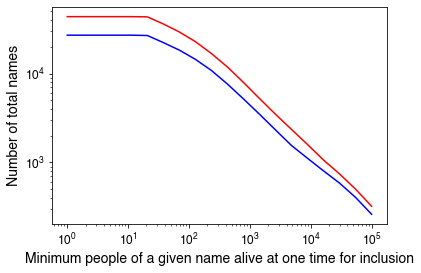

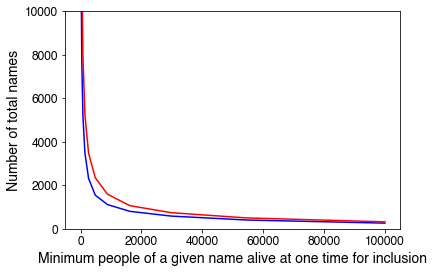

note: set is now lightly trimmed coming in, so small thresholds do little
Total male names >50: 20482
Total female names >50: 33056
Total male names >5000: 1512
Total female names >5000: 2292


In [43]:
#Compare how many names you keep depending on your cutoff threshold
#for whether a name has enough holders (requires hand-tuning, should
#include the code from the earlier )

commons_list_M = []
commons_list_F = []
#Test thresholds of 1-100000, using 20 log steps
testvals = np.logspace(0,5,20)
for n in testvals:
    commons_list_M.append(sum(namelife_M_base.max(1) > n))
    commons_list_F.append(sum(namelife_F_base.max(1) > n))
    
plt.loglog(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.show()
plt.plot(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.ylim([0,10000])
plt.show()

#A couple specific test values:
thresh1 = 50
thresh2 = 5000
commons_M_1 = namelife_M_base.max(1) > thresh1
commons_F_1 = namelife_F_base.max(1) > thresh1
commons_M_2 = namelife_M_base.max(1) > thresh2
commons_F_2 = namelife_F_base.max(1) > thresh2

#Total names:
print('note: set is now lightly trimmed coming in, so small thresholds do little')
print('Total male names >{}: '.format(thresh1) + str(sum(commons_M_1)))
print('Total female names >{}: '.format(thresh1) + str(sum(commons_F_1)))
print('Total male names >{}: '.format(thresh2) + str(sum(commons_M_2)))
print('Total female names >{}: '.format(thresh2) + str(sum(commons_F_2)))

In [44]:
#Name test sets:

thresh=5000

nametest_M_inds = namelife_M_base.max(1) > thresh

nametest_M_name = namelife_M_name[nametest_M_inds]
nametest_M_pron = pd.Series([all_pronunciations_M[tempname][2] for tempname in nametest_M_name])
nametest_M_pronA = pd.Series([all_pronunciations_M[tempname][1] for tempname in nametest_M_name])
nametest_M_num = namelife_M_base[nametest_M_inds].max(1)
nametest_M_birth = namebirth_M[nametest_M_inds,:]

nametest_F_inds = namelife_F_base.max(1) > thresh
nametest_F_name = namelife_F_name[nametest_F_inds]
nametest_F_pron = pd.Series([all_pronunciations_F[tempname][2] for tempname in nametest_F_name])
nametest_F_pronA = pd.Series([all_pronunciations_F[tempname][1] for tempname in nametest_F_name])
nametest_F_num = namelife_F_base[nametest_F_inds].max(1)
nametest_F_birth = namebirth_F[nametest_F_inds,:]

#Raw name test set:
nametest_S_name = np.concatenate([nametest_M_name, nametest_F_name])
nametest_S_pron = np.concatenate([nametest_M_pron, nametest_F_pron])
nametest_S_pronA = np.concatenate([nametest_M_pronA, nametest_F_pronA])

NameError: name 'all_pronunciations_M' is not defined

# Name fitting notes:

Aside: Basically, time course fitting like this could probably be done using a RNN (Recurrent Neural Network) in Tensor Flow, it's implemented well with Keras. 

**1. What is the target outcome?**

First option: Predict how popular a given name *should* be in a given year, based on popularity of other names and the name's own popularity in the last, say, five years. Why is this hard? Large number of names, 140 data points. There's a high likelihood of overfitting, among other things. 

Second option: Much simpler, just use the time course correlation between different names over, say, a 10-year window to determine their similarity today. This allows grouping. 

Third option: Predict name frequency in a given year based on number and ages/age structure of each other name currently alive. This is likely to actually be possible and interesting, generational name trends would be very accessible by this method. 

**2. What to compare?**

Options: Graph distance (Affinity Propagation, Spectral Clustering, Markov Clustering (MCL)?)

More detailed spelling comparison: Bonus points for contiguous runs of letters that do not change? Shared syllable-equivalents? This would be a good spot for NLP, see below. 

Simple option: Semi-manual clustering. Names with identical pronunciation are automatically clustered, along with names with no more than one letter difference. 


**ASSORTED FITTABLE FEATURES:**  
-Letters (bag of words style) (include capitals for catching initial letters!)  
-Letter bigrams bag  
-Pronunciation bag  
-Pronunciation bigrams bag  

-Clustering time-series!
https://www.researchgate.net/publication/4756297_Model-Based_Clustering_of_Multiple_Time_Series.
Looks like it would be some work to implement, but potentially really interesting. 

In [ ]:
from sklearn.cluster import AffinityPropagation

#Using the distance module for Levenshtein because sure
import distance

In [ ]:
print(nametest_S_name.shape, nametest_M_name.shape, nametest_F_name.shape)

In [ ]:
%%time

#This is a costly part. Takes about 7 minutes at a threshold of >5000 alive.

#Borrowing from code:
#https://stats.stackexchange.com/questions/123060/clustering-a-long-list-of-strings-words-into-similarity-groups
#https://stackoverflow.com/questions/21511801/text-clustering-with-levenshtein-distances

#pronA takes noticeably more time, since the strings are longer. 

lev_similarity_name = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_name] for nameM2 in nametest_M_name])
lev_similarity_pron = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_pron] for nameM2 in nametest_M_pron])
lev_similarity_pronA = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_pronA] for nameM2 in nametest_M_pronA])

In [ ]:
%%time

#Not very costly. Once the similarity matrices are built, the cluster fitting
#only takes a few seconds.

#Set up a near-default affinity propagation instance
affprop_M_name = AffinityPropagation(affinity='precomputed', preference=0, random_state=None)
affprop_M_pron = AffinityPropagation(affinity='precomputed', preference=0, random_state=None)
# affprop_M_pronA = AffinityPropagation(affinity='precomputed', preference=0) #Basically doesn't converge.

affprop_M_name.fit(lev_similarity_name)
affprop_M_pron.fit(lev_similarity_pron)
# affprop_M_pronA.fit(lev_similarity_pronA)

#The ARPABET pronunciation does not really converge on its own,
#looks like it may not cluster very neatly on its own. 

#However, as an additional perspective on pronunciation, it's 
#probably still useful to add. In practice, the clusters do 
#seem to make more sense when it's included.

#After fiddling with it a little, the most "sensible" clusters seem
#to come from weighting the pronunciations at about .75 apiece, so
#they make up more than half the total but less than double the
#spelling weight. 

affprop_M_triple = AffinityPropagation(affinity='precomputed', preference=0.1, random_state=None)
affprop_M_triple.fit(lev_similarity_name + 0.75*lev_similarity_pron + 0.75*lev_similarity_pronA)

#### Affinity propagation notes:

The IPA pronunciation-difference Levenshtein similarity is not very good. It would probably be better to implement the ARPABET pronunciations, since that model contains useful information about sound similarity based on just the characters present in each sound's codeb. That will take a lot more work, since it'd be effectively two-level Levenshtein, I'd have to think about how to reconcile that. 

One way would be instead of "one-character substitution" you could implement "character difference". For example, the "A" in "Adrian" is "EY1", where the "A" in "Andrew" is "AE1". That would be a Levenshtein distance of 2 (one subtraction to E1, one addition to AE1, or other ways to get there). Okay so that's not necessarily the greatest, since it would give a normalized Levenshtein of 0.66 (2/3 difference) when the sounds are reasonably similar, but it's still better than the complete difference that IPA would give. Character addition/subtraction would still be a binary scale. 

(Tried to find a measure of how "far apart" different vowels are, but the data isn't included in a paper that does what looks like a good job of it: http://www.martijnwieling.nl/files/Interspeech2013-FTetal.pdf)

In [ ]:
tgt_affprop = affprop_M_triple
tgt_namebirth = namebirth_M

print(len(np.unique(tgt_affprop.labels_)))
for cluster_id in np.unique(tgt_affprop.labels_):
    exemplar = nametest_M_name.iloc[tgt_affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(nametest_M_name.iloc[np.nonzero(tgt_affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))
    
#Functionally, some of this is tracking what sounds are popular, which is fine.

#The clusters are more or less sensible. Some names don't fit in very well; may
#want to consider once again trying to hunt down an algorithm that's more willing
#to leave solo clusters, because some of these names just flat don't fit very well
#with any other name. 

In [ ]:
#Example name comparison

testname1 = 'Andrew'
testname2 = 'Adrian'

print('Example name comparison with eye toward comparing sounds later:\n')
print(testname1)
print(all_pronunciations_M[testname1])
print(testname2)
print(all_pronunciations_M[testname2])
print('\nSpelling Lev:')
print(distance.nlevenshtein(testname1,testname2))
print('IPA Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][2], all_pronunciations_M[testname2][2]))
print('ARPABET Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][1], all_pronunciations_M[testname2][1]))

sound1 = all_pronunciations_M[testname1][1].split()[0]
sound2 = all_pronunciations_M[testname2][1].split()[0]
print('ARPABET first sound Lev: ' + sound1 + ' vs ' + sound2)
print(distance.nlevenshtein(sound1, sound2))

In [ ]:
#Generate cluster timecourses:

cluster_courses = np.zeros([len(np.unique(tgt_affprop.labels_)),nametest_M_birth.shape[1]])
for i,cluster_id in enumerate(np.unique(tgt_affprop.labels_)):
    cc = nametest_M_birth[tgt_affprop.labels_==cluster_id,:]
    cluster_courses[i,:] = np.sum(cc, axis=0)
    
#Normalize to year total -> fraction of year's births in X cluster
cc_norm = cluster_courses/np.sum(cluster_courses, axis=0)
#Normalize from fraction of year to standard scale
cc_norm2 = (cc_norm - np.mean(cc_norm, axis=1).reshape(-1,1))/np.std(cc_norm, axis=1).reshape(-1,1)

# plt.plot(cc_norm.T)
# plt.show()

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split

#Fit first-10 with visual verification:
name_linmodels = []

#The scores are often terrible, because it's comparing versus
#using the mean of the KNOWN data, but visually inspecting the
#first 30 or so it's actually doing a reasonable job in most
#cases. 
for n in range(30):
    lin_mod = Ridge(alpha=0.01)

    y_examp = nametest_M_birth[n,:].T
    X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

    #Random split:
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.25)
    #Year split:
    X_train, X_test, y_train, y_test = X_examp[:-5], X_examp[-5:], y_examp[:-5], y_examp[-5:]

    lin_mod.fit(X_train, y_train)
    
    y_pred = lin_mod.predict(X_test)
    
    print(nametest_M_name.iloc[n])
    print(lin_mod.score(X_test, y_test))
    
    plt.plot(X_train[:,-1], y_train, 'b.')
    plt.plot(X_test[:,-1], y_test, 'b+')
    plt.plot(X_test[:,-1], y_pred, 'rx')
    plt.legend(['Train','Test-actual','Test-pred'])
    plt.show()
    

In [ ]:
%%time

X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

#Re-fit using entire set prior to the last 5 years. Repeat this multiple
#times using random sets of the data each time. 

n_refits = 20
name_linmodels = []
# name_linmodels = np.zeros([nametest_M_birth.shape[0], X_examp.shape[1], n_refits])
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = nametest_M_birth[n,:].T

    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])

    #Primitive bootstrap: Fit on partial data repeatedly, then average. 
    #Year split:
    X_train, X_test, y_train, y_test = train_test_split(X_examp[:-5], y_examp[:-5], test_size=0.1)
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    #name_linmodels[m, :, n] = lin_mod.coef_

    test_score = lin_mod.score(X_examp[-5:], y_examp[-5:])
    test_scores.append(test_score)
    print('{0}: train {1:.3f}, test {2:.3f}, val {3:.3f} ({4})'.format(nametest_M_name.iloc[n],
                                                                       lin_mod.score(X_train, y_train),
                                                                       lin_mod.score(X_test, y_test),
                                                                       test_score,
                                                                       n
                                                                      ))
    y_pred_st = lin_mod.predict(X_test)
    y_pred_fu = lin_mod.predict(X_examp[-5:])
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        plt.plot(X_test[:,-1], y_test, 'b+')
        plt.plot(X_test[:,-1], y_pred_st, 'rx')
        plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

As you can see in the interspersed test plots, while the scores are very poor, that's because the scoring compares them against the *known* mean value of the last five years. They're actually reasonable predictions given the past history of the name in most cases! Even hitting a score of zero (performing as well as the actual mean of the last five years) is quite good. There are a few notable problems, though. For example, the estimates are often overly-optimistic for names that are currently in a long-term low. It really thought Bert and Cletus were going to come back, for example. Similarly, it sometimes heads significantly negative, which is an obvious problem. 

In [ ]:
len(name_linmodels)

## Name trend detection preliminary conclusion:

With careful variable preprocessing, a simple linear model does a surprisingly good job of tracking name trends without drastic overfitting. I'd need to extend this significantly to allow next-year prediction (i.e. generating projected name-cluster data), but it's a clear sign that we can reasonably track some trends for relatively popular names. To use the prior model for predictions, we'd have to generate synthetic cluster-trend data, which is feasible. For example, let's plug what we have into a time-series model like ARIMA, which uses the time course of the data to project its future trajectory. This is like to do reasonably well for near-future projection, and we can use that projection to generate the synthetic cluster trends necessary for the linear model to predict. Of course, we could also use the ARIMA directly on each name, but that would take hours for the full set of names compared to seconds for the linear model, and would also discard the information we can calculate about how names trend together. 

(Aside: This might actually be a pretty good spot for a multidimensional Kalman filter, which would use information from each timecourse variable quite nicely. I've been waiting for an excuse to get one of those going, might finally be the time!)  
(Also, there are 0 babies named Arima in the names database, which is honestly a little surprising.)

## ARIMA name timecourse projection:


In [ ]:
len(names_df_trim[names_df_trim['Name'] == 'Arima'])

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

#Handy reference for transforms:
#https://alkaline-ml.com/pmdarima/usecases/sun-spots.html

In [ ]:
%%time

#Testing this on most recent 5 years, so all but last 5 in training set
tsize = 135

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    y_train, y_test = train_test_split(y, train_size=tsize)

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(y_test.shape[0])  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

### Actual name trend predictions:

In [ ]:
%%time

#STEP 1: REDO THE ARIMAS WITH ALL YEARS

tsize = 140

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    #y_train, y_test = train_test_split(y, train_size=tsize)
    y_train = y

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(5)  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
y_pred_arima.shape

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

#Add the pre-predicted value to the stack to convert the 5
#predicted values to a change (6 vals -> 5 differences)
baseval = cc_norm2[:,-1]
y_pred_arima = np.hstack([baseval.reshape(-1,1),y_pred_arima])
#Calculate the X-predicted in the difference format:
X_pred_arima = np.hstack([np.diff(y_pred_arima).T, np.arange(2020,2025).reshape(-1,1)])

In [ ]:
X_pred_arima.shape

In [ ]:
X_examp.shape

In [ ]:
%%time

#STEP 2: Redo the linear fits to include the complete dataset.

#1. Convert to CHANGE by year (solves most of the negatives problems)
temp_delta = np.diff(cc_norm2) #yes, correct axis (1) is default
temp_bdelta = np.diff(nametest_M_birth) #^same

#2. Start in 1881, since that's the first year we can do diff for
X_examp = np.hstack([temp_delta.T, np.arange(1881,2020).reshape(-1,1)])

n_refits = 20
name_linmodels = []
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = temp_bdelta[n,:].T
    
    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])
    
    #With this few data points, I'm throwing the whole thing in for now.
    #The CV is using a subset each time already.
    
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.1)
    X_train, y_train = X_examp, y_examp
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    
    print('{0}: train {1:.3f} ({2})'.format(nametest_M_name.iloc[n],lin_mod.score(X_train, y_train), n))
    y_pred_fu = lin_mod.predict(X_pred_arima)
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        #plt.plot(X_test[:,-1], y_test, 'b+')
        #plt.plot(X_test[:,-1], y_pred_st, 'rx')
        #plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        #plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.plot(np.arange(2020,2025), y_pred_fu)
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

In [ ]:
#STEP 3: MAKE NAME PROJECTIONS

n_names = len(nametest_M_name)

name_futures = np.zeros([n_names,5])
for n in range(n_names):
    name_futures[n,:] = name_linmodels[n].predict(X_pred_arima)
    

In [ ]:
#Testrun: First 30 names

for n in range(30):
    plt.plot(np.arange(1880,2020), nametest_M_birth[n,:])
    plt.plot(np.arange(2020,2025), nametest_M_birth[n,-1] + name_futures[n,:] - name_futures[n,0], 'b+')
    plt.title(nametest_M_name.iloc[n])
    plt.show()

Modifications: I should do a log transform on the data early on, to convert it closer to a normal-distribution range of values, which would respond more appropriately to linear fitting. That's going near the top of the list, it will have a real effect on how well most models can characterize the data. 

Overly-optimistic predictions for near-dead names could be handled better at the individual-name level with ARIMA, despite the drastically slower processing. Similarly, ARIMA would likely also do fairly well avoiding negatives, since the graph tends to flatten as it nears zero. That's largely handled with the transition to yearly change, though. A hybrid model using both could probably do pretty well, but it would be difficult to reasonably fit given the data, and at that point you might want to head into more complex territory like RNN. 

Anyway, predicting names is inherently a difficult problem. We don't have reliable time components to the signal that we can account for, or a massive pile of datapoints. There are generation-related timing elements, but those are close to random, and how long trends persist may be changing. 

Pulling in data on name popularity on a state-by-state basis would help quite a bit, bumping our dataset from about 140 datapoints to about 5000 (some state reporting didn't get going until later if I'm recalling right, so it's not quite 140 x 51). It certainly wouldn't solve the problem by itself! State name trends are strongly correlated with national trends, especially as media increasingly moves away from the local level. State data could significantly help, but it will be necessary to use models that account for correlation between variables. 

Future directions for name trend prediction, in summary:
- More in-depth data transformation prior to analysis/modeling (log or Box-Cox transform built into `pmdarima`, for example)
- Consider multivariate autoregression (i.e. VAR) to model multivariate time series data more effectively (not likely to make the ARIMA fitting feasible for individual names without a days-long run)  
- Consider reweighting recent years. Names with a strong recent increase are at a disadvantage in threshold, despite strong likelihood of continuing future presence. Could weigh name prevalence more highly in the last 3-5 years, for example, both to avoid cutting them off at the threshold stage and to increase the attention the model pays to recent trends? Something to consider.
- Add state data to improve models (at minimum should reduce year-level noise, important now that it's predicting based on yearly change)
- Toss this into an actual user interface/prediction engine. 

In [ ]:
#Assorted fun side comparisons:

#Names in '50 ways to leave your lover' by Paul Simon:
#https://www.azlyrics.com/lyrics/paulsimon/50waystoleaveyourlover.html
#Jack, Stan, Roy, Gus, Lee

#Names in 'Mambo No. 5' by Lou Bega:
#https://www.azlyrics.com/lyrics/loubega/mambono5.html
#Angela, Pamela, Sandra, Rita, Monica, Erica, Rita (again), Tina, Sandra, Mary, Jessica

#Names in '88 lines about 44 wome' by The Nails:
#https://genius.com/The-nails-88-lines-about-44-women-lyrics
#Deborah, Carla, Mary, Susan, Reno, Cathy, Vicki, Kamela, Xylla, Joan, Sherry, Kathleen,
#Seattle, Karen, Jeannie, Mary Ellen, Gloria, Mimi, Marilyn, Julie, Rhonda, Patty, Linda, 
#Katherine, Pauline, Jean-Marie, Gina, Jackie, Sarah, Janet, Tanya, Brenda, Rowena, Dee Dee, 
#Debbie Ray, Nina, Bobbi, Eloise, Terri, Ronnie, Jezebel, Dinah, Judy, Amaranta

#State names:
#(self-evident)

#City names: 
#US cities by population (>100,000):
#https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

#Worldwide cities (>5,000,000):
#https://en.wikipedia.org/wiki/List_of_largest_cities

#Urban vs. rural states:
#https://fivethirtyeight.com/features/how-urban-or-rural-is-your-state-and-what-does-that-mean-for-the-2020-election/
#(Loosely, how many people are within 5 miles of a given census tract)

#Check trendiness: It looks in general like the time course for F
#names may be shorter than the time course for M names. Is that
#true, and if so has it been becoming less true since 2000?

#Could look at that by taking 10-year chunks (looks like about the
#right length to capture a rising or falling trend) and seeing which
#names correlate together for each chunk? Automatic grouping based
#on "trendiness" would be pretty cool. 

#Extend data: I could also cross-correlate names with Google ngrams 
#results for that name, that would be a nice comparison. Excellent
#proxy for whether a name is culturally established!

#Extend data: Cross-correlate artists who made the Billboard top 10
#using their names (i.e. Alanis). Only include cases where the name
#is in both, so simple inner join would be ideal. 
